# Caption generator on Flickr8k dataset using DN201 and LSTM

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

## 1. Processing the dataset

In [3]:
image_path = '/kaggle/input/flickr8k/Images'

In [4]:
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [5]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

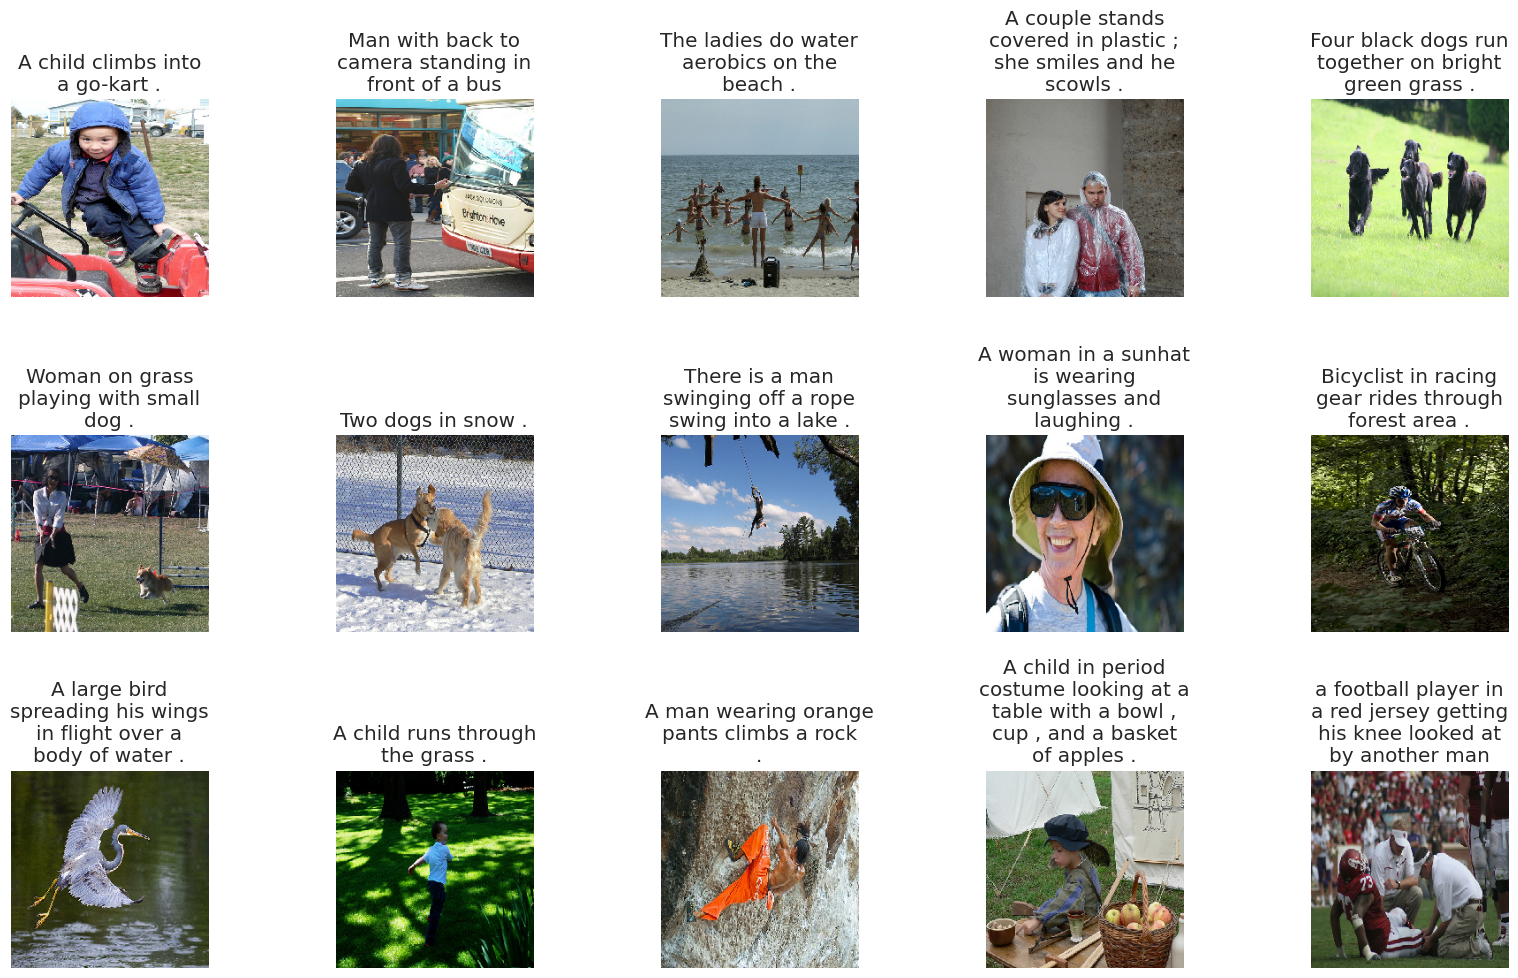

In [6]:
display_images(data.sample(15))

In [7]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [8]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [9]:
# tokenizing text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [10]:
# feature extraction from image
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1729371870.006095     107 service.cc:145] XLA service 0x7d1eec004fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729371870.006156     107 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729371870.006160     107 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729371882.461207     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [12:40<00:00, 10.64it/s]


In [11]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

## 2. Modelling

![Model description](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

In [12]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [13]:
caption_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,172,160 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 35, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  1,094,565 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

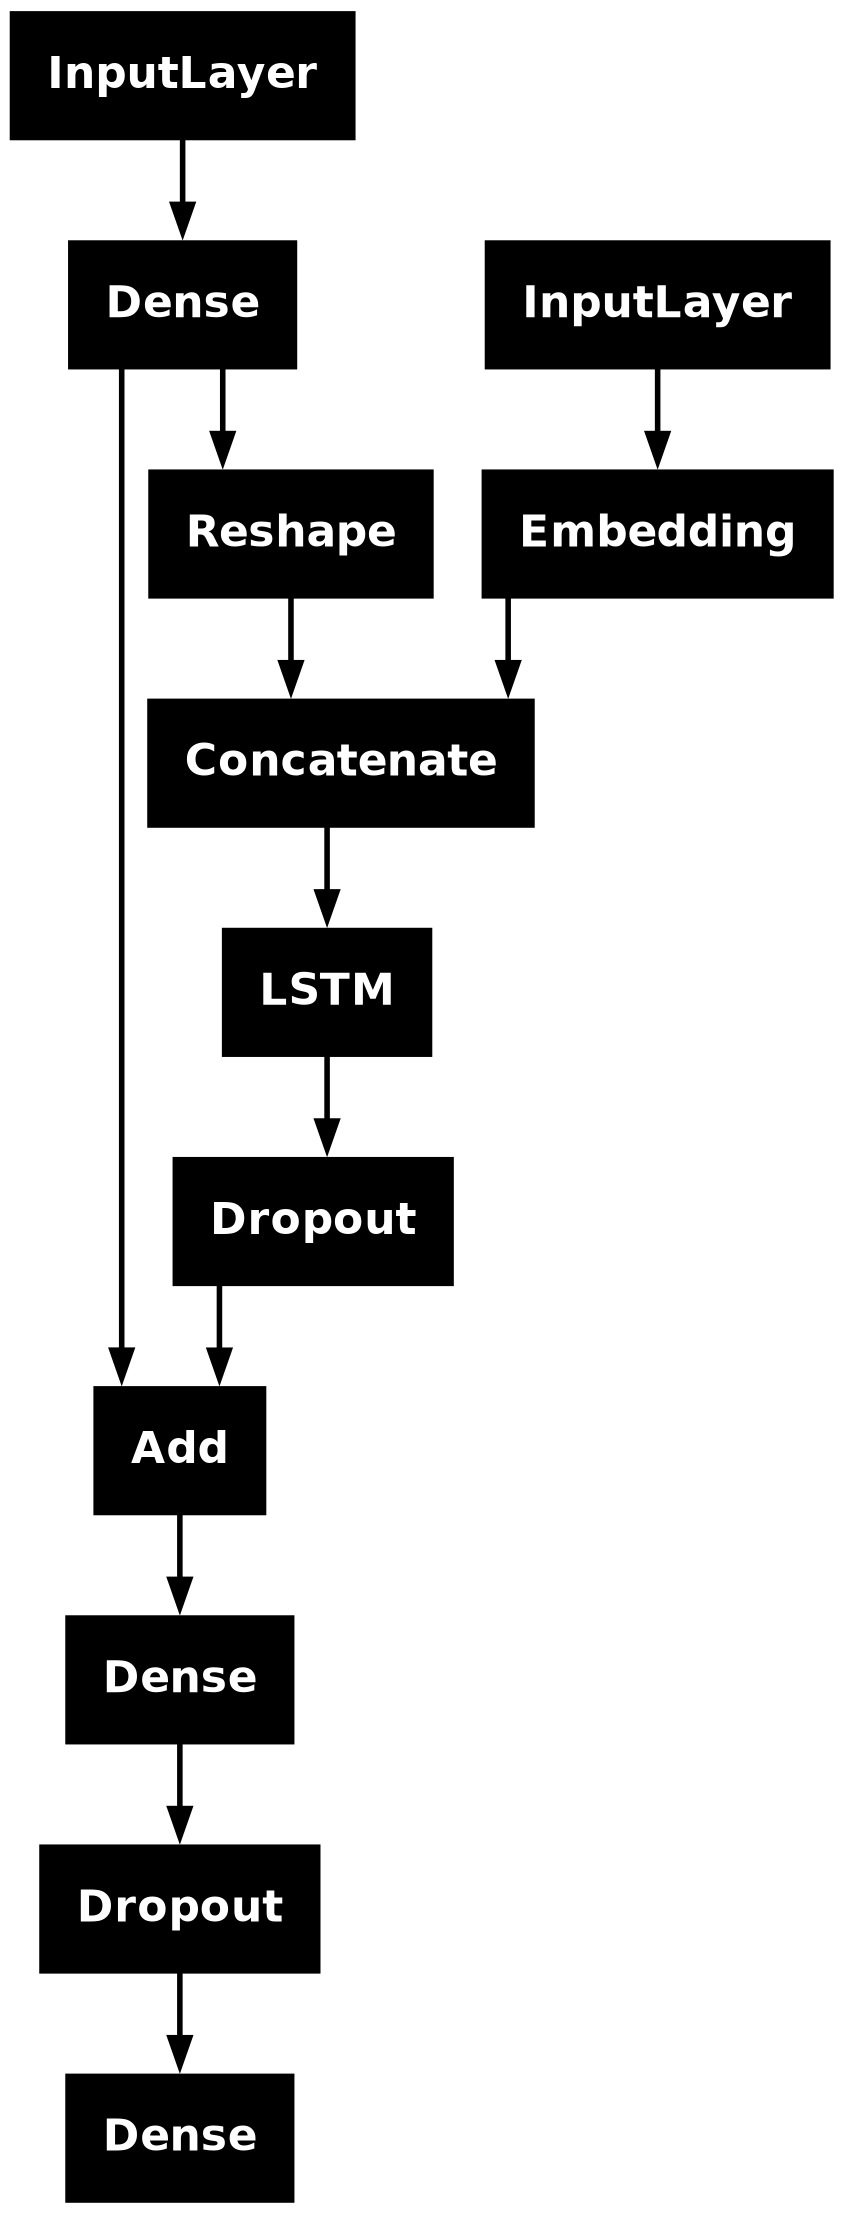

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model)

In [15]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [16]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [17]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - loss: 5.6794
Epoch 1: val_loss improved from inf to 4.21671, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 321s 584ms/step - loss: 5.6782 - val_loss: 4.2167 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 4.2291
Epoch 2: val_loss improved from 4.21671 to 3.92023, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 88s 157ms/step - loss: 4.2290 - val_loss: 3.9202 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 3.9523
Epoch 3: val_loss improved from 3.92023 to 3.78069, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 82s 152ms/step - loss: 3.9522 - val_loss: 3.7807 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 3.7828
Epoch 4: val_loss improved from 3.78069 to 3.71486, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 79s 145ms/step - loss: 3.7828 - val_loss: 3.7149 - learning_rate: 0.0010

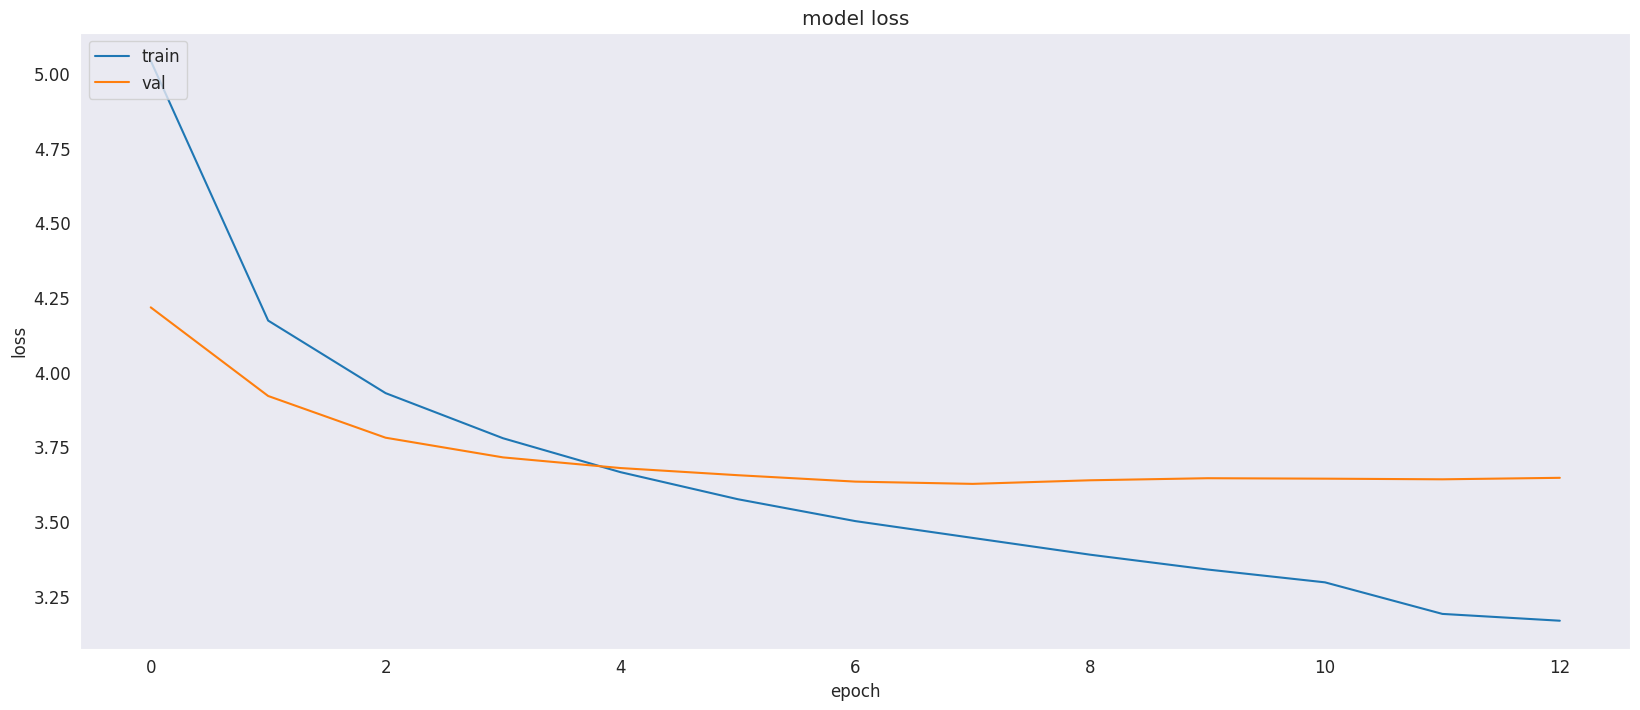

In [18]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Testing

In [30]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [31]:
def calculate_bleu(reference_caption, generated_caption):
    """
    Calculate BLEU score between the reference (ground truth) and generated captions.
    
    Args:
    reference_caption: List of reference (true) captions.
    generated_caption: The caption predicted by the model.

    Returns:
    BLEU score for the generated caption.
    """
    smoothie = SmoothingFunction().method4
    return sentence_bleu([reference_caption.split()], generated_caption.split(), smoothing_function=smoothie)


In [32]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [34]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [35]:
# Calculating BLEU score for all images in the test set
bleu_scores = []
for image in tqdm(test['image'].unique()):
    # Get the reference captions
    reference_captions = test[test['image'] == image]['caption'].tolist()
    
    # Generate caption using the trained model
    generated_caption = predict_caption(caption_model, image, tokenizer, max_length, features)
    
    # Calculate BLEU score for the generated caption against all reference captions
    for ref_caption in reference_captions:
        bleu_score = calculate_bleu(ref_caption, generated_caption)
        bleu_scores.append(bleu_score)
        print(f"Image: {image}, BLEU Score: {bleu_score}")

# Average BLEU Score
average_bleu_score = np.mean(bleu_scores)
print(f"Average BLEU Score: {average_bleu_score}")

  0%|          | 0/1214 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 1/1214 [00:00<09:43,  2.08it/s]

Image: 3688858505_e8afd1475d.jpg, BLEU Score: 0.07709170530676224
Image: 3688858505_e8afd1475d.jpg, BLEU Score: 0.15978641894746867
Image: 3688858505_e8afd1475d.jpg, BLEU Score: 0.23418392299336482
Image: 3688858505_e8afd1475d.jpg, BLEU Score: 0.25916711346124927
Image: 3688858505_e8afd1475d.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|          | 2/1214 [00:01<10:49,  1.86it/s]

Image: 3689355450_fd559b816d.jpg, BLEU Score: 0.25540778661907937
Image: 3689355450_fd559b816d.jpg, BLEU Score: 0.24453055316600977
Image: 3689355450_fd559b816d.jpg, BLEU Score: 0.2572013901952304
Image: 3689355450_fd559b816d.jpg, BLEU Score: 0.19035032617500067
Image: 3689355450_fd559b816d.jpg, BLEU Score: 0.21627972701344117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 3/1214 [00:01<10:13,  1.98it/s]

Image: 368954110_821ccf005c.jpg, BLEU Score: 0.0656236472168576
Image: 368954110_821ccf005c.jpg, BLEU Score: 0.2342054179517238
Image: 368954110_821ccf005c.jpg, BLEU Score: 0.2215998685042953
Image: 368954110_821ccf005c.jpg, BLEU Score: 0.2566773959494333
Image: 368954110_821ccf005c.jpg, BLEU Score: 0.21078382996954045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|          | 4/1214 [00:02<11:17,  1.79it/s]

Image: 3689727848_b53f931130.jpg, BLEU Score: 0.19702498636547824
Image: 3689727848_b53f931130.jpg, BLEU Score: 0.2290302783996535
Image: 3689727848_b53f931130.jpg, BLEU Score: 0.19702498636547824
Image: 3689727848_b53f931130.jpg, BLEU Score: 0.20832855876262565
Image: 3689727848_b53f931130.jpg, BLEU Score: 0.24377854999451928
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 5/1214 [00:02<11:25,  1.76it/s]

Image: 3689975998_72f50b6d91.jpg, BLEU Score: 0.25540778661907937
Image: 3689975998_72f50b6d91.jpg, BLEU Score: 0.2744535278544658
Image: 3689975998_72f50b6d91.jpg, BLEU Score: 0.25540778661907937
Image: 3689975998_72f50b6d91.jpg, BLEU Score: 0.20454473702045944
Image: 3689975998_72f50b6d91.jpg, BLEU Score: 0.1144581170315019
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 6/1214 [00:03<11:31,  1.75it/s]

Image: 3690107455_0fdb4ecee7.jpg, BLEU Score: 0.2332130329059486
Image: 3690107455_0fdb4ecee7.jpg, BLEU Score: 0.2307869877265558
Image: 3690107455_0fdb4ecee7.jpg, BLEU Score: 0.2307869877265558
Image: 3690107455_0fdb4ecee7.jpg, BLEU Score: 0.16465383981002704
Image: 3690107455_0fdb4ecee7.jpg, BLEU Score: 0.20454473702045944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|          | 7/1214 [00:03<10:26,  1.93it/s]

Image: 3690159129_93ba49ea18.jpg, BLEU Score: 0.23404821161541917
Image: 3690159129_93ba49ea18.jpg, BLEU Score: 0.17008750067899162
Image: 3690159129_93ba49ea18.jpg, BLEU Score: 0.18227693048255034
Image: 3690159129_93ba49ea18.jpg, BLEU Score: 0.1608588265634783
Image: 3690159129_93ba49ea18.jpg, BLEU Score: 0.20312270027112192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|          | 8/1214 [00:04<10:52,  1.85it/s]

Image: 3690189273_927d42ff43.jpg, BLEU Score: 0.25540778661907937
Image: 3690189273_927d42ff43.jpg, BLEU Score: 0.16211662384805808
Image: 3690189273_927d42ff43.jpg, BLEU Score: 0.2506037128701066
Image: 3690189273_927d42ff43.jpg, BLEU Score: 0.25540778661907937
Image: 3690189273_927d42ff43.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 9/1214 [00:04<10:26,  1.92it/s]

Image: 3690348036_a01f243fb0.jpg, BLEU Score: 0.25916711346124927
Image: 3690348036_a01f243fb0.jpg, BLEU Score: 0.2319342092612654
Image: 3690348036_a01f243fb0.jpg, BLEU Score: 0.2635039541631044
Image: 3690348036_a01f243fb0.jpg, BLEU Score: 0.22277411682906492
Image: 3690348036_a01f243fb0.jpg, BLEU Score: 0.1510332139358376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|          | 10/1214 [00:05<09:46,  2.05it/s]

Image: 3690425778_3b390b3ea5.jpg, BLEU Score: 0.23428691010919245
Image: 3690425778_3b390b3ea5.jpg, BLEU Score: 0.29430004544273397
Image: 3690425778_3b390b3ea5.jpg, BLEU Score: 0.23404821161541917
Image: 3690425778_3b390b3ea5.jpg, BLEU Score: 0.17008750067899162
Image: 3690425778_3b390b3ea5.jpg, BLEU Score: 0.13153366491686566
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|          | 11/1214 [00:05<11:10,  1.79it/s]

Image: 3690431163_1d81e19549.jpg, BLEU Score: 0.25153238730449584
Image: 3690431163_1d81e19549.jpg, BLEU Score: 0.21566485467065677
Image: 3690431163_1d81e19549.jpg, BLEU Score: 0.13535903948005998
Image: 3690431163_1d81e19549.jpg, BLEU Score: 0.27028914027720474
Image: 3690431163_1d81e19549.jpg, BLEU Score: 0.26463594442057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 12/1214 [00:06<10:37,  1.89it/s]

Image: 369047365_35476becc9.jpg, BLEU Score: 0.23191292275041653
Image: 369047365_35476becc9.jpg, BLEU Score: 0.1144919721803223
Image: 369047365_35476becc9.jpg, BLEU Score: 0.22277411682906492
Image: 369047365_35476becc9.jpg, BLEU Score: 0.07341000719469058
Image: 369047365_35476becc9.jpg, BLEU Score: 0.20731467560330663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 13/1214 [00:07<11:26,  1.75it/s]

Image: 3690883532_d883f34617.jpg, BLEU Score: 0.2107317638017438
Image: 3690883532_d883f34617.jpg, BLEU Score: 0.25540778661907937
Image: 3690883532_d883f34617.jpg, BLEU Score: 0.25540778661907937
Image: 3690883532_d883f34617.jpg, BLEU Score: 0.1144581170315019
Image: 3690883532_d883f34617.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 14/1214 [00:07<10:26,  1.91it/s]

Image: 3691592651_6e4e7f1da9.jpg, BLEU Score: 0.1922134760048255
Image: 3691592651_6e4e7f1da9.jpg, BLEU Score: 0.20064361442719525
Image: 3691592651_6e4e7f1da9.jpg, BLEU Score: 0.21780640299346554
Image: 3691592651_6e4e7f1da9.jpg, BLEU Score: 0.09594836971051625
Image: 3691592651_6e4e7f1da9.jpg, BLEU Score: 0.09756581019614656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 15/1214 [00:07<10:09,  1.97it/s]

Image: 3691622437_f13644273c.jpg, BLEU Score: 0.25916711346124927
Image: 3691622437_f13644273c.jpg, BLEU Score: 0.23418392299336482
Image: 3691622437_f13644273c.jpg, BLEU Score: 0.10759014179719262
Image: 3691622437_f13644273c.jpg, BLEU Score: 0.1510332139358376
Image: 3691622437_f13644273c.jpg, BLEU Score: 0.18861765840545985
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▏         | 16/1214 [00:08<09:40,  2.06it/s]

Image: 3691670743_0ed111bcf3.jpg, BLEU Score: 0.15261166365587558
Image: 3691670743_0ed111bcf3.jpg, BLEU Score: 0.23016817359497846
Image: 3691670743_0ed111bcf3.jpg, BLEU Score: 0.2802636449867835
Image: 3691670743_0ed111bcf3.jpg, BLEU Score: 0.23567269439532595
Image: 3691670743_0ed111bcf3.jpg, BLEU Score: 0.15819211803072802
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▏         | 17/1214 [00:09<11:08,  1.79it/s]

Image: 3691729694_2b97f14c1e.jpg, BLEU Score: 0.23462350320528
Image: 3691729694_2b97f14c1e.jpg, BLEU Score: 0.19702498636547824
Image: 3691729694_2b97f14c1e.jpg, BLEU Score: 0.2290302783996535
Image: 3691729694_2b97f14c1e.jpg, BLEU Score: 0.25346366816882765
Image: 3691729694_2b97f14c1e.jpg, BLEU Score: 0.2290302783996535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▏         | 18/1214 [00:09<10:49,  1.84it/s]

Image: 3691800116_6a7b315e46.jpg, BLEU Score: 0.12794696212937312
Image: 3691800116_6a7b315e46.jpg, BLEU Score: 0.23418392299336482
Image: 3691800116_6a7b315e46.jpg, BLEU Score: 0.25916711346124927
Image: 3691800116_6a7b315e46.jpg, BLEU Score: 0.15978641894746867
Image: 3691800116_6a7b315e46.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 19/1214 [00:10<10:37,  1.87it/s]

Image: 369186134_5eef374112.jpg, BLEU Score: 0.22968502563308238
Image: 369186134_5eef374112.jpg, BLEU Score: 0.2591909015430299
Image: 369186134_5eef374112.jpg, BLEU Score: 0.2644967217413845
Image: 369186134_5eef374112.jpg, BLEU Score: 0.23579369832119734
Image: 369186134_5eef374112.jpg, BLEU Score: 0.2243054613909257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 20/1214 [00:10<12:00,  1.66it/s]

Image: 369244499_752f0c1018.jpg, BLEU Score: 0.17148125527131305
Image: 369244499_752f0c1018.jpg, BLEU Score: 0.18426860078591026
Image: 369244499_752f0c1018.jpg, BLEU Score: 0.15324630618809051
Image: 369244499_752f0c1018.jpg, BLEU Score: 0.18426860078591026
Image: 369244499_752f0c1018.jpg, BLEU Score: 0.18426860078591026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 21/1214 [00:11<10:15,  1.94it/s]

Image: 3692593096_fbaea67476.jpg, BLEU Score: 0.1700210851830615
Image: 3692593096_fbaea67476.jpg, BLEU Score: 0.08177367771850616
Image: 3692593096_fbaea67476.jpg, BLEU Score: 0.1141243606689327
Image: 3692593096_fbaea67476.jpg, BLEU Score: 0.04198400602693508
Image: 3692593096_fbaea67476.jpg, BLEU Score: 0.07389085902898788
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 22/1214 [00:11<10:08,  1.96it/s]

Image: 3692746368_ab7d97ab31.jpg, BLEU Score: 0.2824099048856541
Image: 3692746368_ab7d97ab31.jpg, BLEU Score: 0.29558013016570783
Image: 3692746368_ab7d97ab31.jpg, BLEU Score: 0.14499407975266088
Image: 3692746368_ab7d97ab31.jpg, BLEU Score: 0.11377316606547655
Image: 3692746368_ab7d97ab31.jpg, BLEU Score: 0.22968502563308238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 23/1214 [00:12<10:26,  1.90it/s]

Image: 3692836015_d11180727b.jpg, BLEU Score: 0.22741221234802106
Image: 3692836015_d11180727b.jpg, BLEU Score: 0.25732926670203377
Image: 3692836015_d11180727b.jpg, BLEU Score: 0.1724929659020246
Image: 3692836015_d11180727b.jpg, BLEU Score: 0.11708335297095786
Image: 3692836015_d11180727b.jpg, BLEU Score: 0.23252324097940982
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 24/1214 [00:12<10:04,  1.97it/s]

Image: 3692892751_f6574e2700.jpg, BLEU Score: 0.18570135146601488
Image: 3692892751_f6574e2700.jpg, BLEU Score: 0.20752480135440643
Image: 3692892751_f6574e2700.jpg, BLEU Score: 0.20752480135440643
Image: 3692892751_f6574e2700.jpg, BLEU Score: 0.13306083274126748
Image: 3692892751_f6574e2700.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 25/1214 [00:13<10:16,  1.93it/s]

Image: 3693297007_94512e861e.jpg, BLEU Score: 0.13923635640143806
Image: 3693297007_94512e861e.jpg, BLEU Score: 0.36319417652574915
Image: 3693297007_94512e861e.jpg, BLEU Score: 0.22501919497276282
Image: 3693297007_94512e861e.jpg, BLEU Score: 0.2907153684841096
Image: 3693297007_94512e861e.jpg, BLEU Score: 0.23252324097940982
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 26/1214 [00:14<12:06,  1.64it/s]

Image: 369360998_ba56fb436f.jpg, BLEU Score: 0.20957621619414443
Image: 369360998_ba56fb436f.jpg, BLEU Score: 0.15962462989344833
Image: 369360998_ba56fb436f.jpg, BLEU Score: 0.15962462989344833
Image: 369360998_ba56fb436f.jpg, BLEU Score: 0.15016792085468614
Image: 369360998_ba56fb436f.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 27/1214 [00:14<11:18,  1.75it/s]

Image: 3693961165_9d6c333d5b.jpg, BLEU Score: 0.36889397323344053
Image: 3693961165_9d6c333d5b.jpg, BLEU Score: 0.25916711346124927
Image: 3693961165_9d6c333d5b.jpg, BLEU Score: 0.2215998685042953
Image: 3693961165_9d6c333d5b.jpg, BLEU Score: 0.22968502563308238
Image: 3693961165_9d6c333d5b.jpg, BLEU Score: 0.17683274086282447
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 28/1214 [00:15<10:50,  1.82it/s]

Image: 3694064560_467683205b.jpg, BLEU Score: 0.23418392299336482
Image: 3694064560_467683205b.jpg, BLEU Score: 0.14283839476059992
Image: 3694064560_467683205b.jpg, BLEU Score: 0.20731467560330663
Image: 3694064560_467683205b.jpg, BLEU Score: 0.19934703850724503
Image: 3694064560_467683205b.jpg, BLEU Score: 0.20553119141999848
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 29/1214 [00:15<11:31,  1.71it/s]

Image: 3694071771_ce760db4c7.jpg, BLEU Score: 0.2290302783996535
Image: 3694071771_ce760db4c7.jpg, BLEU Score: 0.21804399013987716
Image: 3694071771_ce760db4c7.jpg, BLEU Score: 0.19113038519475414
Image: 3694071771_ce760db4c7.jpg, BLEU Score: 0.1690009177391829
Image: 3694071771_ce760db4c7.jpg, BLEU Score: 0.26948730868481174
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 30/1214 [00:16<10:56,  1.80it/s]

Image: 3694093650_547259731e.jpg, BLEU Score: 0.12781741158243648
Image: 3694093650_547259731e.jpg, BLEU Score: 0.25916711346124927
Image: 3694093650_547259731e.jpg, BLEU Score: 0.2355549493734042
Image: 3694093650_547259731e.jpg, BLEU Score: 0.1888088336178649
Image: 3694093650_547259731e.jpg, BLEU Score: 0.2784931874429588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  3%|▎         | 31/1214 [00:16<10:37,  1.86it/s]

Image: 3694219419_a7a83d4886.jpg, BLEU Score: 0.1875198263025767
Image: 3694219419_a7a83d4886.jpg, BLEU Score: 0.18570135146601488
Image: 3694219419_a7a83d4886.jpg, BLEU Score: 0.0656236472168576
Image: 3694219419_a7a83d4886.jpg, BLEU Score: 0.18570135146601488
Image: 3694219419_a7a83d4886.jpg, BLEU Score: 0.24920665358891345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 32/1214 [00:17<11:27,  1.72it/s]

Image: 3694555931_7807db2fb4.jpg, BLEU Score: 0.20832855876262565
Image: 3694555931_7807db2fb4.jpg, BLEU Score: 0.2290302783996535
Image: 3694555931_7807db2fb4.jpg, BLEU Score: 0.25346366816882765
Image: 3694555931_7807db2fb4.jpg, BLEU Score: 0.25346366816882765
Image: 3694555931_7807db2fb4.jpg, BLEU Score: 0.19702498636547824
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 33/1214 [00:17<10:32,  1.87it/s]

Image: 3694991841_141804da1f.jpg, BLEU Score: 0.23567269439532595
Image: 3694991841_141804da1f.jpg, BLEU Score: 0.14969600562943478
Image: 3694991841_141804da1f.jpg, BLEU Score: 0.08669913911352062
Image: 3694991841_141804da1f.jpg, BLEU Score: 0.18354207894362776
Image: 3694991841_141804da1f.jpg, BLEU Score: 0.17925515383388427
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 34/1214 [00:18<09:51,  1.99it/s]

Image: 3695064885_a6922f06b2.jpg, BLEU Score: 0.0962083966589
Image: 3695064885_a6922f06b2.jpg, BLEU Score: 0.1500143189775649
Image: 3695064885_a6922f06b2.jpg, BLEU Score: 0.20367317732517012
Image: 3695064885_a6922f06b2.jpg, BLEU Score: 0.15862082999148358
Image: 3695064885_a6922f06b2.jpg, BLEU Score: 0.21317150434016247
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 35/1214 [00:18<09:50,  2.00it/s]

Image: 3695517194_2a6b604cb2.jpg, BLEU Score: 0.039196371959558794
Image: 3695517194_2a6b604cb2.jpg, BLEU Score: 0.0916780044584947
Image: 3695517194_2a6b604cb2.jpg, BLEU Score: 0.12794696212937312
Image: 3695517194_2a6b604cb2.jpg, BLEU Score: 0.22277411682906492
Image: 3695517194_2a6b604cb2.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 36/1214 [00:19<09:46,  2.01it/s]

Image: 3695949492_27ca3892fd.jpg, BLEU Score: 0.15015413870893624
Image: 3695949492_27ca3892fd.jpg, BLEU Score: 0.18753703811970887
Image: 3695949492_27ca3892fd.jpg, BLEU Score: 0.16780011325774705
Image: 3695949492_27ca3892fd.jpg, BLEU Score: 0.11906806466494693
Image: 3695949492_27ca3892fd.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 37/1214 [00:19<09:40,  2.03it/s]

Image: 3696246123_99d4d10140.jpg, BLEU Score: 0.12023403506700375
Image: 3696246123_99d4d10140.jpg, BLEU Score: 0.10382695684280493
Image: 3696246123_99d4d10140.jpg, BLEU Score: 0.1485474562112173
Image: 3696246123_99d4d10140.jpg, BLEU Score: 0.24764207868423957
Image: 3696246123_99d4d10140.jpg, BLEU Score: 0.2215998685042953
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 38/1214 [00:20<10:45,  1.82it/s]

Image: 3696698390_989f1488e7.jpg, BLEU Score: 0.25346366816882765
Image: 3696698390_989f1488e7.jpg, BLEU Score: 0.25346366816882765
Image: 3696698390_989f1488e7.jpg, BLEU Score: 0.25346366816882765
Image: 3696698390_989f1488e7.jpg, BLEU Score: 0.19702498636547824
Image: 3696698390_989f1488e7.jpg, BLEU Score: 0.272364436623922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 39/1214 [00:21<11:01,  1.78it/s]

Image: 3697003897_d8ac13be9a.jpg, BLEU Score: 0.20454473702045944
Image: 3697003897_d8ac13be9a.jpg, BLEU Score: 0.25540778661907937
Image: 3697003897_d8ac13be9a.jpg, BLEU Score: 0.2307869877265558
Image: 3697003897_d8ac13be9a.jpg, BLEU Score: 0.18420004764249043
Image: 3697003897_d8ac13be9a.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 40/1214 [00:21<11:13,  1.74it/s]

Image: 3697153626_90fb177731.jpg, BLEU Score: 0.2307869877265558
Image: 3697153626_90fb177731.jpg, BLEU Score: 0.2744535278544658
Image: 3697153626_90fb177731.jpg, BLEU Score: 0.14218803202571775
Image: 3697153626_90fb177731.jpg, BLEU Score: 0.2744535278544658
Image: 3697153626_90fb177731.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 41/1214 [00:22<11:20,  1.72it/s]

Image: 3697359692_8a5cdbe4fe.jpg, BLEU Score: 0.1887332815624917
Image: 3697359692_8a5cdbe4fe.jpg, BLEU Score: 0.2744535278544658
Image: 3697359692_8a5cdbe4fe.jpg, BLEU Score: 0.2744535278544658
Image: 3697359692_8a5cdbe4fe.jpg, BLEU Score: 0.2332130329059486
Image: 3697359692_8a5cdbe4fe.jpg, BLEU Score: 0.24195449110658754
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 42/1214 [00:22<11:31,  1.70it/s]

Image: 3697378565_7060d9281a.jpg, BLEU Score: 0.18032385351796001
Image: 3697378565_7060d9281a.jpg, BLEU Score: 0.25540778661907937
Image: 3697378565_7060d9281a.jpg, BLEU Score: 0.25540778661907937
Image: 3697378565_7060d9281a.jpg, BLEU Score: 0.19078470351568447
Image: 3697378565_7060d9281a.jpg, BLEU Score: 0.20454473702045944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▎         | 43/1214 [00:23<10:49,  1.80it/s]

Image: 3697379772_40d831392b.jpg, BLEU Score: 0.23191292275041653
Image: 3697379772_40d831392b.jpg, BLEU Score: 0.23418392299336482
Image: 3697379772_40d831392b.jpg, BLEU Score: 0.22299991164309863
Image: 3697379772_40d831392b.jpg, BLEU Score: 0.25916711346124927
Image: 3697379772_40d831392b.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▎         | 44/1214 [00:23<11:04,  1.76it/s]

Image: 3697456750_460aea7252.jpg, BLEU Score: 0.2307869877265558
Image: 3697456750_460aea7252.jpg, BLEU Score: 0.2332130329059486
Image: 3697456750_460aea7252.jpg, BLEU Score: 0.2307869877265558
Image: 3697456750_460aea7252.jpg, BLEU Score: 0.2307869877265558
Image: 3697456750_460aea7252.jpg, BLEU Score: 0.2332130329059486
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▎         | 45/1214 [00:24<10:39,  1.83it/s]

Image: 3697675767_97796334e4.jpg, BLEU Score: 0.16617287047735393
Image: 3697675767_97796334e4.jpg, BLEU Score: 0.15978641894746867
Image: 3697675767_97796334e4.jpg, BLEU Score: 0.22299991164309863
Image: 3697675767_97796334e4.jpg, BLEU Score: 0.21833175935360316
Image: 3697675767_97796334e4.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▍         | 46/1214 [00:24<09:55,  1.96it/s]

Image: 369802520_9825f2cd84.jpg, BLEU Score: 0.25161409602637574
Image: 369802520_9825f2cd84.jpg, BLEU Score: 0.15010169251756536
Image: 369802520_9825f2cd84.jpg, BLEU Score: 0.24747585322180027
Image: 369802520_9825f2cd84.jpg, BLEU Score: 0.21839667393271872
Image: 369802520_9825f2cd84.jpg, BLEU Score: 0.24747585322180027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▍         | 47/1214 [00:25<10:25,  1.86it/s]

Image: 3698607223_22fe09763a.jpg, BLEU Score: 0.19965836059241254
Image: 3698607223_22fe09763a.jpg, BLEU Score: 0.21111301299607096
Image: 3698607223_22fe09763a.jpg, BLEU Score: 0.20894157688592602
Image: 3698607223_22fe09763a.jpg, BLEU Score: 0.25540778661907937
Image: 3698607223_22fe09763a.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▍         | 48/1214 [00:26<10:45,  1.81it/s]

Image: 3698944019_825ef54f2f.jpg, BLEU Score: 0.22092881913713538
Image: 3698944019_825ef54f2f.jpg, BLEU Score: 0.20454473702045944
Image: 3698944019_825ef54f2f.jpg, BLEU Score: 0.25540778661907937
Image: 3698944019_825ef54f2f.jpg, BLEU Score: 0.21627972701344117
Image: 3698944019_825ef54f2f.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▍         | 49/1214 [00:26<11:56,  1.63it/s]

Image: 3699318394_6193f2c8e0.jpg, BLEU Score: 0.11744694414023009
Image: 3699318394_6193f2c8e0.jpg, BLEU Score: 0.17622106642479907
Image: 3699318394_6193f2c8e0.jpg, BLEU Score: 0.23290920066194776
Image: 3699318394_6193f2c8e0.jpg, BLEU Score: 0.0939170967673674
Image: 3699318394_6193f2c8e0.jpg, BLEU Score: 0.2272851691411099
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▍         | 50/1214 [00:27<10:48,  1.79it/s]

Image: 3699522388_2333f01f40.jpg, BLEU Score: 0.06257169470003475
Image: 3699522388_2333f01f40.jpg, BLEU Score: 0.21780640299346554
Image: 3699522388_2333f01f40.jpg, BLEU Score: 0.15819211803072802
Image: 3699522388_2333f01f40.jpg, BLEU Score: 0.2576315006206139
Image: 3699522388_2333f01f40.jpg, BLEU Score: 0.1429427148078509
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▍         | 51/1214 [00:27<09:17,  2.09it/s]

Image: 3699763582_f28c5130dd.jpg, BLEU Score: 0.2821792728614595
Image: 3699763582_f28c5130dd.jpg, BLEU Score: 0.2525632745205201
Image: 3699763582_f28c5130dd.jpg, BLEU Score: 0.22288243429868002
Image: 3699763582_f28c5130dd.jpg, BLEU Score: 0.14960682841945752
Image: 3699763582_f28c5130dd.jpg, BLEU Score: 0.26259740246277147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▍         | 52/1214 [00:27<09:26,  2.05it/s]

Image: 3700004668_99c3e3f55b.jpg, BLEU Score: 0.06569016068543489
Image: 3700004668_99c3e3f55b.jpg, BLEU Score: 0.2342054179517238
Image: 3700004668_99c3e3f55b.jpg, BLEU Score: 0.1343761597050417
Image: 3700004668_99c3e3f55b.jpg, BLEU Score: 0.11906806466494693
Image: 3700004668_99c3e3f55b.jpg, BLEU Score: 0.1785643700997725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▍         | 53/1214 [00:28<09:01,  2.14it/s]

Image: 3700322513_50f0d45bfa.jpg, BLEU Score: 0.17925515383388427
Image: 3700322513_50f0d45bfa.jpg, BLEU Score: 0.10310323309840942
Image: 3700322513_50f0d45bfa.jpg, BLEU Score: 0.14581171404632348
Image: 3700322513_50f0d45bfa.jpg, BLEU Score: 0.11689931567302313
Image: 3700322513_50f0d45bfa.jpg, BLEU Score: 0.1261465030649616
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▍         | 54/1214 [00:28<09:10,  2.11it/s]

Image: 3700346840_bb80d622f7.jpg, BLEU Score: 0.15978641894746867
Image: 3700346840_bb80d622f7.jpg, BLEU Score: 0.25916711346124927
Image: 3700346840_bb80d622f7.jpg, BLEU Score: 0.22299991164309863
Image: 3700346840_bb80d622f7.jpg, BLEU Score: 0.25916711346124927
Image: 3700346840_bb80d622f7.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 55/1214 [00:29<09:14,  2.09it/s]

Image: 3700554247_9824ae6f3a.jpg, BLEU Score: 0.22277411682906492
Image: 3700554247_9824ae6f3a.jpg, BLEU Score: 0.11437604525740859
Image: 3700554247_9824ae6f3a.jpg, BLEU Score: 0.20957621619414443
Image: 3700554247_9824ae6f3a.jpg, BLEU Score: 0.18861765840545985
Image: 3700554247_9824ae6f3a.jpg, BLEU Score: 0.178383567746791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 56/1214 [00:29<09:56,  1.94it/s]

Image: 3701226275_952547ba0f.jpg, BLEU Score: 0.2744535278544658
Image: 3701226275_952547ba0f.jpg, BLEU Score: 0.14023156749981053
Image: 3701226275_952547ba0f.jpg, BLEU Score: 0.18230819206867413
Image: 3701226275_952547ba0f.jpg, BLEU Score: 0.08127517052283599
Image: 3701226275_952547ba0f.jpg, BLEU Score: 0.21627972701344117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▍         | 57/1214 [00:30<09:43,  1.98it/s]

Image: 3701249979_8bc757e171.jpg, BLEU Score: 0.1485474562112173
Image: 3701249979_8bc757e171.jpg, BLEU Score: 0.20731467560330663
Image: 3701249979_8bc757e171.jpg, BLEU Score: 0.15962462989344833
Image: 3701249979_8bc757e171.jpg, BLEU Score: 0.18551332268245557
Image: 3701249979_8bc757e171.jpg, BLEU Score: 0.18551332268245557
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▍         | 58/1214 [00:30<09:38,  2.00it/s]

Image: 3701291852_373ea46bb6.jpg, BLEU Score: 0.1895201826718251
Image: 3701291852_373ea46bb6.jpg, BLEU Score: 0.22277411682906492
Image: 3701291852_373ea46bb6.jpg, BLEU Score: 0.22277411682906492
Image: 3701291852_373ea46bb6.jpg, BLEU Score: 0.25271148634948987
Image: 3701291852_373ea46bb6.jpg, BLEU Score: 0.2342054179517238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 59/1214 [00:31<09:11,  2.10it/s]

Image: 3701509233_a2275a4e57.jpg, BLEU Score: 0.2576315006206139
Image: 3701509233_a2275a4e57.jpg, BLEU Score: 0.08029687867423485
Image: 3701509233_a2275a4e57.jpg, BLEU Score: 0.1252769800915842
Image: 3701509233_a2275a4e57.jpg, BLEU Score: 0.21780640299346554
Image: 3701509233_a2275a4e57.jpg, BLEU Score: 0.1429427148078509
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▍         | 60/1214 [00:31<09:10,  2.10it/s]

Image: 3701544312_b2e4e9813d.jpg, BLEU Score: 0.23418392299336482
Image: 3701544312_b2e4e9813d.jpg, BLEU Score: 0.23418392299336482
Image: 3701544312_b2e4e9813d.jpg, BLEU Score: 0.15118629507892087
Image: 3701544312_b2e4e9813d.jpg, BLEU Score: 0.25916711346124927
Image: 3701544312_b2e4e9813d.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▌         | 61/1214 [00:32<09:11,  2.09it/s]

Image: 3701878677_8f2c26227b.jpg, BLEU Score: 0.15015413870893624
Image: 3701878677_8f2c26227b.jpg, BLEU Score: 0.23418392299336482
Image: 3701878677_8f2c26227b.jpg, BLEU Score: 0.1343638268991546
Image: 3701878677_8f2c26227b.jpg, BLEU Score: 0.20752480135440643
Image: 3701878677_8f2c26227b.jpg, BLEU Score: 0.13306083274126748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▌         | 62/1214 [00:32<09:10,  2.09it/s]

Image: 3702038926_966fdaa311.jpg, BLEU Score: 0.15015413870893624
Image: 3702038926_966fdaa311.jpg, BLEU Score: 0.22299991164309863
Image: 3702038926_966fdaa311.jpg, BLEU Score: 0.18551332268245557
Image: 3702038926_966fdaa311.jpg, BLEU Score: 0.22299991164309863
Image: 3702038926_966fdaa311.jpg, BLEU Score: 0.1982962749385378
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▌         | 63/1214 [00:33<08:52,  2.16it/s]

Image: 3702436188_2c26192fd0.jpg, BLEU Score: 0.1282989201287984
Image: 3702436188_2c26192fd0.jpg, BLEU Score: 0.1299806940831604
Image: 3702436188_2c26192fd0.jpg, BLEU Score: 0.2875833792374545
Image: 3702436188_2c26192fd0.jpg, BLEU Score: 0.18346018319681287
Image: 3702436188_2c26192fd0.jpg, BLEU Score: 0.23681572145316945
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▌         | 64/1214 [00:33<08:59,  2.13it/s]

Image: 3702607829_2b8b3e65ab.jpg, BLEU Score: 0.14726953395196385
Image: 3702607829_2b8b3e65ab.jpg, BLEU Score: 0.22277411682906492
Image: 3702607829_2b8b3e65ab.jpg, BLEU Score: 0.28684188448849735
Image: 3702607829_2b8b3e65ab.jpg, BLEU Score: 0.26235545693842505
Image: 3702607829_2b8b3e65ab.jpg, BLEU Score: 0.2243054613909257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▌         | 65/1214 [00:34<08:59,  2.13it/s]

Image: 3703035378_c6034cac51.jpg, BLEU Score: 0.14869801789103812
Image: 3703035378_c6034cac51.jpg, BLEU Score: 0.08615145072213513
Image: 3703035378_c6034cac51.jpg, BLEU Score: 0.20955698166029155
Image: 3703035378_c6034cac51.jpg, BLEU Score: 0.08615145072213513
Image: 3703035378_c6034cac51.jpg, BLEU Score: 0.12714368258930475
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▌         | 66/1214 [00:34<08:44,  2.19it/s]

Image: 3703107969_175da4b276.jpg, BLEU Score: 0.23404821161541917
Image: 3703107969_175da4b276.jpg, BLEU Score: 0.2597188785337184
Image: 3703107969_175da4b276.jpg, BLEU Score: 0.3080247690850589
Image: 3703107969_175da4b276.jpg, BLEU Score: 0.05135746143531914
Image: 3703107969_175da4b276.jpg, BLEU Score: 0.21839667393271872
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 67/1214 [00:35<09:32,  2.00it/s]

Image: 3703413486_3c682732a0.jpg, BLEU Score: 0.2107317638017438
Image: 3703413486_3c682732a0.jpg, BLEU Score: 0.25540778661907937
Image: 3703413486_3c682732a0.jpg, BLEU Score: 0.17754517213404944
Image: 3703413486_3c682732a0.jpg, BLEU Score: 0.19444204671849774
Image: 3703413486_3c682732a0.jpg, BLEU Score: 0.14802880535692392
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 68/1214 [00:35<10:11,  1.87it/s]

Image: 3703960010_1e4c922a25.jpg, BLEU Score: 0.1045117886457834
Image: 3703960010_1e4c922a25.jpg, BLEU Score: 0.20454473702045944
Image: 3703960010_1e4c922a25.jpg, BLEU Score: 0.20454473702045944
Image: 3703960010_1e4c922a25.jpg, BLEU Score: 0.1887332815624917
Image: 3703960010_1e4c922a25.jpg, BLEU Score: 0.1867699458851485
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 69/1214 [00:36<10:33,  1.81it/s]

Image: 370442541_60d93ecd13.jpg, BLEU Score: 0.2307869877265558
Image: 370442541_60d93ecd13.jpg, BLEU Score: 0.2307869877265558
Image: 370442541_60d93ecd13.jpg, BLEU Score: 0.2744535278544658
Image: 370442541_60d93ecd13.jpg, BLEU Score: 0.1738090191749554
Image: 370442541_60d93ecd13.jpg, BLEU Score: 0.20454473702045944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 70/1214 [00:36<10:24,  1.83it/s]

Image: 3704431444_f337ec2b90.jpg, BLEU Score: 0.13515045797462347
Image: 3704431444_f337ec2b90.jpg, BLEU Score: 0.2319342092612654
Image: 3704431444_f337ec2b90.jpg, BLEU Score: 0.2944706934661512
Image: 3704431444_f337ec2b90.jpg, BLEU Score: 0.2784931874429588
Image: 3704431444_f337ec2b90.jpg, BLEU Score: 0.1785643700997725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 71/1214 [00:37<11:05,  1.72it/s]

Image: 3704698586_a42c25d0c1.jpg, BLEU Score: 0.25346366816882765
Image: 3704698586_a42c25d0c1.jpg, BLEU Score: 0.19702498636547824
Image: 3704698586_a42c25d0c1.jpg, BLEU Score: 0.2290302783996535
Image: 3704698586_a42c25d0c1.jpg, BLEU Score: 0.25346366816882765
Image: 3704698586_a42c25d0c1.jpg, BLEU Score: 0.272364436623922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 72/1214 [00:38<11:11,  1.70it/s]

Image: 3704995657_e2e114083d.jpg, BLEU Score: 0.2744535278544658
Image: 3704995657_e2e114083d.jpg, BLEU Score: 0.20454473702045944
Image: 3704995657_e2e114083d.jpg, BLEU Score: 0.2572013901952304
Image: 3704995657_e2e114083d.jpg, BLEU Score: 0.26498116450036097
Image: 3704995657_e2e114083d.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 73/1214 [00:38<10:12,  1.86it/s]

Image: 3705430840_e108de78bf.jpg, BLEU Score: 0.1699884934873011
Image: 3705430840_e108de78bf.jpg, BLEU Score: 0.1608588265634783
Image: 3705430840_e108de78bf.jpg, BLEU Score: 0.23567269439532595
Image: 3705430840_e108de78bf.jpg, BLEU Score: 0.15819211803072802
Image: 3705430840_e108de78bf.jpg, BLEU Score: 0.1087237467117554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 74/1214 [00:39<09:33,  1.99it/s]

Image: 3705688385_47651205d3.jpg, BLEU Score: 0.1252769800915842
Image: 3705688385_47651205d3.jpg, BLEU Score: 0.17925515383388427
Image: 3705688385_47651205d3.jpg, BLEU Score: 0.24733179860790513
Image: 3705688385_47651205d3.jpg, BLEU Score: 0.26081470985436656
Image: 3705688385_47651205d3.jpg, BLEU Score: 0.175528337267398
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 75/1214 [00:39<09:25,  2.01it/s]

Image: 3705976184_53ae07e898.jpg, BLEU Score: 0.11906806466494693
Image: 3705976184_53ae07e898.jpg, BLEU Score: 0.11437604525740859
Image: 3705976184_53ae07e898.jpg, BLEU Score: 0.20235553926673694
Image: 3705976184_53ae07e898.jpg, BLEU Score: 0.11437604525740859
Image: 3705976184_53ae07e898.jpg, BLEU Score: 0.16780011325774705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▋         | 76/1214 [00:40<09:18,  2.04it/s]

Image: 370614351_98b8a166b9.jpg, BLEU Score: 0.178383567746791
Image: 370614351_98b8a166b9.jpg, BLEU Score: 0.23418392299336482
Image: 370614351_98b8a166b9.jpg, BLEU Score: 0.16617287047735393
Image: 370614351_98b8a166b9.jpg, BLEU Score: 0.178383567746791
Image: 370614351_98b8a166b9.jpg, BLEU Score: 0.1785643700997725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  6%|▋         | 77/1214 [00:40<09:50,  1.93it/s]

Image: 3706356018_28f62290e8.jpg, BLEU Score: 0.20752480135440643
Image: 3706356018_28f62290e8.jpg, BLEU Score: 0.15962462989344833
Image: 3706356018_28f62290e8.jpg, BLEU Score: 0.19954908858437523
Image: 3706356018_28f62290e8.jpg, BLEU Score: 0.21099747191487386
Image: 3706356018_28f62290e8.jpg, BLEU Score: 0.24920665358891345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▋         | 78/1214 [00:41<12:57,  1.46it/s]

Image: 3706653103_e777a825e4.jpg, BLEU Score: 0.2425436645679046
Image: 3706653103_e777a825e4.jpg, BLEU Score: 0.26063012909896527
Image: 3706653103_e777a825e4.jpg, BLEU Score: 0.14415412942666356
Image: 3706653103_e777a825e4.jpg, BLEU Score: 0.17445195156993135
Image: 3706653103_e777a825e4.jpg, BLEU Score: 0.20745950203307248
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 79/1214 [00:42<12:17,  1.54it/s]

Image: 3707077198_efd6aa808d.jpg, BLEU Score: 0.1844365884755477
Image: 3707077198_efd6aa808d.jpg, BLEU Score: 0.1724929659020246
Image: 3707077198_efd6aa808d.jpg, BLEU Score: 0.2130484964540072
Image: 3707077198_efd6aa808d.jpg, BLEU Score: 0.22527135786968613
Image: 3707077198_efd6aa808d.jpg, BLEU Score: 0.23252324097940982
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 80/1214 [00:42<12:43,  1.48it/s]

Image: 370713359_7560808550.jpg, BLEU Score: 0.2272851691411099
Image: 370713359_7560808550.jpg, BLEU Score: 0.2272851691411099
Image: 370713359_7560808550.jpg, BLEU Score: 0.25153238730449584
Image: 370713359_7560808550.jpg, BLEU Score: 0.25153238730449584
Image: 370713359_7560808550.jpg, BLEU Score: 0.27028914027720474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 81/1214 [00:43<11:41,  1.61it/s]

Image: 3707283973_5cdaa39340.jpg, BLEU Score: 0.25916711346124927
Image: 3707283973_5cdaa39340.jpg, BLEU Score: 0.22299991164309863
Image: 3707283973_5cdaa39340.jpg, BLEU Score: 0.19934703850724503
Image: 3707283973_5cdaa39340.jpg, BLEU Score: 0.10832971415369479
Image: 3707283973_5cdaa39340.jpg, BLEU Score: 0.19954908858437523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 82/1214 [00:43<11:05,  1.70it/s]

Image: 3707738261_777075e885.jpg, BLEU Score: 0.19934703850724503
Image: 3707738261_777075e885.jpg, BLEU Score: 0.178383567746791
Image: 3707738261_777075e885.jpg, BLEU Score: 0.12781741158243648
Image: 3707738261_777075e885.jpg, BLEU Score: 0.11906806466494693
Image: 3707738261_777075e885.jpg, BLEU Score: 0.19954908858437523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 83/1214 [00:44<10:18,  1.83it/s]

Image: 3707990914_843e8f15f1.jpg, BLEU Score: 0.10310323309840942
Image: 3707990914_843e8f15f1.jpg, BLEU Score: 0.23404821161541917
Image: 3707990914_843e8f15f1.jpg, BLEU Score: 0.20312270027112192
Image: 3707990914_843e8f15f1.jpg, BLEU Score: 0.23567269439532595
Image: 3707990914_843e8f15f1.jpg, BLEU Score: 0.20312270027112192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 84/1214 [00:44<09:59,  1.88it/s]

Image: 3708172446_4034ddc5f6.jpg, BLEU Score: 0.22299991164309863
Image: 3708172446_4034ddc5f6.jpg, BLEU Score: 0.2784931874429588
Image: 3708172446_4034ddc5f6.jpg, BLEU Score: 0.1687824965866679
Image: 3708172446_4034ddc5f6.jpg, BLEU Score: 0.14283839476059992
Image: 3708172446_4034ddc5f6.jpg, BLEU Score: 0.18753703811970887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 85/1214 [00:45<10:21,  1.82it/s]

Image: 3708177171_529bb4ff1d.jpg, BLEU Score: 0.2744535278544658
Image: 3708177171_529bb4ff1d.jpg, BLEU Score: 0.20454473702045944
Image: 3708177171_529bb4ff1d.jpg, BLEU Score: 0.25540778661907937
Image: 3708177171_529bb4ff1d.jpg, BLEU Score: 0.17754517213404944
Image: 3708177171_529bb4ff1d.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 86/1214 [00:45<09:32,  1.97it/s]

Image: 3708244207_0d3a2b2f92.jpg, BLEU Score: 0.10310323309840942
Image: 3708244207_0d3a2b2f92.jpg, BLEU Score: 0.08490361205410939
Image: 3708244207_0d3a2b2f92.jpg, BLEU Score: 0.11132389822670677
Image: 3708244207_0d3a2b2f92.jpg, BLEU Score: 0.23567269439532595
Image: 3708244207_0d3a2b2f92.jpg, BLEU Score: 0.157101705871113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 87/1214 [00:46<09:24,  2.00it/s]

Image: 3708266246_97a033fcc7.jpg, BLEU Score: 0.21007782722992696
Image: 3708266246_97a033fcc7.jpg, BLEU Score: 0.2355549493734042
Image: 3708266246_97a033fcc7.jpg, BLEU Score: 0.24764207868423957
Image: 3708266246_97a033fcc7.jpg, BLEU Score: 0.22277411682906492
Image: 3708266246_97a033fcc7.jpg, BLEU Score: 0.30175162255796045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 88/1214 [00:46<09:07,  2.06it/s]

Image: 3708743823_3e3e0554d1.jpg, BLEU Score: 0.20312270027112192
Image: 3708743823_3e3e0554d1.jpg, BLEU Score: 0.3140242270301734
Image: 3708743823_3e3e0554d1.jpg, BLEU Score: 0.16962779720927695
Image: 3708743823_3e3e0554d1.jpg, BLEU Score: 0.13960405417541422
Image: 3708743823_3e3e0554d1.jpg, BLEU Score: 0.23016817359497846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 89/1214 [00:47<11:05,  1.69it/s]

Image: 3708748633_e7e3cf4e84.jpg, BLEU Score: 0.16638330805269436
Image: 3708748633_e7e3cf4e84.jpg, BLEU Score: 0.16638330805269436
Image: 3708748633_e7e3cf4e84.jpg, BLEU Score: 0.18904793686639915
Image: 3708748633_e7e3cf4e84.jpg, BLEU Score: 0.1787904999907591
Image: 3708748633_e7e3cf4e84.jpg, BLEU Score: 0.2477820306346147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 90/1214 [00:48<11:28,  1.63it/s]

Image: 3708839890_ed448012cf.jpg, BLEU Score: 0.23735881700320813
Image: 3708839890_ed448012cf.jpg, BLEU Score: 0.3132635838317724
Image: 3708839890_ed448012cf.jpg, BLEU Score: 0.21804399013987716
Image: 3708839890_ed448012cf.jpg, BLEU Score: 0.19702498636547824
Image: 3708839890_ed448012cf.jpg, BLEU Score: 0.272364436623922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 91/1214 [00:49<11:39,  1.61it/s]

Image: 3709030554_02301229ea.jpg, BLEU Score: 0.22838557568320572
Image: 3709030554_02301229ea.jpg, BLEU Score: 0.19717440779104148
Image: 3709030554_02301229ea.jpg, BLEU Score: 0.3014207975810586
Image: 3709030554_02301229ea.jpg, BLEU Score: 0.272364436623922
Image: 3709030554_02301229ea.jpg, BLEU Score: 0.21804399013987716
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 92/1214 [00:49<10:50,  1.73it/s]

Image: 3710050559_f6f12760fe.jpg, BLEU Score: 0.1580766689205731
Image: 3710050559_f6f12760fe.jpg, BLEU Score: 0.24764207868423957
Image: 3710050559_f6f12760fe.jpg, BLEU Score: 0.43167001068522526
Image: 3710050559_f6f12760fe.jpg, BLEU Score: 0.2670405217042429
Image: 3710050559_f6f12760fe.jpg, BLEU Score: 0.3093050784916861
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 93/1214 [00:49<09:54,  1.88it/s]

Image: 3710073758_ac2b217f29.jpg, BLEU Score: 0.26081470985436656
Image: 3710073758_ac2b217f29.jpg, BLEU Score: 0.26081470985436656
Image: 3710073758_ac2b217f29.jpg, BLEU Score: 0.16962779720927695
Image: 3710073758_ac2b217f29.jpg, BLEU Score: 0.12320014539805509
Image: 3710073758_ac2b217f29.jpg, BLEU Score: 0.18354207894362776
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 94/1214 [00:50<10:39,  1.75it/s]

Image: 3710176138_fbfe00bd35.jpg, BLEU Score: 0.2879903284693138
Image: 3710176138_fbfe00bd35.jpg, BLEU Score: 0.2649638931754564
Image: 3710176138_fbfe00bd35.jpg, BLEU Score: 0.25346366816882765
Image: 3710176138_fbfe00bd35.jpg, BLEU Score: 0.19717440779104148
Image: 3710176138_fbfe00bd35.jpg, BLEU Score: 0.2879903284693138
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 95/1214 [00:51<10:05,  1.85it/s]

Image: 3710353645_8fbfaa4175.jpg, BLEU Score: 0.16780011325774705
Image: 3710353645_8fbfaa4175.jpg, BLEU Score: 0.20752480135440643
Image: 3710353645_8fbfaa4175.jpg, BLEU Score: 0.22277411682906492
Image: 3710353645_8fbfaa4175.jpg, BLEU Score: 0.24920665358891345
Image: 3710353645_8fbfaa4175.jpg, BLEU Score: 0.14869801789103812
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 96/1214 [00:51<09:43,  1.92it/s]

Image: 3710468717_c051d96a5f.jpg, BLEU Score: 0.25858735284103473
Image: 3710468717_c051d96a5f.jpg, BLEU Score: 0.1645765124360469
Image: 3710468717_c051d96a5f.jpg, BLEU Score: 0.2506656303273013
Image: 3710468717_c051d96a5f.jpg, BLEU Score: 0.2842202242491899
Image: 3710468717_c051d96a5f.jpg, BLEU Score: 0.31762152032055835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 97/1214 [00:51<09:23,  1.98it/s]

Image: 3710520638_866d542a80.jpg, BLEU Score: 0.2342054179517238
Image: 3710520638_866d542a80.jpg, BLEU Score: 0.272964783499551
Image: 3710520638_866d542a80.jpg, BLEU Score: 0.2442596203811206
Image: 3710520638_866d542a80.jpg, BLEU Score: 0.24524056788167237
Image: 3710520638_866d542a80.jpg, BLEU Score: 0.24455681914375216
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 98/1214 [00:52<08:56,  2.08it/s]

Image: 3710674892_857b8056f7.jpg, BLEU Score: 0.23016817359497846
Image: 3710674892_857b8056f7.jpg, BLEU Score: 0.15819211803072802
Image: 3710674892_857b8056f7.jpg, BLEU Score: 0.21826954618215322
Image: 3710674892_857b8056f7.jpg, BLEU Score: 0.20312270027112192
Image: 3710674892_857b8056f7.jpg, BLEU Score: 0.1323871718410385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 99/1214 [00:52<08:19,  2.23it/s]

Image: 3710971182_cb01c97d15.jpg, BLEU Score: 0.15427101039198968
Image: 3710971182_cb01c97d15.jpg, BLEU Score: 0.07245272523075855
Image: 3710971182_cb01c97d15.jpg, BLEU Score: 0.2620796772330101
Image: 3710971182_cb01c97d15.jpg, BLEU Score: 0.06280766627921697
Image: 3710971182_cb01c97d15.jpg, BLEU Score: 0.11121949842146905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 100/1214 [00:53<09:11,  2.02it/s]

Image: 3711030008_3872d0b03f.jpg, BLEU Score: 0.19444204671849774
Image: 3711030008_3872d0b03f.jpg, BLEU Score: 0.2307869877265558
Image: 3711030008_3872d0b03f.jpg, BLEU Score: 0.1867699458851485
Image: 3711030008_3872d0b03f.jpg, BLEU Score: 0.2307869877265558
Image: 3711030008_3872d0b03f.jpg, BLEU Score: 0.1867699458851485
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 101/1214 [00:53<08:24,  2.21it/s]

Image: 3711611500_ea47b58b6f.jpg, BLEU Score: 0.09641372520287174
Image: 3711611500_ea47b58b6f.jpg, BLEU Score: 0.07453257486366971
Image: 3711611500_ea47b58b6f.jpg, BLEU Score: 0.2636023131721885
Image: 3711611500_ea47b58b6f.jpg, BLEU Score: 0.06267417502248897
Image: 3711611500_ea47b58b6f.jpg, BLEU Score: 0.09098867260640058
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 102/1214 [00:54<08:36,  2.15it/s]

Image: 3711664623_ef87105ea7.jpg, BLEU Score: 0.10654678563919032
Image: 3711664623_ef87105ea7.jpg, BLEU Score: 0.25916711346124927
Image: 3711664623_ef87105ea7.jpg, BLEU Score: 0.16617287047735393
Image: 3711664623_ef87105ea7.jpg, BLEU Score: 0.11437604525740859
Image: 3711664623_ef87105ea7.jpg, BLEU Score: 0.19934703850724503
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 103/1214 [00:54<08:38,  2.14it/s]

Image: 3711826708_bba64fb1e1.jpg, BLEU Score: 0.18570135146601488
Image: 3711826708_bba64fb1e1.jpg, BLEU Score: 0.23418392299336482
Image: 3711826708_bba64fb1e1.jpg, BLEU Score: 0.15015413870893624
Image: 3711826708_bba64fb1e1.jpg, BLEU Score: 0.1343638268991546
Image: 3711826708_bba64fb1e1.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▊         | 104/1214 [00:55<08:46,  2.11it/s]

Image: 3712008738_1e1fa728da.jpg, BLEU Score: 0.2824099048856541
Image: 3712008738_1e1fa728da.jpg, BLEU Score: 0.2215998685042953
Image: 3712008738_1e1fa728da.jpg, BLEU Score: 0.20955698166029155
Image: 3712008738_1e1fa728da.jpg, BLEU Score: 0.3155984539112945
Image: 3712008738_1e1fa728da.jpg, BLEU Score: 0.18861765840545985
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▊         | 105/1214 [00:55<08:47,  2.10it/s]

Image: 3712574653_e009f76d19.jpg, BLEU Score: 0.10759014179719262
Image: 3712574653_e009f76d19.jpg, BLEU Score: 0.06898468890875784
Image: 3712574653_e009f76d19.jpg, BLEU Score: 0.20955698166029155
Image: 3712574653_e009f76d19.jpg, BLEU Score: 0.23191292275041653
Image: 3712574653_e009f76d19.jpg, BLEU Score: 0.15978641894746867
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▊         | 106/1214 [00:56<08:26,  2.19it/s]

Image: 3712742641_641282803e.jpg, BLEU Score: 0.18227693048255034
Image: 3712742641_641282803e.jpg, BLEU Score: 0.1419574161956622
Image: 3712742641_641282803e.jpg, BLEU Score: 0.21780640299346554
Image: 3712742641_641282803e.jpg, BLEU Score: 0.29430004544273397
Image: 3712742641_641282803e.jpg, BLEU Score: 0.15010169251756536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 107/1214 [00:56<08:54,  2.07it/s]

Image: 3712923460_1b20ebb131.jpg, BLEU Score: 0.2130484964540072
Image: 3712923460_1b20ebb131.jpg, BLEU Score: 0.1380753274813134
Image: 3712923460_1b20ebb131.jpg, BLEU Score: 0.12493572281266119
Image: 3712923460_1b20ebb131.jpg, BLEU Score: 0.2777619034011791
Image: 3712923460_1b20ebb131.jpg, BLEU Score: 0.28145006032744296
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 108/1214 [00:56<08:01,  2.30it/s]

Image: 3713133789_f05e8daffd.jpg, BLEU Score: 0.10380795321043766
Image: 3713133789_f05e8daffd.jpg, BLEU Score: 0.20597435303970682
Image: 3713133789_f05e8daffd.jpg, BLEU Score: 0.09555659765444123
Image: 3713133789_f05e8daffd.jpg, BLEU Score: 0.17557341020402478
Image: 3713133789_f05e8daffd.jpg, BLEU Score: 0.12741782686844155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 109/1214 [00:57<07:58,  2.31it/s]

Image: 3713177334_32f3245fd8.jpg, BLEU Score: 0.15819211803072802
Image: 3713177334_32f3245fd8.jpg, BLEU Score: 0.11683126909165104
Image: 3713177334_32f3245fd8.jpg, BLEU Score: 0.26081470985436656
Image: 3713177334_32f3245fd8.jpg, BLEU Score: 0.2615215363830678
Image: 3713177334_32f3245fd8.jpg, BLEU Score: 0.24733179860790513
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 110/1214 [00:58<09:05,  2.02it/s]

Image: 3713324467_104d72f7db.jpg, BLEU Score: 0.25540778661907937
Image: 3713324467_104d72f7db.jpg, BLEU Score: 0.11854968661680938
Image: 3713324467_104d72f7db.jpg, BLEU Score: 0.2307869877265558
Image: 3713324467_104d72f7db.jpg, BLEU Score: 0.2307869877265558
Image: 3713324467_104d72f7db.jpg, BLEU Score: 0.2332130329059486
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 111/1214 [00:58<08:40,  2.12it/s]

Image: 371364900_5167d4dd7f.jpg, BLEU Score: 0.10316328399570175
Image: 371364900_5167d4dd7f.jpg, BLEU Score: 0.2079804228276411
Image: 371364900_5167d4dd7f.jpg, BLEU Score: 0.17925515383388427
Image: 371364900_5167d4dd7f.jpg, BLEU Score: 0.20312270027112192
Image: 371364900_5167d4dd7f.jpg, BLEU Score: 0.26081470985436656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 112/1214 [00:59<09:22,  1.96it/s]

Image: 3713882697_6dd30c7505.jpg, BLEU Score: 0.17569822300083357
Image: 3713882697_6dd30c7505.jpg, BLEU Score: 0.2332130329059486
Image: 3713882697_6dd30c7505.jpg, BLEU Score: 0.2307869877265558
Image: 3713882697_6dd30c7505.jpg, BLEU Score: 0.2744535278544658
Image: 3713882697_6dd30c7505.jpg, BLEU Score: 0.2332130329059486
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 113/1214 [00:59<10:15,  1.79it/s]

Image: 3713922357_e0a013fb97.jpg, BLEU Score: 0.1633241001818111
Image: 3713922357_e0a013fb97.jpg, BLEU Score: 0.19702498636547824
Image: 3713922357_e0a013fb97.jpg, BLEU Score: 0.2063540874906935
Image: 3713922357_e0a013fb97.jpg, BLEU Score: 0.272364436623922
Image: 3713922357_e0a013fb97.jpg, BLEU Score: 0.2266109118294294
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 114/1214 [01:00<10:09,  1.80it/s]

Image: 3714551959_66ece78f27.jpg, BLEU Score: 0.22527135786968613
Image: 3714551959_66ece78f27.jpg, BLEU Score: 0.16046291620670874
Image: 3714551959_66ece78f27.jpg, BLEU Score: 0.2048497894922519
Image: 3714551959_66ece78f27.jpg, BLEU Score: 0.29238249638573094
Image: 3714551959_66ece78f27.jpg, BLEU Score: 0.29238249638573094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 115/1214 [01:00<09:45,  1.88it/s]

Image: 371522748_dc557bcd6c.jpg, BLEU Score: 0.23418392299336482
Image: 371522748_dc557bcd6c.jpg, BLEU Score: 0.16780011325774705
Image: 371522748_dc557bcd6c.jpg, BLEU Score: 0.23418392299336482
Image: 371522748_dc557bcd6c.jpg, BLEU Score: 0.25916711346124927
Image: 371522748_dc557bcd6c.jpg, BLEU Score: 0.05872261964240007
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

 10%|▉         | 116/1214 [01:02<16:20,  1.12it/s]

Image: 3715469645_6d1dc019b3.jpg, BLEU Score: 0.22602656925371947
Image: 3715469645_6d1dc019b3.jpg, BLEU Score: 0.20423806084672025
Image: 3715469645_6d1dc019b3.jpg, BLEU Score: 0.2428813551132784
Image: 3715469645_6d1dc019b3.jpg, BLEU Score: 0.20423806084672025
Image: 3715469645_6d1dc019b3.jpg, BLEU Score: 0.20423806084672025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|▉         | 117/1214 [01:03<14:15,  1.28it/s]

Image: 3715559023_70c41b31c7.jpg, BLEU Score: 0.23191292275041653
Image: 3715559023_70c41b31c7.jpg, BLEU Score: 0.12781741158243648
Image: 3715559023_70c41b31c7.jpg, BLEU Score: 0.19954908858437523
Image: 3715559023_70c41b31c7.jpg, BLEU Score: 0.25916711346124927
Image: 3715559023_70c41b31c7.jpg, BLEU Score: 0.20752480135440643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|▉         | 118/1214 [01:03<12:36,  1.45it/s]

Image: 3716244806_97d5a1fb61.jpg, BLEU Score: 0.24920665358891345
Image: 3716244806_97d5a1fb61.jpg, BLEU Score: 0.12781741158243648
Image: 3716244806_97d5a1fb61.jpg, BLEU Score: 0.2635039541631044
Image: 3716244806_97d5a1fb61.jpg, BLEU Score: 0.15962462989344833
Image: 3716244806_97d5a1fb61.jpg, BLEU Score: 0.15962462989344833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|▉         | 119/1214 [01:03<11:27,  1.59it/s]

Image: 3716272233_7845ec5b3e.jpg, BLEU Score: 0.24764207868423957
Image: 3716272233_7845ec5b3e.jpg, BLEU Score: 0.26235545693842505
Image: 3716272233_7845ec5b3e.jpg, BLEU Score: 0.21945090221840377
Image: 3716272233_7845ec5b3e.jpg, BLEU Score: 0.17744330319283563
Image: 3716272233_7845ec5b3e.jpg, BLEU Score: 0.20731467560330663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|▉         | 120/1214 [01:04<12:23,  1.47it/s]

Image: 3716277216_c04002be81.jpg, BLEU Score: 0.2014845049612355
Image: 3716277216_c04002be81.jpg, BLEU Score: 0.2458809454855965
Image: 3716277216_c04002be81.jpg, BLEU Score: 0.21650919075969494
Image: 3716277216_c04002be81.jpg, BLEU Score: 0.2496345864141804
Image: 3716277216_c04002be81.jpg, BLEU Score: 0.22557031245416842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|▉         | 121/1214 [01:05<11:21,  1.60it/s]

Image: 3717309680_e5105afa6d.jpg, BLEU Score: 0.18570135146601488
Image: 3717309680_e5105afa6d.jpg, BLEU Score: 0.25916711346124927
Image: 3717309680_e5105afa6d.jpg, BLEU Score: 0.2784931874429588
Image: 3717309680_e5105afa6d.jpg, BLEU Score: 0.3155984539112945
Image: 3717309680_e5105afa6d.jpg, BLEU Score: 0.3155984539112945
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█         | 122/1214 [01:05<11:16,  1.61it/s]

Image: 3717531382_e1e05e22c5.jpg, BLEU Score: 0.21627972701344117
Image: 3717531382_e1e05e22c5.jpg, BLEU Score: 0.21627972701344117
Image: 3717531382_e1e05e22c5.jpg, BLEU Score: 0.18032385351796001
Image: 3717531382_e1e05e22c5.jpg, BLEU Score: 0.20454473702045944
Image: 3717531382_e1e05e22c5.jpg, BLEU Score: 0.24195449110658754
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|█         | 123/1214 [01:06<10:33,  1.72it/s]

Image: 3717809376_f97611ab84.jpg, BLEU Score: 0.23418392299336482
Image: 3717809376_f97611ab84.jpg, BLEU Score: 0.20731467560330663
Image: 3717809376_f97611ab84.jpg, BLEU Score: 0.23418392299336482
Image: 3717809376_f97611ab84.jpg, BLEU Score: 0.20731467560330663
Image: 3717809376_f97611ab84.jpg, BLEU Score: 0.178383567746791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█         | 124/1214 [01:06<10:07,  1.79it/s]

Image: 3717845800_ab45e255b8.jpg, BLEU Score: 0.1785643700997725
Image: 3717845800_ab45e255b8.jpg, BLEU Score: 0.12093794348116126
Image: 3717845800_ab45e255b8.jpg, BLEU Score: 0.20752480135440643
Image: 3717845800_ab45e255b8.jpg, BLEU Score: 0.13528744100011728
Image: 3717845800_ab45e255b8.jpg, BLEU Score: 0.08665582314065533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|█         | 125/1214 [01:07<10:20,  1.76it/s]

Image: 3718007650_e5930b4509.jpg, BLEU Score: 0.1157176489771473
Image: 3718007650_e5930b4509.jpg, BLEU Score: 0.25540778661907937
Image: 3718007650_e5930b4509.jpg, BLEU Score: 0.25540778661907937
Image: 3718007650_e5930b4509.jpg, BLEU Score: 0.23123186541332896
Image: 3718007650_e5930b4509.jpg, BLEU Score: 0.24195449110658754
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|█         | 126/1214 [01:07<10:03,  1.80it/s]

Image: 3718076407_0b4588d7bc.jpg, BLEU Score: 0.1252685937847518
Image: 3718076407_0b4588d7bc.jpg, BLEU Score: 0.13515045797462347
Image: 3718076407_0b4588d7bc.jpg, BLEU Score: 0.24920665358891345
Image: 3718076407_0b4588d7bc.jpg, BLEU Score: 0.2635039541631044
Image: 3718076407_0b4588d7bc.jpg, BLEU Score: 0.14592352870481634
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|█         | 127/1214 [01:08<10:02,  1.80it/s]

Image: 3718305988_fe2c91fd44.jpg, BLEU Score: 0.23252324097940982
Image: 3718305988_fe2c91fd44.jpg, BLEU Score: 0.2130484964540072
Image: 3718305988_fe2c91fd44.jpg, BLEU Score: 0.25732926670203377
Image: 3718305988_fe2c91fd44.jpg, BLEU Score: 0.23284114926775504
Image: 3718305988_fe2c91fd44.jpg, BLEU Score: 0.29238249638573094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 128/1214 [01:09<10:35,  1.71it/s]

Image: 3718892835_a3e74a3417.jpg, BLEU Score: 0.183352409676239
Image: 3718892835_a3e74a3417.jpg, BLEU Score: 0.14279500023388397
Image: 3718892835_a3e74a3417.jpg, BLEU Score: 0.2290302783996535
Image: 3718892835_a3e74a3417.jpg, BLEU Score: 0.25346366816882765
Image: 3718892835_a3e74a3417.jpg, BLEU Score: 0.272364436623922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 129/1214 [01:10<12:20,  1.46it/s]

Image: 3718964174_cb2dc1615e.jpg, BLEU Score: 0.14921112134471134
Image: 3718964174_cb2dc1615e.jpg, BLEU Score: 0.24270331272395168
Image: 3718964174_cb2dc1615e.jpg, BLEU Score: 0.18376428007662055
Image: 3718964174_cb2dc1615e.jpg, BLEU Score: 0.17379352591697336
Image: 3718964174_cb2dc1615e.jpg, BLEU Score: 0.26432384920938845
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 130/1214 [01:10<11:33,  1.56it/s]

Image: 3719461451_07de35af3a.jpg, BLEU Score: 0.2152959298672331
Image: 3719461451_07de35af3a.jpg, BLEU Score: 0.22527135786968613
Image: 3719461451_07de35af3a.jpg, BLEU Score: 0.23577691904498785
Image: 3719461451_07de35af3a.jpg, BLEU Score: 0.2740426424697694
Image: 3719461451_07de35af3a.jpg, BLEU Score: 0.2765182925762064
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 131/1214 [01:11<10:42,  1.68it/s]

Image: 3720210639_18bb34e475.jpg, BLEU Score: 0.10245191816656943
Image: 3720210639_18bb34e475.jpg, BLEU Score: 0.141596589669159
Image: 3720210639_18bb34e475.jpg, BLEU Score: 0.25916711346124927
Image: 3720210639_18bb34e475.jpg, BLEU Score: 0.25916711346124927
Image: 3720210639_18bb34e475.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█         | 132/1214 [01:11<10:12,  1.77it/s]

Image: 3720366614_dfa8fe1088.jpg, BLEU Score: 0.14208548976361093
Image: 3720366614_dfa8fe1088.jpg, BLEU Score: 0.15978641894746867
Image: 3720366614_dfa8fe1088.jpg, BLEU Score: 0.21078382996954045
Image: 3720366614_dfa8fe1088.jpg, BLEU Score: 0.21099747191487386
Image: 3720366614_dfa8fe1088.jpg, BLEU Score: 0.19954908858437523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█         | 133/1214 [01:12<09:51,  1.83it/s]

Image: 3721082512_8277087f3f.jpg, BLEU Score: 0.3655552228545123
Image: 3721082512_8277087f3f.jpg, BLEU Score: 0.23567269439532595
Image: 3721082512_8277087f3f.jpg, BLEU Score: 0.15819211803072802
Image: 3721082512_8277087f3f.jpg, BLEU Score: 0.23567269439532595
Image: 3721082512_8277087f3f.jpg, BLEU Score: 0.18354207894362776
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 134/1214 [01:13<12:06,  1.49it/s]

Image: 3721799573_2f470950e0.jpg, BLEU Score: 0.2459810584508276
Image: 3721799573_2f470950e0.jpg, BLEU Score: 0.22226897726623815
Image: 3721799573_2f470950e0.jpg, BLEU Score: 0.2459810584508276
Image: 3721799573_2f470950e0.jpg, BLEU Score: 0.14921112134471134
Image: 3721799573_2f470950e0.jpg, BLEU Score: 0.22226897726623815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

 11%|█         | 135/1214 [01:14<15:13,  1.18it/s]

Image: 3721812313_6000566803.jpg, BLEU Score: 0.23631526121138624
Image: 3721812313_6000566803.jpg, BLEU Score: 0.2539372741287818
Image: 3721812313_6000566803.jpg, BLEU Score: 0.23631526121138624
Image: 3721812313_6000566803.jpg, BLEU Score: 0.22156669447967847
Image: 3721812313_6000566803.jpg, BLEU Score: 0.15088515286854093
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 136/1214 [01:14<13:16,  1.35it/s]

Image: 3721881082_afe9fc734e.jpg, BLEU Score: 0.23418392299336482
Image: 3721881082_afe9fc734e.jpg, BLEU Score: 0.11906806466494693
Image: 3721881082_afe9fc734e.jpg, BLEU Score: 0.11437604525740859
Image: 3721881082_afe9fc734e.jpg, BLEU Score: 0.19954908858437523
Image: 3721881082_afe9fc734e.jpg, BLEU Score: 0.14283839476059992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█▏        | 137/1214 [01:15<11:31,  1.56it/s]

Image: 3722507770_0d6cb7420e.jpg, BLEU Score: 0.20312270027112192
Image: 3722507770_0d6cb7420e.jpg, BLEU Score: 0.20312270027112192
Image: 3722507770_0d6cb7420e.jpg, BLEU Score: 0.5410822690539396
Image: 3722507770_0d6cb7420e.jpg, BLEU Score: 0.1079743181249887
Image: 3722507770_0d6cb7420e.jpg, BLEU Score: 0.12320014539805509
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█▏        | 138/1214 [01:15<10:18,  1.74it/s]

Image: 3722572342_6904d11d52.jpg, BLEU Score: 0.22735900130591305
Image: 3722572342_6904d11d52.jpg, BLEU Score: 0.17706736825537764
Image: 3722572342_6904d11d52.jpg, BLEU Score: 0.2576315006206139
Image: 3722572342_6904d11d52.jpg, BLEU Score: 0.2576315006206139
Image: 3722572342_6904d11d52.jpg, BLEU Score: 0.1922134760048255
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█▏        | 139/1214 [01:16<10:46,  1.66it/s]

Image: 3723690961_729dd5d617.jpg, BLEU Score: 0.2063696637829326
Image: 3723690961_729dd5d617.jpg, BLEU Score: 0.23735881700320813
Image: 3723690961_729dd5d617.jpg, BLEU Score: 0.2063696637829326
Image: 3723690961_729dd5d617.jpg, BLEU Score: 0.19702498636547824
Image: 3723690961_729dd5d617.jpg, BLEU Score: 0.24794029316894936
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 140/1214 [01:16<09:59,  1.79it/s]

Image: 3723903586_e98d3d8ec7.jpg, BLEU Score: 0.21780640299346554
Image: 3723903586_e98d3d8ec7.jpg, BLEU Score: 0.08669913911352062
Image: 3723903586_e98d3d8ec7.jpg, BLEU Score: 0.21780640299346554
Image: 3723903586_e98d3d8ec7.jpg, BLEU Score: 0.15819211803072802
Image: 3723903586_e98d3d8ec7.jpg, BLEU Score: 0.21215479208816487
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 141/1214 [01:17<10:10,  1.76it/s]

Image: 3724113279_99b6e5bf41.jpg, BLEU Score: 0.25540778661907937
Image: 3724113279_99b6e5bf41.jpg, BLEU Score: 0.21444240960826647
Image: 3724113279_99b6e5bf41.jpg, BLEU Score: 0.24324605660109083
Image: 3724113279_99b6e5bf41.jpg, BLEU Score: 0.2572013901952304
Image: 3724113279_99b6e5bf41.jpg, BLEU Score: 0.21627972701344117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 142/1214 [01:17<09:38,  1.85it/s]

Image: 3724150944_fc62e8d5e0.jpg, BLEU Score: 0.15962462989344833
Image: 3724150944_fc62e8d5e0.jpg, BLEU Score: 0.2944706934661512
Image: 3724150944_fc62e8d5e0.jpg, BLEU Score: 0.25916711346124927
Image: 3724150944_fc62e8d5e0.jpg, BLEU Score: 0.24920665358891345
Image: 3724150944_fc62e8d5e0.jpg, BLEU Score: 0.14283839476059992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 143/1214 [01:18<09:55,  1.80it/s]

Image: 3724487641_d2096f10e5.jpg, BLEU Score: 0.25540778661907937
Image: 3724487641_d2096f10e5.jpg, BLEU Score: 0.25540778661907937
Image: 3724487641_d2096f10e5.jpg, BLEU Score: 0.25540778661907937
Image: 3724487641_d2096f10e5.jpg, BLEU Score: 0.25540778661907937
Image: 3724487641_d2096f10e5.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 144/1214 [01:18<09:17,  1.92it/s]

Image: 3724581378_41049da264.jpg, BLEU Score: 0.21780640299346554
Image: 3724581378_41049da264.jpg, BLEU Score: 0.26081470985436656
Image: 3724581378_41049da264.jpg, BLEU Score: 0.23016817359497846
Image: 3724581378_41049da264.jpg, BLEU Score: 0.23567269439532595
Image: 3724581378_41049da264.jpg, BLEU Score: 0.20312270027112192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 145/1214 [01:19<09:40,  1.84it/s]

Image: 3724623861_2bb6c23641.jpg, BLEU Score: 0.2054409797707584
Image: 3724623861_2bb6c23641.jpg, BLEU Score: 0.2744535278544658
Image: 3724623861_2bb6c23641.jpg, BLEU Score: 0.25540778661907937
Image: 3724623861_2bb6c23641.jpg, BLEU Score: 0.2307869877265558
Image: 3724623861_2bb6c23641.jpg, BLEU Score: 0.21294698739278045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 146/1214 [01:19<09:17,  1.91it/s]

Image: 3724718895_bd03f4a4dc.jpg, BLEU Score: 0.25916711346124927
Image: 3724718895_bd03f4a4dc.jpg, BLEU Score: 0.12024507094659814
Image: 3724718895_bd03f4a4dc.jpg, BLEU Score: 0.23418392299336482
Image: 3724718895_bd03f4a4dc.jpg, BLEU Score: 0.1785643700997725
Image: 3724718895_bd03f4a4dc.jpg, BLEU Score: 0.13306083274126748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 147/1214 [01:20<09:05,  1.96it/s]

Image: 3724738804_f00748a137.jpg, BLEU Score: 0.178383567746791
Image: 3724738804_f00748a137.jpg, BLEU Score: 0.19954908858437523
Image: 3724738804_f00748a137.jpg, BLEU Score: 0.2784931874429588
Image: 3724738804_f00748a137.jpg, BLEU Score: 0.23418392299336482
Image: 3724738804_f00748a137.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 148/1214 [01:20<08:59,  1.98it/s]

Image: 3724759125_2dc0e1f4a3.jpg, BLEU Score: 0.1785643700997725
Image: 3724759125_2dc0e1f4a3.jpg, BLEU Score: 0.23418392299336482
Image: 3724759125_2dc0e1f4a3.jpg, BLEU Score: 0.20752480135440643
Image: 3724759125_2dc0e1f4a3.jpg, BLEU Score: 0.18570135146601488
Image: 3724759125_2dc0e1f4a3.jpg, BLEU Score: 0.1875198263025767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 149/1214 [01:21<09:49,  1.81it/s]

Image: 3725177385_62d5e13634.jpg, BLEU Score: 0.272364436623922
Image: 3725177385_62d5e13634.jpg, BLEU Score: 0.17836896016471201
Image: 3725177385_62d5e13634.jpg, BLEU Score: 0.25346366816882765
Image: 3725177385_62d5e13634.jpg, BLEU Score: 0.25346366816882765
Image: 3725177385_62d5e13634.jpg, BLEU Score: 0.25058737865950176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 150/1214 [01:22<09:04,  1.95it/s]

Image: 3725202807_12fbfdd207.jpg, BLEU Score: 0.23567269439532595
Image: 3725202807_12fbfdd207.jpg, BLEU Score: 0.2079804228276411
Image: 3725202807_12fbfdd207.jpg, BLEU Score: 0.11683126909165104
Image: 3725202807_12fbfdd207.jpg, BLEU Score: 0.1261465030649616
Image: 3725202807_12fbfdd207.jpg, BLEU Score: 0.09824299536871146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 151/1214 [01:22<08:33,  2.07it/s]

Image: 3725353555_75c346d7ec.jpg, BLEU Score: 0.18227693048255034
Image: 3725353555_75c346d7ec.jpg, BLEU Score: 0.21780640299346554
Image: 3725353555_75c346d7ec.jpg, BLEU Score: 0.23567269439532595
Image: 3725353555_75c346d7ec.jpg, BLEU Score: 0.13864176882201337
Image: 3725353555_75c346d7ec.jpg, BLEU Score: 0.08825057389462175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█▎        | 152/1214 [01:22<07:53,  2.24it/s]

Image: 3725814794_30db172f67.jpg, BLEU Score: 0.17796163731529868
Image: 3725814794_30db172f67.jpg, BLEU Score: 0.0755220864488226
Image: 3725814794_30db172f67.jpg, BLEU Score: 0.24929967579642454
Image: 3725814794_30db172f67.jpg, BLEU Score: 0.16112228218018898
Image: 3725814794_30db172f67.jpg, BLEU Score: 0.10496134765071509
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 153/1214 [01:23<08:41,  2.04it/s]

Image: 3726019124_f302b3d48a.jpg, BLEU Score: 0.25540778661907937
Image: 3726019124_f302b3d48a.jpg, BLEU Score: 0.2744535278544658
Image: 3726019124_f302b3d48a.jpg, BLEU Score: 0.25540778661907937
Image: 3726019124_f302b3d48a.jpg, BLEU Score: 0.25540778661907937
Image: 3726019124_f302b3d48a.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 154/1214 [01:23<09:11,  1.92it/s]

Image: 3726025663_e7d35d23f6.jpg, BLEU Score: 0.25540778661907937
Image: 3726025663_e7d35d23f6.jpg, BLEU Score: 0.25540778661907937
Image: 3726025663_e7d35d23f6.jpg, BLEU Score: 0.25540778661907937
Image: 3726025663_e7d35d23f6.jpg, BLEU Score: 0.25540778661907937
Image: 3726025663_e7d35d23f6.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█▎        | 155/1214 [01:24<09:56,  1.77it/s]

Image: 3726076549_0efb38854b.jpg, BLEU Score: 0.2242870933288927
Image: 3726076549_0efb38854b.jpg, BLEU Score: 0.13225036518591463
Image: 3726076549_0efb38854b.jpg, BLEU Score: 0.272364436623922
Image: 3726076549_0efb38854b.jpg, BLEU Score: 0.19702498636547824
Image: 3726076549_0efb38854b.jpg, BLEU Score: 0.20832855876262565
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█▎        | 156/1214 [01:25<09:30,  1.86it/s]

Image: 3726120436_740bda8416.jpg, BLEU Score: 0.18570135146601488
Image: 3726120436_740bda8416.jpg, BLEU Score: 0.20955698166029155
Image: 3726120436_740bda8416.jpg, BLEU Score: 0.11437604525740859
Image: 3726120436_740bda8416.jpg, BLEU Score: 0.14283839476059992
Image: 3726120436_740bda8416.jpg, BLEU Score: 0.1875198263025767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 157/1214 [01:25<08:36,  2.05it/s]

Image: 3726130458_07df79e969.jpg, BLEU Score: 0.10049816161412144
Image: 3726130458_07df79e969.jpg, BLEU Score: 0.04264869082948673
Image: 3726130458_07df79e969.jpg, BLEU Score: 0.23681572145316945
Image: 3726130458_07df79e969.jpg, BLEU Score: 0.15427101039198968
Image: 3726130458_07df79e969.jpg, BLEU Score: 0.17796163731529868
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 158/1214 [01:25<08:33,  2.06it/s]

Image: 3726168984_1fa2c8965b.jpg, BLEU Score: 0.11437604525740859
Image: 3726168984_1fa2c8965b.jpg, BLEU Score: 0.19934703850724503
Image: 3726168984_1fa2c8965b.jpg, BLEU Score: 0.16781551506843073
Image: 3726168984_1fa2c8965b.jpg, BLEU Score: 0.14499407975266088
Image: 3726168984_1fa2c8965b.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 159/1214 [01:26<10:46,  1.63it/s]

Image: 3726170067_094cc1b7e5.jpg, BLEU Score: 0.1651292502104028
Image: 3726170067_094cc1b7e5.jpg, BLEU Score: 0.2459810584508276
Image: 3726170067_094cc1b7e5.jpg, BLEU Score: 0.24270331272395168
Image: 3726170067_094cc1b7e5.jpg, BLEU Score: 0.18992560613848083
Image: 3726170067_094cc1b7e5.jpg, BLEU Score: 0.19637287924527558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 160/1214 [01:27<10:38,  1.65it/s]

Image: 3726590391_bc6e729bb6.jpg, BLEU Score: 0.2744535278544658
Image: 3726590391_bc6e729bb6.jpg, BLEU Score: 0.25540778661907937
Image: 3726590391_bc6e729bb6.jpg, BLEU Score: 0.25540778661907937
Image: 3726590391_bc6e729bb6.jpg, BLEU Score: 0.13375912511248816
Image: 3726590391_bc6e729bb6.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█▎        | 161/1214 [01:27<10:09,  1.73it/s]

Image: 3726629271_7639634703.jpg, BLEU Score: 0.21360648677909527
Image: 3726629271_7639634703.jpg, BLEU Score: 0.21078382996954045
Image: 3726629271_7639634703.jpg, BLEU Score: 0.10822002672161721
Image: 3726629271_7639634703.jpg, BLEU Score: 0.1265779013331998
Image: 3726629271_7639634703.jpg, BLEU Score: 0.11784725383296585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█▎        | 162/1214 [01:28<10:51,  1.61it/s]

Image: 3726700898_c50494b8bd.jpg, BLEU Score: 0.17710483137317634
Image: 3726700898_c50494b8bd.jpg, BLEU Score: 0.190311526574294
Image: 3726700898_c50494b8bd.jpg, BLEU Score: 0.19502066808263452
Image: 3726700898_c50494b8bd.jpg, BLEU Score: 0.25153238730449584
Image: 3726700898_c50494b8bd.jpg, BLEU Score: 0.22318631843368283
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 163/1214 [01:29<10:41,  1.64it/s]

Image: 3726730085_2468ee9220.jpg, BLEU Score: 0.1887332815624917
Image: 3726730085_2468ee9220.jpg, BLEU Score: 0.25540778661907937
Image: 3726730085_2468ee9220.jpg, BLEU Score: 0.2307869877265558
Image: 3726730085_2468ee9220.jpg, BLEU Score: 0.25540778661907937
Image: 3726730085_2468ee9220.jpg, BLEU Score: 0.2901992735031966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▎        | 164/1214 [01:29<10:32,  1.66it/s]

Image: 3727740053_3baa94ffcb.jpg, BLEU Score: 0.24195449110658754
Image: 3727740053_3baa94ffcb.jpg, BLEU Score: 0.25540778661907937
Image: 3727740053_3baa94ffcb.jpg, BLEU Score: 0.25540778661907937
Image: 3727740053_3baa94ffcb.jpg, BLEU Score: 0.25540778661907937
Image: 3727740053_3baa94ffcb.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▎        | 165/1214 [01:30<10:29,  1.67it/s]

Image: 3727752439_907795603b.jpg, BLEU Score: 0.25540778661907937
Image: 3727752439_907795603b.jpg, BLEU Score: 0.20454473702045944
Image: 3727752439_907795603b.jpg, BLEU Score: 0.2332130329059486
Image: 3727752439_907795603b.jpg, BLEU Score: 0.2744535278544658
Image: 3727752439_907795603b.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▎        | 166/1214 [01:30<09:49,  1.78it/s]

Image: 3728015645_b43a60258b.jpg, BLEU Score: 0.16781551506843073
Image: 3728015645_b43a60258b.jpg, BLEU Score: 0.20731467560330663
Image: 3728015645_b43a60258b.jpg, BLEU Score: 0.16617287047735393
Image: 3728015645_b43a60258b.jpg, BLEU Score: 0.12781741158243648
Image: 3728015645_b43a60258b.jpg, BLEU Score: 0.05815315662474352
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 167/1214 [01:31<09:56,  1.76it/s]

Image: 3728164558_52729baefa.jpg, BLEU Score: 0.2332130329059486
Image: 3728164558_52729baefa.jpg, BLEU Score: 0.20454473702045944
Image: 3728164558_52729baefa.jpg, BLEU Score: 0.2307869877265558
Image: 3728164558_52729baefa.jpg, BLEU Score: 0.25540778661907937
Image: 3728164558_52729baefa.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 168/1214 [01:32<09:24,  1.85it/s]

Image: 3728256505_7f8db8270d.jpg, BLEU Score: 0.22277411682906492
Image: 3728256505_7f8db8270d.jpg, BLEU Score: 0.17665369184193475
Image: 3728256505_7f8db8270d.jpg, BLEU Score: 0.1485474562112173
Image: 3728256505_7f8db8270d.jpg, BLEU Score: 0.20731467560330663
Image: 3728256505_7f8db8270d.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▍        | 169/1214 [01:32<09:03,  1.92it/s]

Image: 3728695560_00ec1ca492.jpg, BLEU Score: 0.16780011325774705
Image: 3728695560_00ec1ca492.jpg, BLEU Score: 0.18570135146601488
Image: 3728695560_00ec1ca492.jpg, BLEU Score: 0.1343638268991546
Image: 3728695560_00ec1ca492.jpg, BLEU Score: 0.20955698166029155
Image: 3728695560_00ec1ca492.jpg, BLEU Score: 0.20752480135440643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 170/1214 [01:33<09:39,  1.80it/s]

Image: 3729405438_6e79077ab2.jpg, BLEU Score: 0.19702498636547824
Image: 3729405438_6e79077ab2.jpg, BLEU Score: 0.2084921037227246
Image: 3729405438_6e79077ab2.jpg, BLEU Score: 0.24377854999451928
Image: 3729405438_6e79077ab2.jpg, BLEU Score: 0.2879903284693138
Image: 3729405438_6e79077ab2.jpg, BLEU Score: 0.2290302783996535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▍        | 171/1214 [01:33<09:24,  1.85it/s]

Image: 3729525173_7f984ed776.jpg, BLEU Score: 0.23418392299336482
Image: 3729525173_7f984ed776.jpg, BLEU Score: 0.23418392299336482
Image: 3729525173_7f984ed776.jpg, BLEU Score: 0.14869801789103812
Image: 3729525173_7f984ed776.jpg, BLEU Score: 0.15962462989344833
Image: 3729525173_7f984ed776.jpg, BLEU Score: 0.16617287047735393
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 172/1214 [01:34<09:51,  1.76it/s]

Image: 3730011219_588cdc7972.jpg, BLEU Score: 0.20454473702045944
Image: 3730011219_588cdc7972.jpg, BLEU Score: 0.15034553906916062
Image: 3730011219_588cdc7972.jpg, BLEU Score: 0.1974851736533053
Image: 3730011219_588cdc7972.jpg, BLEU Score: 0.23708987804092638
Image: 3730011219_588cdc7972.jpg, BLEU Score: 0.15357732723151366
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 173/1214 [01:34<10:04,  1.72it/s]

Image: 3730011701_5352e02286.jpg, BLEU Score: 0.2744535278544658
Image: 3730011701_5352e02286.jpg, BLEU Score: 0.25540778661907937
Image: 3730011701_5352e02286.jpg, BLEU Score: 0.11057467008209057
Image: 3730011701_5352e02286.jpg, BLEU Score: 0.10872210738552729
Image: 3730011701_5352e02286.jpg, BLEU Score: 0.15906730328031007
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 174/1214 [01:35<10:29,  1.65it/s]

Image: 3730457171_e66dde8c91.jpg, BLEU Score: 0.1864760416785479
Image: 3730457171_e66dde8c91.jpg, BLEU Score: 0.1864760416785479
Image: 3730457171_e66dde8c91.jpg, BLEU Score: 0.1864760416785479
Image: 3730457171_e66dde8c91.jpg, BLEU Score: 0.25346366816882765
Image: 3730457171_e66dde8c91.jpg, BLEU Score: 0.19717440779104148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 175/1214 [01:36<09:54,  1.75it/s]

Image: 373219198_149af371d9.jpg, BLEU Score: 0.23418392299336482
Image: 373219198_149af371d9.jpg, BLEU Score: 0.10759014179719262
Image: 373219198_149af371d9.jpg, BLEU Score: 0.16780011325774705
Image: 373219198_149af371d9.jpg, BLEU Score: 0.18570135146601488
Image: 373219198_149af371d9.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 176/1214 [01:36<10:08,  1.71it/s]

Image: 3732728142_86364a706e.jpg, BLEU Score: 0.2332130329059486
Image: 3732728142_86364a706e.jpg, BLEU Score: 0.26498116450036097
Image: 3732728142_86364a706e.jpg, BLEU Score: 0.25540778661907937
Image: 3732728142_86364a706e.jpg, BLEU Score: 0.2307869877265558
Image: 3732728142_86364a706e.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▍        | 177/1214 [01:37<09:30,  1.82it/s]

Image: 3733074526_82aa8d5f8d.jpg, BLEU Score: 0.26081470985436656
Image: 3733074526_82aa8d5f8d.jpg, BLEU Score: 0.16522631821061387
Image: 3733074526_82aa8d5f8d.jpg, BLEU Score: 0.15819211803072802
Image: 3733074526_82aa8d5f8d.jpg, BLEU Score: 0.13960405417541422
Image: 3733074526_82aa8d5f8d.jpg, BLEU Score: 0.13960405417541422
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▍        | 178/1214 [01:37<08:49,  1.96it/s]

Image: 373394550_1b2296b8c4.jpg, BLEU Score: 0.18354207894362776
Image: 373394550_1b2296b8c4.jpg, BLEU Score: 0.20312270027112192
Image: 373394550_1b2296b8c4.jpg, BLEU Score: 0.1087237467117554
Image: 373394550_1b2296b8c4.jpg, BLEU Score: 0.13960405417541422
Image: 373394550_1b2296b8c4.jpg, BLEU Score: 0.17925515383388427
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 179/1214 [01:37<08:34,  2.01it/s]

Image: 3736786640_70df13be2c.jpg, BLEU Score: 0.28012362176895805
Image: 3736786640_70df13be2c.jpg, BLEU Score: 0.178383567746791
Image: 3736786640_70df13be2c.jpg, BLEU Score: 0.15962462989344833
Image: 3736786640_70df13be2c.jpg, BLEU Score: 0.1687824965866679
Image: 3736786640_70df13be2c.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 180/1214 [01:38<08:26,  2.04it/s]

Image: 3737492755_bcfb800ed1.jpg, BLEU Score: 0.20752480135440643
Image: 3737492755_bcfb800ed1.jpg, BLEU Score: 0.23191292275041653
Image: 3737492755_bcfb800ed1.jpg, BLEU Score: 0.23418392299336482
Image: 3737492755_bcfb800ed1.jpg, BLEU Score: 0.1875198263025767
Image: 3737492755_bcfb800ed1.jpg, BLEU Score: 0.16617287047735393
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▍        | 181/1214 [01:39<09:15,  1.86it/s]

Image: 3737539561_d1dc161040.jpg, BLEU Score: 0.21455236302865144
Image: 3737539561_d1dc161040.jpg, BLEU Score: 0.25346366816882765
Image: 3737539561_d1dc161040.jpg, BLEU Score: 0.2290302783996535
Image: 3737539561_d1dc161040.jpg, BLEU Score: 0.16677805030519974
Image: 3737539561_d1dc161040.jpg, BLEU Score: 0.19702498636547824
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 182/1214 [01:39<09:38,  1.78it/s]

Image: 3737711435_113ccd0a52.jpg, BLEU Score: 0.15199998712626753
Image: 3737711435_113ccd0a52.jpg, BLEU Score: 0.19035032617500067
Image: 3737711435_113ccd0a52.jpg, BLEU Score: 0.20454473702045944
Image: 3737711435_113ccd0a52.jpg, BLEU Score: 0.18032385351796001
Image: 3737711435_113ccd0a52.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 183/1214 [01:40<09:46,  1.76it/s]

Image: 3738685861_8dfff28760.jpg, BLEU Score: 0.25540778661907937
Image: 3738685861_8dfff28760.jpg, BLEU Score: 0.20454473702045944
Image: 3738685861_8dfff28760.jpg, BLEU Score: 0.2744535278544658
Image: 3738685861_8dfff28760.jpg, BLEU Score: 0.2307869877265558
Image: 3738685861_8dfff28760.jpg, BLEU Score: 0.18032385351796001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 184/1214 [01:40<09:14,  1.86it/s]

Image: 3738789925_7d17dbdf25.jpg, BLEU Score: 0.20955698166029155
Image: 3738789925_7d17dbdf25.jpg, BLEU Score: 0.23418392299336482
Image: 3738789925_7d17dbdf25.jpg, BLEU Score: 0.23418392299336482
Image: 3738789925_7d17dbdf25.jpg, BLEU Score: 0.1875198263025767
Image: 3738789925_7d17dbdf25.jpg, BLEU Score: 0.1343638268991546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 185/1214 [01:41<09:27,  1.81it/s]

Image: 3739833689_a0038545bd.jpg, BLEU Score: 0.2332130329059486
Image: 3739833689_a0038545bd.jpg, BLEU Score: 0.16465383981002704
Image: 3739833689_a0038545bd.jpg, BLEU Score: 0.20175717997565518
Image: 3739833689_a0038545bd.jpg, BLEU Score: 0.14524446856233897
Image: 3739833689_a0038545bd.jpg, BLEU Score: 0.12804554472946142
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 186/1214 [01:41<09:00,  1.90it/s]

Image: 374103776_0de490c1b0.jpg, BLEU Score: 0.1343638268991546
Image: 374103776_0de490c1b0.jpg, BLEU Score: 0.14298316996716753
Image: 374103776_0de490c1b0.jpg, BLEU Score: 0.2355549493734042
Image: 374103776_0de490c1b0.jpg, BLEU Score: 0.2342054179517238
Image: 374103776_0de490c1b0.jpg, BLEU Score: 0.07709170530676224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 187/1214 [01:42<09:26,  1.81it/s]

Image: 374103842_17873ce505.jpg, BLEU Score: 0.21627972701344117
Image: 374103842_17873ce505.jpg, BLEU Score: 0.21111301299607096
Image: 374103842_17873ce505.jpg, BLEU Score: 0.19276744338321897
Image: 374103842_17873ce505.jpg, BLEU Score: 0.19965836059241254
Image: 374103842_17873ce505.jpg, BLEU Score: 0.20454473702045944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 15%|█▌        | 188/1214 [01:43<09:47,  1.75it/s]

Image: 374103966_2987706be1.jpg, BLEU Score: 0.2506037128701066
Image: 374103966_2987706be1.jpg, BLEU Score: 0.1280626299132373
Image: 374103966_2987706be1.jpg, BLEU Score: 0.11693407910276726
Image: 374103966_2987706be1.jpg, BLEU Score: 0.25540778661907937
Image: 374103966_2987706be1.jpg, BLEU Score: 0.16821563754732188
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▌        | 189/1214 [01:43<10:10,  1.68it/s]

Image: 374104006_7f32c8c5de.jpg, BLEU Score: 0.21111301299607096
Image: 374104006_7f32c8c5de.jpg, BLEU Score: 0.21111301299607096
Image: 374104006_7f32c8c5de.jpg, BLEU Score: 0.21627972701344117
Image: 374104006_7f32c8c5de.jpg, BLEU Score: 0.1867699458851485
Image: 374104006_7f32c8c5de.jpg, BLEU Score: 0.21627972701344117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 190/1214 [01:44<10:29,  1.63it/s]

Image: 374124237_51f62b6937.jpg, BLEU Score: 0.2901992735031966
Image: 374124237_51f62b6937.jpg, BLEU Score: 0.25540778661907937
Image: 374124237_51f62b6937.jpg, BLEU Score: 0.25540778661907937
Image: 374124237_51f62b6937.jpg, BLEU Score: 0.25540778661907937
Image: 374124237_51f62b6937.jpg, BLEU Score: 0.16211662384805808
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 191/1214 [01:44<10:27,  1.63it/s]

Image: 3741462565_cc35966b7a.jpg, BLEU Score: 0.15359781913433707
Image: 3741462565_cc35966b7a.jpg, BLEU Score: 0.2506037128701066
Image: 3741462565_cc35966b7a.jpg, BLEU Score: 0.14802880535692392
Image: 3741462565_cc35966b7a.jpg, BLEU Score: 0.2744535278544658
Image: 3741462565_cc35966b7a.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 192/1214 [01:45<09:42,  1.76it/s]

Image: 374176648_ba4b88c221.jpg, BLEU Score: 0.15644154166951843
Image: 374176648_ba4b88c221.jpg, BLEU Score: 0.12781741158243648
Image: 374176648_ba4b88c221.jpg, BLEU Score: 0.18551332268245557
Image: 374176648_ba4b88c221.jpg, BLEU Score: 0.3155984539112945
Image: 374176648_ba4b88c221.jpg, BLEU Score: 0.15878324420236212
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▌        | 193/1214 [01:46<09:48,  1.74it/s]

Image: 3741827382_71e93298d0.jpg, BLEU Score: 0.2209582977846301
Image: 3741827382_71e93298d0.jpg, BLEU Score: 0.21111301299607096
Image: 3741827382_71e93298d0.jpg, BLEU Score: 0.20894157688592602
Image: 3741827382_71e93298d0.jpg, BLEU Score: 0.2901992735031966
Image: 3741827382_71e93298d0.jpg, BLEU Score: 0.19614858909892433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 194/1214 [01:46<09:15,  1.84it/s]

Image: 3744832122_2f4febdff6.jpg, BLEU Score: 0.22277411682906492
Image: 3744832122_2f4febdff6.jpg, BLEU Score: 0.20731467560330663
Image: 3744832122_2f4febdff6.jpg, BLEU Score: 0.1875198263025767
Image: 3744832122_2f4febdff6.jpg, BLEU Score: 0.25916711346124927
Image: 3744832122_2f4febdff6.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 195/1214 [01:46<08:42,  1.95it/s]

Image: 3745451546_fc8ec70cbd.jpg, BLEU Score: 0.23567269439532595
Image: 3745451546_fc8ec70cbd.jpg, BLEU Score: 0.18227693048255034
Image: 3745451546_fc8ec70cbd.jpg, BLEU Score: 0.21826954618215322
Image: 3745451546_fc8ec70cbd.jpg, BLEU Score: 0.15819211803072802
Image: 3745451546_fc8ec70cbd.jpg, BLEU Score: 0.11683126909165104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▌        | 196/1214 [01:47<07:56,  2.14it/s]

Image: 374567836_3ae12ecffb.jpg, BLEU Score: 0.1681617650988883
Image: 374567836_3ae12ecffb.jpg, BLEU Score: 0.1109831127778609
Image: 374567836_3ae12ecffb.jpg, BLEU Score: 0.2026005438801767
Image: 374567836_3ae12ecffb.jpg, BLEU Score: 0.11121949842146905
Image: 374567836_3ae12ecffb.jpg, BLEU Score: 0.1522497082906559
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 197/1214 [01:47<07:54,  2.14it/s]

Image: 3747543364_bf5b548527.jpg, BLEU Score: 0.15962462989344833
Image: 3747543364_bf5b548527.jpg, BLEU Score: 0.2342054179517238
Image: 3747543364_bf5b548527.jpg, BLEU Score: 0.20957621619414443
Image: 3747543364_bf5b548527.jpg, BLEU Score: 0.22277411682906492
Image: 3747543364_bf5b548527.jpg, BLEU Score: 0.24764207868423957
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▋        | 198/1214 [01:48<07:22,  2.30it/s]

Image: 374828031_9d087da5cf.jpg, BLEU Score: 0.21163324529288696
Image: 374828031_9d087da5cf.jpg, BLEU Score: 0.2758954437910549
Image: 374828031_9d087da5cf.jpg, BLEU Score: 0.24733285534158797
Image: 374828031_9d087da5cf.jpg, BLEU Score: 0.31100460056544627
Image: 374828031_9d087da5cf.jpg, BLEU Score: 0.18586502462067778
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▋        | 199/1214 [01:48<07:31,  2.25it/s]

Image: 3751594676_edfbfa0688.jpg, BLEU Score: 0.20752480135440643
Image: 3751594676_edfbfa0688.jpg, BLEU Score: 0.10654678563919032
Image: 3751594676_edfbfa0688.jpg, BLEU Score: 0.29558013016570783
Image: 3751594676_edfbfa0688.jpg, BLEU Score: 0.15978641894746867
Image: 3751594676_edfbfa0688.jpg, BLEU Score: 0.2784931874429588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▋        | 200/1214 [01:49<08:36,  1.96it/s]

Image: 375171241_0302ad8481.jpg, BLEU Score: 0.21586404366478298
Image: 375171241_0302ad8481.jpg, BLEU Score: 0.20832855876262565
Image: 375171241_0302ad8481.jpg, BLEU Score: 0.272364436623922
Image: 375171241_0302ad8481.jpg, BLEU Score: 0.2879903284693138
Image: 375171241_0302ad8481.jpg, BLEU Score: 0.2649638931754564
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 201/1214 [01:49<08:24,  2.01it/s]

Image: 375384566_254c2362d4.jpg, BLEU Score: 0.23418392299336482
Image: 375384566_254c2362d4.jpg, BLEU Score: 0.09627588898176101
Image: 375384566_254c2362d4.jpg, BLEU Score: 0.19934703850724503
Image: 375384566_254c2362d4.jpg, BLEU Score: 0.25916711346124927
Image: 375384566_254c2362d4.jpg, BLEU Score: 0.1485474562112173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 202/1214 [01:50<08:14,  2.05it/s]

Image: 375392855_54d46ed5c8.jpg, BLEU Score: 0.20955698166029155
Image: 375392855_54d46ed5c8.jpg, BLEU Score: 0.09534225287014017
Image: 375392855_54d46ed5c8.jpg, BLEU Score: 0.23418392299336482
Image: 375392855_54d46ed5c8.jpg, BLEU Score: 0.20752480135440643
Image: 375392855_54d46ed5c8.jpg, BLEU Score: 0.1888088336178649
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 203/1214 [01:50<08:41,  1.94it/s]

Image: 3756150099_50882fc029.jpg, BLEU Score: 0.19035032617500067
Image: 3756150099_50882fc029.jpg, BLEU Score: 0.2307869877265558
Image: 3756150099_50882fc029.jpg, BLEU Score: 0.2307869877265558
Image: 3756150099_50882fc029.jpg, BLEU Score: 0.25540778661907937
Image: 3756150099_50882fc029.jpg, BLEU Score: 0.2288264297246887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 204/1214 [01:51<08:27,  1.99it/s]

Image: 3757598567_739b7da835.jpg, BLEU Score: 0.20752480135440643
Image: 3757598567_739b7da835.jpg, BLEU Score: 0.14869801789103812
Image: 3757598567_739b7da835.jpg, BLEU Score: 0.25916711346124927
Image: 3757598567_739b7da835.jpg, BLEU Score: 0.23418392299336482
Image: 3757598567_739b7da835.jpg, BLEU Score: 0.14298316996716753
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 205/1214 [01:51<08:52,  1.90it/s]

Image: 3758175529_81941e7cc9.jpg, BLEU Score: 0.25540778661907937
Image: 3758175529_81941e7cc9.jpg, BLEU Score: 0.16353945853755775
Image: 3758175529_81941e7cc9.jpg, BLEU Score: 0.20894157688592602
Image: 3758175529_81941e7cc9.jpg, BLEU Score: 0.2901992735031966
Image: 3758175529_81941e7cc9.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 206/1214 [01:52<08:15,  2.03it/s]

Image: 3758787457_1a903ee1e9.jpg, BLEU Score: 0.16522631821061387
Image: 3758787457_1a903ee1e9.jpg, BLEU Score: 0.2629588998147059
Image: 3758787457_1a903ee1e9.jpg, BLEU Score: 0.21826954618215322
Image: 3758787457_1a903ee1e9.jpg, BLEU Score: 0.17850200071583944
Image: 3758787457_1a903ee1e9.jpg, BLEU Score: 0.18227693048255034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 207/1214 [01:52<08:42,  1.93it/s]

Image: 3759230208_1c2a492b12.jpg, BLEU Score: 0.20454473702045944
Image: 3759230208_1c2a492b12.jpg, BLEU Score: 0.14098013080605257
Image: 3759230208_1c2a492b12.jpg, BLEU Score: 0.2506037128701066
Image: 3759230208_1c2a492b12.jpg, BLEU Score: 0.2744535278544658
Image: 3759230208_1c2a492b12.jpg, BLEU Score: 0.2901992735031966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 208/1214 [01:53<09:10,  1.83it/s]

Image: 3759492488_592cd78ed1.jpg, BLEU Score: 0.19035032617500067
Image: 3759492488_592cd78ed1.jpg, BLEU Score: 0.22963972226490753
Image: 3759492488_592cd78ed1.jpg, BLEU Score: 0.2307869877265558
Image: 3759492488_592cd78ed1.jpg, BLEU Score: 0.1708685132077095
Image: 3759492488_592cd78ed1.jpg, BLEU Score: 0.2901992735031966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 209/1214 [01:54<09:40,  1.73it/s]

Image: 3760400645_3ba51d27f9.jpg, BLEU Score: 0.2290302783996535
Image: 3760400645_3ba51d27f9.jpg, BLEU Score: 0.2290302783996535
Image: 3760400645_3ba51d27f9.jpg, BLEU Score: 0.2290302783996535
Image: 3760400645_3ba51d27f9.jpg, BLEU Score: 0.1973977032500337
Image: 3760400645_3ba51d27f9.jpg, BLEU Score: 0.25346366816882765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 210/1214 [01:54<09:09,  1.83it/s]

Image: 3765374230_cb1bbee0cb.jpg, BLEU Score: 0.12093794348116126
Image: 3765374230_cb1bbee0cb.jpg, BLEU Score: 0.15978641894746867
Image: 3765374230_cb1bbee0cb.jpg, BLEU Score: 0.20731467560330663
Image: 3765374230_cb1bbee0cb.jpg, BLEU Score: 0.15962462989344833
Image: 3765374230_cb1bbee0cb.jpg, BLEU Score: 0.14869801789103812
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 211/1214 [01:55<09:39,  1.73it/s]

Image: 3767841911_6678052eb6.jpg, BLEU Score: 0.16709354833653406
Image: 3767841911_6678052eb6.jpg, BLEU Score: 0.19515764672783062
Image: 3767841911_6678052eb6.jpg, BLEU Score: 0.272364436623922
Image: 3767841911_6678052eb6.jpg, BLEU Score: 0.15623534601766456
Image: 3767841911_6678052eb6.jpg, BLEU Score: 0.24377854999451928
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 212/1214 [01:55<09:07,  1.83it/s]

Image: 377872472_35805fc143.jpg, BLEU Score: 0.1958257922267636
Image: 377872472_35805fc143.jpg, BLEU Score: 0.3993879176377878
Image: 377872472_35805fc143.jpg, BLEU Score: 0.29558013016570783
Image: 377872472_35805fc143.jpg, BLEU Score: 0.2355549493734042
Image: 377872472_35805fc143.jpg, BLEU Score: 0.43167001068522526
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 213/1214 [01:56<08:44,  1.91it/s]

Image: 377872672_d499aae449.jpg, BLEU Score: 0.14871166638433253
Image: 377872672_d499aae449.jpg, BLEU Score: 0.7506238537503395
Image: 377872672_d499aae449.jpg, BLEU Score: 0.17104270346967623
Image: 377872672_d499aae449.jpg, BLEU Score: 0.22011371623427067
Image: 377872672_d499aae449.jpg, BLEU Score: 0.22011371623427067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 214/1214 [01:56<08:30,  1.96it/s]

Image: 378170167_9b5119d918.jpg, BLEU Score: 0.25916711346124927
Image: 378170167_9b5119d918.jpg, BLEU Score: 0.1875198263025767
Image: 378170167_9b5119d918.jpg, BLEU Score: 0.25916711346124927
Image: 378170167_9b5119d918.jpg, BLEU Score: 0.24920665358891345
Image: 378170167_9b5119d918.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 215/1214 [01:57<08:07,  2.05it/s]

Image: 378453580_21d688748e.jpg, BLEU Score: 0.12169650382565397
Image: 378453580_21d688748e.jpg, BLEU Score: 0.09756581019614656
Image: 378453580_21d688748e.jpg, BLEU Score: 0.1922134760048255
Image: 378453580_21d688748e.jpg, BLEU Score: 0.14581171404632348
Image: 378453580_21d688748e.jpg, BLEU Score: 0.1500143189775649
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 216/1214 [01:57<07:45,  2.15it/s]

Image: 379006645_b9a2886b51.jpg, BLEU Score: 0.1286783860064312
Image: 379006645_b9a2886b51.jpg, BLEU Score: 0.23404821161541917
Image: 379006645_b9a2886b51.jpg, BLEU Score: 0.17925515383388427
Image: 379006645_b9a2886b51.jpg, BLEU Score: 0.10310323309840942
Image: 379006645_b9a2886b51.jpg, BLEU Score: 0.1729316705916102
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 217/1214 [01:57<07:34,  2.19it/s]

Image: 380034515_4fbdfa6b26.jpg, BLEU Score: 0.1608588265634783
Image: 380034515_4fbdfa6b26.jpg, BLEU Score: 0.20654682180607134
Image: 380034515_4fbdfa6b26.jpg, BLEU Score: 0.09594836971051625
Image: 380034515_4fbdfa6b26.jpg, BLEU Score: 0.20654682180607134
Image: 380034515_4fbdfa6b26.jpg, BLEU Score: 0.13998239115288194
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 218/1214 [01:58<07:44,  2.14it/s]

Image: 380041023_0dfd712ef1.jpg, BLEU Score: 0.19934703850724503
Image: 380041023_0dfd712ef1.jpg, BLEU Score: 0.25916711346124927
Image: 380041023_0dfd712ef1.jpg, BLEU Score: 0.1875198263025767
Image: 380041023_0dfd712ef1.jpg, BLEU Score: 0.22299991164309863
Image: 380041023_0dfd712ef1.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 219/1214 [01:59<08:22,  1.98it/s]

Image: 380515798_c2abbf46b0.jpg, BLEU Score: 0.25540778661907937
Image: 380515798_c2abbf46b0.jpg, BLEU Score: 0.2307869877265558
Image: 380515798_c2abbf46b0.jpg, BLEU Score: 0.19241932447079674
Image: 380515798_c2abbf46b0.jpg, BLEU Score: 0.21111301299607096
Image: 380515798_c2abbf46b0.jpg, BLEU Score: 0.17569822300083357
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 220/1214 [01:59<08:15,  2.00it/s]

Image: 380527679_574749123d.jpg, BLEU Score: 0.22299991164309863
Image: 380527679_574749123d.jpg, BLEU Score: 0.17744330319283563
Image: 380527679_574749123d.jpg, BLEU Score: 0.16617287047735393
Image: 380527679_574749123d.jpg, BLEU Score: 0.21078382996954045
Image: 380527679_574749123d.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 221/1214 [01:59<08:05,  2.04it/s]

Image: 380537190_11d6c0a412.jpg, BLEU Score: 0.19954908858437523
Image: 380537190_11d6c0a412.jpg, BLEU Score: 0.18570135146601488
Image: 380537190_11d6c0a412.jpg, BLEU Score: 0.15978641894746867
Image: 380537190_11d6c0a412.jpg, BLEU Score: 0.2784931874429588
Image: 380537190_11d6c0a412.jpg, BLEU Score: 0.15978641894746867
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 222/1214 [02:00<08:32,  1.93it/s]

Image: 380590140_25b9889772.jpg, BLEU Score: 0.1867699458851485
Image: 380590140_25b9889772.jpg, BLEU Score: 0.20454473702045944
Image: 380590140_25b9889772.jpg, BLEU Score: 0.2288264297246887
Image: 380590140_25b9889772.jpg, BLEU Score: 0.12109799949812895
Image: 380590140_25b9889772.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 223/1214 [02:01<09:19,  1.77it/s]

Image: 381052465_722e00807b.jpg, BLEU Score: 0.2290302783996535
Image: 381052465_722e00807b.jpg, BLEU Score: 0.16709354833653406
Image: 381052465_722e00807b.jpg, BLEU Score: 0.2290302783996535
Image: 381052465_722e00807b.jpg, BLEU Score: 0.2290302783996535
Image: 381052465_722e00807b.jpg, BLEU Score: 0.25346366816882765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 224/1214 [02:01<08:55,  1.85it/s]

Image: 381239475_044cbffa2b.jpg, BLEU Score: 0.3155984539112945
Image: 381239475_044cbffa2b.jpg, BLEU Score: 0.1645765124360469
Image: 381239475_044cbffa2b.jpg, BLEU Score: 0.21857311182717923
Image: 381239475_044cbffa2b.jpg, BLEU Score: 0.14298316996716753
Image: 381239475_044cbffa2b.jpg, BLEU Score: 0.17744330319283563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▊        | 225/1214 [02:02<08:18,  1.98it/s]

Image: 381275595_b429fd1639.jpg, BLEU Score: 0.13246427871945676
Image: 381275595_b429fd1639.jpg, BLEU Score: 0.21780640299346554
Image: 381275595_b429fd1639.jpg, BLEU Score: 0.20312270027112192
Image: 381275595_b429fd1639.jpg, BLEU Score: 0.13960405417541422
Image: 381275595_b429fd1639.jpg, BLEU Score: 0.1699884934873011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▊        | 226/1214 [02:02<08:07,  2.03it/s]

Image: 381514859_b40418d9c3.jpg, BLEU Score: 0.19954908858437523
Image: 381514859_b40418d9c3.jpg, BLEU Score: 0.23191292275041653
Image: 381514859_b40418d9c3.jpg, BLEU Score: 0.25916711346124927
Image: 381514859_b40418d9c3.jpg, BLEU Score: 0.23418392299336482
Image: 381514859_b40418d9c3.jpg, BLEU Score: 0.12794696212937312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▊        | 227/1214 [02:03<08:02,  2.05it/s]

Image: 381976882_0063d16d88.jpg, BLEU Score: 0.21078382996954045
Image: 381976882_0063d16d88.jpg, BLEU Score: 0.25916711346124927
Image: 381976882_0063d16d88.jpg, BLEU Score: 0.18570135146601488
Image: 381976882_0063d16d88.jpg, BLEU Score: 0.23191292275041653
Image: 381976882_0063d16d88.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 228/1214 [02:03<07:56,  2.07it/s]

Image: 382090166_be2c2c63e1.jpg, BLEU Score: 0.2784931874429588
Image: 382090166_be2c2c63e1.jpg, BLEU Score: 0.17744330319283563
Image: 382090166_be2c2c63e1.jpg, BLEU Score: 0.09683953477720478
Image: 382090166_be2c2c63e1.jpg, BLEU Score: 0.10245191816656943
Image: 382090166_be2c2c63e1.jpg, BLEU Score: 0.24920665358891345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▉        | 229/1214 [02:03<07:37,  2.15it/s]

Image: 382151094_c7376cf22b.jpg, BLEU Score: 0.09104127858666176
Image: 382151094_c7376cf22b.jpg, BLEU Score: 0.11683126909165104
Image: 382151094_c7376cf22b.jpg, BLEU Score: 0.26081470985436656
Image: 382151094_c7376cf22b.jpg, BLEU Score: 0.1699884934873011
Image: 382151094_c7376cf22b.jpg, BLEU Score: 0.08034364636007026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 230/1214 [02:04<07:19,  2.24it/s]

Image: 382701159_f98c1988cd.jpg, BLEU Score: 0.23404821161541917
Image: 382701159_f98c1988cd.jpg, BLEU Score: 0.23404821161541917
Image: 382701159_f98c1988cd.jpg, BLEU Score: 0.21780640299346554
Image: 382701159_f98c1988cd.jpg, BLEU Score: 0.20064361442719525
Image: 382701159_f98c1988cd.jpg, BLEU Score: 0.19262219843429554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 231/1214 [02:04<07:25,  2.20it/s]

Image: 383223174_7165a54c30.jpg, BLEU Score: 0.23418392299336482
Image: 383223174_7165a54c30.jpg, BLEU Score: 0.1982962749385378
Image: 383223174_7165a54c30.jpg, BLEU Score: 0.12794696212937312
Image: 383223174_7165a54c30.jpg, BLEU Score: 0.19934703850724503
Image: 383223174_7165a54c30.jpg, BLEU Score: 0.2342054179517238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 232/1214 [02:05<07:14,  2.26it/s]

Image: 384465370_9918873f9a.jpg, BLEU Score: 0.18354207894362776
Image: 384465370_9918873f9a.jpg, BLEU Score: 0.16197531616168878
Image: 384465370_9918873f9a.jpg, BLEU Score: 0.1261465030649616
Image: 384465370_9918873f9a.jpg, BLEU Score: 0.18354207894362776
Image: 384465370_9918873f9a.jpg, BLEU Score: 0.23016817359497846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▉        | 233/1214 [02:05<08:28,  1.93it/s]

Image: 384465575_31294122c0.jpg, BLEU Score: 0.19702498636547824
Image: 384465575_31294122c0.jpg, BLEU Score: 0.2477458043387769
Image: 384465575_31294122c0.jpg, BLEU Score: 0.2290302783996535
Image: 384465575_31294122c0.jpg, BLEU Score: 0.25346366816882765
Image: 384465575_31294122c0.jpg, BLEU Score: 0.20832855876262565
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 234/1214 [02:06<08:17,  1.97it/s]

Image: 384577800_fc325af410.jpg, BLEU Score: 0.15015413870893624
Image: 384577800_fc325af410.jpg, BLEU Score: 0.4671379777282001
Image: 384577800_fc325af410.jpg, BLEU Score: 0.10760001713614932
Image: 384577800_fc325af410.jpg, BLEU Score: 0.2342054179517238
Image: 384577800_fc325af410.jpg, BLEU Score: 0.1888088336178649
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 235/1214 [02:06<07:59,  2.04it/s]

Image: 385186343_464f5fc186.jpg, BLEU Score: 0.08029687867423485
Image: 385186343_464f5fc186.jpg, BLEU Score: 0.1922134760048255
Image: 385186343_464f5fc186.jpg, BLEU Score: 0.21780640299346554
Image: 385186343_464f5fc186.jpg, BLEU Score: 0.23567269439532595
Image: 385186343_464f5fc186.jpg, BLEU Score: 0.29430004544273397
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 236/1214 [02:07<09:20,  1.74it/s]

Image: 385835044_4aa11f6990.jpg, BLEU Score: 0.22893059658007278
Image: 385835044_4aa11f6990.jpg, BLEU Score: 0.22557031245416842
Image: 385835044_4aa11f6990.jpg, BLEU Score: 0.18986858702670464
Image: 385835044_4aa11f6990.jpg, BLEU Score: 0.2496345864141804
Image: 385835044_4aa11f6990.jpg, BLEU Score: 0.2496345864141804
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|█▉        | 237/1214 [02:08<08:50,  1.84it/s]

Image: 386160015_d4b31df68e.jpg, BLEU Score: 0.15978641894746867
Image: 386160015_d4b31df68e.jpg, BLEU Score: 0.3573880113629118
Image: 386160015_d4b31df68e.jpg, BLEU Score: 0.3372131922323183
Image: 386160015_d4b31df68e.jpg, BLEU Score: 0.3071934373084218
Image: 386160015_d4b31df68e.jpg, BLEU Score: 0.2591909015430299
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|█▉        | 238/1214 [02:08<08:27,  1.92it/s]

Image: 386470686_1ae9242878.jpg, BLEU Score: 0.20752480135440643
Image: 386470686_1ae9242878.jpg, BLEU Score: 0.1343638268991546
Image: 386470686_1ae9242878.jpg, BLEU Score: 0.10654678563919032
Image: 386470686_1ae9242878.jpg, BLEU Score: 0.20955698166029155
Image: 386470686_1ae9242878.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|█▉        | 239/1214 [02:09<08:12,  1.98it/s]

Image: 386655611_1329495f97.jpg, BLEU Score: 0.23191292275041653
Image: 386655611_1329495f97.jpg, BLEU Score: 0.20235553926673694
Image: 386655611_1329495f97.jpg, BLEU Score: 0.25916711346124927
Image: 386655611_1329495f97.jpg, BLEU Score: 0.25271148634948987
Image: 386655611_1329495f97.jpg, BLEU Score: 0.1343761597050417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|█▉        | 240/1214 [02:09<08:05,  2.01it/s]

Image: 386656845_4e77c3e3da.jpg, BLEU Score: 0.11377316606547655
Image: 386656845_4e77c3e3da.jpg, BLEU Score: 0.12024507094659814
Image: 386656845_4e77c3e3da.jpg, BLEU Score: 0.18753703811970887
Image: 386656845_4e77c3e3da.jpg, BLEU Score: 0.3665512882058624
Image: 386656845_4e77c3e3da.jpg, BLEU Score: 0.2740610110368523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|█▉        | 241/1214 [02:10<07:59,  2.03it/s]

Image: 387078972_514a38dc33.jpg, BLEU Score: 0.22613617379612147
Image: 387078972_514a38dc33.jpg, BLEU Score: 0.25271148634948987
Image: 387078972_514a38dc33.jpg, BLEU Score: 0.23418392299336482
Image: 387078972_514a38dc33.jpg, BLEU Score: 0.20235553926673694
Image: 387078972_514a38dc33.jpg, BLEU Score: 0.3155984539112945
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|█▉        | 242/1214 [02:10<07:51,  2.06it/s]

Image: 387830531_e89c192b92.jpg, BLEU Score: 0.15015413870893624
Image: 387830531_e89c192b92.jpg, BLEU Score: 0.25916711346124927
Image: 387830531_e89c192b92.jpg, BLEU Score: 0.4671379777282001
Image: 387830531_e89c192b92.jpg, BLEU Score: 0.3198048439256343
Image: 387830531_e89c192b92.jpg, BLEU Score: 0.24764207868423957
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|██        | 243/1214 [02:10<07:51,  2.06it/s]

Image: 387974450_bcd205daac.jpg, BLEU Score: 0.14869801789103812
Image: 387974450_bcd205daac.jpg, BLEU Score: 0.15978641894746867
Image: 387974450_bcd205daac.jpg, BLEU Score: 0.23418392299336482
Image: 387974450_bcd205daac.jpg, BLEU Score: 0.18570135146601488
Image: 387974450_bcd205daac.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 244/1214 [02:11<08:25,  1.92it/s]

Image: 388386075_9ac3a89ada.jpg, BLEU Score: 0.2307869877265558
Image: 388386075_9ac3a89ada.jpg, BLEU Score: 0.19241932447079674
Image: 388386075_9ac3a89ada.jpg, BLEU Score: 0.25540778661907937
Image: 388386075_9ac3a89ada.jpg, BLEU Score: 0.20454473702045944
Image: 388386075_9ac3a89ada.jpg, BLEU Score: 0.19241932447079674
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 245/1214 [02:12<08:57,  1.80it/s]

Image: 389643437_9a9830a3ba.jpg, BLEU Score: 0.12109799949812895
Image: 389643437_9a9830a3ba.jpg, BLEU Score: 0.25540778661907937
Image: 389643437_9a9830a3ba.jpg, BLEU Score: 0.25540778661907937
Image: 389643437_9a9830a3ba.jpg, BLEU Score: 0.2506037128701066
Image: 389643437_9a9830a3ba.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|██        | 246/1214 [02:12<08:16,  1.95it/s]

Image: 390360326_26f5936189.jpg, BLEU Score: 0.20312270027112192
Image: 390360326_26f5936189.jpg, BLEU Score: 0.2079804228276411
Image: 390360326_26f5936189.jpg, BLEU Score: 0.26081470985436656
Image: 390360326_26f5936189.jpg, BLEU Score: 0.1261465030649616
Image: 390360326_26f5936189.jpg, BLEU Score: 0.20312270027112192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 247/1214 [02:13<08:01,  2.01it/s]

Image: 390671130_09fdccd52f.jpg, BLEU Score: 0.12093794348116126
Image: 390671130_09fdccd52f.jpg, BLEU Score: 0.14869801789103812
Image: 390671130_09fdccd52f.jpg, BLEU Score: 0.23191292275041653
Image: 390671130_09fdccd52f.jpg, BLEU Score: 0.16617287047735393
Image: 390671130_09fdccd52f.jpg, BLEU Score: 0.20752480135440643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 248/1214 [02:13<07:51,  2.05it/s]

Image: 390986651_c801db91a0.jpg, BLEU Score: 0.1343638268991546
Image: 390986651_c801db91a0.jpg, BLEU Score: 0.23418392299336482
Image: 390986651_c801db91a0.jpg, BLEU Score: 0.10234818219806895
Image: 390986651_c801db91a0.jpg, BLEU Score: 0.10245191816656943
Image: 390986651_c801db91a0.jpg, BLEU Score: 0.20752480135440643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 249/1214 [02:14<08:24,  1.91it/s]

Image: 390987167_2d5905b459.jpg, BLEU Score: 0.2307869877265558
Image: 390987167_2d5905b459.jpg, BLEU Score: 0.2332130329059486
Image: 390987167_2d5905b459.jpg, BLEU Score: 0.17754517213404944
Image: 390987167_2d5905b459.jpg, BLEU Score: 0.19444204671849774
Image: 390987167_2d5905b459.jpg, BLEU Score: 0.2332130329059486
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 250/1214 [02:14<08:05,  1.98it/s]

Image: 390992102_67fa31b22f.jpg, BLEU Score: 0.23567269439532595
Image: 390992102_67fa31b22f.jpg, BLEU Score: 0.19262219843429554
Image: 390992102_67fa31b22f.jpg, BLEU Score: 0.20312270027112192
Image: 390992102_67fa31b22f.jpg, BLEU Score: 0.26081470985436656
Image: 390992102_67fa31b22f.jpg, BLEU Score: 0.1699884934873011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 251/1214 [02:15<07:49,  2.05it/s]

Image: 390992388_d74daee638.jpg, BLEU Score: 0.16197531616168878
Image: 390992388_d74daee638.jpg, BLEU Score: 0.2802636449867835
Image: 390992388_d74daee638.jpg, BLEU Score: 0.23016817359497846
Image: 390992388_d74daee638.jpg, BLEU Score: 0.26081470985436656
Image: 390992388_d74daee638.jpg, BLEU Score: 0.2404028744654182
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 252/1214 [02:15<09:00,  1.78it/s]

Image: 391020801_aaaae1e42b.jpg, BLEU Score: 0.17710483137317634
Image: 391020801_aaaae1e42b.jpg, BLEU Score: 0.18523945769233396
Image: 391020801_aaaae1e42b.jpg, BLEU Score: 0.10811417185589861
Image: 391020801_aaaae1e42b.jpg, BLEU Score: 0.18396579919513736
Image: 391020801_aaaae1e42b.jpg, BLEU Score: 0.2272851691411099
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██        | 253/1214 [02:16<08:16,  1.93it/s]

Image: 391106734_d374bc3080.jpg, BLEU Score: 0.09756581019614656
Image: 391106734_d374bc3080.jpg, BLEU Score: 0.14969600562943478
Image: 391106734_d374bc3080.jpg, BLEU Score: 0.11658336640686524
Image: 391106734_d374bc3080.jpg, BLEU Score: 0.23016817359497846
Image: 391106734_d374bc3080.jpg, BLEU Score: 0.10488836024913714
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|██        | 254/1214 [02:16<07:45,  2.06it/s]

Image: 391324644_d23fdf06cb.jpg, BLEU Score: 0.13960405417541422
Image: 391324644_d23fdf06cb.jpg, BLEU Score: 0.26081470985436656
Image: 391324644_d23fdf06cb.jpg, BLEU Score: 0.2079804228276411
Image: 391324644_d23fdf06cb.jpg, BLEU Score: 0.20312270027112192
Image: 391324644_d23fdf06cb.jpg, BLEU Score: 0.23567269439532595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 255/1214 [02:17<07:31,  2.12it/s]

Image: 391579205_c8373b5411.jpg, BLEU Score: 0.18354207894362776
Image: 391579205_c8373b5411.jpg, BLEU Score: 0.23567269439532595
Image: 391579205_c8373b5411.jpg, BLEU Score: 0.23016817359497846
Image: 391579205_c8373b5411.jpg, BLEU Score: 0.11683126909165104
Image: 391579205_c8373b5411.jpg, BLEU Score: 0.09594836971051625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 256/1214 [02:17<07:30,  2.13it/s]

Image: 391723162_3bdeb7ea33.jpg, BLEU Score: 0.3665512882058624
Image: 391723162_3bdeb7ea33.jpg, BLEU Score: 0.43167001068522526
Image: 391723162_3bdeb7ea33.jpg, BLEU Score: 0.2652174227561724
Image: 391723162_3bdeb7ea33.jpg, BLEU Score: 0.27329690878399826
Image: 391723162_3bdeb7ea33.jpg, BLEU Score: 0.28684188448849735
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 257/1214 [02:18<07:29,  2.13it/s]

Image: 392467282_00bb22e201.jpg, BLEU Score: 0.2566773959494333
Image: 392467282_00bb22e201.jpg, BLEU Score: 0.24398990438961124
Image: 392467282_00bb22e201.jpg, BLEU Score: 0.28012362176895805
Image: 392467282_00bb22e201.jpg, BLEU Score: 0.43167001068522526
Image: 392467282_00bb22e201.jpg, BLEU Score: 0.3549481056010053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██▏       | 258/1214 [02:18<08:04,  1.97it/s]

Image: 392976422_c8d0514bc3.jpg, BLEU Score: 0.18032385351796001
Image: 392976422_c8d0514bc3.jpg, BLEU Score: 0.25540778661907937
Image: 392976422_c8d0514bc3.jpg, BLEU Score: 0.25540778661907937
Image: 392976422_c8d0514bc3.jpg, BLEU Score: 0.21627972701344117
Image: 392976422_c8d0514bc3.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██▏       | 259/1214 [02:19<08:32,  1.86it/s]

Image: 393284934_d38e1cd6fe.jpg, BLEU Score: 0.21294698739278045
Image: 393284934_d38e1cd6fe.jpg, BLEU Score: 0.14802880535692392
Image: 393284934_d38e1cd6fe.jpg, BLEU Score: 0.2307869877265558
Image: 393284934_d38e1cd6fe.jpg, BLEU Score: 0.2307869877265558
Image: 393284934_d38e1cd6fe.jpg, BLEU Score: 0.19078470351568447
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██▏       | 260/1214 [02:19<08:13,  1.93it/s]

Image: 393810324_1c33760a95.jpg, BLEU Score: 0.17104270346967623
Image: 393810324_1c33760a95.jpg, BLEU Score: 0.15962462989344833
Image: 393810324_1c33760a95.jpg, BLEU Score: 0.14283839476059992
Image: 393810324_1c33760a95.jpg, BLEU Score: 0.23418392299336482
Image: 393810324_1c33760a95.jpg, BLEU Score: 0.09683953477720478
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██▏       | 261/1214 [02:20<07:58,  1.99it/s]

Image: 393958545_48c17c66d1.jpg, BLEU Score: 0.28012362176895805
Image: 393958545_48c17c66d1.jpg, BLEU Score: 0.1682171737864976
Image: 393958545_48c17c66d1.jpg, BLEU Score: 0.16428748189789513
Image: 393958545_48c17c66d1.jpg, BLEU Score: 0.5648198097713082
Image: 393958545_48c17c66d1.jpg, BLEU Score: 0.40194809583392677
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 262/1214 [02:20<07:47,  2.04it/s]

Image: 393987665_91d28f0ed0.jpg, BLEU Score: 0.23418392299336482
Image: 393987665_91d28f0ed0.jpg, BLEU Score: 0.23418392299336482
Image: 393987665_91d28f0ed0.jpg, BLEU Score: 0.07634410795147362
Image: 393987665_91d28f0ed0.jpg, BLEU Score: 0.25916711346124927
Image: 393987665_91d28f0ed0.jpg, BLEU Score: 0.1875198263025767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 263/1214 [02:21<08:12,  1.93it/s]

Image: 394136487_4fc531b33a.jpg, BLEU Score: 0.2307869877265558
Image: 394136487_4fc531b33a.jpg, BLEU Score: 0.2307869877265558
Image: 394136487_4fc531b33a.jpg, BLEU Score: 0.21294698739278045
Image: 394136487_4fc531b33a.jpg, BLEU Score: 0.25540778661907937
Image: 394136487_4fc531b33a.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 264/1214 [02:21<07:39,  2.07it/s]

Image: 394161692_2576920777.jpg, BLEU Score: 0.23567269439532595
Image: 394161692_2576920777.jpg, BLEU Score: 0.0765117217244329
Image: 394161692_2576920777.jpg, BLEU Score: 0.18227693048255034
Image: 394161692_2576920777.jpg, BLEU Score: 0.1261465030649616
Image: 394161692_2576920777.jpg, BLEU Score: 0.0846741390775722
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 265/1214 [02:22<07:35,  2.09it/s]

Image: 394463341_5311c53783.jpg, BLEU Score: 0.23418392299336482
Image: 394463341_5311c53783.jpg, BLEU Score: 0.1875198263025767
Image: 394463341_5311c53783.jpg, BLEU Score: 0.13306083274126748
Image: 394463341_5311c53783.jpg, BLEU Score: 0.23418392299336482
Image: 394463341_5311c53783.jpg, BLEU Score: 0.12023403506700375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 266/1214 [02:22<07:14,  2.18it/s]

Image: 394563330_68b566368c.jpg, BLEU Score: 0.23567269439532595
Image: 394563330_68b566368c.jpg, BLEU Score: 0.12320014539805509
Image: 394563330_68b566368c.jpg, BLEU Score: 0.1087237467117554
Image: 394563330_68b566368c.jpg, BLEU Score: 0.13960405417541422
Image: 394563330_68b566368c.jpg, BLEU Score: 0.1419574161956622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 267/1214 [02:22<07:16,  2.17it/s]

Image: 395461421_c586b136de.jpg, BLEU Score: 0.20955698166029155
Image: 395461421_c586b136de.jpg, BLEU Score: 0.23418392299336482
Image: 395461421_c586b136de.jpg, BLEU Score: 0.12781741158243648
Image: 395461421_c586b136de.jpg, BLEU Score: 0.16617287047735393
Image: 395461421_c586b136de.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 268/1214 [02:23<07:02,  2.24it/s]

Image: 396179143_e1511336e1.jpg, BLEU Score: 0.1922134760048255
Image: 396179143_e1511336e1.jpg, BLEU Score: 0.2512421854739509
Image: 396179143_e1511336e1.jpg, BLEU Score: 0.2979714705451885
Image: 396179143_e1511336e1.jpg, BLEU Score: 0.1252769800915842
Image: 396179143_e1511336e1.jpg, BLEU Score: 0.15261166365587558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 269/1214 [02:23<07:41,  2.05it/s]

Image: 396360611_941e5849a3.jpg, BLEU Score: 0.2572013901952304
Image: 396360611_941e5849a3.jpg, BLEU Score: 0.20454473702045944
Image: 396360611_941e5849a3.jpg, BLEU Score: 0.20175717997565518
Image: 396360611_941e5849a3.jpg, BLEU Score: 0.21294698739278045
Image: 396360611_941e5849a3.jpg, BLEU Score: 0.16465383981002704
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 270/1214 [02:24<07:34,  2.08it/s]

Image: 396763804_3b7f1e12a8.jpg, BLEU Score: 0.1580766689205731
Image: 396763804_3b7f1e12a8.jpg, BLEU Score: 0.3740548510898886
Image: 396763804_3b7f1e12a8.jpg, BLEU Score: 0.3145413833897493
Image: 396763804_3b7f1e12a8.jpg, BLEU Score: 0.3993879176377878
Image: 396763804_3b7f1e12a8.jpg, BLEU Score: 0.2740610110368523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 271/1214 [02:24<08:07,  1.94it/s]

Image: 397286183_745abbf40d.jpg, BLEU Score: 0.06123932368572601
Image: 397286183_745abbf40d.jpg, BLEU Score: 0.20454473702045944
Image: 397286183_745abbf40d.jpg, BLEU Score: 0.26498116450036097
Image: 397286183_745abbf40d.jpg, BLEU Score: 0.14023156749981053
Image: 397286183_745abbf40d.jpg, BLEU Score: 0.2209582977846301
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 272/1214 [02:25<08:56,  1.75it/s]

Image: 397451339_76a84bd310.jpg, BLEU Score: 0.20122993930116373
Image: 397451339_76a84bd310.jpg, BLEU Score: 0.24504258454319894
Image: 397451339_76a84bd310.jpg, BLEU Score: 0.12954741568297237
Image: 397451339_76a84bd310.jpg, BLEU Score: 0.190311526574294
Image: 397451339_76a84bd310.jpg, BLEU Score: 0.27028914027720474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 273/1214 [02:26<08:30,  1.85it/s]

Image: 397547349_1fd14b95af.jpg, BLEU Score: 0.16780011325774705
Image: 397547349_1fd14b95af.jpg, BLEU Score: 0.23191292275041653
Image: 397547349_1fd14b95af.jpg, BLEU Score: 0.22277411682906492
Image: 397547349_1fd14b95af.jpg, BLEU Score: 0.2931872259171749
Image: 397547349_1fd14b95af.jpg, BLEU Score: 0.18861765840545985
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 274/1214 [02:26<08:10,  1.91it/s]

Image: 397601572_9587a39291.jpg, BLEU Score: 0.21099747191487386
Image: 397601572_9587a39291.jpg, BLEU Score: 0.0969376874039882
Image: 397601572_9587a39291.jpg, BLEU Score: 0.13515045797462347
Image: 397601572_9587a39291.jpg, BLEU Score: 0.19934703850724503
Image: 397601572_9587a39291.jpg, BLEU Score: 0.2075438493612318
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 275/1214 [02:27<08:03,  1.94it/s]

Image: 397725001_e51f7c391c.jpg, BLEU Score: 0.20955698166029155
Image: 397725001_e51f7c391c.jpg, BLEU Score: 0.23418392299336482
Image: 397725001_e51f7c391c.jpg, BLEU Score: 0.20752480135440643
Image: 397725001_e51f7c391c.jpg, BLEU Score: 0.20752480135440643
Image: 397725001_e51f7c391c.jpg, BLEU Score: 0.09683953477720478
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 276/1214 [02:27<08:35,  1.82it/s]

Image: 397815951_3b02090324.jpg, BLEU Score: 0.25540778661907937
Image: 397815951_3b02090324.jpg, BLEU Score: 0.20454473702045944
Image: 397815951_3b02090324.jpg, BLEU Score: 0.2263659622303995
Image: 397815951_3b02090324.jpg, BLEU Score: 0.2307869877265558
Image: 397815951_3b02090324.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 277/1214 [02:28<08:45,  1.78it/s]

Image: 397982550_cf9f5cdb74.jpg, BLEU Score: 0.2744535278544658
Image: 397982550_cf9f5cdb74.jpg, BLEU Score: 0.25540778661907937
Image: 397982550_cf9f5cdb74.jpg, BLEU Score: 0.21444240960826647
Image: 397982550_cf9f5cdb74.jpg, BLEU Score: 0.17053977136772847
Image: 397982550_cf9f5cdb74.jpg, BLEU Score: 0.1974851736533053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 278/1214 [02:28<08:23,  1.86it/s]

Image: 398413603_166896900f.jpg, BLEU Score: 0.20955698166029155
Image: 398413603_166896900f.jpg, BLEU Score: 0.16780011325774705
Image: 398413603_166896900f.jpg, BLEU Score: 0.14283839476059992
Image: 398413603_166896900f.jpg, BLEU Score: 0.14298316996716753
Image: 398413603_166896900f.jpg, BLEU Score: 0.15015413870893624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 279/1214 [02:29<08:03,  1.94it/s]

Image: 398662202_97e5819b79.jpg, BLEU Score: 0.15015413870893624
Image: 398662202_97e5819b79.jpg, BLEU Score: 0.16780011325774705
Image: 398662202_97e5819b79.jpg, BLEU Score: 0.2355549493734042
Image: 398662202_97e5819b79.jpg, BLEU Score: 0.09524571567378996
Image: 398662202_97e5819b79.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 280/1214 [02:29<08:25,  1.85it/s]

Image: 399212516_d68046b277.jpg, BLEU Score: 0.21294698739278045
Image: 399212516_d68046b277.jpg, BLEU Score: 0.21294698739278045
Image: 399212516_d68046b277.jpg, BLEU Score: 0.25540778661907937
Image: 399212516_d68046b277.jpg, BLEU Score: 0.2288264297246887
Image: 399212516_d68046b277.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 281/1214 [02:30<08:05,  1.92it/s]

Image: 399246804_b4b5dc70e1.jpg, BLEU Score: 0.20955698166029155
Image: 399246804_b4b5dc70e1.jpg, BLEU Score: 0.1875198263025767
Image: 399246804_b4b5dc70e1.jpg, BLEU Score: 0.08615145072213513
Image: 399246804_b4b5dc70e1.jpg, BLEU Score: 0.1343638268991546
Image: 399246804_b4b5dc70e1.jpg, BLEU Score: 0.2342054179517238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 282/1214 [02:30<07:59,  1.94it/s]

Image: 399679638_d3036da331.jpg, BLEU Score: 0.43742343691381713
Image: 399679638_d3036da331.jpg, BLEU Score: 0.3303164318013807
Image: 399679638_d3036da331.jpg, BLEU Score: 0.42773277771953144
Image: 399679638_d3036da331.jpg, BLEU Score: 0.5969491792019646
Image: 399679638_d3036da331.jpg, BLEU Score: 0.43167001068522526
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 283/1214 [02:31<07:47,  1.99it/s]

Image: 400562847_e15aba0aac.jpg, BLEU Score: 0.16617287047735393
Image: 400562847_e15aba0aac.jpg, BLEU Score: 0.16780011325774705
Image: 400562847_e15aba0aac.jpg, BLEU Score: 0.25916711346124927
Image: 400562847_e15aba0aac.jpg, BLEU Score: 0.12781741158243648
Image: 400562847_e15aba0aac.jpg, BLEU Score: 0.20752480135440643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 284/1214 [02:31<07:41,  2.01it/s]

Image: 400851260_5911898657.jpg, BLEU Score: 0.25916711346124927
Image: 400851260_5911898657.jpg, BLEU Score: 0.178383567746791
Image: 400851260_5911898657.jpg, BLEU Score: 0.11906806466494693
Image: 400851260_5911898657.jpg, BLEU Score: 0.23418392299336482
Image: 400851260_5911898657.jpg, BLEU Score: 0.24920665358891345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 285/1214 [02:32<07:33,  2.05it/s]

Image: 401079494_562454c4d6.jpg, BLEU Score: 0.23418392299336482
Image: 401079494_562454c4d6.jpg, BLEU Score: 0.22277411682906492
Image: 401079494_562454c4d6.jpg, BLEU Score: 0.20731467560330663
Image: 401079494_562454c4d6.jpg, BLEU Score: 0.16600461492913227
Image: 401079494_562454c4d6.jpg, BLEU Score: 0.14283839476059992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▎       | 286/1214 [02:32<07:28,  2.07it/s]

Image: 401476986_73918145a3.jpg, BLEU Score: 0.15978641894746867
Image: 401476986_73918145a3.jpg, BLEU Score: 0.25916711346124927
Image: 401476986_73918145a3.jpg, BLEU Score: 0.23418392299336482
Image: 401476986_73918145a3.jpg, BLEU Score: 0.23418392299336482
Image: 401476986_73918145a3.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▎       | 287/1214 [02:33<06:52,  2.25it/s]

Image: 403523132_73b9a1a4b3.jpg, BLEU Score: 0.12904431385336484
Image: 403523132_73b9a1a4b3.jpg, BLEU Score: 0.06267417502248897
Image: 403523132_73b9a1a4b3.jpg, BLEU Score: 0.11951312883620657
Image: 403523132_73b9a1a4b3.jpg, BLEU Score: 0.14768658188417436
Image: 403523132_73b9a1a4b3.jpg, BLEU Score: 0.07887606941009341
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▎       | 288/1214 [02:33<08:08,  1.90it/s]

Image: 403678611_73978faed7.jpg, BLEU Score: 0.17952359832677725
Image: 403678611_73978faed7.jpg, BLEU Score: 0.2393040755685096
Image: 403678611_73978faed7.jpg, BLEU Score: 0.22006269024854658
Image: 403678611_73978faed7.jpg, BLEU Score: 0.21061432557033846
Image: 403678611_73978faed7.jpg, BLEU Score: 0.21888933664815569
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 289/1214 [02:34<08:33,  1.80it/s]

Image: 404216567_75b50b5a36.jpg, BLEU Score: 0.2506037128701066
Image: 404216567_75b50b5a36.jpg, BLEU Score: 0.2288264297246887
Image: 404216567_75b50b5a36.jpg, BLEU Score: 0.2307869877265558
Image: 404216567_75b50b5a36.jpg, BLEU Score: 0.2307869877265558
Image: 404216567_75b50b5a36.jpg, BLEU Score: 0.2901992735031966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 290/1214 [02:34<07:54,  1.95it/s]

Image: 404702274_fa8b3fe378.jpg, BLEU Score: 0.1608588265634783
Image: 404702274_fa8b3fe378.jpg, BLEU Score: 0.1500143189775649
Image: 404702274_fa8b3fe378.jpg, BLEU Score: 0.16881676936728401
Image: 404702274_fa8b3fe378.jpg, BLEU Score: 0.15010169251756536
Image: 404702274_fa8b3fe378.jpg, BLEU Score: 0.1235340266088036
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 291/1214 [02:35<08:28,  1.82it/s]

Image: 404850242_3a55a4c874.jpg, BLEU Score: 0.25346366816882765
Image: 404850242_3a55a4c874.jpg, BLEU Score: 0.2290302783996535
Image: 404850242_3a55a4c874.jpg, BLEU Score: 0.2290302783996535
Image: 404850242_3a55a4c874.jpg, BLEU Score: 0.23319783221019008
Image: 404850242_3a55a4c874.jpg, BLEU Score: 0.2290302783996535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 292/1214 [02:36<08:09,  1.88it/s]

Image: 404890608_33f138aefa.jpg, BLEU Score: 0.1875198263025767
Image: 404890608_33f138aefa.jpg, BLEU Score: 0.13306083274126748
Image: 404890608_33f138aefa.jpg, BLEU Score: 0.20752480135440643
Image: 404890608_33f138aefa.jpg, BLEU Score: 0.1982962749385378
Image: 404890608_33f138aefa.jpg, BLEU Score: 0.07626680700758329
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▍       | 293/1214 [02:36<07:54,  1.94it/s]

Image: 405051459_3b3a3ba5b3.jpg, BLEU Score: 0.19954908858437523
Image: 405051459_3b3a3ba5b3.jpg, BLEU Score: 0.1875198263025767
Image: 405051459_3b3a3ba5b3.jpg, BLEU Score: 0.23418392299336482
Image: 405051459_3b3a3ba5b3.jpg, BLEU Score: 0.04942968955331742
Image: 405051459_3b3a3ba5b3.jpg, BLEU Score: 0.11906806466494693
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 294/1214 [02:36<07:35,  2.02it/s]

Image: 405253184_5f611f3880.jpg, BLEU Score: 0.3655552228545123
Image: 405253184_5f611f3880.jpg, BLEU Score: 0.1608588265634783
Image: 405253184_5f611f3880.jpg, BLEU Score: 0.14581171404632348
Image: 405253184_5f611f3880.jpg, BLEU Score: 0.17267606045625936
Image: 405253184_5f611f3880.jpg, BLEU Score: 0.3655552228545123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 295/1214 [02:37<07:26,  2.06it/s]

Image: 405331006_4e94e07698.jpg, BLEU Score: 0.20752480135440643
Image: 405331006_4e94e07698.jpg, BLEU Score: 0.20752480135440643
Image: 405331006_4e94e07698.jpg, BLEU Score: 0.16780011325774705
Image: 405331006_4e94e07698.jpg, BLEU Score: 0.18570135146601488
Image: 405331006_4e94e07698.jpg, BLEU Score: 0.11437604525740859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 296/1214 [02:37<06:33,  2.33it/s]

Image: 405534893_2d0f3b0147.jpg, BLEU Score: 0.2450324327954738
Image: 405534893_2d0f3b0147.jpg, BLEU Score: 0.17557341020402478
Image: 405534893_2d0f3b0147.jpg, BLEU Score: 0.18815926093992244
Image: 405534893_2d0f3b0147.jpg, BLEU Score: 0.14823156396438122
Image: 405534893_2d0f3b0147.jpg, BLEU Score: 0.26259740246277147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 297/1214 [02:38<06:10,  2.48it/s]

Image: 405534993_5158644f98.jpg, BLEU Score: 0.2620796772330101
Image: 405534993_5158644f98.jpg, BLEU Score: 0.07136328678907404
Image: 405534993_5158644f98.jpg, BLEU Score: 0.2620796772330101
Image: 405534993_5158644f98.jpg, BLEU Score: 0.28162294089661166
Image: 405534993_5158644f98.jpg, BLEU Score: 0.22719108016695733
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▍       | 298/1214 [02:38<05:56,  2.57it/s]

Image: 405537503_f66ecc5073.jpg, BLEU Score: 0.1480011431434252
Image: 405537503_f66ecc5073.jpg, BLEU Score: 0.17972906788035717
Image: 405537503_f66ecc5073.jpg, BLEU Score: 0.24733285534158797
Image: 405537503_f66ecc5073.jpg, BLEU Score: 0.2620796772330101
Image: 405537503_f66ecc5073.jpg, BLEU Score: 0.11708253459091497
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▍       | 299/1214 [02:38<06:34,  2.32it/s]

Image: 405615014_03be7ef618.jpg, BLEU Score: 0.2152959298672331
Image: 405615014_03be7ef618.jpg, BLEU Score: 0.19063420948753187
Image: 405615014_03be7ef618.jpg, BLEU Score: 0.16771682241885746
Image: 405615014_03be7ef618.jpg, BLEU Score: 0.25732926670203377
Image: 405615014_03be7ef618.jpg, BLEU Score: 0.2103957290011624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▍       | 300/1214 [02:39<07:18,  2.08it/s]

Image: 405961988_fcfe97f31e.jpg, BLEU Score: 0.25540778661907937
Image: 405961988_fcfe97f31e.jpg, BLEU Score: 0.21627972701344117
Image: 405961988_fcfe97f31e.jpg, BLEU Score: 0.21627972701344117
Image: 405961988_fcfe97f31e.jpg, BLEU Score: 0.19078470351568447
Image: 405961988_fcfe97f31e.jpg, BLEU Score: 0.20669492225450134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▍       | 301/1214 [02:40<07:49,  1.94it/s]

Image: 405970010_8cebaa77d3.jpg, BLEU Score: 0.25540778661907937
Image: 405970010_8cebaa77d3.jpg, BLEU Score: 0.20454473702045944
Image: 405970010_8cebaa77d3.jpg, BLEU Score: 0.10789499058753968
Image: 405970010_8cebaa77d3.jpg, BLEU Score: 0.14368272023609488
Image: 405970010_8cebaa77d3.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▍       | 302/1214 [02:40<08:43,  1.74it/s]

Image: 406248253_27b5eba25a.jpg, BLEU Score: 0.17658800420844406
Image: 406248253_27b5eba25a.jpg, BLEU Score: 0.1987007587712378
Image: 406248253_27b5eba25a.jpg, BLEU Score: 0.21456141625206734
Image: 406248253_27b5eba25a.jpg, BLEU Score: 0.2303715019327832
Image: 406248253_27b5eba25a.jpg, BLEU Score: 0.20500115864319865
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▍       | 303/1214 [02:41<09:56,  1.53it/s]

Image: 406642021_9ec852eccf.jpg, BLEU Score: 0.31128780276284845
Image: 406642021_9ec852eccf.jpg, BLEU Score: 0.38031419580869896
Image: 406642021_9ec852eccf.jpg, BLEU Score: 0.2243054613909257
Image: 406642021_9ec852eccf.jpg, BLEU Score: 0.21078382996954045
Image: 406642021_9ec852eccf.jpg, BLEU Score: 0.20731467560330663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▌       | 304/1214 [02:42<09:15,  1.64it/s]

Image: 406901451_7eafd7568a.jpg, BLEU Score: 0.14869801789103812
Image: 406901451_7eafd7568a.jpg, BLEU Score: 0.23418392299336482
Image: 406901451_7eafd7568a.jpg, BLEU Score: 0.13306083274126748
Image: 406901451_7eafd7568a.jpg, BLEU Score: 0.20752480135440643
Image: 406901451_7eafd7568a.jpg, BLEU Score: 0.16780011325774705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▌       | 305/1214 [02:42<07:52,  1.93it/s]

Image: 407008823_bdd7fc6ed5.jpg, BLEU Score: 0.1348220018378782
Image: 407008823_bdd7fc6ed5.jpg, BLEU Score: 0.06254726180450684
Image: 407008823_bdd7fc6ed5.jpg, BLEU Score: 0.17557341020402478
Image: 407008823_bdd7fc6ed5.jpg, BLEU Score: 0.10649065631904396
Image: 407008823_bdd7fc6ed5.jpg, BLEU Score: 0.14391974145353192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▌       | 306/1214 [02:43<09:05,  1.66it/s]

Image: 407569668_19b3f8eaf6.jpg, BLEU Score: 0.26824982050388396
Image: 407569668_19b3f8eaf6.jpg, BLEU Score: 0.18477394733230798
Image: 407569668_19b3f8eaf6.jpg, BLEU Score: 0.2324254719370509
Image: 407569668_19b3f8eaf6.jpg, BLEU Score: 0.2496345864141804
Image: 407569668_19b3f8eaf6.jpg, BLEU Score: 0.2496345864141804
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▌       | 307/1214 [02:43<09:02,  1.67it/s]

Image: 407678652_1f475acd65.jpg, BLEU Score: 0.2307869877265558
Image: 407678652_1f475acd65.jpg, BLEU Score: 0.2307869877265558
Image: 407678652_1f475acd65.jpg, BLEU Score: 0.25540778661907937
Image: 407678652_1f475acd65.jpg, BLEU Score: 0.2307869877265558
Image: 407678652_1f475acd65.jpg, BLEU Score: 0.24808415001701817
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▌       | 308/1214 [02:44<08:18,  1.82it/s]

Image: 408233586_f2c1be3ce1.jpg, BLEU Score: 0.17925515383388427
Image: 408233586_f2c1be3ce1.jpg, BLEU Score: 0.10316328399570175
Image: 408233586_f2c1be3ce1.jpg, BLEU Score: 0.5975579891089116
Image: 408233586_f2c1be3ce1.jpg, BLEU Score: 0.08843927511434645
Image: 408233586_f2c1be3ce1.jpg, BLEU Score: 0.27833179850671896
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▌       | 309/1214 [02:44<07:46,  1.94it/s]

Image: 408573233_1fff966798.jpg, BLEU Score: 0.1087237467117554
Image: 408573233_1fff966798.jpg, BLEU Score: 0.20654682180607134
Image: 408573233_1fff966798.jpg, BLEU Score: 0.1252769800915842
Image: 408573233_1fff966798.jpg, BLEU Score: 0.2541711372999796
Image: 408573233_1fff966798.jpg, BLEU Score: 0.13467932047459225
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 310/1214 [02:45<07:36,  1.98it/s]

Image: 408627152_1feaa4b94e.jpg, BLEU Score: 0.12781741158243648
Image: 408627152_1feaa4b94e.jpg, BLEU Score: 0.1343638268991546
Image: 408627152_1feaa4b94e.jpg, BLEU Score: 0.08531599642185911
Image: 408627152_1feaa4b94e.jpg, BLEU Score: 0.18570135146601488
Image: 408627152_1feaa4b94e.jpg, BLEU Score: 0.20752480135440643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 311/1214 [02:45<07:28,  2.01it/s]

Image: 408748500_e8dc8c0c4f.jpg, BLEU Score: 0.23418392299336482
Image: 408748500_e8dc8c0c4f.jpg, BLEU Score: 0.20955698166029155
Image: 408748500_e8dc8c0c4f.jpg, BLEU Score: 0.23418392299336482
Image: 408748500_e8dc8c0c4f.jpg, BLEU Score: 0.14869801789103812
Image: 408748500_e8dc8c0c4f.jpg, BLEU Score: 0.13306083274126748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 312/1214 [02:46<08:55,  1.69it/s]

Image: 409327234_7b29eecb4e.jpg, BLEU Score: 0.2272851691411099
Image: 409327234_7b29eecb4e.jpg, BLEU Score: 0.2272851691411099
Image: 409327234_7b29eecb4e.jpg, BLEU Score: 0.25153238730449584
Image: 409327234_7b29eecb4e.jpg, BLEU Score: 0.25153238730449584
Image: 409327234_7b29eecb4e.jpg, BLEU Score: 0.27028914027720474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▌       | 313/1214 [02:47<08:24,  1.79it/s]

Image: 410042380_517ccee020.jpg, BLEU Score: 0.05135746143531914
Image: 410042380_517ccee020.jpg, BLEU Score: 0.11132389822670677
Image: 410042380_517ccee020.jpg, BLEU Score: 0.1252769800915842
Image: 410042380_517ccee020.jpg, BLEU Score: 0.13960405417541422
Image: 410042380_517ccee020.jpg, BLEU Score: 0.21317150434016247
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 314/1214 [02:47<07:47,  1.92it/s]

Image: 410413536_11f1127c46.jpg, BLEU Score: 0.10316328399570175
Image: 410413536_11f1127c46.jpg, BLEU Score: 0.08409048350734219
Image: 410413536_11f1127c46.jpg, BLEU Score: 0.10901839584607216
Image: 410413536_11f1127c46.jpg, BLEU Score: 0.0846741390775722
Image: 410413536_11f1127c46.jpg, BLEU Score: 0.09756581019614656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 315/1214 [02:47<07:38,  1.96it/s]

Image: 410422753_de506155fa.jpg, BLEU Score: 0.14208548976361093
Image: 410422753_de506155fa.jpg, BLEU Score: 0.2342054179517238
Image: 410422753_de506155fa.jpg, BLEU Score: 0.24764207868423957
Image: 410422753_de506155fa.jpg, BLEU Score: 0.3155984539112945
Image: 410422753_de506155fa.jpg, BLEU Score: 0.16780011325774705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 316/1214 [02:48<07:33,  1.98it/s]

Image: 410453140_5401bf659a.jpg, BLEU Score: 0.11906806466494693
Image: 410453140_5401bf659a.jpg, BLEU Score: 0.16617287047735393
Image: 410453140_5401bf659a.jpg, BLEU Score: 0.14869801789103812
Image: 410453140_5401bf659a.jpg, BLEU Score: 0.23418392299336482
Image: 410453140_5401bf659a.jpg, BLEU Score: 0.12023403506700375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 317/1214 [02:48<07:09,  2.09it/s]

Image: 411011549_1298d2b4d2.jpg, BLEU Score: 0.11055654689597506
Image: 411011549_1298d2b4d2.jpg, BLEU Score: 0.23567269439532595
Image: 411011549_1298d2b4d2.jpg, BLEU Score: 0.18227693048255034
Image: 411011549_1298d2b4d2.jpg, BLEU Score: 0.17925515383388427
Image: 411011549_1298d2b4d2.jpg, BLEU Score: 0.15010169251756536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 318/1214 [02:49<06:53,  2.17it/s]

Image: 411175971_0fffd3b8c6.jpg, BLEU Score: 0.13960405417541422
Image: 411175971_0fffd3b8c6.jpg, BLEU Score: 0.16197531616168878
Image: 411175971_0fffd3b8c6.jpg, BLEU Score: 0.2079804228276411
Image: 411175971_0fffd3b8c6.jpg, BLEU Score: 0.20312270027112192
Image: 411175971_0fffd3b8c6.jpg, BLEU Score: 0.1252769800915842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▋       | 319/1214 [02:49<06:57,  2.14it/s]

Image: 411216802_aead9e67e3.jpg, BLEU Score: 0.2784931874429588
Image: 411216802_aead9e67e3.jpg, BLEU Score: 0.12794696212937312
Image: 411216802_aead9e67e3.jpg, BLEU Score: 0.22613617379612147
Image: 411216802_aead9e67e3.jpg, BLEU Score: 0.24764207868423957
Image: 411216802_aead9e67e3.jpg, BLEU Score: 0.1343761597050417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▋       | 320/1214 [02:50<07:00,  2.12it/s]

Image: 411863595_d77156687e.jpg, BLEU Score: 0.15015413870893624
Image: 411863595_d77156687e.jpg, BLEU Score: 0.08615935827540425
Image: 411863595_d77156687e.jpg, BLEU Score: 0.14283839476059992
Image: 411863595_d77156687e.jpg, BLEU Score: 0.20955698166029155
Image: 411863595_d77156687e.jpg, BLEU Score: 0.12794696212937312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▋       | 321/1214 [02:50<07:05,  2.10it/s]

Image: 412056525_191724b058.jpg, BLEU Score: 0.08531599642185911
Image: 412056525_191724b058.jpg, BLEU Score: 0.1144919721803223
Image: 412056525_191724b058.jpg, BLEU Score: 0.23418392299336482
Image: 412056525_191724b058.jpg, BLEU Score: 0.23418392299336482
Image: 412056525_191724b058.jpg, BLEU Score: 0.11437604525740859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 322/1214 [02:51<07:03,  2.11it/s]

Image: 412082368_371df946b3.jpg, BLEU Score: 0.16780011325774705
Image: 412082368_371df946b3.jpg, BLEU Score: 0.23418392299336482
Image: 412082368_371df946b3.jpg, BLEU Score: 0.1343638268991546
Image: 412082368_371df946b3.jpg, BLEU Score: 0.19954908858437523
Image: 412082368_371df946b3.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 323/1214 [02:51<07:10,  2.07it/s]

Image: 412101267_7257e6d8c0.jpg, BLEU Score: 0.17523261813082988
Image: 412101267_7257e6d8c0.jpg, BLEU Score: 0.3549481056010053
Image: 412101267_7257e6d8c0.jpg, BLEU Score: 0.16307232590573298
Image: 412101267_7257e6d8c0.jpg, BLEU Score: 0.3301008309851503
Image: 412101267_7257e6d8c0.jpg, BLEU Score: 0.2842202242491899
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 324/1214 [02:52<07:42,  1.92it/s]

Image: 412203580_2c7278909c.jpg, BLEU Score: 0.18230819206867413
Image: 412203580_2c7278909c.jpg, BLEU Score: 0.1974851736533053
Image: 412203580_2c7278909c.jpg, BLEU Score: 0.2307869877265558
Image: 412203580_2c7278909c.jpg, BLEU Score: 0.2307869877265558
Image: 412203580_2c7278909c.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 325/1214 [02:52<07:18,  2.03it/s]

Image: 413231421_43833a11f5.jpg, BLEU Score: 0.2784567708141306
Image: 413231421_43833a11f5.jpg, BLEU Score: 0.26604951461486437
Image: 413231421_43833a11f5.jpg, BLEU Score: 0.1608588265634783
Image: 413231421_43833a11f5.jpg, BLEU Score: 0.27833179850671896
Image: 413231421_43833a11f5.jpg, BLEU Score: 0.21686235116157962
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 326/1214 [02:53<07:45,  1.91it/s]

Image: 413737417_b0a8b445e9.jpg, BLEU Score: 0.25540778661907937
Image: 413737417_b0a8b445e9.jpg, BLEU Score: 0.25540778661907937
Image: 413737417_b0a8b445e9.jpg, BLEU Score: 0.14524446856233897
Image: 413737417_b0a8b445e9.jpg, BLEU Score: 0.20454473702045944
Image: 413737417_b0a8b445e9.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 327/1214 [02:53<07:40,  1.93it/s]

Image: 414568315_5adcfc23c0.jpg, BLEU Score: 0.0916780044584947
Image: 414568315_5adcfc23c0.jpg, BLEU Score: 0.22277411682906492
Image: 414568315_5adcfc23c0.jpg, BLEU Score: 0.11906806466494693
Image: 414568315_5adcfc23c0.jpg, BLEU Score: 0.15015413870893624
Image: 414568315_5adcfc23c0.jpg, BLEU Score: 0.23579369832119734
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 328/1214 [02:54<07:32,  1.96it/s]

Image: 414773731_c3f5bf43d5.jpg, BLEU Score: 0.22277411682906492
Image: 414773731_c3f5bf43d5.jpg, BLEU Score: 0.20955698166029155
Image: 414773731_c3f5bf43d5.jpg, BLEU Score: 0.1982962749385378
Image: 414773731_c3f5bf43d5.jpg, BLEU Score: 0.25916711346124927
Image: 414773731_c3f5bf43d5.jpg, BLEU Score: 0.22613617379612147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 329/1214 [02:54<07:23,  1.99it/s]

Image: 415118186_64defc96f3.jpg, BLEU Score: 0.20955698166029155
Image: 415118186_64defc96f3.jpg, BLEU Score: 0.23418392299336482
Image: 415118186_64defc96f3.jpg, BLEU Score: 0.16617287047735393
Image: 415118186_64defc96f3.jpg, BLEU Score: 0.1875198263025767
Image: 415118186_64defc96f3.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 330/1214 [02:55<07:16,  2.02it/s]

Image: 415657941_454d370721.jpg, BLEU Score: 0.23418392299336482
Image: 415657941_454d370721.jpg, BLEU Score: 0.1144919721803223
Image: 415657941_454d370721.jpg, BLEU Score: 0.2784931874429588
Image: 415657941_454d370721.jpg, BLEU Score: 0.2784931874429588
Image: 415657941_454d370721.jpg, BLEU Score: 0.1875198263025767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 331/1214 [02:55<06:42,  2.19it/s]

Image: 415793623_6c1225ae27.jpg, BLEU Score: 0.2615226537428971
Image: 415793623_6c1225ae27.jpg, BLEU Score: 0.23728077773309986
Image: 415793623_6c1225ae27.jpg, BLEU Score: 0.23681572145316945
Image: 415793623_6c1225ae27.jpg, BLEU Score: 0.15427101039198968
Image: 415793623_6c1225ae27.jpg, BLEU Score: 0.19952855540437708
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 332/1214 [02:56<06:51,  2.14it/s]

Image: 416106657_cab2a107a5.jpg, BLEU Score: 0.13469778286380546
Image: 416106657_cab2a107a5.jpg, BLEU Score: 0.29558013016570783
Image: 416106657_cab2a107a5.jpg, BLEU Score: 0.3665512882058624
Image: 416106657_cab2a107a5.jpg, BLEU Score: 0.1982962749385378
Image: 416106657_cab2a107a5.jpg, BLEU Score: 0.1700522101411941
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 333/1214 [02:56<08:09,  1.80it/s]

Image: 416650559_cd08d3cd96.jpg, BLEU Score: 0.190311526574294
Image: 416650559_cd08d3cd96.jpg, BLEU Score: 0.17710483137317634
Image: 416650559_cd08d3cd96.jpg, BLEU Score: 0.20122993930116373
Image: 416650559_cd08d3cd96.jpg, BLEU Score: 0.190311526574294
Image: 416650559_cd08d3cd96.jpg, BLEU Score: 0.2272851691411099
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 334/1214 [02:57<07:50,  1.87it/s]

Image: 416788726_5b4eb1466e.jpg, BLEU Score: 0.20752480135440643
Image: 416788726_5b4eb1466e.jpg, BLEU Score: 0.1785643700997725
Image: 416788726_5b4eb1466e.jpg, BLEU Score: 0.20955698166029155
Image: 416788726_5b4eb1466e.jpg, BLEU Score: 0.16617287047735393
Image: 416788726_5b4eb1466e.jpg, BLEU Score: 0.13306083274126748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 335/1214 [02:58<08:15,  1.77it/s]

Image: 416960865_048fd3f294.jpg, BLEU Score: 0.20454473702045944
Image: 416960865_048fd3f294.jpg, BLEU Score: 0.1867699458851485
Image: 416960865_048fd3f294.jpg, BLEU Score: 0.20894157688592602
Image: 416960865_048fd3f294.jpg, BLEU Score: 0.118163296407038
Image: 416960865_048fd3f294.jpg, BLEU Score: 0.26498116450036097
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 336/1214 [02:58<08:09,  1.79it/s]

Image: 416992999_654a99a903.jpg, BLEU Score: 0.20062224659642403
Image: 416992999_654a99a903.jpg, BLEU Score: 0.2777619034011791
Image: 416992999_654a99a903.jpg, BLEU Score: 0.22764772937732736
Image: 416992999_654a99a903.jpg, BLEU Score: 0.24796403704409772
Image: 416992999_654a99a903.jpg, BLEU Score: 0.2130484964540072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 337/1214 [02:59<07:47,  1.88it/s]

Image: 417577408_eb571658c1.jpg, BLEU Score: 0.23191292275041653
Image: 417577408_eb571658c1.jpg, BLEU Score: 0.25916711346124927
Image: 417577408_eb571658c1.jpg, BLEU Score: 0.22277411682906492
Image: 417577408_eb571658c1.jpg, BLEU Score: 0.25916711346124927
Image: 417577408_eb571658c1.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██▊       | 338/1214 [02:59<07:49,  1.86it/s]

Image: 417966898_a04f9b5349.jpg, BLEU Score: 0.25732926670203377
Image: 417966898_a04f9b5349.jpg, BLEU Score: 0.23252324097940982
Image: 417966898_a04f9b5349.jpg, BLEU Score: 0.25732926670203377
Image: 417966898_a04f9b5349.jpg, BLEU Score: 0.23284114926775504
Image: 417966898_a04f9b5349.jpg, BLEU Score: 0.25732926670203377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 339/1214 [03:00<07:35,  1.92it/s]

Image: 418357172_bdddf71d32.jpg, BLEU Score: 0.12023403506700375
Image: 418357172_bdddf71d32.jpg, BLEU Score: 0.20553119141999848
Image: 418357172_bdddf71d32.jpg, BLEU Score: 0.2342054179517238
Image: 418357172_bdddf71d32.jpg, BLEU Score: 0.22277411682906492
Image: 418357172_bdddf71d32.jpg, BLEU Score: 0.1875198263025767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 340/1214 [03:00<07:27,  1.96it/s]

Image: 418616992_22090c6195.jpg, BLEU Score: 0.11437604525740859
Image: 418616992_22090c6195.jpg, BLEU Score: 0.1785643700997725
Image: 418616992_22090c6195.jpg, BLEU Score: 0.22299991164309863
Image: 418616992_22090c6195.jpg, BLEU Score: 0.2117924180472059
Image: 418616992_22090c6195.jpg, BLEU Score: 0.19934703850724503
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 341/1214 [03:00<07:05,  2.05it/s]

Image: 418667611_b9995000f4.jpg, BLEU Score: 0.11689931567302313
Image: 418667611_b9995000f4.jpg, BLEU Score: 0.20654682180607134
Image: 418667611_b9995000f4.jpg, BLEU Score: 0.23404821161541917
Image: 418667611_b9995000f4.jpg, BLEU Score: 0.23404821161541917
Image: 418667611_b9995000f4.jpg, BLEU Score: 0.20312270027112192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 342/1214 [03:01<07:03,  2.06it/s]

Image: 418796494_bdb441de42.jpg, BLEU Score: 0.23418392299336482
Image: 418796494_bdb441de42.jpg, BLEU Score: 0.23418392299336482
Image: 418796494_bdb441de42.jpg, BLEU Score: 0.20955698166029155
Image: 418796494_bdb441de42.jpg, BLEU Score: 0.20955698166029155
Image: 418796494_bdb441de42.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 343/1214 [03:01<07:03,  2.06it/s]

Image: 419116771_642800891d.jpg, BLEU Score: 0.25916711346124927
Image: 419116771_642800891d.jpg, BLEU Score: 0.22299991164309863
Image: 419116771_642800891d.jpg, BLEU Score: 0.20752480135440643
Image: 419116771_642800891d.jpg, BLEU Score: 0.22299991164309863
Image: 419116771_642800891d.jpg, BLEU Score: 0.15052734086755362
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 344/1214 [03:02<06:55,  2.09it/s]

Image: 41999070_838089137e.jpg, BLEU Score: 0.23567269439532595
Image: 41999070_838089137e.jpg, BLEU Score: 0.15819211803072802
Image: 41999070_838089137e.jpg, BLEU Score: 0.2079804228276411
Image: 41999070_838089137e.jpg, BLEU Score: 0.1261465030649616
Image: 41999070_838089137e.jpg, BLEU Score: 0.06752135743322653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 345/1214 [03:02<07:27,  1.94it/s]

Image: 420355149_f2076770df.jpg, BLEU Score: 0.25540778661907937
Image: 420355149_f2076770df.jpg, BLEU Score: 0.20454473702045944
Image: 420355149_f2076770df.jpg, BLEU Score: 0.14025027867095655
Image: 420355149_f2076770df.jpg, BLEU Score: 0.25540778661907937
Image: 420355149_f2076770df.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▊       | 346/1214 [03:03<07:17,  1.98it/s]

Image: 421153376_d1d325568f.jpg, BLEU Score: 0.3155984539112945
Image: 421153376_d1d325568f.jpg, BLEU Score: 0.12106052127810929
Image: 421153376_d1d325568f.jpg, BLEU Score: 0.22277411682906492
Image: 421153376_d1d325568f.jpg, BLEU Score: 0.23191292275041653
Image: 421153376_d1d325568f.jpg, BLEU Score: 0.28012362176895805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▊       | 347/1214 [03:03<07:11,  2.01it/s]

Image: 421316045_ae7a1eb4bc.jpg, BLEU Score: 0.08203708287654414
Image: 421316045_ae7a1eb4bc.jpg, BLEU Score: 0.14298316996716753
Image: 421316045_ae7a1eb4bc.jpg, BLEU Score: 0.22277411682906492
Image: 421316045_ae7a1eb4bc.jpg, BLEU Score: 0.20731467560330663
Image: 421316045_ae7a1eb4bc.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▊       | 348/1214 [03:04<06:53,  2.10it/s]

Image: 421322723_3470543368.jpg, BLEU Score: 0.09824299536871146
Image: 421322723_3470543368.jpg, BLEU Score: 0.1429427148078509
Image: 421322723_3470543368.jpg, BLEU Score: 0.18354207894362776
Image: 421322723_3470543368.jpg, BLEU Score: 0.1699884934873011
Image: 421322723_3470543368.jpg, BLEU Score: 0.2079804228276411
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▊       | 349/1214 [03:04<06:53,  2.09it/s]

Image: 421706022_1ddb6a7a78.jpg, BLEU Score: 0.1785643700997725
Image: 421706022_1ddb6a7a78.jpg, BLEU Score: 0.22277411682906492
Image: 421706022_1ddb6a7a78.jpg, BLEU Score: 0.23418392299336482
Image: 421706022_1ddb6a7a78.jpg, BLEU Score: 0.18570135146601488
Image: 421706022_1ddb6a7a78.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19

 29%|██▉       | 350/1214 [03:06<12:15,  1.17it/s]

Image: 421730441_6b2267fd31.jpg, BLEU Score: 0.09264863757089695
Image: 421730441_6b2267fd31.jpg, BLEU Score: 0.09497407204456744
Image: 421730441_6b2267fd31.jpg, BLEU Score: 0.13324220887547927
Image: 421730441_6b2267fd31.jpg, BLEU Score: 0.17535660852940618
Image: 421730441_6b2267fd31.jpg, BLEU Score: 0.14088648274227705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 351/1214 [03:07<10:42,  1.34it/s]

Image: 421808539_57abee6d55.jpg, BLEU Score: 0.28684188448849735
Image: 421808539_57abee6d55.jpg, BLEU Score: 0.3549481056010053
Image: 421808539_57abee6d55.jpg, BLEU Score: 0.17744330319283563
Image: 421808539_57abee6d55.jpg, BLEU Score: 0.24764207868423957
Image: 421808539_57abee6d55.jpg, BLEU Score: 0.3155984539112945
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 352/1214 [03:07<09:19,  1.54it/s]

Image: 421932359_edbf181f44.jpg, BLEU Score: 0.17925515383388427
Image: 421932359_edbf181f44.jpg, BLEU Score: 0.16197531616168878
Image: 421932359_edbf181f44.jpg, BLEU Score: 0.26081470985436656
Image: 421932359_edbf181f44.jpg, BLEU Score: 0.14969600562943478
Image: 421932359_edbf181f44.jpg, BLEU Score: 0.23567269439532595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▉       | 353/1214 [03:08<08:38,  1.66it/s]

Image: 422756764_e7eaac76bf.jpg, BLEU Score: 0.3155984539112945
Image: 422756764_e7eaac76bf.jpg, BLEU Score: 0.3155984539112945
Image: 422756764_e7eaac76bf.jpg, BLEU Score: 0.25916711346124927
Image: 422756764_e7eaac76bf.jpg, BLEU Score: 0.23418392299336482
Image: 422756764_e7eaac76bf.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 354/1214 [03:08<08:34,  1.67it/s]

Image: 422763475_0bc814dac6.jpg, BLEU Score: 0.23363495449621072
Image: 422763475_0bc814dac6.jpg, BLEU Score: 0.14675392919021232
Image: 422763475_0bc814dac6.jpg, BLEU Score: 0.25540778661907937
Image: 422763475_0bc814dac6.jpg, BLEU Score: 0.15571998739048612
Image: 422763475_0bc814dac6.jpg, BLEU Score: 0.2596535889340338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 355/1214 [03:09<08:33,  1.67it/s]

Image: 423066487_07757b2b49.jpg, BLEU Score: 0.21294698739278045
Image: 423066487_07757b2b49.jpg, BLEU Score: 0.25540778661907937
Image: 423066487_07757b2b49.jpg, BLEU Score: 0.15199998712626753
Image: 423066487_07757b2b49.jpg, BLEU Score: 0.19965836059241254
Image: 423066487_07757b2b49.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 356/1214 [03:09<08:31,  1.68it/s]

Image: 424307754_1e2f44d265.jpg, BLEU Score: 0.19444204671849774
Image: 424307754_1e2f44d265.jpg, BLEU Score: 0.25540778661907937
Image: 424307754_1e2f44d265.jpg, BLEU Score: 0.19035032617500067
Image: 424307754_1e2f44d265.jpg, BLEU Score: 0.16646574076203058
Image: 424307754_1e2f44d265.jpg, BLEU Score: 0.19279024254033045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 357/1214 [03:10<07:45,  1.84it/s]

Image: 424379231_23f1ade134.jpg, BLEU Score: 0.23567269439532595
Image: 424379231_23f1ade134.jpg, BLEU Score: 0.16962779720927695
Image: 424379231_23f1ade134.jpg, BLEU Score: 0.17925515383388427
Image: 424379231_23f1ade134.jpg, BLEU Score: 0.23016817359497846
Image: 424379231_23f1ade134.jpg, BLEU Score: 0.18227693048255034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 358/1214 [03:10<07:26,  1.92it/s]

Image: 424416723_19c56cb365.jpg, BLEU Score: 0.23418392299336482
Image: 424416723_19c56cb365.jpg, BLEU Score: 0.20955698166029155
Image: 424416723_19c56cb365.jpg, BLEU Score: 0.10654678563919032
Image: 424416723_19c56cb365.jpg, BLEU Score: 0.18753703811970887
Image: 424416723_19c56cb365.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██▉       | 359/1214 [03:11<07:20,  1.94it/s]

Image: 424506167_01f365726b.jpg, BLEU Score: 0.23191292275041653
Image: 424506167_01f365726b.jpg, BLEU Score: 0.14283839476059992
Image: 424506167_01f365726b.jpg, BLEU Score: 0.18570135146601488
Image: 424506167_01f365726b.jpg, BLEU Score: 0.28684188448849735
Image: 424506167_01f365726b.jpg, BLEU Score: 0.22968502563308238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██▉       | 360/1214 [03:11<07:39,  1.86it/s]

Image: 424779662_568f9606d0.jpg, BLEU Score: 0.2744535278544658
Image: 424779662_568f9606d0.jpg, BLEU Score: 0.12341944842551823
Image: 424779662_568f9606d0.jpg, BLEU Score: 0.25540778661907937
Image: 424779662_568f9606d0.jpg, BLEU Score: 0.25540778661907937
Image: 424779662_568f9606d0.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██▉       | 361/1214 [03:12<08:11,  1.73it/s]

Image: 424869823_7aec015d87.jpg, BLEU Score: 0.17955370284414315
Image: 424869823_7aec015d87.jpg, BLEU Score: 0.19702498636547824
Image: 424869823_7aec015d87.jpg, BLEU Score: 0.272364436623922
Image: 424869823_7aec015d87.jpg, BLEU Score: 0.2242870933288927
Image: 424869823_7aec015d87.jpg, BLEU Score: 0.272364436623922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██▉       | 362/1214 [03:13<08:21,  1.70it/s]

Image: 425088533_a460dc4617.jpg, BLEU Score: 0.2209582977846301
Image: 425088533_a460dc4617.jpg, BLEU Score: 0.2209582977846301
Image: 425088533_a460dc4617.jpg, BLEU Score: 0.25540778661907937
Image: 425088533_a460dc4617.jpg, BLEU Score: 0.16465383981002704
Image: 425088533_a460dc4617.jpg, BLEU Score: 0.2596535889340338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██▉       | 363/1214 [03:13<08:07,  1.75it/s]

Image: 425518464_a18b87c563.jpg, BLEU Score: 0.15259683643611885
Image: 425518464_a18b87c563.jpg, BLEU Score: 0.22527135786968613
Image: 425518464_a18b87c563.jpg, BLEU Score: 0.2130484964540072
Image: 425518464_a18b87c563.jpg, BLEU Score: 0.1517564565586745
Image: 425518464_a18b87c563.jpg, BLEU Score: 0.1668851265075754
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██▉       | 364/1214 [03:14<08:56,  1.59it/s]

Image: 425706089_f138118e12.jpg, BLEU Score: 0.2496345864141804
Image: 425706089_f138118e12.jpg, BLEU Score: 0.2496345864141804
Image: 425706089_f138118e12.jpg, BLEU Score: 0.22557031245416842
Image: 425706089_f138118e12.jpg, BLEU Score: 0.2496345864141804
Image: 425706089_f138118e12.jpg, BLEU Score: 0.26824982050388396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 365/1214 [03:15<09:19,  1.52it/s]

Image: 426065353_e9a604a01f.jpg, BLEU Score: 0.25153238730449584
Image: 426065353_e9a604a01f.jpg, BLEU Score: 0.2502772238763848
Image: 426065353_e9a604a01f.jpg, BLEU Score: 0.2272851691411099
Image: 426065353_e9a604a01f.jpg, BLEU Score: 0.15445357231531984
Image: 426065353_e9a604a01f.jpg, BLEU Score: 0.21566485467065677
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 366/1214 [03:15<08:18,  1.70it/s]

Image: 426191845_1e979e9345.jpg, BLEU Score: 0.12169650382565397
Image: 426191845_1e979e9345.jpg, BLEU Score: 0.33277145517762347
Image: 426191845_1e979e9345.jpg, BLEU Score: 0.24747585322180027
Image: 426191845_1e979e9345.jpg, BLEU Score: 0.23404821161541917
Image: 426191845_1e979e9345.jpg, BLEU Score: 0.18722594688628433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 367/1214 [03:15<07:50,  1.80it/s]

Image: 42637986_135a9786a6.jpg, BLEU Score: 0.23476597784930206
Image: 42637986_135a9786a6.jpg, BLEU Score: 0.3914236894465537
Image: 42637986_135a9786a6.jpg, BLEU Score: 0.18571839637142917
Image: 42637986_135a9786a6.jpg, BLEU Score: 0.14726953395196385
Image: 42637986_135a9786a6.jpg, BLEU Score: 0.12255745248121114
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 368/1214 [03:16<07:01,  2.01it/s]

Image: 42637987_866635edf6.jpg, BLEU Score: 0.044052763858635456
Image: 42637987_866635edf6.jpg, BLEU Score: 0.047098219391626686
Image: 42637987_866635edf6.jpg, BLEU Score: 0.09918140647824301
Image: 42637987_866635edf6.jpg, BLEU Score: 0.137866161855837
Image: 42637987_866635edf6.jpg, BLEU Score: 0.1280262339250363
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 369/1214 [03:16<07:21,  1.91it/s]

Image: 426805536_d1d5e68c17.jpg, BLEU Score: 0.21333977866114026
Image: 426805536_d1d5e68c17.jpg, BLEU Score: 0.2130484964540072
Image: 426805536_d1d5e68c17.jpg, BLEU Score: 0.15100390697771898
Image: 426805536_d1d5e68c17.jpg, BLEU Score: 0.25732926670203377
Image: 426805536_d1d5e68c17.jpg, BLEU Score: 0.2765182925762064
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|███       | 370/1214 [03:17<07:59,  1.76it/s]

Image: 426920445_d07d1fd0f7.jpg, BLEU Score: 0.40352786374639904
Image: 426920445_d07d1fd0f7.jpg, BLEU Score: 0.25540778661907937
Image: 426920445_d07d1fd0f7.jpg, BLEU Score: 0.25540778661907937
Image: 426920445_d07d1fd0f7.jpg, BLEU Score: 0.7369231628533763
Image: 426920445_d07d1fd0f7.jpg, BLEU Score: 0.2541381286755765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 371/1214 [03:18<07:43,  1.82it/s]

Image: 427082246_5bf1c3676f.jpg, BLEU Score: 0.25916711346124927
Image: 427082246_5bf1c3676f.jpg, BLEU Score: 0.16617287047735393
Image: 427082246_5bf1c3676f.jpg, BLEU Score: 0.18570135146601488
Image: 427082246_5bf1c3676f.jpg, BLEU Score: 0.1785643700997725
Image: 427082246_5bf1c3676f.jpg, BLEU Score: 0.16617287047735393
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 372/1214 [03:18<07:32,  1.86it/s]

Image: 427167162_2c99779444.jpg, BLEU Score: 0.06831570940209913
Image: 427167162_2c99779444.jpg, BLEU Score: 0.25916711346124927
Image: 427167162_2c99779444.jpg, BLEU Score: 0.25916711346124927
Image: 427167162_2c99779444.jpg, BLEU Score: 0.2784931874429588
Image: 427167162_2c99779444.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 373/1214 [03:19<07:18,  1.92it/s]

Image: 427557693_1108566fd2.jpg, BLEU Score: 0.20752480135440643
Image: 427557693_1108566fd2.jpg, BLEU Score: 0.16780011325774705
Image: 427557693_1108566fd2.jpg, BLEU Score: 0.23418392299336482
Image: 427557693_1108566fd2.jpg, BLEU Score: 0.23191292275041653
Image: 427557693_1108566fd2.jpg, BLEU Score: 0.0733356771252273
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17

 31%|███       | 374/1214 [03:21<13:38,  1.03it/s]

Image: 427683329_95d510a087.jpg, BLEU Score: 0.12233119150733038
Image: 427683329_95d510a087.jpg, BLEU Score: 0.12233119150733038
Image: 427683329_95d510a087.jpg, BLEU Score: 0.1538233296942624
Image: 427683329_95d510a087.jpg, BLEU Score: 0.12233119150733038
Image: 427683329_95d510a087.jpg, BLEU Score: 0.1677077171881632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 375/1214 [03:21<11:15,  1.24it/s]

Image: 427936315_0b8f7b8d23.jpg, BLEU Score: 0.1608588265634783
Image: 427936315_0b8f7b8d23.jpg, BLEU Score: 0.1608588265634783
Image: 427936315_0b8f7b8d23.jpg, BLEU Score: 0.21780640299346554
Image: 427936315_0b8f7b8d23.jpg, BLEU Score: 0.16962779720927695
Image: 427936315_0b8f7b8d23.jpg, BLEU Score: 0.3047721770063185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 376/1214 [03:21<09:38,  1.45it/s]

Image: 428408242_b32faf2240.jpg, BLEU Score: 0.11055654689597506
Image: 428408242_b32faf2240.jpg, BLEU Score: 0.20312270027112192
Image: 428408242_b32faf2240.jpg, BLEU Score: 0.23404821161541917
Image: 428408242_b32faf2240.jpg, BLEU Score: 0.20312270027112192
Image: 428408242_b32faf2240.jpg, BLEU Score: 0.13960405417541422
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 377/1214 [03:22<10:02,  1.39it/s]

Image: 428483413_b9370baf72.jpg, BLEU Score: 0.2496345864141804
Image: 428483413_b9370baf72.jpg, BLEU Score: 0.18426860078591026
Image: 428483413_b9370baf72.jpg, BLEU Score: 0.26824982050388396
Image: 428483413_b9370baf72.jpg, BLEU Score: 0.26824982050388396
Image: 428483413_b9370baf72.jpg, BLEU Score: 0.18477394733230798
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 378/1214 [03:23<09:30,  1.47it/s]

Image: 428485639_a82635d6ee.jpg, BLEU Score: 0.25540778661907937
Image: 428485639_a82635d6ee.jpg, BLEU Score: 0.16353945853755775
Image: 428485639_a82635d6ee.jpg, BLEU Score: 0.3037327570745059
Image: 428485639_a82635d6ee.jpg, BLEU Score: 0.2288264297246887
Image: 428485639_a82635d6ee.jpg, BLEU Score: 0.13119679476496215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 379/1214 [03:23<08:37,  1.61it/s]

Image: 428796930_476a3d6395.jpg, BLEU Score: 0.2543314312919721
Image: 428796930_476a3d6395.jpg, BLEU Score: 0.3347189874003768
Image: 428796930_476a3d6395.jpg, BLEU Score: 0.2342054179517238
Image: 428796930_476a3d6395.jpg, BLEU Score: 0.2342054179517238
Image: 428796930_476a3d6395.jpg, BLEU Score: 0.2342054179517238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███▏      | 380/1214 [03:24<08:05,  1.72it/s]

Image: 429174232_ddd4ff5e0b.jpg, BLEU Score: 0.20752480135440643
Image: 429174232_ddd4ff5e0b.jpg, BLEU Score: 0.22299991164309863
Image: 429174232_ddd4ff5e0b.jpg, BLEU Score: 0.09158517743531265
Image: 429174232_ddd4ff5e0b.jpg, BLEU Score: 0.1982962749385378
Image: 429174232_ddd4ff5e0b.jpg, BLEU Score: 0.20955698166029155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███▏      | 381/1214 [03:24<07:26,  1.87it/s]

Image: 429205889_ff5a006311.jpg, BLEU Score: 0.23567269439532595
Image: 429205889_ff5a006311.jpg, BLEU Score: 0.23567269439532595
Image: 429205889_ff5a006311.jpg, BLEU Score: 0.23567269439532595
Image: 429205889_ff5a006311.jpg, BLEU Score: 0.23567269439532595
Image: 429205889_ff5a006311.jpg, BLEU Score: 0.11132389822670677
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███▏      | 382/1214 [03:25<07:48,  1.78it/s]

Image: 429270993_294ba8e64c.jpg, BLEU Score: 0.16646574076203058
Image: 429270993_294ba8e64c.jpg, BLEU Score: 0.16465383981002704
Image: 429270993_294ba8e64c.jpg, BLEU Score: 0.2572013901952304
Image: 429270993_294ba8e64c.jpg, BLEU Score: 0.24453055316600977
Image: 429270993_294ba8e64c.jpg, BLEU Score: 0.16998392934137094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 383/1214 [03:25<07:57,  1.74it/s]

Image: 429283612_37f6e7fb7f.jpg, BLEU Score: 0.19035032617500067
Image: 429283612_37f6e7fb7f.jpg, BLEU Score: 0.2307869877265558
Image: 429283612_37f6e7fb7f.jpg, BLEU Score: 0.1867699458851485
Image: 429283612_37f6e7fb7f.jpg, BLEU Score: 0.2744535278544658
Image: 429283612_37f6e7fb7f.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 384/1214 [03:26<07:22,  1.88it/s]

Image: 429851331_b248ca01cd.jpg, BLEU Score: 0.15819211803072802
Image: 429851331_b248ca01cd.jpg, BLEU Score: 0.21780640299346554
Image: 429851331_b248ca01cd.jpg, BLEU Score: 0.23016817359497846
Image: 429851331_b248ca01cd.jpg, BLEU Score: 0.23404821161541917
Image: 429851331_b248ca01cd.jpg, BLEU Score: 0.1699884934873011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 385/1214 [03:26<07:15,  1.91it/s]

Image: 430173345_86388d8822.jpg, BLEU Score: 0.20957621619414443
Image: 430173345_86388d8822.jpg, BLEU Score: 0.20553119141999848
Image: 430173345_86388d8822.jpg, BLEU Score: 0.20957621619414443
Image: 430173345_86388d8822.jpg, BLEU Score: 0.25916711346124927
Image: 430173345_86388d8822.jpg, BLEU Score: 0.13515045797462347
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 386/1214 [03:27<07:20,  1.88it/s]

Image: 430803349_a66c91f64e.jpg, BLEU Score: 0.23801761257033807
Image: 430803349_a66c91f64e.jpg, BLEU Score: 0.2907153684841096
Image: 430803349_a66c91f64e.jpg, BLEU Score: 0.23938254145270982
Image: 430803349_a66c91f64e.jpg, BLEU Score: 0.3281829856080946
Image: 430803349_a66c91f64e.jpg, BLEU Score: 0.4301463832259786
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 387/1214 [03:28<08:00,  1.72it/s]

Image: 430964917_022995afb6.jpg, BLEU Score: 0.2290302783996535
Image: 430964917_022995afb6.jpg, BLEU Score: 0.11711870156981317
Image: 430964917_022995afb6.jpg, BLEU Score: 0.2592994644579251
Image: 430964917_022995afb6.jpg, BLEU Score: 0.25058737865950176
Image: 430964917_022995afb6.jpg, BLEU Score: 0.20832855876262565
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 388/1214 [03:28<08:04,  1.71it/s]

Image: 431018958_84b2beebff.jpg, BLEU Score: 0.17601609062911766
Image: 431018958_84b2beebff.jpg, BLEU Score: 0.19035032617500067
Image: 431018958_84b2beebff.jpg, BLEU Score: 0.19035032617500067
Image: 431018958_84b2beebff.jpg, BLEU Score: 0.24453055316600977
Image: 431018958_84b2beebff.jpg, BLEU Score: 0.22963972226490753
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 389/1214 [03:29<07:06,  1.93it/s]

Image: 431282339_0aa60dd78e.jpg, BLEU Score: 0.08981140254479042
Image: 431282339_0aa60dd78e.jpg, BLEU Score: 0.31100460056544627
Image: 431282339_0aa60dd78e.jpg, BLEU Score: 0.24413270352592428
Image: 431282339_0aa60dd78e.jpg, BLEU Score: 0.18346018319681287
Image: 431282339_0aa60dd78e.jpg, BLEU Score: 0.19652833591257762
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 390/1214 [03:29<06:41,  2.05it/s]

Image: 431410325_f4916b5460.jpg, BLEU Score: 0.08034364636007026
Image: 431410325_f4916b5460.jpg, BLEU Score: 0.12169650382565397
Image: 431410325_f4916b5460.jpg, BLEU Score: 0.11689931567302313
Image: 431410325_f4916b5460.jpg, BLEU Score: 0.2784567708141306
Image: 431410325_f4916b5460.jpg, BLEU Score: 0.175528337267398
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 391/1214 [03:30<07:53,  1.74it/s]

Image: 432167214_c17fcc1a2d.jpg, BLEU Score: 0.21314875761114277
Image: 432167214_c17fcc1a2d.jpg, BLEU Score: 0.16124517975903557
Image: 432167214_c17fcc1a2d.jpg, BLEU Score: 0.18426860078591026
Image: 432167214_c17fcc1a2d.jpg, BLEU Score: 0.18426860078591026
Image: 432167214_c17fcc1a2d.jpg, BLEU Score: 0.2025700864392363
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 392/1214 [03:30<07:15,  1.89it/s]

Image: 432248727_e7b623adbf.jpg, BLEU Score: 0.23567269439532595
Image: 432248727_e7b623adbf.jpg, BLEU Score: 0.11055654689597506
Image: 432248727_e7b623adbf.jpg, BLEU Score: 0.11658336640686524
Image: 432248727_e7b623adbf.jpg, BLEU Score: 0.18354207894362776
Image: 432248727_e7b623adbf.jpg, BLEU Score: 0.23016817359497846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 393/1214 [03:31<06:46,  2.02it/s]

Image: 432490118_54a9c0e500.jpg, BLEU Score: 0.23567269439532595
Image: 432490118_54a9c0e500.jpg, BLEU Score: 0.08034364636007026
Image: 432490118_54a9c0e500.jpg, BLEU Score: 0.09824299536871146
Image: 432490118_54a9c0e500.jpg, BLEU Score: 0.1252769800915842
Image: 432490118_54a9c0e500.jpg, BLEU Score: 0.09824299536871146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 394/1214 [03:31<06:29,  2.11it/s]

Image: 432496659_f01464d9fb.jpg, BLEU Score: 0.17008750067899162
Image: 432496659_f01464d9fb.jpg, BLEU Score: 0.23016817359497846
Image: 432496659_f01464d9fb.jpg, BLEU Score: 0.23567269439532595
Image: 432496659_f01464d9fb.jpg, BLEU Score: 0.1608588265634783
Image: 432496659_f01464d9fb.jpg, BLEU Score: 0.1927343882804021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 395/1214 [03:31<06:14,  2.19it/s]

Image: 433810429_a4da0eac50.jpg, BLEU Score: 0.2079804228276411
Image: 433810429_a4da0eac50.jpg, BLEU Score: 0.26081470985436656
Image: 433810429_a4da0eac50.jpg, BLEU Score: 0.16197531616168878
Image: 433810429_a4da0eac50.jpg, BLEU Score: 0.2079804228276411
Image: 433810429_a4da0eac50.jpg, BLEU Score: 0.23016817359497846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 396/1214 [03:32<06:08,  2.22it/s]

Image: 433855742_c2a6fda763.jpg, BLEU Score: 0.11658336640686524
Image: 433855742_c2a6fda763.jpg, BLEU Score: 0.17008750067899162
Image: 433855742_c2a6fda763.jpg, BLEU Score: 0.13960405417541422
Image: 433855742_c2a6fda763.jpg, BLEU Score: 0.20312270027112192
Image: 433855742_c2a6fda763.jpg, BLEU Score: 0.1500143189775649
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 397/1214 [03:32<06:04,  2.24it/s]

Image: 434433505_966e50e17d.jpg, BLEU Score: 0.23567269439532595
Image: 434433505_966e50e17d.jpg, BLEU Score: 0.2802636449867835
Image: 434433505_966e50e17d.jpg, BLEU Score: 0.23016817359497846
Image: 434433505_966e50e17d.jpg, BLEU Score: 0.0709030190551141
Image: 434433505_966e50e17d.jpg, BLEU Score: 0.09594836971051625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 398/1214 [03:33<06:13,  2.18it/s]

Image: 434792818_56375e203f.jpg, BLEU Score: 0.23418392299336482
Image: 434792818_56375e203f.jpg, BLEU Score: 0.23418392299336482
Image: 434792818_56375e203f.jpg, BLEU Score: 0.10245191816656943
Image: 434792818_56375e203f.jpg, BLEU Score: 0.16617287047735393
Image: 434792818_56375e203f.jpg, BLEU Score: 0.1875198263025767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21

 33%|███▎      | 399/1214 [03:35<11:44,  1.16it/s]

Image: 434938585_fbf913dfb4.jpg, BLEU Score: 0.1312115349083879
Image: 434938585_fbf913dfb4.jpg, BLEU Score: 0.13873930644405777
Image: 434938585_fbf913dfb4.jpg, BLEU Score: 0.20423806084672025
Image: 434938585_fbf913dfb4.jpg, BLEU Score: 0.13873930644405777
Image: 434938585_fbf913dfb4.jpg, BLEU Score: 0.2568157653222835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 400/1214 [03:35<10:07,  1.34it/s]

Image: 435054077_3506dbfcf4.jpg, BLEU Score: 0.10245191816656943
Image: 435054077_3506dbfcf4.jpg, BLEU Score: 0.1785643700997725
Image: 435054077_3506dbfcf4.jpg, BLEU Score: 0.10822002672161721
Image: 435054077_3506dbfcf4.jpg, BLEU Score: 0.09069702953195745
Image: 435054077_3506dbfcf4.jpg, BLEU Score: 0.17665369184193475
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 401/1214 [03:36<09:03,  1.49it/s]

Image: 435739506_2daf7f4887.jpg, BLEU Score: 0.20955698166029155
Image: 435739506_2daf7f4887.jpg, BLEU Score: 0.23418392299336482
Image: 435739506_2daf7f4887.jpg, BLEU Score: 0.22277411682906492
Image: 435739506_2daf7f4887.jpg, BLEU Score: 0.3218548743654149
Image: 435739506_2daf7f4887.jpg, BLEU Score: 0.24524056788167237
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 402/1214 [03:36<09:03,  1.49it/s]

Image: 435827376_4384c3005a.jpg, BLEU Score: 0.25540778661907937
Image: 435827376_4384c3005a.jpg, BLEU Score: 0.1738090191749554
Image: 435827376_4384c3005a.jpg, BLEU Score: 0.19035032617500067
Image: 435827376_4384c3005a.jpg, BLEU Score: 0.2307869877265558
Image: 435827376_4384c3005a.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 403/1214 [03:37<08:55,  1.52it/s]

Image: 436009777_440c7679a1.jpg, BLEU Score: 0.2744535278544658
Image: 436009777_440c7679a1.jpg, BLEU Score: 0.20454473702045944
Image: 436009777_440c7679a1.jpg, BLEU Score: 0.25540778661907937
Image: 436009777_440c7679a1.jpg, BLEU Score: 0.2744535278544658
Image: 436009777_440c7679a1.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 404/1214 [03:37<08:08,  1.66it/s]

Image: 436013859_793d870b6f.jpg, BLEU Score: 0.19934703850724503
Image: 436013859_793d870b6f.jpg, BLEU Score: 0.15015413870893624
Image: 436013859_793d870b6f.jpg, BLEU Score: 0.12781741158243648
Image: 436013859_793d870b6f.jpg, BLEU Score: 0.23418392299336482
Image: 436013859_793d870b6f.jpg, BLEU Score: 0.20752480135440643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 405/1214 [03:38<07:40,  1.76it/s]

Image: 436015762_8d0bae90c3.jpg, BLEU Score: 0.25916711346124927
Image: 436015762_8d0bae90c3.jpg, BLEU Score: 0.23191292275041653
Image: 436015762_8d0bae90c3.jpg, BLEU Score: 0.15015413870893624
Image: 436015762_8d0bae90c3.jpg, BLEU Score: 0.1875198263025767
Image: 436015762_8d0bae90c3.jpg, BLEU Score: 0.16617287047735393
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 406/1214 [03:38<07:19,  1.84it/s]

Image: 436393371_822ee70952.jpg, BLEU Score: 0.20752480135440643
Image: 436393371_822ee70952.jpg, BLEU Score: 0.23418392299336482
Image: 436393371_822ee70952.jpg, BLEU Score: 0.23418392299336482
Image: 436393371_822ee70952.jpg, BLEU Score: 0.23418392299336482
Image: 436393371_822ee70952.jpg, BLEU Score: 0.1875198263025767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▎      | 407/1214 [03:39<07:29,  1.79it/s]

Image: 436608339_f1d1298770.jpg, BLEU Score: 0.21111301299607096
Image: 436608339_f1d1298770.jpg, BLEU Score: 0.2107317638017438
Image: 436608339_f1d1298770.jpg, BLEU Score: 0.20454473702045944
Image: 436608339_f1d1298770.jpg, BLEU Score: 0.2307869877265558
Image: 436608339_f1d1298770.jpg, BLEU Score: 0.16211662384805808
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▎      | 408/1214 [03:40<08:50,  1.52it/s]

Image: 437054333_5c2761b8cd.jpg, BLEU Score: 0.2459810584508276
Image: 437054333_5c2761b8cd.jpg, BLEU Score: 0.22226897726623815
Image: 437054333_5c2761b8cd.jpg, BLEU Score: 0.22226897726623815
Image: 437054333_5c2761b8cd.jpg, BLEU Score: 0.2459810584508276
Image: 437054333_5c2761b8cd.jpg, BLEU Score: 0.22226897726623815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▎      | 409/1214 [03:40<08:34,  1.57it/s]

Image: 437404867_209625774d.jpg, BLEU Score: 0.2506037128701066
Image: 437404867_209625774d.jpg, BLEU Score: 0.15034553906916062
Image: 437404867_209625774d.jpg, BLEU Score: 0.1867699458851485
Image: 437404867_209625774d.jpg, BLEU Score: 0.15571998739048612
Image: 437404867_209625774d.jpg, BLEU Score: 0.20454473702045944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 410/1214 [03:41<07:39,  1.75it/s]

Image: 437527058_189f2a7eef.jpg, BLEU Score: 0.22735900130591305
Image: 437527058_189f2a7eef.jpg, BLEU Score: 0.10316328399570175
Image: 437527058_189f2a7eef.jpg, BLEU Score: 0.2576315006206139
Image: 437527058_189f2a7eef.jpg, BLEU Score: 0.21215479208816487
Image: 437527058_189f2a7eef.jpg, BLEU Score: 0.2307919458172219
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▍      | 411/1214 [03:41<07:15,  1.85it/s]

Image: 437917001_ae1106f34e.jpg, BLEU Score: 0.12794696212937312
Image: 437917001_ae1106f34e.jpg, BLEU Score: 0.13515045797462347
Image: 437917001_ae1106f34e.jpg, BLEU Score: 0.19954908858437523
Image: 437917001_ae1106f34e.jpg, BLEU Score: 0.15978641894746867
Image: 437917001_ae1106f34e.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 412/1214 [03:42<07:01,  1.90it/s]

Image: 438639005_208bc59b0b.jpg, BLEU Score: 0.15978641894746867
Image: 438639005_208bc59b0b.jpg, BLEU Score: 0.1785643700997725
Image: 438639005_208bc59b0b.jpg, BLEU Score: 0.2355549493734042
Image: 438639005_208bc59b0b.jpg, BLEU Score: 0.2355549493734042
Image: 438639005_208bc59b0b.jpg, BLEU Score: 0.2243054613909257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▍      | 413/1214 [03:42<06:50,  1.95it/s]

Image: 439037721_cdf1fc7358.jpg, BLEU Score: 0.16072188621929848
Image: 439037721_cdf1fc7358.jpg, BLEU Score: 0.2342054179517238
Image: 439037721_cdf1fc7358.jpg, BLEU Score: 0.24764207868423957
Image: 439037721_cdf1fc7358.jpg, BLEU Score: 0.1330730459496826
Image: 439037721_cdf1fc7358.jpg, BLEU Score: 0.14208548976361093
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 414/1214 [03:43<06:41,  1.99it/s]

Image: 439049388_3dcee2d30b.jpg, BLEU Score: 0.14298316996716753
Image: 439049388_3dcee2d30b.jpg, BLEU Score: 0.16617287047735393
Image: 439049388_3dcee2d30b.jpg, BLEU Score: 0.10245191816656943
Image: 439049388_3dcee2d30b.jpg, BLEU Score: 0.1330730459496826
Image: 439049388_3dcee2d30b.jpg, BLEU Score: 0.18391739091431492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 415/1214 [03:43<06:36,  2.02it/s]

Image: 439492931_a96d590e40.jpg, BLEU Score: 0.1510332139358376
Image: 439492931_a96d590e40.jpg, BLEU Score: 0.24162381057299417
Image: 439492931_a96d590e40.jpg, BLEU Score: 0.2784931874429588
Image: 439492931_a96d590e40.jpg, BLEU Score: 0.19954908858437523
Image: 439492931_a96d590e40.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▍      | 416/1214 [03:44<06:31,  2.04it/s]

Image: 439569646_c917f1bc78.jpg, BLEU Score: 0.1875198263025767
Image: 439569646_c917f1bc78.jpg, BLEU Score: 0.13306083274126748
Image: 439569646_c917f1bc78.jpg, BLEU Score: 0.16780011325774705
Image: 439569646_c917f1bc78.jpg, BLEU Score: 0.18570135146601488
Image: 439569646_c917f1bc78.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 417/1214 [03:44<06:35,  2.01it/s]

Image: 439916996_1ddb9dc8e7.jpg, BLEU Score: 0.2784931874429588
Image: 439916996_1ddb9dc8e7.jpg, BLEU Score: 0.14283839476059992
Image: 439916996_1ddb9dc8e7.jpg, BLEU Score: 0.0969376874039882
Image: 439916996_1ddb9dc8e7.jpg, BLEU Score: 0.19954908858437523
Image: 439916996_1ddb9dc8e7.jpg, BLEU Score: 0.15016792085468614
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 418/1214 [03:45<06:30,  2.04it/s]

Image: 440184957_267f3f3a2b.jpg, BLEU Score: 0.23418392299336482
Image: 440184957_267f3f3a2b.jpg, BLEU Score: 0.11906806466494693
Image: 440184957_267f3f3a2b.jpg, BLEU Score: 0.13306083274126748
Image: 440184957_267f3f3a2b.jpg, BLEU Score: 0.14869801789103812
Image: 440184957_267f3f3a2b.jpg, BLEU Score: 0.1785643700997725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▍      | 419/1214 [03:45<06:15,  2.12it/s]

Image: 440190907_bf8b7ba8ef.jpg, BLEU Score: 0.23016817359497846
Image: 440190907_bf8b7ba8ef.jpg, BLEU Score: 0.2802636449867835
Image: 440190907_bf8b7ba8ef.jpg, BLEU Score: 0.21780640299346554
Image: 440190907_bf8b7ba8ef.jpg, BLEU Score: 0.21780640299346554
Image: 440190907_bf8b7ba8ef.jpg, BLEU Score: 0.2802636449867835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▍      | 420/1214 [03:46<06:18,  2.10it/s]

Image: 440737340_5af34ca9cf.jpg, BLEU Score: 0.20955698166029155
Image: 440737340_5af34ca9cf.jpg, BLEU Score: 0.20752480135440643
Image: 440737340_5af34ca9cf.jpg, BLEU Score: 0.23418392299336482
Image: 440737340_5af34ca9cf.jpg, BLEU Score: 0.23191292275041653
Image: 440737340_5af34ca9cf.jpg, BLEU Score: 0.16780011325774705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▍      | 421/1214 [03:46<06:18,  2.10it/s]

Image: 441212506_fcc321ac28.jpg, BLEU Score: 0.17683274086282447
Image: 441212506_fcc321ac28.jpg, BLEU Score: 0.1888088336178649
Image: 441212506_fcc321ac28.jpg, BLEU Score: 0.24920665358891345
Image: 441212506_fcc321ac28.jpg, BLEU Score: 0.1785643700997725
Image: 441212506_fcc321ac28.jpg, BLEU Score: 0.18861765840545985
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▍      | 422/1214 [03:47<06:22,  2.07it/s]

Image: 44129946_9eeb385d77.jpg, BLEU Score: 0.23418392299336482
Image: 44129946_9eeb385d77.jpg, BLEU Score: 0.18570135146601488
Image: 44129946_9eeb385d77.jpg, BLEU Score: 0.14869801789103812
Image: 44129946_9eeb385d77.jpg, BLEU Score: 0.18391739091431492
Image: 44129946_9eeb385d77.jpg, BLEU Score: 0.2342054179517238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▍      | 423/1214 [03:47<06:23,  2.07it/s]

Image: 441398149_297146e38d.jpg, BLEU Score: 0.23418392299336482
Image: 441398149_297146e38d.jpg, BLEU Score: 0.16780011325774705
Image: 441398149_297146e38d.jpg, BLEU Score: 0.15015413870893624
Image: 441398149_297146e38d.jpg, BLEU Score: 0.23418392299336482
Image: 441398149_297146e38d.jpg, BLEU Score: 0.13306083274126748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▍      | 424/1214 [03:48<08:23,  1.57it/s]

Image: 441817653_fbdf83060b.jpg, BLEU Score: 0.29044557694430123
Image: 441817653_fbdf83060b.jpg, BLEU Score: 0.262447205266488
Image: 441817653_fbdf83060b.jpg, BLEU Score: 0.17891824483308585
Image: 441817653_fbdf83060b.jpg, BLEU Score: 0.27750413301907145
Image: 441817653_fbdf83060b.jpg, BLEU Score: 0.19461962798266363
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 425/1214 [03:49<07:42,  1.71it/s]

Image: 441921713_1cafc7d7d2.jpg, BLEU Score: 0.26081470985436656
Image: 441921713_1cafc7d7d2.jpg, BLEU Score: 0.21780640299346554
Image: 441921713_1cafc7d7d2.jpg, BLEU Score: 0.23404821161541917
Image: 441921713_1cafc7d7d2.jpg, BLEU Score: 0.26081470985436656
Image: 441921713_1cafc7d7d2.jpg, BLEU Score: 0.13246427871945676
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 426/1214 [03:49<07:06,  1.85it/s]

Image: 442220883_ff3d6e507f.jpg, BLEU Score: 0.20064361442719525
Image: 442220883_ff3d6e507f.jpg, BLEU Score: 0.26081470985436656
Image: 442220883_ff3d6e507f.jpg, BLEU Score: 0.20312270027112192
Image: 442220883_ff3d6e507f.jpg, BLEU Score: 0.18227693048255034
Image: 442220883_ff3d6e507f.jpg, BLEU Score: 0.1608588265634783
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 427/1214 [03:50<06:56,  1.89it/s]

Image: 442594271_2c3dd38483.jpg, BLEU Score: 0.24764207868423957
Image: 442594271_2c3dd38483.jpg, BLEU Score: 0.16428748189789513
Image: 442594271_2c3dd38483.jpg, BLEU Score: 0.17104270346967623
Image: 442594271_2c3dd38483.jpg, BLEU Score: 0.2075438493612318
Image: 442594271_2c3dd38483.jpg, BLEU Score: 0.22299991164309863
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 428/1214 [03:50<06:30,  2.01it/s]

Image: 442918418_0f29c97fa9.jpg, BLEU Score: 0.19138035318730684
Image: 442918418_0f29c97fa9.jpg, BLEU Score: 0.23016817359497846
Image: 442918418_0f29c97fa9.jpg, BLEU Score: 0.19262219843429554
Image: 442918418_0f29c97fa9.jpg, BLEU Score: 0.19262219843429554
Image: 442918418_0f29c97fa9.jpg, BLEU Score: 0.1927343882804021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 429/1214 [03:50<05:57,  2.20it/s]

Image: 443430496_3fea95a07d.jpg, BLEU Score: 0.21440738617773128
Image: 443430496_3fea95a07d.jpg, BLEU Score: 0.18586502462067778
Image: 443430496_3fea95a07d.jpg, BLEU Score: 0.16610053633915925
Image: 443430496_3fea95a07d.jpg, BLEU Score: 0.19952855540437708
Image: 443430496_3fea95a07d.jpg, BLEU Score: 0.23371289536688208
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▌      | 430/1214 [03:51<06:02,  2.16it/s]

Image: 443885436_6e927e6c58.jpg, BLEU Score: 0.12093794348116126
Image: 443885436_6e927e6c58.jpg, BLEU Score: 0.24764207868423957
Image: 443885436_6e927e6c58.jpg, BLEU Score: 0.13515045797462347
Image: 443885436_6e927e6c58.jpg, BLEU Score: 0.24764207868423957
Image: 443885436_6e927e6c58.jpg, BLEU Score: 0.08532382729157469
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 431/1214 [03:51<06:33,  1.99it/s]

Image: 444047125_66b249287c.jpg, BLEU Score: 0.25540778661907937
Image: 444047125_66b249287c.jpg, BLEU Score: 0.2744535278544658
Image: 444047125_66b249287c.jpg, BLEU Score: 0.17420564943587052
Image: 444047125_66b249287c.jpg, BLEU Score: 0.2744535278544658
Image: 444047125_66b249287c.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███▌      | 432/1214 [03:52<05:59,  2.17it/s]

Image: 444057017_f1e0fcaef7.jpg, BLEU Score: 0.1282989201287984
Image: 444057017_f1e0fcaef7.jpg, BLEU Score: 0.15427101039198968
Image: 444057017_f1e0fcaef7.jpg, BLEU Score: 0.19694692641710707
Image: 444057017_f1e0fcaef7.jpg, BLEU Score: 0.21440738617773128
Image: 444057017_f1e0fcaef7.jpg, BLEU Score: 0.1480011431434252
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 433/1214 [03:52<06:02,  2.15it/s]

Image: 444481722_690d0cadcf.jpg, BLEU Score: 0.20752480135440643
Image: 444481722_690d0cadcf.jpg, BLEU Score: 0.12781741158243648
Image: 444481722_690d0cadcf.jpg, BLEU Score: 0.20955698166029155
Image: 444481722_690d0cadcf.jpg, BLEU Score: 0.5133450480401704
Image: 444481722_690d0cadcf.jpg, BLEU Score: 0.20539703916971744
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███▌      | 434/1214 [03:53<06:03,  2.15it/s]

Image: 444803340_fdcaab86f9.jpg, BLEU Score: 0.12023403506700375
Image: 444803340_fdcaab86f9.jpg, BLEU Score: 0.2784931874429588
Image: 444803340_fdcaab86f9.jpg, BLEU Score: 0.22299991164309863
Image: 444803340_fdcaab86f9.jpg, BLEU Score: 0.0911024295168924
Image: 444803340_fdcaab86f9.jpg, BLEU Score: 0.11906806466494693
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 435/1214 [03:53<06:04,  2.14it/s]

Image: 444845904_a4531c811a.jpg, BLEU Score: 0.16781551506843073
Image: 444845904_a4531c811a.jpg, BLEU Score: 0.28012362176895805
Image: 444845904_a4531c811a.jpg, BLEU Score: 0.178383567746791
Image: 444845904_a4531c811a.jpg, BLEU Score: 0.2944706934661512
Image: 444845904_a4531c811a.jpg, BLEU Score: 0.22061376326177187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 436/1214 [03:54<06:06,  2.12it/s]

Image: 444872454_9f51e07f88.jpg, BLEU Score: 0.15978641894746867
Image: 444872454_9f51e07f88.jpg, BLEU Score: 0.1875198263025767
Image: 444872454_9f51e07f88.jpg, BLEU Score: 0.23418392299336482
Image: 444872454_9f51e07f88.jpg, BLEU Score: 0.14283839476059992
Image: 444872454_9f51e07f88.jpg, BLEU Score: 0.20955698166029155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 437/1214 [03:54<06:06,  2.12it/s]

Image: 444881000_bba92e585c.jpg, BLEU Score: 0.20955698166029155
Image: 444881000_bba92e585c.jpg, BLEU Score: 0.15978641894746867
Image: 444881000_bba92e585c.jpg, BLEU Score: 0.24920665358891345
Image: 444881000_bba92e585c.jpg, BLEU Score: 0.19954908858437523
Image: 444881000_bba92e585c.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███▌      | 438/1214 [03:55<06:34,  1.96it/s]

Image: 445148321_9f2f3ac711.jpg, BLEU Score: 0.19078470351568447
Image: 445148321_9f2f3ac711.jpg, BLEU Score: 0.21627972701344117
Image: 445148321_9f2f3ac711.jpg, BLEU Score: 0.2332130329059486
Image: 445148321_9f2f3ac711.jpg, BLEU Score: 0.2744535278544658
Image: 445148321_9f2f3ac711.jpg, BLEU Score: 0.26498116450036097
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 439/1214 [03:55<06:13,  2.08it/s]

Image: 445655284_c29e6d7323.jpg, BLEU Score: 0.1729316705916102
Image: 445655284_c29e6d7323.jpg, BLEU Score: 0.28511612368209555
Image: 445655284_c29e6d7323.jpg, BLEU Score: 0.17801955498201125
Image: 445655284_c29e6d7323.jpg, BLEU Score: 0.1367016065150712
Image: 445655284_c29e6d7323.jpg, BLEU Score: 0.5273430745032938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms

 36%|███▌      | 440/1214 [03:56<08:49,  1.46it/s]

Image: 445861800_75fc6a8c16.jpg, BLEU Score: 0.2719262461494469
Image: 445861800_75fc6a8c16.jpg, BLEU Score: 0.2719262461494469
Image: 445861800_75fc6a8c16.jpg, BLEU Score: 0.21625498394615908
Image: 445861800_75fc6a8c16.jpg, BLEU Score: 0.28460756454299835
Image: 445861800_75fc6a8c16.jpg, BLEU Score: 0.13264759167412227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███▋      | 441/1214 [03:57<08:32,  1.51it/s]

Image: 446138054_d40c66d5f0.jpg, BLEU Score: 0.21111301299607096
Image: 446138054_d40c66d5f0.jpg, BLEU Score: 0.2572013901952304
Image: 446138054_d40c66d5f0.jpg, BLEU Score: 0.1861612046844837
Image: 446138054_d40c66d5f0.jpg, BLEU Score: 0.21111301299607096
Image: 446138054_d40c66d5f0.jpg, BLEU Score: 0.21627972701344117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███▋      | 442/1214 [03:58<09:03,  1.42it/s]

Image: 446286714_dcec7f339e.jpg, BLEU Score: 0.28363965162389637
Image: 446286714_dcec7f339e.jpg, BLEU Score: 0.26824982050388396
Image: 446286714_dcec7f339e.jpg, BLEU Score: 0.20392672885824337
Image: 446286714_dcec7f339e.jpg, BLEU Score: 0.2520393490031566
Image: 446286714_dcec7f339e.jpg, BLEU Score: 0.2872618266705344
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▋      | 443/1214 [03:58<08:10,  1.57it/s]

Image: 446291803_2fd4641b99.jpg, BLEU Score: 0.22299991164309863
Image: 446291803_2fd4641b99.jpg, BLEU Score: 0.20731467560330663
Image: 446291803_2fd4641b99.jpg, BLEU Score: 0.15878324420236212
Image: 446291803_2fd4641b99.jpg, BLEU Score: 0.16618812292887003
Image: 446291803_2fd4641b99.jpg, BLEU Score: 0.1438202628615939
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 444/1214 [03:59<07:20,  1.75it/s]

Image: 446514680_ff5ca15ece.jpg, BLEU Score: 0.1252769800915842
Image: 446514680_ff5ca15ece.jpg, BLEU Score: 0.23404821161541917
Image: 446514680_ff5ca15ece.jpg, BLEU Score: 0.075984329381755
Image: 446514680_ff5ca15ece.jpg, BLEU Score: 0.2576315006206139
Image: 446514680_ff5ca15ece.jpg, BLEU Score: 0.11055654689597506
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 445/1214 [03:59<06:56,  1.85it/s]

Image: 447111935_5af98563e3.jpg, BLEU Score: 0.4047110785334739
Image: 447111935_5af98563e3.jpg, BLEU Score: 0.3549481056010053
Image: 447111935_5af98563e3.jpg, BLEU Score: 0.25981126304658875
Image: 447111935_5af98563e3.jpg, BLEU Score: 0.22277411682906492
Image: 447111935_5af98563e3.jpg, BLEU Score: 0.31762152032055835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 446/1214 [04:00<06:40,  1.92it/s]

Image: 447722389_4b51b7e13d.jpg, BLEU Score: 0.15015413870893624
Image: 447722389_4b51b7e13d.jpg, BLEU Score: 0.1144919721803223
Image: 447722389_4b51b7e13d.jpg, BLEU Score: 0.1875198263025767
Image: 447722389_4b51b7e13d.jpg, BLEU Score: 0.20752480135440643
Image: 447722389_4b51b7e13d.jpg, BLEU Score: 0.1785643700997725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 447/1214 [04:00<06:29,  1.97it/s]

Image: 447733067_09cfac3286.jpg, BLEU Score: 0.1875198263025767
Image: 447733067_09cfac3286.jpg, BLEU Score: 0.13306083274126748
Image: 447733067_09cfac3286.jpg, BLEU Score: 0.14869801789103812
Image: 447733067_09cfac3286.jpg, BLEU Score: 0.1343638268991546
Image: 447733067_09cfac3286.jpg, BLEU Score: 0.13306083274126748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███▋      | 448/1214 [04:01<06:28,  1.97it/s]

Image: 447800028_0242008fa3.jpg, BLEU Score: 0.18753703811970887
Image: 447800028_0242008fa3.jpg, BLEU Score: 0.1982962749385378
Image: 447800028_0242008fa3.jpg, BLEU Score: 0.2342054179517238
Image: 447800028_0242008fa3.jpg, BLEU Score: 0.22299991164309863
Image: 447800028_0242008fa3.jpg, BLEU Score: 0.15016792085468614
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 449/1214 [04:01<06:20,  2.01it/s]

Image: 448252603_7d928c900e.jpg, BLEU Score: 0.25916711346124927
Image: 448252603_7d928c900e.jpg, BLEU Score: 0.20955698166029155
Image: 448252603_7d928c900e.jpg, BLEU Score: 0.10654678563919032
Image: 448252603_7d928c900e.jpg, BLEU Score: 0.14298316996716753
Image: 448252603_7d928c900e.jpg, BLEU Score: 0.11437604525740859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 450/1214 [04:01<05:59,  2.13it/s]

Image: 448257345_ce149c2ea6.jpg, BLEU Score: 0.1286783860064312
Image: 448257345_ce149c2ea6.jpg, BLEU Score: 0.26081470985436656
Image: 448257345_ce149c2ea6.jpg, BLEU Score: 0.08490361205410939
Image: 448257345_ce149c2ea6.jpg, BLEU Score: 0.18227693048255034
Image: 448257345_ce149c2ea6.jpg, BLEU Score: 0.051496643831164465
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 451/1214 [04:02<05:46,  2.20it/s]

Image: 44856031_0d82c2c7d1.jpg, BLEU Score: 0.23404821161541917
Image: 44856031_0d82c2c7d1.jpg, BLEU Score: 0.19138035318730684
Image: 44856031_0d82c2c7d1.jpg, BLEU Score: 0.11658336640686524
Image: 44856031_0d82c2c7d1.jpg, BLEU Score: 0.11055654689597506
Image: 44856031_0d82c2c7d1.jpg, BLEU Score: 0.10021482778617313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 452/1214 [04:02<05:51,  2.17it/s]

Image: 448590900_db83c42006.jpg, BLEU Score: 0.20752480135440643
Image: 448590900_db83c42006.jpg, BLEU Score: 0.23418392299336482
Image: 448590900_db83c42006.jpg, BLEU Score: 0.23418392299336482
Image: 448590900_db83c42006.jpg, BLEU Score: 0.23418392299336482
Image: 448590900_db83c42006.jpg, BLEU Score: 0.20955698166029155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 453/1214 [04:03<05:40,  2.24it/s]

Image: 448658518_eec0b648a6.jpg, BLEU Score: 0.1323871718410385
Image: 448658518_eec0b648a6.jpg, BLEU Score: 0.18227693048255034
Image: 448658518_eec0b648a6.jpg, BLEU Score: 0.11658336640686524
Image: 448658518_eec0b648a6.jpg, BLEU Score: 0.1419574161956622
Image: 448658518_eec0b648a6.jpg, BLEU Score: 0.11658336640686524
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 454/1214 [04:03<05:49,  2.17it/s]

Image: 448916362_17f3f1d0e1.jpg, BLEU Score: 0.236682065782701
Image: 448916362_17f3f1d0e1.jpg, BLEU Score: 0.25916711346124927
Image: 448916362_17f3f1d0e1.jpg, BLEU Score: 0.2355549493734042
Image: 448916362_17f3f1d0e1.jpg, BLEU Score: 0.25916711346124927
Image: 448916362_17f3f1d0e1.jpg, BLEU Score: 0.10822002672161721
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 455/1214 [04:04<05:52,  2.15it/s]

Image: 449287870_f17fb825d7.jpg, BLEU Score: 0.2243054613909257
Image: 449287870_f17fb825d7.jpg, BLEU Score: 0.2243054613909257
Image: 449287870_f17fb825d7.jpg, BLEU Score: 0.22277411682906492
Image: 449287870_f17fb825d7.jpg, BLEU Score: 0.2667622194254959
Image: 449287870_f17fb825d7.jpg, BLEU Score: 0.14869801789103812
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 456/1214 [04:04<05:40,  2.23it/s]

Image: 449352117_63c359c6e7.jpg, BLEU Score: 0.2079804228276411
Image: 449352117_63c359c6e7.jpg, BLEU Score: 0.22920110584875125
Image: 449352117_63c359c6e7.jpg, BLEU Score: 0.2597188785337184
Image: 449352117_63c359c6e7.jpg, BLEU Score: 0.2802636449867835
Image: 449352117_63c359c6e7.jpg, BLEU Score: 0.23404821161541917
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 457/1214 [04:05<07:37,  1.66it/s]

Image: 450596617_ed37ec0fe4.jpg, BLEU Score: 0.17891824483308585
Image: 450596617_ed37ec0fe4.jpg, BLEU Score: 0.22069091410194555
Image: 450596617_ed37ec0fe4.jpg, BLEU Score: 0.24423464447875984
Image: 450596617_ed37ec0fe4.jpg, BLEU Score: 0.24423464447875984
Image: 450596617_ed37ec0fe4.jpg, BLEU Score: 0.24423464447875984
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 458/1214 [04:05<06:59,  1.80it/s]

Image: 451081733_40218cec31.jpg, BLEU Score: 0.17850200071583944
Image: 451081733_40218cec31.jpg, BLEU Score: 0.17925515383388427
Image: 451081733_40218cec31.jpg, BLEU Score: 0.2802636449867835
Image: 451081733_40218cec31.jpg, BLEU Score: 0.08409048350734219
Image: 451081733_40218cec31.jpg, BLEU Score: 0.11689931567302313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 459/1214 [04:06<06:42,  1.88it/s]

Image: 451326127_2d95a2e1c2.jpg, BLEU Score: 0.23191292275041653
Image: 451326127_2d95a2e1c2.jpg, BLEU Score: 0.23191292275041653
Image: 451326127_2d95a2e1c2.jpg, BLEU Score: 0.20752480135440643
Image: 451326127_2d95a2e1c2.jpg, BLEU Score: 0.15015413870893624
Image: 451326127_2d95a2e1c2.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 460/1214 [04:06<06:23,  1.97it/s]

Image: 451597318_4f370b1339.jpg, BLEU Score: 0.17925515383388427
Image: 451597318_4f370b1339.jpg, BLEU Score: 0.23404821161541917
Image: 451597318_4f370b1339.jpg, BLEU Score: 0.20479259709128803
Image: 451597318_4f370b1339.jpg, BLEU Score: 0.18227693048255034
Image: 451597318_4f370b1339.jpg, BLEU Score: 0.06594428581951027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 461/1214 [04:07<06:15,  2.01it/s]

Image: 452345346_afe1248586.jpg, BLEU Score: 0.23418392299336482
Image: 452345346_afe1248586.jpg, BLEU Score: 0.08531599642185911
Image: 452345346_afe1248586.jpg, BLEU Score: 0.11906806466494693
Image: 452345346_afe1248586.jpg, BLEU Score: 0.178383567746791
Image: 452345346_afe1248586.jpg, BLEU Score: 0.20752480135440643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 462/1214 [04:07<05:44,  2.18it/s]

Image: 452363869_cad37e609f.jpg, BLEU Score: 0.19694692641710707
Image: 452363869_cad37e609f.jpg, BLEU Score: 0.15427101039198968
Image: 452363869_cad37e609f.jpg, BLEU Score: 0.11121949842146905
Image: 452363869_cad37e609f.jpg, BLEU Score: 0.22719108016695733
Image: 452363869_cad37e609f.jpg, BLEU Score: 0.17072893793471536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 463/1214 [04:08<06:30,  1.92it/s]

Image: 452416075_60b2bb5832.jpg, BLEU Score: 0.19702498636547824
Image: 452416075_60b2bb5832.jpg, BLEU Score: 0.25058737865950176
Image: 452416075_60b2bb5832.jpg, BLEU Score: 0.2290302783996535
Image: 452416075_60b2bb5832.jpg, BLEU Score: 0.19717440779104148
Image: 452416075_60b2bb5832.jpg, BLEU Score: 0.272364436623922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 464/1214 [04:08<06:07,  2.04it/s]

Image: 452419961_6d42ab7000.jpg, BLEU Score: 0.26081470985436656
Image: 452419961_6d42ab7000.jpg, BLEU Score: 0.26081470985436656
Image: 452419961_6d42ab7000.jpg, BLEU Score: 0.23567269439532595
Image: 452419961_6d42ab7000.jpg, BLEU Score: 0.26081470985436656
Image: 452419961_6d42ab7000.jpg, BLEU Score: 0.2079804228276411
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 465/1214 [04:09<06:03,  2.06it/s]

Image: 453473508_682c0a7189.jpg, BLEU Score: 0.4671379777282001
Image: 453473508_682c0a7189.jpg, BLEU Score: 0.2342054179517238
Image: 453473508_682c0a7189.jpg, BLEU Score: 0.28684188448849735
Image: 453473508_682c0a7189.jpg, BLEU Score: 0.2355549493734042
Image: 453473508_682c0a7189.jpg, BLEU Score: 0.2342054179517238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 466/1214 [04:09<05:58,  2.09it/s]

Image: 453756106_711c20471a.jpg, BLEU Score: 0.12023403506700375
Image: 453756106_711c20471a.jpg, BLEU Score: 0.1687824965866679
Image: 453756106_711c20471a.jpg, BLEU Score: 0.23418392299336482
Image: 453756106_711c20471a.jpg, BLEU Score: 0.2784931874429588
Image: 453756106_711c20471a.jpg, BLEU Score: 0.22968502563308238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18m

 38%|███▊      | 467/1214 [04:11<11:45,  1.06it/s]

Image: 454686980_7517fe0c2e.jpg, BLEU Score: 0.1677077171881632
Image: 454686980_7517fe0c2e.jpg, BLEU Score: 0.0699000672833235
Image: 454686980_7517fe0c2e.jpg, BLEU Score: 0.09125586379938871
Image: 454686980_7517fe0c2e.jpg, BLEU Score: 0.12233119150733038
Image: 454686980_7517fe0c2e.jpg, BLEU Score: 0.13538171785656003
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▊      | 468/1214 [04:12<10:06,  1.23it/s]

Image: 454691853_cc1e0fa6a1.jpg, BLEU Score: 0.25916711346124927
Image: 454691853_cc1e0fa6a1.jpg, BLEU Score: 0.23191292275041653
Image: 454691853_cc1e0fa6a1.jpg, BLEU Score: 0.16617287047735393
Image: 454691853_cc1e0fa6a1.jpg, BLEU Score: 0.23418392299336482
Image: 454691853_cc1e0fa6a1.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▊      | 469/1214 [04:12<09:14,  1.34it/s]

Image: 454709143_9c513f095c.jpg, BLEU Score: 0.07767332280475325
Image: 454709143_9c513f095c.jpg, BLEU Score: 0.2332130329059486
Image: 454709143_9c513f095c.jpg, BLEU Score: 0.16465383981002704
Image: 454709143_9c513f095c.jpg, BLEU Score: 0.21294698739278045
Image: 454709143_9c513f095c.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▊      | 470/1214 [04:13<07:59,  1.55it/s]

Image: 455611732_d65bf3e976.jpg, BLEU Score: 0.1500143189775649
Image: 455611732_d65bf3e976.jpg, BLEU Score: 0.17925515383388427
Image: 455611732_d65bf3e976.jpg, BLEU Score: 0.11683126909165104
Image: 455611732_d65bf3e976.jpg, BLEU Score: 0.11132389822670677
Image: 455611732_d65bf3e976.jpg, BLEU Score: 0.2802636449867835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 471/1214 [04:13<07:46,  1.59it/s]

Image: 455856615_f6361d9253.jpg, BLEU Score: 0.25540778661907937
Image: 455856615_f6361d9253.jpg, BLEU Score: 0.25540778661907937
Image: 455856615_f6361d9253.jpg, BLEU Score: 0.14802880535692392
Image: 455856615_f6361d9253.jpg, BLEU Score: 0.25540778661907937
Image: 455856615_f6361d9253.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 472/1214 [04:14<07:12,  1.72it/s]

Image: 456299217_b2802efbc2.jpg, BLEU Score: 0.23418392299336482
Image: 456299217_b2802efbc2.jpg, BLEU Score: 0.1687824965866679
Image: 456299217_b2802efbc2.jpg, BLEU Score: 0.20752480135440643
Image: 456299217_b2802efbc2.jpg, BLEU Score: 0.23418392299336482
Image: 456299217_b2802efbc2.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 473/1214 [04:14<06:47,  1.82it/s]

Image: 456512643_0aac2fa9ce.jpg, BLEU Score: 0.6104735835807844
Image: 456512643_0aac2fa9ce.jpg, BLEU Score: 0.28684188448849735
Image: 456512643_0aac2fa9ce.jpg, BLEU Score: 0.25916711346124927
Image: 456512643_0aac2fa9ce.jpg, BLEU Score: 0.2355549493734042
Image: 456512643_0aac2fa9ce.jpg, BLEU Score: 0.2075438493612318
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 474/1214 [04:15<06:55,  1.78it/s]

Image: 457631171_12b1aee828.jpg, BLEU Score: 0.1867699458851485
Image: 457631171_12b1aee828.jpg, BLEU Score: 0.20454473702045944
Image: 457631171_12b1aee828.jpg, BLEU Score: 0.20454473702045944
Image: 457631171_12b1aee828.jpg, BLEU Score: 0.20454473702045944
Image: 457631171_12b1aee828.jpg, BLEU Score: 0.14218803202571775
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▉      | 475/1214 [04:15<06:22,  1.93it/s]

Image: 457875937_982588d918.jpg, BLEU Score: 0.08034364636007026
Image: 457875937_982588d918.jpg, BLEU Score: 0.5247357977607321
Image: 457875937_982588d918.jpg, BLEU Score: 0.6752918218126556
Image: 457875937_982588d918.jpg, BLEU Score: 0.23988993136883252
Image: 457875937_982588d918.jpg, BLEU Score: 0.6752918218126556
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 476/1214 [04:16<06:44,  1.83it/s]

Image: 457945610_1a23b9ced0.jpg, BLEU Score: 0.2901992735031966
Image: 457945610_1a23b9ced0.jpg, BLEU Score: 0.16465383981002704
Image: 457945610_1a23b9ced0.jpg, BLEU Score: 0.1974851736533053
Image: 457945610_1a23b9ced0.jpg, BLEU Score: 0.1974851736533053
Image: 457945610_1a23b9ced0.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 477/1214 [04:16<06:18,  1.95it/s]

Image: 458004873_f084c47a88.jpg, BLEU Score: 0.2896204682801084
Image: 458004873_f084c47a88.jpg, BLEU Score: 0.1419574161956622
Image: 458004873_f084c47a88.jpg, BLEU Score: 0.0709030190551141
Image: 458004873_f084c47a88.jpg, BLEU Score: 0.15819211803072802
Image: 458004873_f084c47a88.jpg, BLEU Score: 0.10316328399570175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 478/1214 [04:17<06:10,  1.99it/s]

Image: 458183774_afe65abf67.jpg, BLEU Score: 0.2824099048856541
Image: 458183774_afe65abf67.jpg, BLEU Score: 0.11437604525740859
Image: 458183774_afe65abf67.jpg, BLEU Score: 0.19934703850724503
Image: 458183774_afe65abf67.jpg, BLEU Score: 0.20752480135440643
Image: 458183774_afe65abf67.jpg, BLEU Score: 0.178383567746791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 479/1214 [04:17<06:02,  2.03it/s]

Image: 458213442_12c59e61a0.jpg, BLEU Score: 0.3301008309851503
Image: 458213442_12c59e61a0.jpg, BLEU Score: 0.1510332139358376
Image: 458213442_12c59e61a0.jpg, BLEU Score: 0.2944706934661512
Image: 458213442_12c59e61a0.jpg, BLEU Score: 0.24920665358891345
Image: 458213442_12c59e61a0.jpg, BLEU Score: 0.24678997031018649
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███▉      | 480/1214 [04:18<05:58,  2.05it/s]

Image: 458735196_176e7df6b3.jpg, BLEU Score: 0.24764207868423957
Image: 458735196_176e7df6b3.jpg, BLEU Score: 0.24920665358891345
Image: 458735196_176e7df6b3.jpg, BLEU Score: 0.2355549493734042
Image: 458735196_176e7df6b3.jpg, BLEU Score: 0.18861765840545985
Image: 458735196_176e7df6b3.jpg, BLEU Score: 0.2784931874429588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███▉      | 481/1214 [04:18<05:59,  2.04it/s]

Image: 459284240_5a4167bf92.jpg, BLEU Score: 0.18551332268245557
Image: 459284240_5a4167bf92.jpg, BLEU Score: 0.1510332139358376
Image: 459284240_5a4167bf92.jpg, BLEU Score: 0.23191292275041653
Image: 459284240_5a4167bf92.jpg, BLEU Score: 0.11906806466494693
Image: 459284240_5a4167bf92.jpg, BLEU Score: 0.23706491654753722
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███▉      | 482/1214 [04:19<06:23,  1.91it/s]

Image: 459778335_857d8ffebf.jpg, BLEU Score: 0.098841147153663
Image: 459778335_857d8ffebf.jpg, BLEU Score: 0.18230819206867413
Image: 459778335_857d8ffebf.jpg, BLEU Score: 0.23363495449621072
Image: 459778335_857d8ffebf.jpg, BLEU Score: 0.1760369085558068
Image: 459778335_857d8ffebf.jpg, BLEU Score: 0.16821563754732188
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|███▉      | 483/1214 [04:19<06:00,  2.03it/s]

Image: 459814265_d48ba48978.jpg, BLEU Score: 0.20312270027112192
Image: 459814265_d48ba48978.jpg, BLEU Score: 0.23404821161541917
Image: 459814265_d48ba48978.jpg, BLEU Score: 0.20226926598048697
Image: 459814265_d48ba48978.jpg, BLEU Score: 0.17925515383388427
Image: 459814265_d48ba48978.jpg, BLEU Score: 0.1699884934873011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███▉      | 484/1214 [04:20<06:11,  1.97it/s]

Image: 460195978_fc522a4979.jpg, BLEU Score: 0.15962462989344833
Image: 460195978_fc522a4979.jpg, BLEU Score: 0.20752480135440643
Image: 460195978_fc522a4979.jpg, BLEU Score: 0.18753703811970887
Image: 460195978_fc522a4979.jpg, BLEU Score: 0.22277411682906492
Image: 460195978_fc522a4979.jpg, BLEU Score: 0.1875198263025767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███▉      | 485/1214 [04:20<06:11,  1.96it/s]

Image: 460350019_af60511a3b.jpg, BLEU Score: 0.1785643700997725
Image: 460350019_af60511a3b.jpg, BLEU Score: 0.10654678563919032
Image: 460350019_af60511a3b.jpg, BLEU Score: 0.13306083274126748
Image: 460350019_af60511a3b.jpg, BLEU Score: 0.23418392299336482
Image: 460350019_af60511a3b.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|████      | 486/1214 [04:21<05:55,  2.05it/s]

Image: 460478198_83039f2593.jpg, BLEU Score: 0.21780640299346554
Image: 460478198_83039f2593.jpg, BLEU Score: 0.21826954618215322
Image: 460478198_83039f2593.jpg, BLEU Score: 0.075984329381755
Image: 460478198_83039f2593.jpg, BLEU Score: 0.20064361442719525
Image: 460478198_83039f2593.jpg, BLEU Score: 0.26081470985436656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 487/1214 [04:21<05:39,  2.14it/s]

Image: 460781612_6815c74d37.jpg, BLEU Score: 0.20312270027112192
Image: 460781612_6815c74d37.jpg, BLEU Score: 0.11055654689597506
Image: 460781612_6815c74d37.jpg, BLEU Score: 0.11689931567302313
Image: 460781612_6815c74d37.jpg, BLEU Score: 0.17850200071583944
Image: 460781612_6815c74d37.jpg, BLEU Score: 0.17925515383388427
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 488/1214 [04:22<05:31,  2.19it/s]

Image: 460935487_75b2da7854.jpg, BLEU Score: 0.11055654689597506
Image: 460935487_75b2da7854.jpg, BLEU Score: 0.1419574161956622
Image: 460935487_75b2da7854.jpg, BLEU Score: 0.14581171404632348
Image: 460935487_75b2da7854.jpg, BLEU Score: 0.20654682180607134
Image: 460935487_75b2da7854.jpg, BLEU Score: 0.1699884934873011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 489/1214 [04:22<05:23,  2.24it/s]

Image: 460973814_5eacd1ced4.jpg, BLEU Score: 0.17974094812902566
Image: 460973814_5eacd1ced4.jpg, BLEU Score: 0.26081470985436656
Image: 460973814_5eacd1ced4.jpg, BLEU Score: 0.24733179860790513
Image: 460973814_5eacd1ced4.jpg, BLEU Score: 0.1500143189775649
Image: 460973814_5eacd1ced4.jpg, BLEU Score: 0.1252769800915842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 490/1214 [04:23<05:16,  2.29it/s]

Image: 461019788_bc0993dabd.jpg, BLEU Score: 0.20312270027112192
Image: 461019788_bc0993dabd.jpg, BLEU Score: 0.15819211803072802
Image: 461019788_bc0993dabd.jpg, BLEU Score: 0.07472466546497471
Image: 461019788_bc0993dabd.jpg, BLEU Score: 0.20312270027112192
Image: 461019788_bc0993dabd.jpg, BLEU Score: 0.12320014539805509
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 491/1214 [04:23<04:57,  2.43it/s]

Image: 461505235_590102a5bf.jpg, BLEU Score: 0.19952855540437708
Image: 461505235_590102a5bf.jpg, BLEU Score: 0.15427101039198968
Image: 461505235_590102a5bf.jpg, BLEU Score: 0.15427101039198968
Image: 461505235_590102a5bf.jpg, BLEU Score: 0.1280262339250363
Image: 461505235_590102a5bf.jpg, BLEU Score: 0.23916766286423394
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18

 41%|████      | 492/1214 [04:24<07:23,  1.63it/s]

Image: 462080147_ca088e6541.jpg, BLEU Score: 0.16107657484188245
Image: 462080147_ca088e6541.jpg, BLEU Score: 0.20902190084887404
Image: 462080147_ca088e6541.jpg, BLEU Score: 0.27372398047645574
Image: 462080147_ca088e6541.jpg, BLEU Score: 0.1604501000607285
Image: 462080147_ca088e6541.jpg, BLEU Score: 0.21768466943452888
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 493/1214 [04:25<07:30,  1.60it/s]

Image: 462198798_89e2df0358.jpg, BLEU Score: 0.26948730868481174
Image: 462198798_89e2df0358.jpg, BLEU Score: 0.2242870933288927
Image: 462198798_89e2df0358.jpg, BLEU Score: 0.2266109118294294
Image: 462198798_89e2df0358.jpg, BLEU Score: 0.272364436623922
Image: 462198798_89e2df0358.jpg, BLEU Score: 0.2477458043387769
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 494/1214 [04:25<06:55,  1.73it/s]

Image: 462288558_b31a8a976f.jpg, BLEU Score: 0.18861765840545985
Image: 462288558_b31a8a976f.jpg, BLEU Score: 0.18570135146601488
Image: 462288558_b31a8a976f.jpg, BLEU Score: 0.22277411682906492
Image: 462288558_b31a8a976f.jpg, BLEU Score: 0.16617287047735393
Image: 462288558_b31a8a976f.jpg, BLEU Score: 0.0942605047232564
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 495/1214 [04:26<06:49,  1.76it/s]

Image: 463786229_b54c9a3436.jpg, BLEU Score: 0.23252324097940982
Image: 463786229_b54c9a3436.jpg, BLEU Score: 0.23252324097940982
Image: 463786229_b54c9a3436.jpg, BLEU Score: 0.23252324097940982
Image: 463786229_b54c9a3436.jpg, BLEU Score: 0.23252324097940982
Image: 463786229_b54c9a3436.jpg, BLEU Score: 0.23252324097940982
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 496/1214 [04:26<05:51,  2.04it/s]

Image: 463875230_f19e83d6df.jpg, BLEU Score: 0.1700210851830615
Image: 463875230_f19e83d6df.jpg, BLEU Score: 0.08177367771850616
Image: 463875230_f19e83d6df.jpg, BLEU Score: 0.05294511405946378
Image: 463875230_f19e83d6df.jpg, BLEU Score: 0.22228390218848157
Image: 463875230_f19e83d6df.jpg, BLEU Score: 0.14391974145353192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 497/1214 [04:27<06:23,  1.87it/s]

Image: 463978865_c87c6ca84c.jpg, BLEU Score: 0.13611440714367615
Image: 463978865_c87c6ca84c.jpg, BLEU Score: 0.2572013901952304
Image: 463978865_c87c6ca84c.jpg, BLEU Score: 0.15602016180004474
Image: 463978865_c87c6ca84c.jpg, BLEU Score: 0.21111301299607096
Image: 463978865_c87c6ca84c.jpg, BLEU Score: 0.14675392919021232
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████      | 498/1214 [04:27<06:13,  1.92it/s]

Image: 464116251_1ac4bc91f8.jpg, BLEU Score: 0.10654678563919032
Image: 464116251_1ac4bc91f8.jpg, BLEU Score: 0.23418392299336482
Image: 464116251_1ac4bc91f8.jpg, BLEU Score: 0.23418392299336482
Image: 464116251_1ac4bc91f8.jpg, BLEU Score: 0.23418392299336482
Image: 464116251_1ac4bc91f8.jpg, BLEU Score: 0.16780011325774705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 499/1214 [04:28<06:35,  1.81it/s]

Image: 464251704_b0f0c4c87a.jpg, BLEU Score: 0.17601609062911766
Image: 464251704_b0f0c4c87a.jpg, BLEU Score: 0.20454473702045944
Image: 464251704_b0f0c4c87a.jpg, BLEU Score: 0.1867699458851485
Image: 464251704_b0f0c4c87a.jpg, BLEU Score: 0.19035032617500067
Image: 464251704_b0f0c4c87a.jpg, BLEU Score: 0.18032385351796001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 500/1214 [04:28<06:17,  1.89it/s]

Image: 464506846_1734302b58.jpg, BLEU Score: 0.2680220126779215
Image: 464506846_1734302b58.jpg, BLEU Score: 0.25916711346124927
Image: 464506846_1734302b58.jpg, BLEU Score: 0.25916711346124927
Image: 464506846_1734302b58.jpg, BLEU Score: 0.23418392299336482
Image: 464506846_1734302b58.jpg, BLEU Score: 0.20553119141999848
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████▏     | 501/1214 [04:29<06:05,  1.95it/s]

Image: 464527562_a18f095225.jpg, BLEU Score: 0.23418392299336482
Image: 464527562_a18f095225.jpg, BLEU Score: 0.14869801789103812
Image: 464527562_a18f095225.jpg, BLEU Score: 0.14869801789103812
Image: 464527562_a18f095225.jpg, BLEU Score: 0.20752480135440643
Image: 464527562_a18f095225.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████▏     | 502/1214 [04:29<06:59,  1.70it/s]

Image: 465859490_b077219424.jpg, BLEU Score: 0.2496345864141804
Image: 465859490_b077219424.jpg, BLEU Score: 0.2396068068627023
Image: 465859490_b077219424.jpg, BLEU Score: 0.13847366931736635
Image: 465859490_b077219424.jpg, BLEU Score: 0.22557031245416842
Image: 465859490_b077219424.jpg, BLEU Score: 0.2496345864141804
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████▏     | 503/1214 [04:30<06:39,  1.78it/s]

Image: 465994762_1760e83c5d.jpg, BLEU Score: 0.2342054179517238
Image: 465994762_1760e83c5d.jpg, BLEU Score: 0.25916711346124927
Image: 465994762_1760e83c5d.jpg, BLEU Score: 0.25916711346124927
Image: 465994762_1760e83c5d.jpg, BLEU Score: 0.23418392299336482
Image: 465994762_1760e83c5d.jpg, BLEU Score: 0.18753703811970887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 504/1214 [04:30<06:20,  1.86it/s]

Image: 466176275_f40d37851e.jpg, BLEU Score: 0.23418392299336482
Image: 466176275_f40d37851e.jpg, BLEU Score: 0.11437604525740859
Image: 466176275_f40d37851e.jpg, BLEU Score: 0.29558013016570783
Image: 466176275_f40d37851e.jpg, BLEU Score: 0.3203420486279516
Image: 466176275_f40d37851e.jpg, BLEU Score: 0.20680893406770595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 505/1214 [04:31<05:45,  2.05it/s]

Image: 466956209_2ffcea3941.jpg, BLEU Score: 0.16112228218018898
Image: 466956209_2ffcea3941.jpg, BLEU Score: 0.10496134765071509
Image: 466956209_2ffcea3941.jpg, BLEU Score: 0.28162294089661166
Image: 466956209_2ffcea3941.jpg, BLEU Score: 0.19809115275102002
Image: 466956209_2ffcea3941.jpg, BLEU Score: 0.16112228218018898
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 506/1214 [04:31<05:18,  2.22it/s]

Image: 466956675_a2fb6bf901.jpg, BLEU Score: 0.35221626881853485
Image: 466956675_a2fb6bf901.jpg, BLEU Score: 0.2620796772330101
Image: 466956675_a2fb6bf901.jpg, BLEU Score: 0.2620796772330101
Image: 466956675_a2fb6bf901.jpg, BLEU Score: 0.2620796772330101
Image: 466956675_a2fb6bf901.jpg, BLEU Score: 0.23681572145316945
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 507/1214 [04:32<05:27,  2.16it/s]

Image: 467858872_f3431df682.jpg, BLEU Score: 0.1810756925110502
Image: 467858872_f3431df682.jpg, BLEU Score: 0.16959011078459055
Image: 467858872_f3431df682.jpg, BLEU Score: 0.1357085087246311
Image: 467858872_f3431df682.jpg, BLEU Score: 0.18939648096599915
Image: 467858872_f3431df682.jpg, BLEU Score: 0.11377316606547655
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 508/1214 [04:32<05:17,  2.22it/s]

Image: 467960888_6943257534.jpg, BLEU Score: 0.20367317732517012
Image: 467960888_6943257534.jpg, BLEU Score: 0.2802636449867835
Image: 467960888_6943257534.jpg, BLEU Score: 0.21826954618215322
Image: 467960888_6943257534.jpg, BLEU Score: 0.23404821161541917
Image: 467960888_6943257534.jpg, BLEU Score: 0.1286783860064312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 509/1214 [04:33<05:23,  2.18it/s]

Image: 468102269_135938e209.jpg, BLEU Score: 0.23418392299336482
Image: 468102269_135938e209.jpg, BLEU Score: 0.12794696212937312
Image: 468102269_135938e209.jpg, BLEU Score: 0.178383567746791
Image: 468102269_135938e209.jpg, BLEU Score: 0.14871166638433253
Image: 468102269_135938e209.jpg, BLEU Score: 0.2342054179517238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 510/1214 [04:33<05:51,  2.00it/s]

Image: 468141298_3154d717e1.jpg, BLEU Score: 0.25540778661907937
Image: 468141298_3154d717e1.jpg, BLEU Score: 0.1867699458851485
Image: 468141298_3154d717e1.jpg, BLEU Score: 0.25540778661907937
Image: 468141298_3154d717e1.jpg, BLEU Score: 0.21294698739278045
Image: 468141298_3154d717e1.jpg, BLEU Score: 0.16646574076203058
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 511/1214 [04:34<05:46,  2.03it/s]

Image: 468310111_d9396abcbd.jpg, BLEU Score: 0.1875198263025767
Image: 468310111_d9396abcbd.jpg, BLEU Score: 0.1330730459496826
Image: 468310111_d9396abcbd.jpg, BLEU Score: 0.15962462989344833
Image: 468310111_d9396abcbd.jpg, BLEU Score: 0.12781741158243648
Image: 468310111_d9396abcbd.jpg, BLEU Score: 0.24764207868423957
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 512/1214 [04:34<05:34,  2.10it/s]

Image: 468608014_09fd20eb9b.jpg, BLEU Score: 0.1922134760048255
Image: 468608014_09fd20eb9b.jpg, BLEU Score: 0.08610152529625588
Image: 468608014_09fd20eb9b.jpg, BLEU Score: 0.23567269439532595
Image: 468608014_09fd20eb9b.jpg, BLEU Score: 0.2285816332643433
Image: 468608014_09fd20eb9b.jpg, BLEU Score: 0.20312270027112192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 513/1214 [04:35<05:35,  2.09it/s]

Image: 468871328_72990babd4.jpg, BLEU Score: 0.1682171737864976
Image: 468871328_72990babd4.jpg, BLEU Score: 0.3155984539112945
Image: 468871328_72990babd4.jpg, BLEU Score: 0.29558013016570783
Image: 468871328_72990babd4.jpg, BLEU Score: 0.2342054179517238
Image: 468871328_72990babd4.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 514/1214 [04:35<05:24,  2.16it/s]

Image: 468911753_cc595f5da0.jpg, BLEU Score: 0.16197531616168878
Image: 468911753_cc595f5da0.jpg, BLEU Score: 0.16522631821061387
Image: 468911753_cc595f5da0.jpg, BLEU Score: 0.23567269439532595
Image: 468911753_cc595f5da0.jpg, BLEU Score: 0.13960405417541422
Image: 468911753_cc595f5da0.jpg, BLEU Score: 0.13960405417541422
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 515/1214 [04:35<05:26,  2.14it/s]

Image: 468918320_9c275b877f.jpg, BLEU Score: 0.22277411682906492
Image: 468918320_9c275b877f.jpg, BLEU Score: 0.20071734582878795
Image: 468918320_9c275b877f.jpg, BLEU Score: 0.22299991164309863
Image: 468918320_9c275b877f.jpg, BLEU Score: 0.1580766689205731
Image: 468918320_9c275b877f.jpg, BLEU Score: 0.18861765840545985
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 516/1214 [04:36<05:29,  2.12it/s]

Image: 468930779_8008d90e10.jpg, BLEU Score: 0.25916711346124927
Image: 468930779_8008d90e10.jpg, BLEU Score: 0.12093794348116126
Image: 468930779_8008d90e10.jpg, BLEU Score: 0.25916711346124927
Image: 468930779_8008d90e10.jpg, BLEU Score: 0.23191292275041653
Image: 468930779_8008d90e10.jpg, BLEU Score: 0.1510332139358376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|████▎     | 517/1214 [04:36<05:00,  2.32it/s]

Image: 469021173_aa31c07108.jpg, BLEU Score: 0.0966041856710767
Image: 469021173_aa31c07108.jpg, BLEU Score: 0.12580384571539938
Image: 469021173_aa31c07108.jpg, BLEU Score: 0.10649065631904396
Image: 469021173_aa31c07108.jpg, BLEU Score: 0.10312300096114015
Image: 469021173_aa31c07108.jpg, BLEU Score: 0.05294511405946378
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 518/1214 [04:37<05:37,  2.06it/s]

Image: 469029994_349e138606.jpg, BLEU Score: 0.25540778661907937
Image: 469029994_349e138606.jpg, BLEU Score: 0.2307869877265558
Image: 469029994_349e138606.jpg, BLEU Score: 0.2744535278544658
Image: 469029994_349e138606.jpg, BLEU Score: 0.22328102324878138
Image: 469029994_349e138606.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 519/1214 [04:37<06:02,  1.91it/s]

Image: 469259974_bb03c15c42.jpg, BLEU Score: 0.20454473702045944
Image: 469259974_bb03c15c42.jpg, BLEU Score: 0.20454473702045944
Image: 469259974_bb03c15c42.jpg, BLEU Score: 0.20454473702045944
Image: 469259974_bb03c15c42.jpg, BLEU Score: 0.15571998739048612
Image: 469259974_bb03c15c42.jpg, BLEU Score: 0.24195449110658754
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 520/1214 [04:38<06:19,  1.83it/s]

Image: 469617651_278e586e46.jpg, BLEU Score: 0.19444204671849774
Image: 469617651_278e586e46.jpg, BLEU Score: 0.20173026300151273
Image: 469617651_278e586e46.jpg, BLEU Score: 0.2332130329059486
Image: 469617651_278e586e46.jpg, BLEU Score: 0.19078470351568447
Image: 469617651_278e586e46.jpg, BLEU Score: 0.2288264297246887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 521/1214 [04:38<05:26,  2.12it/s]

Image: 469969326_4b84073286.jpg, BLEU Score: 0.08729173572948236
Image: 469969326_4b84073286.jpg, BLEU Score: 0.12182543099139692
Image: 469969326_4b84073286.jpg, BLEU Score: 0.15927337575456868
Image: 469969326_4b84073286.jpg, BLEU Score: 0.22228390218848157
Image: 469969326_4b84073286.jpg, BLEU Score: 0.08787153529093544
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 522/1214 [04:39<05:31,  2.09it/s]

Image: 470373679_98dceb19e7.jpg, BLEU Score: 0.20752480135440643
Image: 470373679_98dceb19e7.jpg, BLEU Score: 0.16780011325774705
Image: 470373679_98dceb19e7.jpg, BLEU Score: 0.2784931874429588
Image: 470373679_98dceb19e7.jpg, BLEU Score: 0.1785643700997725
Image: 470373679_98dceb19e7.jpg, BLEU Score: 0.14869801789103812
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 523/1214 [04:39<05:16,  2.19it/s]

Image: 470887781_faae5dae83.jpg, BLEU Score: 0.23567269439532595
Image: 470887781_faae5dae83.jpg, BLEU Score: 0.1500143189775649
Image: 470887781_faae5dae83.jpg, BLEU Score: 0.08610152529625588
Image: 470887781_faae5dae83.jpg, BLEU Score: 0.1419574161956622
Image: 470887781_faae5dae83.jpg, BLEU Score: 0.1261465030649616
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 524/1214 [04:40<06:50,  1.68it/s]

Image: 470887785_e0b1241d94.jpg, BLEU Score: 0.26432384920938845
Image: 470887785_e0b1241d94.jpg, BLEU Score: 0.2459810584508276
Image: 470887785_e0b1241d94.jpg, BLEU Score: 0.2044781125668699
Image: 470887785_e0b1241d94.jpg, BLEU Score: 0.22226897726623815
Image: 470887785_e0b1241d94.jpg, BLEU Score: 0.22226897726623815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 525/1214 [04:41<06:27,  1.78it/s]

Image: 470887791_86d5a08a38.jpg, BLEU Score: 0.23191292275041653
Image: 470887791_86d5a08a38.jpg, BLEU Score: 0.15015413870893624
Image: 470887791_86d5a08a38.jpg, BLEU Score: 0.23418392299336482
Image: 470887791_86d5a08a38.jpg, BLEU Score: 0.07709170530676224
Image: 470887791_86d5a08a38.jpg, BLEU Score: 0.15015413870893624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 526/1214 [04:41<06:45,  1.70it/s]

Image: 470887795_8443ce53d0.jpg, BLEU Score: 0.25346366816882765
Image: 470887795_8443ce53d0.jpg, BLEU Score: 0.2879903284693138
Image: 470887795_8443ce53d0.jpg, BLEU Score: 0.272364436623922
Image: 470887795_8443ce53d0.jpg, BLEU Score: 0.15623534601766456
Image: 470887795_8443ce53d0.jpg, BLEU Score: 0.25058737865950176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 527/1214 [04:42<06:13,  1.84it/s]

Image: 470903027_489cc507de.jpg, BLEU Score: 0.21780640299346554
Image: 470903027_489cc507de.jpg, BLEU Score: 0.175528337267398
Image: 470903027_489cc507de.jpg, BLEU Score: 0.1252769800915842
Image: 470903027_489cc507de.jpg, BLEU Score: 0.09098828385580386
Image: 470903027_489cc507de.jpg, BLEU Score: 0.1419574161956622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 528/1214 [04:42<06:21,  1.80it/s]

Image: 471402959_0b187560df.jpg, BLEU Score: 0.09748112271735082
Image: 471402959_0b187560df.jpg, BLEU Score: 0.15735692424063213
Image: 471402959_0b187560df.jpg, BLEU Score: 0.20454473702045944
Image: 471402959_0b187560df.jpg, BLEU Score: 0.2332130329059486
Image: 471402959_0b187560df.jpg, BLEU Score: 0.17420564943587052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▎     | 529/1214 [04:43<06:07,  1.86it/s]

Image: 472396131_6e97068d93.jpg, BLEU Score: 0.23418392299336482
Image: 472396131_6e97068d93.jpg, BLEU Score: 0.12023403506700375
Image: 472396131_6e97068d93.jpg, BLEU Score: 0.23418392299336482
Image: 472396131_6e97068d93.jpg, BLEU Score: 0.1875198263025767
Image: 472396131_6e97068d93.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▎     | 530/1214 [04:43<06:18,  1.81it/s]

Image: 472535997_0dbf42b9f3.jpg, BLEU Score: 0.2049390287019086
Image: 472535997_0dbf42b9f3.jpg, BLEU Score: 0.20454473702045944
Image: 472535997_0dbf42b9f3.jpg, BLEU Score: 0.20454473702045944
Image: 472535997_0dbf42b9f3.jpg, BLEU Score: 0.25540778661907937
Image: 472535997_0dbf42b9f3.jpg, BLEU Score: 0.20454473702045944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▎     | 531/1214 [04:44<06:07,  1.86it/s]

Image: 472661386_723aae880b.jpg, BLEU Score: 0.23418392299336482
Image: 472661386_723aae880b.jpg, BLEU Score: 0.23418392299336482
Image: 472661386_723aae880b.jpg, BLEU Score: 0.23418392299336482
Image: 472661386_723aae880b.jpg, BLEU Score: 0.25916711346124927
Image: 472661386_723aae880b.jpg, BLEU Score: 0.10654678563919032
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 532/1214 [04:44<05:59,  1.89it/s]

Image: 472860064_a96a228796.jpg, BLEU Score: 0.16781551506843073
Image: 472860064_a96a228796.jpg, BLEU Score: 0.3303164318013807
Image: 472860064_a96a228796.jpg, BLEU Score: 0.15978641894746867
Image: 472860064_a96a228796.jpg, BLEU Score: 0.24764207868423957
Image: 472860064_a96a228796.jpg, BLEU Score: 0.2075438493612318
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 533/1214 [04:45<05:48,  1.96it/s]

Image: 473220329_819a913bbb.jpg, BLEU Score: 0.14869801789103812
Image: 473220329_819a913bbb.jpg, BLEU Score: 0.14869801789103812
Image: 473220329_819a913bbb.jpg, BLEU Score: 0.23418392299336482
Image: 473220329_819a913bbb.jpg, BLEU Score: 0.14298316996716753
Image: 473220329_819a913bbb.jpg, BLEU Score: 0.1875198263025767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 534/1214 [04:45<05:40,  2.00it/s]

Image: 473988700_570422001b.jpg, BLEU Score: 0.18861765840545985
Image: 473988700_570422001b.jpg, BLEU Score: 0.23476597784930206
Image: 473988700_570422001b.jpg, BLEU Score: 0.062091610523824246
Image: 473988700_570422001b.jpg, BLEU Score: 0.18570135146601488
Image: 473988700_570422001b.jpg, BLEU Score: 0.2635039541631044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 535/1214 [04:46<05:25,  2.09it/s]

Image: 475042270_719ebe6c48.jpg, BLEU Score: 0.11683126909165104
Image: 475042270_719ebe6c48.jpg, BLEU Score: 0.1252769800915842
Image: 475042270_719ebe6c48.jpg, BLEU Score: 0.15819211803072802
Image: 475042270_719ebe6c48.jpg, BLEU Score: 0.12320014539805509
Image: 475042270_719ebe6c48.jpg, BLEU Score: 0.26081470985436656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 536/1214 [04:46<05:28,  2.06it/s]

Image: 475313618_bdb2f72be5.jpg, BLEU Score: 0.14869801789103812
Image: 475313618_bdb2f72be5.jpg, BLEU Score: 0.23418392299336482
Image: 475313618_bdb2f72be5.jpg, BLEU Score: 0.17960977261422623
Image: 475313618_bdb2f72be5.jpg, BLEU Score: 0.25916711346124927
Image: 475313618_bdb2f72be5.jpg, BLEU Score: 0.1343638268991546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 537/1214 [04:47<05:26,  2.07it/s]

Image: 475317104_1cdc1653b4.jpg, BLEU Score: 0.25916711346124927
Image: 475317104_1cdc1653b4.jpg, BLEU Score: 0.14283839476059992
Image: 475317104_1cdc1653b4.jpg, BLEU Score: 0.10822002672161721
Image: 475317104_1cdc1653b4.jpg, BLEU Score: 0.16780011325774705
Image: 475317104_1cdc1653b4.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 538/1214 [04:47<05:12,  2.16it/s]

Image: 475778645_65b7343c47.jpg, BLEU Score: 0.21780640299346554
Image: 475778645_65b7343c47.jpg, BLEU Score: 0.15819211803072802
Image: 475778645_65b7343c47.jpg, BLEU Score: 0.24733179860790513
Image: 475778645_65b7343c47.jpg, BLEU Score: 0.21839667393271872
Image: 475778645_65b7343c47.jpg, BLEU Score: 0.23016817359497846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 539/1214 [04:48<05:15,  2.14it/s]

Image: 475816542_f5c2736815.jpg, BLEU Score: 0.22299991164309863
Image: 475816542_f5c2736815.jpg, BLEU Score: 0.23418392299336482
Image: 475816542_f5c2736815.jpg, BLEU Score: 0.23418392299336482
Image: 475816542_f5c2736815.jpg, BLEU Score: 0.11906806466494693
Image: 475816542_f5c2736815.jpg, BLEU Score: 0.13306083274126748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 540/1214 [04:48<05:06,  2.20it/s]

Image: 475980315_b8ecd50094.jpg, BLEU Score: 0.17925515383388427
Image: 475980315_b8ecd50094.jpg, BLEU Score: 0.26081470985436656
Image: 475980315_b8ecd50094.jpg, BLEU Score: 0.1500143189775649
Image: 475980315_b8ecd50094.jpg, BLEU Score: 0.26081470985436656
Image: 475980315_b8ecd50094.jpg, BLEU Score: 0.23404821161541917
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▍     | 541/1214 [04:49<04:58,  2.26it/s]

Image: 476233374_e1396998ef.jpg, BLEU Score: 0.1807288326053167
Image: 476233374_e1396998ef.jpg, BLEU Score: 0.11885408316102575
Image: 476233374_e1396998ef.jpg, BLEU Score: 0.20367317732517012
Image: 476233374_e1396998ef.jpg, BLEU Score: 0.18227693048255034
Image: 476233374_e1396998ef.jpg, BLEU Score: 0.09756581019614656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▍     | 542/1214 [04:49<05:05,  2.20it/s]

Image: 476740978_45b65ebe0c.jpg, BLEU Score: 0.22277411682906492
Image: 476740978_45b65ebe0c.jpg, BLEU Score: 0.20752480135440643
Image: 476740978_45b65ebe0c.jpg, BLEU Score: 0.23418392299336482
Image: 476740978_45b65ebe0c.jpg, BLEU Score: 0.23191292275041653
Image: 476740978_45b65ebe0c.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▍     | 543/1214 [04:50<05:32,  2.02it/s]

Image: 476759700_8911f087f8.jpg, BLEU Score: 0.1867699458851485
Image: 476759700_8911f087f8.jpg, BLEU Score: 0.19035032617500067
Image: 476759700_8911f087f8.jpg, BLEU Score: 0.20454473702045944
Image: 476759700_8911f087f8.jpg, BLEU Score: 0.2458030721799873
Image: 476759700_8911f087f8.jpg, BLEU Score: 0.19279024254033045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▍     | 544/1214 [04:50<05:29,  2.03it/s]

Image: 476760133_c33d2bd83d.jpg, BLEU Score: 0.31363229944485826
Image: 476760133_c33d2bd83d.jpg, BLEU Score: 0.3478700554542393
Image: 476760133_c33d2bd83d.jpg, BLEU Score: 0.154554529558044
Image: 476760133_c33d2bd83d.jpg, BLEU Score: 0.16618812292887003
Image: 476760133_c33d2bd83d.jpg, BLEU Score: 0.3838688316017484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▍     | 545/1214 [04:51<05:25,  2.06it/s]

Image: 477204750_d04d111cd4.jpg, BLEU Score: 0.23418392299336482
Image: 477204750_d04d111cd4.jpg, BLEU Score: 0.14298316996716753
Image: 477204750_d04d111cd4.jpg, BLEU Score: 0.178383567746791
Image: 477204750_d04d111cd4.jpg, BLEU Score: 0.23418392299336482
Image: 477204750_d04d111cd4.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|████▍     | 546/1214 [04:51<06:04,  1.83it/s]

Image: 477254932_56b48d775d.jpg, BLEU Score: 0.2744535278544658
Image: 477254932_56b48d775d.jpg, BLEU Score: 0.2288264297246887
Image: 477254932_56b48d775d.jpg, BLEU Score: 0.21627972701344117
Image: 477254932_56b48d775d.jpg, BLEU Score: 0.12237098815667773
Image: 477254932_56b48d775d.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|████▌     | 547/1214 [04:52<05:49,  1.91it/s]

Image: 477768471_d7cd618fdb.jpg, BLEU Score: 0.11689931567302313
Image: 477768471_d7cd618fdb.jpg, BLEU Score: 0.15124760523215705
Image: 477768471_d7cd618fdb.jpg, BLEU Score: 0.20654682180607134
Image: 477768471_d7cd618fdb.jpg, BLEU Score: 0.1323871718410385
Image: 477768471_d7cd618fdb.jpg, BLEU Score: 0.21826954618215322
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▌     | 548/1214 [04:52<05:09,  2.15it/s]

Image: 478208896_90e7187b64.jpg, BLEU Score: 0.2450324327954738
Image: 478208896_90e7187b64.jpg, BLEU Score: 0.08729173572948236
Image: 478208896_90e7187b64.jpg, BLEU Score: 0.08177367771850616
Image: 478208896_90e7187b64.jpg, BLEU Score: 0.15970224275190967
Image: 478208896_90e7187b64.jpg, BLEU Score: 0.17115038052589224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▌     | 549/1214 [04:52<05:01,  2.20it/s]

Image: 478209058_21e2c37c73.jpg, BLEU Score: 0.09079521705076717
Image: 478209058_21e2c37c73.jpg, BLEU Score: 0.23478787258175285
Image: 478209058_21e2c37c73.jpg, BLEU Score: 0.14969600562943478
Image: 478209058_21e2c37c73.jpg, BLEU Score: 0.12320014539805509
Image: 478209058_21e2c37c73.jpg, BLEU Score: 0.10310323309840942
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▌     | 550/1214 [04:53<05:07,  2.16it/s]

Image: 478592803_f57cc9c461.jpg, BLEU Score: 0.14298316996716753
Image: 478592803_f57cc9c461.jpg, BLEU Score: 0.12781741158243648
Image: 478592803_f57cc9c461.jpg, BLEU Score: 0.081954017606538
Image: 478592803_f57cc9c461.jpg, BLEU Score: 0.14208548976361093
Image: 478592803_f57cc9c461.jpg, BLEU Score: 0.16600461492913227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▌     | 551/1214 [04:53<04:56,  2.24it/s]

Image: 47870024_73a4481f7d.jpg, BLEU Score: 0.19262219843429554
Image: 47870024_73a4481f7d.jpg, BLEU Score: 0.26081470985436656
Image: 47870024_73a4481f7d.jpg, BLEU Score: 0.18354207894362776
Image: 47870024_73a4481f7d.jpg, BLEU Score: 0.24733179860790513
Image: 47870024_73a4481f7d.jpg, BLEU Score: 0.18354207894362776
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▌     | 552/1214 [04:54<05:13,  2.11it/s]

Image: 47871819_db55ac4699.jpg, BLEU Score: 0.17733894842126405
Image: 47871819_db55ac4699.jpg, BLEU Score: 0.0613936070794323
Image: 47871819_db55ac4699.jpg, BLEU Score: 0.30213753973567675
Image: 47871819_db55ac4699.jpg, BLEU Score: 0.2803875896817201
Image: 47871819_db55ac4699.jpg, BLEU Score: 0.19534086413814095
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▌     | 553/1214 [04:54<05:17,  2.08it/s]

Image: 478750151_e0adb5030a.jpg, BLEU Score: 0.16600461492913227
Image: 478750151_e0adb5030a.jpg, BLEU Score: 0.178383567746791
Image: 478750151_e0adb5030a.jpg, BLEU Score: 0.18861765840545985
Image: 478750151_e0adb5030a.jpg, BLEU Score: 0.3478700554542393
Image: 478750151_e0adb5030a.jpg, BLEU Score: 0.28684188448849735
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▌     | 554/1214 [04:55<05:51,  1.88it/s]

Image: 478754346_addb53893c.jpg, BLEU Score: 0.25346366816882765
Image: 478754346_addb53893c.jpg, BLEU Score: 0.2879903284693138
Image: 478754346_addb53893c.jpg, BLEU Score: 0.2063696637829326
Image: 478754346_addb53893c.jpg, BLEU Score: 0.210124873289236
Image: 478754346_addb53893c.jpg, BLEU Score: 0.25346366816882765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▌     | 555/1214 [04:56<06:13,  1.76it/s]

Image: 479807115_3a484fb18b.jpg, BLEU Score: 0.2266109118294294
Image: 479807115_3a484fb18b.jpg, BLEU Score: 0.272364436623922
Image: 479807115_3a484fb18b.jpg, BLEU Score: 0.183352409676239
Image: 479807115_3a484fb18b.jpg, BLEU Score: 0.183352409676239
Image: 479807115_3a484fb18b.jpg, BLEU Score: 0.24541627249138273
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 556/1214 [04:56<06:34,  1.67it/s]

Image: 479807465_cf42f39d00.jpg, BLEU Score: 0.272364436623922
Image: 479807465_cf42f39d00.jpg, BLEU Score: 0.2879903284693138
Image: 479807465_cf42f39d00.jpg, BLEU Score: 0.2266109118294294
Image: 479807465_cf42f39d00.jpg, BLEU Score: 0.272364436623922
Image: 479807465_cf42f39d00.jpg, BLEU Score: 0.25058737865950176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▌     | 557/1214 [04:57<06:43,  1.63it/s]

Image: 479807833_85eed6899c.jpg, BLEU Score: 0.2879903284693138
Image: 479807833_85eed6899c.jpg, BLEU Score: 0.16981283026495
Image: 479807833_85eed6899c.jpg, BLEU Score: 0.21804399013987716
Image: 479807833_85eed6899c.jpg, BLEU Score: 0.2290302783996535
Image: 479807833_85eed6899c.jpg, BLEU Score: 0.25346366816882765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 558/1214 [04:57<06:17,  1.74it/s]

Image: 480200554_6155e9dfeb.jpg, BLEU Score: 0.1343638268991546
Image: 480200554_6155e9dfeb.jpg, BLEU Score: 0.23191292275041653
Image: 480200554_6155e9dfeb.jpg, BLEU Score: 0.07709170530676224
Image: 480200554_6155e9dfeb.jpg, BLEU Score: 0.20752480135440643
Image: 480200554_6155e9dfeb.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 559/1214 [04:58<05:59,  1.82it/s]

Image: 480505313_2dc686e5db.jpg, BLEU Score: 0.1875198263025767
Image: 480505313_2dc686e5db.jpg, BLEU Score: 0.23418392299336482
Image: 480505313_2dc686e5db.jpg, BLEU Score: 0.16780011325774705
Image: 480505313_2dc686e5db.jpg, BLEU Score: 0.1875198263025767
Image: 480505313_2dc686e5db.jpg, BLEU Score: 0.1144919721803223
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▌     | 560/1214 [04:59<06:08,  1.77it/s]

Image: 480607352_65614ab348.jpg, BLEU Score: 0.22328102324878138
Image: 480607352_65614ab348.jpg, BLEU Score: 0.18032385351796001
Image: 480607352_65614ab348.jpg, BLEU Score: 0.22444296127192698
Image: 480607352_65614ab348.jpg, BLEU Score: 0.22444296127192698
Image: 480607352_65614ab348.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 561/1214 [04:59<06:14,  1.74it/s]

Image: 481054596_cad8c02103.jpg, BLEU Score: 0.20894157688592602
Image: 481054596_cad8c02103.jpg, BLEU Score: 0.20454473702045944
Image: 481054596_cad8c02103.jpg, BLEU Score: 0.1440613509606129
Image: 481054596_cad8c02103.jpg, BLEU Score: 0.17758191618167643
Image: 481054596_cad8c02103.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▋     | 562/1214 [05:00<05:54,  1.84it/s]

Image: 481632457_7372f18275.jpg, BLEU Score: 0.12781741158243648
Image: 481632457_7372f18275.jpg, BLEU Score: 0.16780011325774705
Image: 481632457_7372f18275.jpg, BLEU Score: 0.12023403506700375
Image: 481632457_7372f18275.jpg, BLEU Score: 0.13306083274126748
Image: 481632457_7372f18275.jpg, BLEU Score: 0.2591909015430299
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▋     | 563/1214 [05:00<06:04,  1.79it/s]

Image: 481732592_b50194cb89.jpg, BLEU Score: 0.21294698739278045
Image: 481732592_b50194cb89.jpg, BLEU Score: 0.1974851736533053
Image: 481732592_b50194cb89.jpg, BLEU Score: 0.17420564943587052
Image: 481732592_b50194cb89.jpg, BLEU Score: 0.16465383981002704
Image: 481732592_b50194cb89.jpg, BLEU Score: 0.2596535889340338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▋     | 564/1214 [05:01<05:47,  1.87it/s]

Image: 481827288_a688be7913.jpg, BLEU Score: 0.3301008309851503
Image: 481827288_a688be7913.jpg, BLEU Score: 0.2931872259171749
Image: 481827288_a688be7913.jpg, BLEU Score: 0.24764207868423957
Image: 481827288_a688be7913.jpg, BLEU Score: 0.3155984539112945
Image: 481827288_a688be7913.jpg, BLEU Score: 0.1330730459496826
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/

 47%|████▋     | 565/1214 [05:02<07:29,  1.44it/s]

Image: 481887827_f8975dabf1.jpg, BLEU Score: 0.13400825781778894
Image: 481887827_f8975dabf1.jpg, BLEU Score: 0.25887215771855715
Image: 481887827_f8975dabf1.jpg, BLEU Score: 0.25887215771855715
Image: 481887827_f8975dabf1.jpg, BLEU Score: 0.27372398047645574
Image: 481887827_f8975dabf1.jpg, BLEU Score: 0.25887215771855715
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 566/1214 [05:02<06:44,  1.60it/s]

Image: 482047956_9a29e9cee6.jpg, BLEU Score: 0.21078382996954045
Image: 482047956_9a29e9cee6.jpg, BLEU Score: 0.10822002672161721
Image: 482047956_9a29e9cee6.jpg, BLEU Score: 0.2355549493734042
Image: 482047956_9a29e9cee6.jpg, BLEU Score: 0.24920665358891345
Image: 482047956_9a29e9cee6.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 567/1214 [05:02<05:28,  1.97it/s]

Image: 482088914_e6ea4501e9.jpg, BLEU Score: 0.19355205318596494
Image: 482088914_e6ea4501e9.jpg, BLEU Score: 0.15846701826473467
Image: 482088914_e6ea4501e9.jpg, BLEU Score: 0.21096324593893598
Image: 482088914_e6ea4501e9.jpg, BLEU Score: 0.17653030767395334
Image: 482088914_e6ea4501e9.jpg, BLEU Score: 0.10622361897834742
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 568/1214 [05:03<05:08,  2.09it/s]

Image: 482098572_e83153b300.jpg, BLEU Score: 0.1922134760048255
Image: 482098572_e83153b300.jpg, BLEU Score: 0.1500143189775649
Image: 482098572_e83153b300.jpg, BLEU Score: 0.296342724396133
Image: 482098572_e83153b300.jpg, BLEU Score: 0.17008750067899162
Image: 482098572_e83153b300.jpg, BLEU Score: 0.19262219843429554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 569/1214 [05:04<06:29,  1.66it/s]

Image: 482353373_03a9d5e8bc.jpg, BLEU Score: 0.1923341528932837
Image: 482353373_03a9d5e8bc.jpg, BLEU Score: 0.17379352591697336
Image: 482353373_03a9d5e8bc.jpg, BLEU Score: 0.1760928267911618
Image: 482353373_03a9d5e8bc.jpg, BLEU Score: 0.2459810584508276
Image: 482353373_03a9d5e8bc.jpg, BLEU Score: 0.22226897726623815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 570/1214 [05:04<06:02,  1.78it/s]

Image: 482830610_13a0a6c924.jpg, BLEU Score: 0.23191292275041653
Image: 482830610_13a0a6c924.jpg, BLEU Score: 0.25916711346124927
Image: 482830610_13a0a6c924.jpg, BLEU Score: 0.25916711346124927
Image: 482830610_13a0a6c924.jpg, BLEU Score: 0.18861765840545985
Image: 482830610_13a0a6c924.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 571/1214 [05:05<05:22,  1.99it/s]

Image: 482882307_7dcb9eee11.jpg, BLEU Score: 0.1282989201287984
Image: 482882307_7dcb9eee11.jpg, BLEU Score: 0.17796163731529868
Image: 482882307_7dcb9eee11.jpg, BLEU Score: 0.1282989201287984
Image: 482882307_7dcb9eee11.jpg, BLEU Score: 0.065468427685507
Image: 482882307_7dcb9eee11.jpg, BLEU Score: 0.15427101039198968
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 572/1214 [05:05<05:06,  2.10it/s]

Image: 482882719_165722082d.jpg, BLEU Score: 0.23567269439532595
Image: 482882719_165722082d.jpg, BLEU Score: 0.18354207894362776
Image: 482882719_165722082d.jpg, BLEU Score: 0.03539309119887659
Image: 482882719_165722082d.jpg, BLEU Score: 0.1252769800915842
Image: 482882719_165722082d.jpg, BLEU Score: 0.05222321494020207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 573/1214 [05:05<04:44,  2.26it/s]

Image: 482907079_22085ada04.jpg, BLEU Score: 0.20529031524114758
Image: 482907079_22085ada04.jpg, BLEU Score: 0.1109831127778609
Image: 482907079_22085ada04.jpg, BLEU Score: 0.11593116128936173
Image: 482907079_22085ada04.jpg, BLEU Score: 0.2977800048296976
Image: 482907079_22085ada04.jpg, BLEU Score: 0.13399675518997667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18m

 47%|████▋     | 574/1214 [05:07<07:38,  1.40it/s]

Image: 483039719_75181b2726.jpg, BLEU Score: 0.23488316016532482
Image: 483039719_75181b2726.jpg, BLEU Score: 0.11856660123276004
Image: 483039719_75181b2726.jpg, BLEU Score: 0.21224089413959962
Image: 483039719_75181b2726.jpg, BLEU Score: 0.23488316016532482
Image: 483039719_75181b2726.jpg, BLEU Score: 0.15639680717234244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 575/1214 [05:07<06:49,  1.56it/s]

Image: 483136916_16976f4902.jpg, BLEU Score: 0.15015413870893624
Image: 483136916_16976f4902.jpg, BLEU Score: 0.22277411682906492
Image: 483136916_16976f4902.jpg, BLEU Score: 0.25916711346124927
Image: 483136916_16976f4902.jpg, BLEU Score: 0.1875198263025767
Image: 483136916_16976f4902.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 576/1214 [05:08<06:05,  1.74it/s]

Image: 483841513_e660391880.jpg, BLEU Score: 0.23567269439532595
Image: 483841513_e660391880.jpg, BLEU Score: 0.23567269439532595
Image: 483841513_e660391880.jpg, BLEU Score: 0.23567269439532595
Image: 483841513_e660391880.jpg, BLEU Score: 0.23016817359497846
Image: 483841513_e660391880.jpg, BLEU Score: 0.23567269439532595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 577/1214 [05:08<05:46,  1.84it/s]

Image: 484896012_7787d04f41.jpg, BLEU Score: 0.23418392299336482
Image: 484896012_7787d04f41.jpg, BLEU Score: 0.09158517743531265
Image: 484896012_7787d04f41.jpg, BLEU Score: 0.16781551506843073
Image: 484896012_7787d04f41.jpg, BLEU Score: 0.24920665358891345
Image: 484896012_7787d04f41.jpg, BLEU Score: 0.15015413870893624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 578/1214 [05:09<05:21,  1.98it/s]

Image: 485054073_fef8b80b4b.jpg, BLEU Score: 0.2802636449867835
Image: 485054073_fef8b80b4b.jpg, BLEU Score: 0.1419574161956622
Image: 485054073_fef8b80b4b.jpg, BLEU Score: 0.12320014539805509
Image: 485054073_fef8b80b4b.jpg, BLEU Score: 0.23016817359497846
Image: 485054073_fef8b80b4b.jpg, BLEU Score: 0.21839667393271872
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 579/1214 [05:09<06:51,  1.54it/s]

Image: 485245061_5a5de43e20.jpg, BLEU Score: 0.20454473702045944
Image: 485245061_5a5de43e20.jpg, BLEU Score: 0.14675392919021232
Image: 485245061_5a5de43e20.jpg, BLEU Score: 0.20454473702045944
Image: 485245061_5a5de43e20.jpg, BLEU Score: 0.19035032617500067
Image: 485245061_5a5de43e20.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 580/1214 [05:10<06:08,  1.72it/s]

Image: 485312202_784508f2a9.jpg, BLEU Score: 0.47750342648354643
Image: 485312202_784508f2a9.jpg, BLEU Score: 0.22920110584875125
Image: 485312202_784508f2a9.jpg, BLEU Score: 0.17850200071583944
Image: 485312202_784508f2a9.jpg, BLEU Score: 0.16487377791970073
Image: 485312202_784508f2a9.jpg, BLEU Score: 0.2597188785337184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 581/1214 [05:11<06:14,  1.69it/s]

Image: 485357535_b45ba5b6da.jpg, BLEU Score: 0.1607394272944223
Image: 485357535_b45ba5b6da.jpg, BLEU Score: 0.25540778661907937
Image: 485357535_b45ba5b6da.jpg, BLEU Score: 0.19078470351568447
Image: 485357535_b45ba5b6da.jpg, BLEU Score: 0.20454473702045944
Image: 485357535_b45ba5b6da.jpg, BLEU Score: 0.13635150077612376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 582/1214 [05:11<05:48,  1.81it/s]

Image: 485566887_57eac33bd1.jpg, BLEU Score: 0.13960405417541422
Image: 485566887_57eac33bd1.jpg, BLEU Score: 0.2307919458172219
Image: 485566887_57eac33bd1.jpg, BLEU Score: 0.22871025343125118
Image: 485566887_57eac33bd1.jpg, BLEU Score: 0.1109059379968392
Image: 485566887_57eac33bd1.jpg, BLEU Score: 0.4412484512922977
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 583/1214 [05:12<06:01,  1.75it/s]

Image: 485738889_c2a00876a6.jpg, BLEU Score: 0.21444240960826647
Image: 485738889_c2a00876a6.jpg, BLEU Score: 0.19965836059241254
Image: 485738889_c2a00876a6.jpg, BLEU Score: 0.19965836059241254
Image: 485738889_c2a00876a6.jpg, BLEU Score: 0.19276744338321897
Image: 485738889_c2a00876a6.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 584/1214 [05:12<05:32,  1.90it/s]

Image: 485741580_ab523fa657.jpg, BLEU Score: 0.1927343882804021
Image: 485741580_ab523fa657.jpg, BLEU Score: 0.2802636449867835
Image: 485741580_ab523fa657.jpg, BLEU Score: 0.23404821161541917
Image: 485741580_ab523fa657.jpg, BLEU Score: 0.23404821161541917
Image: 485741580_ab523fa657.jpg, BLEU Score: 0.27183090463689974
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 585/1214 [05:12<05:12,  2.01it/s]

Image: 485921585_1974b1577a.jpg, BLEU Score: 0.17925515383388427
Image: 485921585_1974b1577a.jpg, BLEU Score: 0.18354207894362776
Image: 485921585_1974b1577a.jpg, BLEU Score: 0.0962083966589
Image: 485921585_1974b1577a.jpg, BLEU Score: 0.1927343882804021
Image: 485921585_1974b1577a.jpg, BLEU Score: 0.29430004544273397
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 586/1214 [05:13<05:11,  2.01it/s]

Image: 486300784_2cc7a770ff.jpg, BLEU Score: 0.06832197987237777
Image: 486300784_2cc7a770ff.jpg, BLEU Score: 0.19558781406142392
Image: 486300784_2cc7a770ff.jpg, BLEU Score: 0.2566773959494333
Image: 486300784_2cc7a770ff.jpg, BLEU Score: 0.28684188448849735
Image: 486300784_2cc7a770ff.jpg, BLEU Score: 0.2208576383517991
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 587/1214 [05:13<05:04,  2.06it/s]

Image: 486712504_36be449055.jpg, BLEU Score: 0.4111336169005197
Image: 486712504_36be449055.jpg, BLEU Score: 0.20654682180607134
Image: 486712504_36be449055.jpg, BLEU Score: 0.20654682180607134
Image: 486712504_36be449055.jpg, BLEU Score: 0.23404821161541917
Image: 486712504_36be449055.jpg, BLEU Score: 0.1927343882804021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 588/1214 [05:14<05:04,  2.06it/s]

Image: 486720042_b785e7f88c.jpg, BLEU Score: 0.15015413870893624
Image: 486720042_b785e7f88c.jpg, BLEU Score: 0.1875198263025767
Image: 486720042_b785e7f88c.jpg, BLEU Score: 0.3478700554542393
Image: 486720042_b785e7f88c.jpg, BLEU Score: 0.2342054179517238
Image: 486720042_b785e7f88c.jpg, BLEU Score: 0.2342054179517238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▊     | 589/1214 [05:14<05:15,  1.98it/s]

Image: 486917990_72bd4069af.jpg, BLEU Score: 0.2765182925762064
Image: 486917990_72bd4069af.jpg, BLEU Score: 0.23252324097940982
Image: 486917990_72bd4069af.jpg, BLEU Score: 0.19826396602449556
Image: 486917990_72bd4069af.jpg, BLEU Score: 0.25732926670203377
Image: 486917990_72bd4069af.jpg, BLEU Score: 0.23252324097940982
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▊     | 590/1214 [05:15<05:20,  1.95it/s]

Image: 487071033_27e460a1b9.jpg, BLEU Score: 0.2103957290011624
Image: 487071033_27e460a1b9.jpg, BLEU Score: 0.23252324097940982
Image: 487071033_27e460a1b9.jpg, BLEU Score: 0.23252324097940982
Image: 487071033_27e460a1b9.jpg, BLEU Score: 0.1722574536495127
Image: 487071033_27e460a1b9.jpg, BLEU Score: 0.21068338431596095
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▊     | 591/1214 [05:16<05:35,  1.85it/s]

Image: 487074671_66db20bf47.jpg, BLEU Score: 0.15359781913433707
Image: 487074671_66db20bf47.jpg, BLEU Score: 0.19035032617500067
Image: 487074671_66db20bf47.jpg, BLEU Score: 0.19035032617500067
Image: 487074671_66db20bf47.jpg, BLEU Score: 0.21627972701344117
Image: 487074671_66db20bf47.jpg, BLEU Score: 0.26498116450036097
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 592/1214 [05:16<05:28,  1.90it/s]

Image: 487487795_54705c406e.jpg, BLEU Score: 0.16617287047735393
Image: 487487795_54705c406e.jpg, BLEU Score: 0.5969491792019646
Image: 487487795_54705c406e.jpg, BLEU Score: 0.18753703811970887
Image: 487487795_54705c406e.jpg, BLEU Score: 0.12024507094659814
Image: 487487795_54705c406e.jpg, BLEU Score: 0.24764207868423957
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▉     | 593/1214 [05:17<05:12,  1.99it/s]

Image: 487894806_352d9b5e66.jpg, BLEU Score: 0.1500143189775649
Image: 487894806_352d9b5e66.jpg, BLEU Score: 0.20654682180607134
Image: 487894806_352d9b5e66.jpg, BLEU Score: 0.2576315006206139
Image: 487894806_352d9b5e66.jpg, BLEU Score: 0.1323871718410385
Image: 487894806_352d9b5e66.jpg, BLEU Score: 0.26081470985436656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 594/1214 [05:17<05:11,  1.99it/s]

Image: 488089932_c3a5fa4140.jpg, BLEU Score: 0.20752480135440643
Image: 488089932_c3a5fa4140.jpg, BLEU Score: 0.20752480135440643
Image: 488089932_c3a5fa4140.jpg, BLEU Score: 0.25916711346124927
Image: 488089932_c3a5fa4140.jpg, BLEU Score: 0.18570135146601488
Image: 488089932_c3a5fa4140.jpg, BLEU Score: 0.05470294372505625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 595/1214 [05:17<04:56,  2.09it/s]

Image: 488196964_49159f11fd.jpg, BLEU Score: 0.15819211803072802
Image: 488196964_49159f11fd.jpg, BLEU Score: 0.15626140403417668
Image: 488196964_49159f11fd.jpg, BLEU Score: 0.21170212139422587
Image: 488196964_49159f11fd.jpg, BLEU Score: 0.1688925689033442
Image: 488196964_49159f11fd.jpg, BLEU Score: 0.13998239115288194
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 596/1214 [05:18<04:55,  2.09it/s]

Image: 488352274_9a22064cb3.jpg, BLEU Score: 0.2667622194254959
Image: 488352274_9a22064cb3.jpg, BLEU Score: 0.2355549493734042
Image: 488352274_9a22064cb3.jpg, BLEU Score: 0.21078382996954045
Image: 488352274_9a22064cb3.jpg, BLEU Score: 0.2355549493734042
Image: 488352274_9a22064cb3.jpg, BLEU Score: 0.24764207868423957
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 597/1214 [05:19<05:17,  1.95it/s]

Image: 488356951_b3b77ad832.jpg, BLEU Score: 0.18032385351796001
Image: 488356951_b3b77ad832.jpg, BLEU Score: 0.13728061941389338
Image: 488356951_b3b77ad832.jpg, BLEU Score: 0.1253510319184987
Image: 488356951_b3b77ad832.jpg, BLEU Score: 0.14802880535692392
Image: 488356951_b3b77ad832.jpg, BLEU Score: 0.24195449110658754
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▉     | 598/1214 [05:19<06:09,  1.67it/s]

Image: 488408004_a1e26d4886.jpg, BLEU Score: 0.19845487475188955
Image: 488408004_a1e26d4886.jpg, BLEU Score: 0.26824982050388396
Image: 488408004_a1e26d4886.jpg, BLEU Score: 0.2496345864141804
Image: 488408004_a1e26d4886.jpg, BLEU Score: 0.21640270597572994
Image: 488408004_a1e26d4886.jpg, BLEU Score: 0.18996201522752174
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▉     | 599/1214 [05:20<05:53,  1.74it/s]

Image: 488416045_1c6d903fe0.jpg, BLEU Score: 0.25916711346124927
Image: 488416045_1c6d903fe0.jpg, BLEU Score: 0.22299991164309863
Image: 488416045_1c6d903fe0.jpg, BLEU Score: 0.19934703850724503
Image: 488416045_1c6d903fe0.jpg, BLEU Score: 0.2784931874429588
Image: 488416045_1c6d903fe0.jpg, BLEU Score: 0.15978641894746867
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 600/1214 [05:20<05:36,  1.83it/s]

Image: 488549693_a1f51d8c4a.jpg, BLEU Score: 0.21165417903210945
Image: 488549693_a1f51d8c4a.jpg, BLEU Score: 0.1687824965866679
Image: 488549693_a1f51d8c4a.jpg, BLEU Score: 0.18551332268245557
Image: 488549693_a1f51d8c4a.jpg, BLEU Score: 0.22277411682906492
Image: 488549693_a1f51d8c4a.jpg, BLEU Score: 0.20553119141999848
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|████▉     | 601/1214 [05:21<05:50,  1.75it/s]

Image: 488590040_35a3e96c89.jpg, BLEU Score: 0.18032385351796001
Image: 488590040_35a3e96c89.jpg, BLEU Score: 0.25540778661907937
Image: 488590040_35a3e96c89.jpg, BLEU Score: 0.2307869877265558
Image: 488590040_35a3e96c89.jpg, BLEU Score: 0.2332130329059486
Image: 488590040_35a3e96c89.jpg, BLEU Score: 0.20454473702045944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|████▉     | 602/1214 [05:21<05:33,  1.84it/s]

Image: 489065557_0eb08889cd.jpg, BLEU Score: 0.2342054179517238
Image: 489065557_0eb08889cd.jpg, BLEU Score: 0.1343761597050417
Image: 489065557_0eb08889cd.jpg, BLEU Score: 0.16617287047735393
Image: 489065557_0eb08889cd.jpg, BLEU Score: 0.12023403506700375
Image: 489065557_0eb08889cd.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19m

 50%|████▉     | 603/1214 [05:24<10:40,  1.05s/it]

Image: 489134459_1b3f46fc03.jpg, BLEU Score: 0.22071576836292767
Image: 489134459_1b3f46fc03.jpg, BLEU Score: 0.19943921052102784
Image: 489134459_1b3f46fc03.jpg, BLEU Score: 0.11384200123647113
Image: 489134459_1b3f46fc03.jpg, BLEU Score: 0.1677077171881632
Image: 489134459_1b3f46fc03.jpg, BLEU Score: 0.11384200123647113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|████▉     | 604/1214 [05:24<08:57,  1.13it/s]

Image: 489372715_ce52da796a.jpg, BLEU Score: 0.22613617379612147
Image: 489372715_ce52da796a.jpg, BLEU Score: 0.12714368258930475
Image: 489372715_ce52da796a.jpg, BLEU Score: 0.1785643700997725
Image: 489372715_ce52da796a.jpg, BLEU Score: 0.25916711346124927
Image: 489372715_ce52da796a.jpg, BLEU Score: 0.15978641894746867
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|████▉     | 605/1214 [05:25<07:42,  1.32it/s]

Image: 489551372_b19a6ad0ed.jpg, BLEU Score: 0.25916711346124927
Image: 489551372_b19a6ad0ed.jpg, BLEU Score: 0.18570135146601488
Image: 489551372_b19a6ad0ed.jpg, BLEU Score: 0.23191292275041653
Image: 489551372_b19a6ad0ed.jpg, BLEU Score: 0.23418392299336482
Image: 489551372_b19a6ad0ed.jpg, BLEU Score: 0.14283839476059992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|████▉     | 606/1214 [05:25<06:50,  1.48it/s]

Image: 489773343_a8aecf7db3.jpg, BLEU Score: 0.1144919721803223
Image: 489773343_a8aecf7db3.jpg, BLEU Score: 0.03014919819884775
Image: 489773343_a8aecf7db3.jpg, BLEU Score: 0.15978641894746867
Image: 489773343_a8aecf7db3.jpg, BLEU Score: 0.10832971415369479
Image: 489773343_a8aecf7db3.jpg, BLEU Score: 0.14298316996716753
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 607/1214 [05:26<06:13,  1.62it/s]

Image: 489865145_65ea6d1c14.jpg, BLEU Score: 0.13306083274126748
Image: 489865145_65ea6d1c14.jpg, BLEU Score: 0.23418392299336482
Image: 489865145_65ea6d1c14.jpg, BLEU Score: 0.11906806466494693
Image: 489865145_65ea6d1c14.jpg, BLEU Score: 0.1875198263025767
Image: 489865145_65ea6d1c14.jpg, BLEU Score: 0.16617287047735393
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 608/1214 [05:26<05:38,  1.79it/s]

Image: 490044494_d2d546be8d.jpg, BLEU Score: 0.22735900130591305
Image: 490044494_d2d546be8d.jpg, BLEU Score: 0.3376459109063278
Image: 490044494_d2d546be8d.jpg, BLEU Score: 0.27241214531330704
Image: 490044494_d2d546be8d.jpg, BLEU Score: 0.2457372377471788
Image: 490044494_d2d546be8d.jpg, BLEU Score: 0.1608588265634783
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 609/1214 [05:27<05:53,  1.71it/s]

Image: 490390951_87395fcb1c.jpg, BLEU Score: 0.17879198476996536
Image: 490390951_87395fcb1c.jpg, BLEU Score: 0.16211662384805808
Image: 490390951_87395fcb1c.jpg, BLEU Score: 0.15602016180004474
Image: 490390951_87395fcb1c.jpg, BLEU Score: 0.25540778661907937
Image: 490390951_87395fcb1c.jpg, BLEU Score: 0.23708987804092638
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████     | 610/1214 [05:27<05:45,  1.75it/s]

Image: 491405109_798222cfd0.jpg, BLEU Score: 0.19826396602449556
Image: 491405109_798222cfd0.jpg, BLEU Score: 0.25732926670203377
Image: 491405109_798222cfd0.jpg, BLEU Score: 0.2765182925762064
Image: 491405109_798222cfd0.jpg, BLEU Score: 0.25732926670203377
Image: 491405109_798222cfd0.jpg, BLEU Score: 0.25732926670203377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 611/1214 [05:28<05:17,  1.90it/s]

Image: 491564019_1ca68d16c1.jpg, BLEU Score: 0.21826954618215322
Image: 491564019_1ca68d16c1.jpg, BLEU Score: 0.10316328399570175
Image: 491564019_1ca68d16c1.jpg, BLEU Score: 0.1922134760048255
Image: 491564019_1ca68d16c1.jpg, BLEU Score: 0.08029687867423485
Image: 491564019_1ca68d16c1.jpg, BLEU Score: 0.14969600562943478
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 612/1214 [05:28<05:08,  1.95it/s]

Image: 491600485_26c52c8816.jpg, BLEU Score: 0.11906806466494693
Image: 491600485_26c52c8816.jpg, BLEU Score: 0.18570135146601488
Image: 491600485_26c52c8816.jpg, BLEU Score: 0.18570135146601488
Image: 491600485_26c52c8816.jpg, BLEU Score: 0.25916711346124927
Image: 491600485_26c52c8816.jpg, BLEU Score: 0.11906806466494693
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 613/1214 [05:29<05:01,  1.99it/s]

Image: 491964988_414b556228.jpg, BLEU Score: 0.23191292275041653
Image: 491964988_414b556228.jpg, BLEU Score: 0.16780011325774705
Image: 491964988_414b556228.jpg, BLEU Score: 0.13306083274126748
Image: 491964988_414b556228.jpg, BLEU Score: 0.1875198263025767
Image: 491964988_414b556228.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 614/1214 [05:29<04:57,  2.02it/s]

Image: 492341908_1ef53be265.jpg, BLEU Score: 0.22277411682906492
Image: 492341908_1ef53be265.jpg, BLEU Score: 0.14717340966425355
Image: 492341908_1ef53be265.jpg, BLEU Score: 0.20731467560330663
Image: 492341908_1ef53be265.jpg, BLEU Score: 0.12093794348116126
Image: 492341908_1ef53be265.jpg, BLEU Score: 0.20731467560330663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 615/1214 [05:30<04:54,  2.03it/s]

Image: 492493570_c27237a396.jpg, BLEU Score: 0.14869801789103812
Image: 492493570_c27237a396.jpg, BLEU Score: 0.23191292275041653
Image: 492493570_c27237a396.jpg, BLEU Score: 0.07294912281076796
Image: 492493570_c27237a396.jpg, BLEU Score: 0.14869801789103812
Image: 492493570_c27237a396.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 616/1214 [05:30<04:52,  2.05it/s]

Image: 492802403_ba5246cfea.jpg, BLEU Score: 0.12023403506700375
Image: 492802403_ba5246cfea.jpg, BLEU Score: 0.5462757644646491
Image: 492802403_ba5246cfea.jpg, BLEU Score: 0.2342054179517238
Image: 492802403_ba5246cfea.jpg, BLEU Score: 0.19114348269652334
Image: 492802403_ba5246cfea.jpg, BLEU Score: 0.22061376326177187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 617/1214 [05:31<04:58,  2.00it/s]

Image: 493109089_468e105233.jpg, BLEU Score: 0.20383395381226144
Image: 493109089_468e105233.jpg, BLEU Score: 0.2765182925762064
Image: 493109089_468e105233.jpg, BLEU Score: 0.23284114926775504
Image: 493109089_468e105233.jpg, BLEU Score: 0.13663398530306148
Image: 493109089_468e105233.jpg, BLEU Score: 0.2130484964540072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 618/1214 [05:31<04:56,  2.01it/s]

Image: 493507605_48fe8e3739.jpg, BLEU Score: 0.3155984539112945
Image: 493507605_48fe8e3739.jpg, BLEU Score: 0.236682065782701
Image: 493507605_48fe8e3739.jpg, BLEU Score: 0.21078382996954045
Image: 493507605_48fe8e3739.jpg, BLEU Score: 0.2355549493734042
Image: 493507605_48fe8e3739.jpg, BLEU Score: 0.2824099048856541
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 619/1214 [05:32<05:13,  1.90it/s]

Image: 493542985_c85ad29ebe.jpg, BLEU Score: 0.2744535278544658
Image: 493542985_c85ad29ebe.jpg, BLEU Score: 0.25540778661907937
Image: 493542985_c85ad29ebe.jpg, BLEU Score: 0.21294698739278045
Image: 493542985_c85ad29ebe.jpg, BLEU Score: 0.25540778661907937
Image: 493542985_c85ad29ebe.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 620/1214 [05:32<05:05,  1.95it/s]

Image: 493621130_152bdd4e91.jpg, BLEU Score: 0.3665512882058624
Image: 493621130_152bdd4e91.jpg, BLEU Score: 0.25916711346124927
Image: 493621130_152bdd4e91.jpg, BLEU Score: 0.25916711346124927
Image: 493621130_152bdd4e91.jpg, BLEU Score: 0.178383567746791
Image: 493621130_152bdd4e91.jpg, BLEU Score: 0.11792422414546423
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 621/1214 [05:33<05:34,  1.77it/s]

Image: 494221578_027f51cdf4.jpg, BLEU Score: 0.26498116450036097
Image: 494221578_027f51cdf4.jpg, BLEU Score: 0.2744535278544658
Image: 494221578_027f51cdf4.jpg, BLEU Score: 0.25540778661907937
Image: 494221578_027f51cdf4.jpg, BLEU Score: 0.25323807252588926
Image: 494221578_027f51cdf4.jpg, BLEU Score: 0.23123186541332896
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 622/1214 [05:33<05:41,  1.73it/s]

Image: 494329594_6e751372a0.jpg, BLEU Score: 0.16821563754732188
Image: 494329594_6e751372a0.jpg, BLEU Score: 0.1253510319184987
Image: 494329594_6e751372a0.jpg, BLEU Score: 0.15357732723151366
Image: 494329594_6e751372a0.jpg, BLEU Score: 0.0921919538461434
Image: 494329594_6e751372a0.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████▏    | 623/1214 [05:34<05:23,  1.83it/s]

Image: 494792770_2c5f767ac0.jpg, BLEU Score: 0.25916711346124927
Image: 494792770_2c5f767ac0.jpg, BLEU Score: 0.25916711346124927
Image: 494792770_2c5f767ac0.jpg, BLEU Score: 0.28012362176895805
Image: 494792770_2c5f767ac0.jpg, BLEU Score: 0.20955698166029155
Image: 494792770_2c5f767ac0.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████▏    | 624/1214 [05:34<05:10,  1.90it/s]

Image: 494907021_321e82877a.jpg, BLEU Score: 0.25916711346124927
Image: 494907021_321e82877a.jpg, BLEU Score: 0.25916711346124927
Image: 494907021_321e82877a.jpg, BLEU Score: 0.29538720207860764
Image: 494907021_321e82877a.jpg, BLEU Score: 0.23418392299336482
Image: 494907021_321e82877a.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████▏    | 625/1214 [05:35<05:02,  1.95it/s]

Image: 494921598_af73bda568.jpg, BLEU Score: 0.2784931874429588
Image: 494921598_af73bda568.jpg, BLEU Score: 0.29558013016570783
Image: 494921598_af73bda568.jpg, BLEU Score: 0.25916711346124927
Image: 494921598_af73bda568.jpg, BLEU Score: 0.14283839476059992
Image: 494921598_af73bda568.jpg, BLEU Score: 0.2931872259171749
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 626/1214 [05:35<05:17,  1.85it/s]

Image: 495014499_8fd065cfd9.jpg, BLEU Score: 0.24453055316600977
Image: 495014499_8fd065cfd9.jpg, BLEU Score: 0.15199998712626753
Image: 495014499_8fd065cfd9.jpg, BLEU Score: 0.20454473702045944
Image: 495014499_8fd065cfd9.jpg, BLEU Score: 0.12344499082713095
Image: 495014499_8fd065cfd9.jpg, BLEU Score: 0.15571998739048612
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 627/1214 [05:36<04:48,  2.04it/s]

Image: 495033548_bd320405d8.jpg, BLEU Score: 0.28162294089661166
Image: 495033548_bd320405d8.jpg, BLEU Score: 0.18586502462067778
Image: 495033548_bd320405d8.jpg, BLEU Score: 0.17172084245589667
Image: 495033548_bd320405d8.jpg, BLEU Score: 0.19952855540437708
Image: 495033548_bd320405d8.jpg, BLEU Score: 0.23371289536688208
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 628/1214 [05:36<04:53,  2.00it/s]

Image: 495054019_3dee8a02f5.jpg, BLEU Score: 0.1144919721803223
Image: 495054019_3dee8a02f5.jpg, BLEU Score: 0.10245191816656943
Image: 495054019_3dee8a02f5.jpg, BLEU Score: 0.1895201826718251
Image: 495054019_3dee8a02f5.jpg, BLEU Score: 0.20752480135440643
Image: 495054019_3dee8a02f5.jpg, BLEU Score: 0.20955698166029155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 629/1214 [05:37<05:44,  1.70it/s]

Image: 495055747_a75872762a.jpg, BLEU Score: 0.26824982050388396
Image: 495055747_a75872762a.jpg, BLEU Score: 0.19484032322542286
Image: 495055747_a75872762a.jpg, BLEU Score: 0.29686722631450496
Image: 495055747_a75872762a.jpg, BLEU Score: 0.2496345864141804
Image: 495055747_a75872762a.jpg, BLEU Score: 0.26824982050388396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 630/1214 [05:38<05:15,  1.85it/s]

Image: 495116214_f1df479fb0.jpg, BLEU Score: 0.1087237467117554
Image: 495116214_f1df479fb0.jpg, BLEU Score: 0.0846741390775722
Image: 495116214_f1df479fb0.jpg, BLEU Score: 0.2079804228276411
Image: 495116214_f1df479fb0.jpg, BLEU Score: 0.20312270027112192
Image: 495116214_f1df479fb0.jpg, BLEU Score: 0.15819211803072802
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 631/1214 [05:38<04:42,  2.06it/s]

Image: 495340319_705f2e63d6.jpg, BLEU Score: 0.17072893793471536
Image: 495340319_705f2e63d6.jpg, BLEU Score: 0.11593116128936173
Image: 495340319_705f2e63d6.jpg, BLEU Score: 0.04264869082948673
Image: 495340319_705f2e63d6.jpg, BLEU Score: 0.24733285534158797
Image: 495340319_705f2e63d6.jpg, BLEU Score: 0.14994117870650348
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 632/1214 [05:38<04:40,  2.08it/s]

Image: 495341977_b27279f962.jpg, BLEU Score: 0.2506656303273013
Image: 495341977_b27279f962.jpg, BLEU Score: 0.25271148634948987
Image: 495341977_b27279f962.jpg, BLEU Score: 0.1982962749385378
Image: 495341977_b27279f962.jpg, BLEU Score: 0.2215998685042953
Image: 495341977_b27279f962.jpg, BLEU Score: 0.2243054613909257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 633/1214 [05:39<04:17,  2.26it/s]

Image: 49553964_cee950f3ba.jpg, BLEU Score: 0.17296689504913412
Image: 49553964_cee950f3ba.jpg, BLEU Score: 0.10380674519446097
Image: 49553964_cee950f3ba.jpg, BLEU Score: 0.19952855540437708
Image: 49553964_cee950f3ba.jpg, BLEU Score: 0.23016915699647844
Image: 49553964_cee950f3ba.jpg, BLEU Score: 0.2615226537428971
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 634/1214 [05:39<04:42,  2.05it/s]

Image: 496110746_a93ca191ae.jpg, BLEU Score: 0.2307869877265558
Image: 496110746_a93ca191ae.jpg, BLEU Score: 0.25540778661907937
Image: 496110746_a93ca191ae.jpg, BLEU Score: 0.2332130329059486
Image: 496110746_a93ca191ae.jpg, BLEU Score: 0.25540778661907937
Image: 496110746_a93ca191ae.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 635/1214 [05:40<04:41,  2.05it/s]

Image: 496129405_b9feeda1ab.jpg, BLEU Score: 0.21078382996954045
Image: 496129405_b9feeda1ab.jpg, BLEU Score: 0.25916711346124927
Image: 496129405_b9feeda1ab.jpg, BLEU Score: 0.25916711346124927
Image: 496129405_b9feeda1ab.jpg, BLEU Score: 0.23418392299336482
Image: 496129405_b9feeda1ab.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 636/1214 [05:40<04:28,  2.16it/s]

Image: 496380034_d22aeeedb3.jpg, BLEU Score: 0.1252769800915842
Image: 496380034_d22aeeedb3.jpg, BLEU Score: 0.08034364636007026
Image: 496380034_d22aeeedb3.jpg, BLEU Score: 0.1286783860064312
Image: 496380034_d22aeeedb3.jpg, BLEU Score: 0.2079804228276411
Image: 496380034_d22aeeedb3.jpg, BLEU Score: 0.18227693048255034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 637/1214 [05:41<04:28,  2.15it/s]

Image: 496555371_3e1ee0d97d.jpg, BLEU Score: 0.1969664074565468
Image: 496555371_3e1ee0d97d.jpg, BLEU Score: 0.19954908858437523
Image: 496555371_3e1ee0d97d.jpg, BLEU Score: 0.18861765840545985
Image: 496555371_3e1ee0d97d.jpg, BLEU Score: 0.13528744100011728
Image: 496555371_3e1ee0d97d.jpg, BLEU Score: 0.24764207868423957
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 638/1214 [05:41<04:29,  2.14it/s]

Image: 496606439_9333831e73.jpg, BLEU Score: 0.25916711346124927
Image: 496606439_9333831e73.jpg, BLEU Score: 0.10759014179719262
Image: 496606439_9333831e73.jpg, BLEU Score: 0.10759014179719262
Image: 496606439_9333831e73.jpg, BLEU Score: 0.22277411682906492
Image: 496606439_9333831e73.jpg, BLEU Score: 0.1485474562112173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|█████▎    | 639/1214 [05:42<04:36,  2.08it/s]

Image: 496971341_22782195f0.jpg, BLEU Score: 0.16781551506843073
Image: 496971341_22782195f0.jpg, BLEU Score: 0.1875198263025767
Image: 496971341_22782195f0.jpg, BLEU Score: 0.20955698166029155
Image: 496971341_22782195f0.jpg, BLEU Score: 0.23418392299336482
Image: 496971341_22782195f0.jpg, BLEU Score: 0.20955698166029155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 640/1214 [05:42<04:58,  1.92it/s]

Image: 497122685_a51b29dc46.jpg, BLEU Score: 0.14675392919021232
Image: 497122685_a51b29dc46.jpg, BLEU Score: 0.2506037128701066
Image: 497122685_a51b29dc46.jpg, BLEU Score: 0.19035032617500067
Image: 497122685_a51b29dc46.jpg, BLEU Score: 0.1974851736533053
Image: 497122685_a51b29dc46.jpg, BLEU Score: 0.13728061941389338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 641/1214 [05:43<04:40,  2.04it/s]

Image: 497579819_f91b26f7d3.jpg, BLEU Score: 0.18227693048255034
Image: 497579819_f91b26f7d3.jpg, BLEU Score: 0.14969600562943478
Image: 497579819_f91b26f7d3.jpg, BLEU Score: 0.20312270027112192
Image: 497579819_f91b26f7d3.jpg, BLEU Score: 0.26081470985436656
Image: 497579819_f91b26f7d3.jpg, BLEU Score: 0.0709030190551141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 642/1214 [05:43<04:20,  2.20it/s]

Image: 497791037_93499238d8.jpg, BLEU Score: 0.31100460056544627
Image: 497791037_93499238d8.jpg, BLEU Score: 0.0962088077126096
Image: 497791037_93499238d8.jpg, BLEU Score: 0.1282989201287984
Image: 497791037_93499238d8.jpg, BLEU Score: 0.24733285534158797
Image: 497791037_93499238d8.jpg, BLEU Score: 0.14768658188417436
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 643/1214 [05:44<04:22,  2.17it/s]

Image: 498404951_527adba7b8.jpg, BLEU Score: 0.22613617379612147
Image: 498404951_527adba7b8.jpg, BLEU Score: 0.23191292275041653
Image: 498404951_527adba7b8.jpg, BLEU Score: 0.3155984539112945
Image: 498404951_527adba7b8.jpg, BLEU Score: 0.1343638268991546
Image: 498404951_527adba7b8.jpg, BLEU Score: 0.20957621619414443
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|█████▎    | 644/1214 [05:44<04:33,  2.09it/s]

Image: 498444334_a680d318a1.jpg, BLEU Score: 0.1875198263025767
Image: 498444334_a680d318a1.jpg, BLEU Score: 0.25916711346124927
Image: 498444334_a680d318a1.jpg, BLEU Score: 0.22277411682906492
Image: 498444334_a680d318a1.jpg, BLEU Score: 0.16780011325774705
Image: 498444334_a680d318a1.jpg, BLEU Score: 0.20955698166029155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 645/1214 [05:45<05:25,  1.75it/s]

Image: 498492764_fe276e505a.jpg, BLEU Score: 0.16539778297587038
Image: 498492764_fe276e505a.jpg, BLEU Score: 0.17148125527131305
Image: 498492764_fe276e505a.jpg, BLEU Score: 0.15965981420004385
Image: 498492764_fe276e505a.jpg, BLEU Score: 0.18426860078591026
Image: 498492764_fe276e505a.jpg, BLEU Score: 0.18426860078591026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 646/1214 [05:45<05:28,  1.73it/s]

Image: 498748832_941faaaf40.jpg, BLEU Score: 0.25540778661907937
Image: 498748832_941faaaf40.jpg, BLEU Score: 0.14218803202571775
Image: 498748832_941faaaf40.jpg, BLEU Score: 0.20454473702045944
Image: 498748832_941faaaf40.jpg, BLEU Score: 0.16646574076203058
Image: 498748832_941faaaf40.jpg, BLEU Score: 0.1974851736533053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 647/1214 [05:46<05:12,  1.82it/s]

Image: 498794783_cc2ac62b47.jpg, BLEU Score: 0.28617394805234075
Image: 498794783_cc2ac62b47.jpg, BLEU Score: 0.25916711346124927
Image: 498794783_cc2ac62b47.jpg, BLEU Score: 0.17744330319283563
Image: 498794783_cc2ac62b47.jpg, BLEU Score: 0.18861765840545985
Image: 498794783_cc2ac62b47.jpg, BLEU Score: 0.12781741158243648
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 648/1214 [05:46<04:55,  1.92it/s]

Image: 498957941_f0eda42787.jpg, BLEU Score: 0.24747585322180027
Image: 498957941_f0eda42787.jpg, BLEU Score: 0.26081470985436656
Image: 498957941_f0eda42787.jpg, BLEU Score: 0.26081470985436656
Image: 498957941_f0eda42787.jpg, BLEU Score: 0.26081470985436656
Image: 498957941_f0eda42787.jpg, BLEU Score: 0.26081470985436656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 649/1214 [05:47<04:47,  1.97it/s]

Image: 50030244_02cd4de372.jpg, BLEU Score: 0.22277411682906492
Image: 50030244_02cd4de372.jpg, BLEU Score: 0.3155984539112945
Image: 50030244_02cd4de372.jpg, BLEU Score: 0.19934703850724503
Image: 50030244_02cd4de372.jpg, BLEU Score: 0.18798589939627505
Image: 50030244_02cd4de372.jpg, BLEU Score: 0.10030724845424276
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▎    | 650/1214 [05:47<04:41,  2.00it/s]

Image: 500308355_f0c19067c0.jpg, BLEU Score: 0.16780011325774705
Image: 500308355_f0c19067c0.jpg, BLEU Score: 0.20955698166029155
Image: 500308355_f0c19067c0.jpg, BLEU Score: 0.08615145072213513
Image: 500308355_f0c19067c0.jpg, BLEU Score: 0.19741386919701104
Image: 500308355_f0c19067c0.jpg, BLEU Score: 0.16617287047735393
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▎    | 651/1214 [05:48<04:38,  2.02it/s]

Image: 500446858_125702b296.jpg, BLEU Score: 0.02985682613692692
Image: 500446858_125702b296.jpg, BLEU Score: 0.23418392299336482
Image: 500446858_125702b296.jpg, BLEU Score: 0.10654678563919032
Image: 500446858_125702b296.jpg, BLEU Score: 0.24920665358891345
Image: 500446858_125702b296.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▎    | 652/1214 [05:49<05:03,  1.85it/s]

Image: 500678178_26ce0f4417.jpg, BLEU Score: 0.18127173824797682
Image: 500678178_26ce0f4417.jpg, BLEU Score: 0.16981283026495
Image: 500678178_26ce0f4417.jpg, BLEU Score: 0.25346366816882765
Image: 500678178_26ce0f4417.jpg, BLEU Score: 0.25346366816882765
Image: 500678178_26ce0f4417.jpg, BLEU Score: 0.2592994644579251
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▍    | 653/1214 [05:49<06:03,  1.54it/s]

Image: 501320769_31eea7b7ea.jpg, BLEU Score: 0.1716171582435455
Image: 501320769_31eea7b7ea.jpg, BLEU Score: 0.14921112134471134
Image: 501320769_31eea7b7ea.jpg, BLEU Score: 0.21285272954787432
Image: 501320769_31eea7b7ea.jpg, BLEU Score: 0.2925224248656244
Image: 501320769_31eea7b7ea.jpg, BLEU Score: 0.2459810584508276
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▍    | 654/1214 [05:50<05:54,  1.58it/s]

Image: 501520507_c86f805ab8.jpg, BLEU Score: 0.2107317638017438
Image: 501520507_c86f805ab8.jpg, BLEU Score: 0.2744535278544658
Image: 501520507_c86f805ab8.jpg, BLEU Score: 0.25540778661907937
Image: 501520507_c86f805ab8.jpg, BLEU Score: 0.2744535278544658
Image: 501520507_c86f805ab8.jpg, BLEU Score: 0.14023156749981053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 655/1214 [05:50<05:25,  1.72it/s]

Image: 501650847_b0beba926c.jpg, BLEU Score: 0.23418392299336482
Image: 501650847_b0beba926c.jpg, BLEU Score: 0.1875198263025767
Image: 501650847_b0beba926c.jpg, BLEU Score: 0.20955698166029155
Image: 501650847_b0beba926c.jpg, BLEU Score: 0.11906806466494693
Image: 501650847_b0beba926c.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 656/1214 [05:51<05:06,  1.82it/s]

Image: 501684722_0f20c4e704.jpg, BLEU Score: 0.13306083274126748
Image: 501684722_0f20c4e704.jpg, BLEU Score: 0.12794696212937312
Image: 501684722_0f20c4e704.jpg, BLEU Score: 0.1785643700997725
Image: 501684722_0f20c4e704.jpg, BLEU Score: 0.15962462989344833
Image: 501684722_0f20c4e704.jpg, BLEU Score: 0.16781551506843073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 657/1214 [05:52<05:31,  1.68it/s]

Image: 501699433_f8df386cf9.jpg, BLEU Score: 0.25153238730449584
Image: 501699433_f8df386cf9.jpg, BLEU Score: 0.190311526574294
Image: 501699433_f8df386cf9.jpg, BLEU Score: 0.25153238730449584
Image: 501699433_f8df386cf9.jpg, BLEU Score: 0.1672114851313384
Image: 501699433_f8df386cf9.jpg, BLEU Score: 0.190311526574294
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 658/1214 [05:52<05:40,  1.63it/s]

Image: 502115726_927dd684d3.jpg, BLEU Score: 0.20832855876262565
Image: 502115726_927dd684d3.jpg, BLEU Score: 0.21804399013987716
Image: 502115726_927dd684d3.jpg, BLEU Score: 0.272364436623922
Image: 502115726_927dd684d3.jpg, BLEU Score: 0.3014207975810586
Image: 502115726_927dd684d3.jpg, BLEU Score: 0.2649638931754564
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 659/1214 [05:53<05:26,  1.70it/s]

Image: 502671104_b2114246c7.jpg, BLEU Score: 0.2519336261627199
Image: 502671104_b2114246c7.jpg, BLEU Score: 0.23858987023971634
Image: 502671104_b2114246c7.jpg, BLEU Score: 0.22436713904475444
Image: 502671104_b2114246c7.jpg, BLEU Score: 0.2765182925762064
Image: 502671104_b2114246c7.jpg, BLEU Score: 0.2295619424538349
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 660/1214 [05:53<05:07,  1.80it/s]

Image: 502783522_3656f27014.jpg, BLEU Score: 0.25916711346124927
Image: 502783522_3656f27014.jpg, BLEU Score: 0.22277411682906492
Image: 502783522_3656f27014.jpg, BLEU Score: 0.24764207868423957
Image: 502783522_3656f27014.jpg, BLEU Score: 0.24764207868423957
Image: 502783522_3656f27014.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████▍    | 661/1214 [05:54<05:27,  1.69it/s]

Image: 502884177_25939ac000.jpg, BLEU Score: 0.17420564943587052
Image: 502884177_25939ac000.jpg, BLEU Score: 0.25540778661907937
Image: 502884177_25939ac000.jpg, BLEU Score: 0.25540778661907937
Image: 502884177_25939ac000.jpg, BLEU Score: 0.25540778661907937
Image: 502884177_25939ac000.jpg, BLEU Score: 0.17569822300083357
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 662/1214 [05:55<05:31,  1.66it/s]

Image: 503090187_8758ab5680.jpg, BLEU Score: 0.19035032617500067
Image: 503090187_8758ab5680.jpg, BLEU Score: 0.20454473702045944
Image: 503090187_8758ab5680.jpg, BLEU Score: 0.20454473702045944
Image: 503090187_8758ab5680.jpg, BLEU Score: 0.20454473702045944
Image: 503090187_8758ab5680.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▍    | 663/1214 [05:55<05:03,  1.81it/s]

Image: 503717911_fc43cb3cf9.jpg, BLEU Score: 0.2576315006206139
Image: 503717911_fc43cb3cf9.jpg, BLEU Score: 0.20312270027112192
Image: 503717911_fc43cb3cf9.jpg, BLEU Score: 0.20312270027112192
Image: 503717911_fc43cb3cf9.jpg, BLEU Score: 0.26081470985436656
Image: 503717911_fc43cb3cf9.jpg, BLEU Score: 0.26081470985436656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 664/1214 [05:55<04:41,  1.96it/s]

Image: 503794526_603a7954d3.jpg, BLEU Score: 0.1087237467117554
Image: 503794526_603a7954d3.jpg, BLEU Score: 0.23567269439532595
Image: 503794526_603a7954d3.jpg, BLEU Score: 0.20312270027112192
Image: 503794526_603a7954d3.jpg, BLEU Score: 0.17925515383388427
Image: 503794526_603a7954d3.jpg, BLEU Score: 0.23567269439532595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▍    | 665/1214 [05:56<04:24,  2.08it/s]

Image: 504385521_6e668691a3.jpg, BLEU Score: 0.19262219843429554
Image: 504385521_6e668691a3.jpg, BLEU Score: 0.21826954618215322
Image: 504385521_6e668691a3.jpg, BLEU Score: 0.1284038273518038
Image: 504385521_6e668691a3.jpg, BLEU Score: 0.1927343882804021
Image: 504385521_6e668691a3.jpg, BLEU Score: 0.1608588265634783
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 666/1214 [05:56<04:40,  1.96it/s]

Image: 504765160_b4b083b293.jpg, BLEU Score: 0.1844365884755477
Image: 504765160_b4b083b293.jpg, BLEU Score: 0.18535575460937906
Image: 504765160_b4b083b293.jpg, BLEU Score: 0.22764772937732736
Image: 504765160_b4b083b293.jpg, BLEU Score: 0.2130484964540072
Image: 504765160_b4b083b293.jpg, BLEU Score: 0.2130484964540072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▍    | 667/1214 [05:57<04:53,  1.87it/s]

Image: 504904434_889f426c6e.jpg, BLEU Score: 0.19035032617500067
Image: 504904434_889f426c6e.jpg, BLEU Score: 0.1738090191749554
Image: 504904434_889f426c6e.jpg, BLEU Score: 0.19035032617500067
Image: 504904434_889f426c6e.jpg, BLEU Score: 0.2307869877265558
Image: 504904434_889f426c6e.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 668/1214 [05:57<04:36,  1.97it/s]

Image: 505062117_a70b4e10ab.jpg, BLEU Score: 0.15261166365587558
Image: 505062117_a70b4e10ab.jpg, BLEU Score: 0.3864911638244346
Image: 505062117_a70b4e10ab.jpg, BLEU Score: 0.34107725495137897
Image: 505062117_a70b4e10ab.jpg, BLEU Score: 0.1688925689033442
Image: 505062117_a70b4e10ab.jpg, BLEU Score: 0.15862082999148358
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 669/1214 [05:58<04:34,  1.99it/s]

Image: 505929313_7668f021ab.jpg, BLEU Score: 0.32800450431556105
Image: 505929313_7668f021ab.jpg, BLEU Score: 0.1645765124360469
Image: 505929313_7668f021ab.jpg, BLEU Score: 0.14208548976361093
Image: 505929313_7668f021ab.jpg, BLEU Score: 0.17744330319283563
Image: 505929313_7668f021ab.jpg, BLEU Score: 0.24455681914375216
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 670/1214 [05:58<04:28,  2.03it/s]

Image: 505944126_f9a6ab8944.jpg, BLEU Score: 0.19954908858437523
Image: 505944126_f9a6ab8944.jpg, BLEU Score: 0.14298316996716753
Image: 505944126_f9a6ab8944.jpg, BLEU Score: 0.11437604525740859
Image: 505944126_f9a6ab8944.jpg, BLEU Score: 0.16780011325774705
Image: 505944126_f9a6ab8944.jpg, BLEU Score: 0.24764207868423957
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 671/1214 [05:59<04:04,  2.22it/s]

Image: 505955292_026f1489f2.jpg, BLEU Score: 0.23016915699647844
Image: 505955292_026f1489f2.jpg, BLEU Score: 0.22719108016695733
Image: 505955292_026f1489f2.jpg, BLEU Score: 0.1282989201287984
Image: 505955292_026f1489f2.jpg, BLEU Score: 0.08357892761095662
Image: 505955292_026f1489f2.jpg, BLEU Score: 0.18346018319681287
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 672/1214 [05:59<04:07,  2.19it/s]

Image: 506343925_b30a235de6.jpg, BLEU Score: 0.20752480135440643
Image: 506343925_b30a235de6.jpg, BLEU Score: 0.10654678563919032
Image: 506343925_b30a235de6.jpg, BLEU Score: 0.2784931874429588
Image: 506343925_b30a235de6.jpg, BLEU Score: 0.22277411682906492
Image: 506343925_b30a235de6.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 673/1214 [06:00<03:59,  2.25it/s]

Image: 506367606_7cca2bba9b.jpg, BLEU Score: 0.23567269439532595
Image: 506367606_7cca2bba9b.jpg, BLEU Score: 0.09824299536871146
Image: 506367606_7cca2bba9b.jpg, BLEU Score: 0.0846741390775722
Image: 506367606_7cca2bba9b.jpg, BLEU Score: 0.1261465030649616
Image: 506367606_7cca2bba9b.jpg, BLEU Score: 0.07472466546497471
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 674/1214 [06:00<03:57,  2.28it/s]

Image: 506412121_67ecc7ec05.jpg, BLEU Score: 0.21780640299346554
Image: 506412121_67ecc7ec05.jpg, BLEU Score: 0.14581171404632348
Image: 506412121_67ecc7ec05.jpg, BLEU Score: 0.11055654689597506
Image: 506412121_67ecc7ec05.jpg, BLEU Score: 0.21780640299346554
Image: 506412121_67ecc7ec05.jpg, BLEU Score: 0.19262219843429554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▌    | 675/1214 [06:01<05:09,  1.74it/s]

Image: 506478284_7cf8bdbe36.jpg, BLEU Score: 0.22226897726623815
Image: 506478284_7cf8bdbe36.jpg, BLEU Score: 0.22226897726623815
Image: 506478284_7cf8bdbe36.jpg, BLEU Score: 0.26432384920938845
Image: 506478284_7cf8bdbe36.jpg, BLEU Score: 0.2459810584508276
Image: 506478284_7cf8bdbe36.jpg, BLEU Score: 0.2925224248656244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 676/1214 [06:02<05:39,  1.59it/s]

Image: 506738508_327efdf9c3.jpg, BLEU Score: 0.1689027701843011
Image: 506738508_327efdf9c3.jpg, BLEU Score: 0.19484032322542286
Image: 506738508_327efdf9c3.jpg, BLEU Score: 0.18426860078591026
Image: 506738508_327efdf9c3.jpg, BLEU Score: 0.1375524597497766
Image: 506738508_327efdf9c3.jpg, BLEU Score: 0.16459288195024432
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 677/1214 [06:02<05:45,  1.56it/s]

Image: 506808265_fe84ada926.jpg, BLEU Score: 0.11015485610780505
Image: 506808265_fe84ada926.jpg, BLEU Score: 0.2290302783996535
Image: 506808265_fe84ada926.jpg, BLEU Score: 0.23319783221019008
Image: 506808265_fe84ada926.jpg, BLEU Score: 0.1816146543358501
Image: 506808265_fe84ada926.jpg, BLEU Score: 0.2290302783996535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 678/1214 [06:03<05:18,  1.68it/s]

Image: 506882688_b37d549593.jpg, BLEU Score: 0.14298316996716753
Image: 506882688_b37d549593.jpg, BLEU Score: 0.1687824965866679
Image: 506882688_b37d549593.jpg, BLEU Score: 0.22277411682906492
Image: 506882688_b37d549593.jpg, BLEU Score: 0.19761395989209493
Image: 506882688_b37d549593.jpg, BLEU Score: 0.15015413870893624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 679/1214 [06:04<05:29,  1.63it/s]

Image: 507758961_e63ca126cc.jpg, BLEU Score: 0.25346366816882765
Image: 507758961_e63ca126cc.jpg, BLEU Score: 0.1412816368261257
Image: 507758961_e63ca126cc.jpg, BLEU Score: 0.23879190165893138
Image: 507758961_e63ca126cc.jpg, BLEU Score: 0.2567527702885717
Image: 507758961_e63ca126cc.jpg, BLEU Score: 0.15355958318930363
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▌    | 680/1214 [06:04<05:04,  1.75it/s]

Image: 508261758_78fb8ae067.jpg, BLEU Score: 0.16895356768312822
Image: 508261758_78fb8ae067.jpg, BLEU Score: 0.1510332139358376
Image: 508261758_78fb8ae067.jpg, BLEU Score: 0.2355549493734042
Image: 508261758_78fb8ae067.jpg, BLEU Score: 0.13515045797462347
Image: 508261758_78fb8ae067.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 681/1214 [06:05<04:59,  1.78it/s]

Image: 508432819_3d055f395d.jpg, BLEU Score: 0.25732926670203377
Image: 508432819_3d055f395d.jpg, BLEU Score: 0.23252324097940982
Image: 508432819_3d055f395d.jpg, BLEU Score: 0.25732926670203377
Image: 508432819_3d055f395d.jpg, BLEU Score: 0.2765182925762064
Image: 508432819_3d055f395d.jpg, BLEU Score: 0.25732926670203377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 682/1214 [06:05<05:03,  1.75it/s]

Image: 508929192_670910fdd2.jpg, BLEU Score: 0.2901992735031966
Image: 508929192_670910fdd2.jpg, BLEU Score: 0.25540778661907937
Image: 508929192_670910fdd2.jpg, BLEU Score: 0.25540778661907937
Image: 508929192_670910fdd2.jpg, BLEU Score: 0.2773385980431178
Image: 508929192_670910fdd2.jpg, BLEU Score: 0.2506037128701066
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▋    | 683/1214 [06:06<04:39,  1.90it/s]

Image: 508958120_afe274f726.jpg, BLEU Score: 0.14550059833155635
Image: 508958120_afe274f726.jpg, BLEU Score: 0.1079743181249887
Image: 508958120_afe274f726.jpg, BLEU Score: 0.23567269439532595
Image: 508958120_afe274f726.jpg, BLEU Score: 0.1419574161956622
Image: 508958120_afe274f726.jpg, BLEU Score: 0.18227693048255034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▋    | 684/1214 [06:06<04:31,  1.95it/s]

Image: 509123893_07b8ea82a9.jpg, BLEU Score: 0.18861765840545985
Image: 509123893_07b8ea82a9.jpg, BLEU Score: 0.15878324420236212
Image: 509123893_07b8ea82a9.jpg, BLEU Score: 0.10822002672161721
Image: 509123893_07b8ea82a9.jpg, BLEU Score: 0.21007782722992696
Image: 509123893_07b8ea82a9.jpg, BLEU Score: 0.13515045797462347
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▋    | 685/1214 [06:07<04:28,  1.97it/s]

Image: 509200598_171a1ab6c8.jpg, BLEU Score: 0.12024507094659814
Image: 509200598_171a1ab6c8.jpg, BLEU Score: 0.2365275810472867
Image: 509200598_171a1ab6c8.jpg, BLEU Score: 0.2700192157773929
Image: 509200598_171a1ab6c8.jpg, BLEU Score: 0.37268507009191293
Image: 509200598_171a1ab6c8.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 686/1214 [06:07<04:40,  1.88it/s]

Image: 509241560_00e5b20562.jpg, BLEU Score: 0.2307869877265558
Image: 509241560_00e5b20562.jpg, BLEU Score: 0.25540778661907937
Image: 509241560_00e5b20562.jpg, BLEU Score: 0.25540778661907937
Image: 509241560_00e5b20562.jpg, BLEU Score: 0.14802880535692392
Image: 509241560_00e5b20562.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 687/1214 [06:08<04:26,  1.98it/s]

Image: 509778093_21236bb64d.jpg, BLEU Score: 0.1608588265634783
Image: 509778093_21236bb64d.jpg, BLEU Score: 0.11885408316102575
Image: 509778093_21236bb64d.jpg, BLEU Score: 0.13210626129726236
Image: 509778093_21236bb64d.jpg, BLEU Score: 0.1608588265634783
Image: 509778093_21236bb64d.jpg, BLEU Score: 0.23016817359497846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 688/1214 [06:08<04:40,  1.87it/s]

Image: 510197538_0a11b94460.jpg, BLEU Score: 0.25540778661907937
Image: 510197538_0a11b94460.jpg, BLEU Score: 0.25540778661907937
Image: 510197538_0a11b94460.jpg, BLEU Score: 0.20454473702045944
Image: 510197538_0a11b94460.jpg, BLEU Score: 0.19078470351568447
Image: 510197538_0a11b94460.jpg, BLEU Score: 0.19448228767655618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 689/1214 [06:09<04:59,  1.75it/s]

Image: 510510783_b2cf5d57bb.jpg, BLEU Score: 0.272364436623922
Image: 510510783_b2cf5d57bb.jpg, BLEU Score: 0.25058737865950176
Image: 510510783_b2cf5d57bb.jpg, BLEU Score: 0.14238110307781182
Image: 510510783_b2cf5d57bb.jpg, BLEU Score: 0.18457025287563525
Image: 510510783_b2cf5d57bb.jpg, BLEU Score: 0.2290302783996535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 690/1214 [06:09<05:02,  1.73it/s]

Image: 510531976_90bbee22a2.jpg, BLEU Score: 0.13119679476496215
Image: 510531976_90bbee22a2.jpg, BLEU Score: 0.2307869877265558
Image: 510531976_90bbee22a2.jpg, BLEU Score: 0.15034553906916062
Image: 510531976_90bbee22a2.jpg, BLEU Score: 0.25540778661907937
Image: 510531976_90bbee22a2.jpg, BLEU Score: 0.26498116450036097
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 691/1214 [06:10<04:48,  1.81it/s]

Image: 510791586_3913ade6a7.jpg, BLEU Score: 0.23418392299336482
Image: 510791586_3913ade6a7.jpg, BLEU Score: 0.23418392299336482
Image: 510791586_3913ade6a7.jpg, BLEU Score: 0.23191292275041653
Image: 510791586_3913ade6a7.jpg, BLEU Score: 0.14869801789103812
Image: 510791586_3913ade6a7.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 692/1214 [06:10<04:26,  1.96it/s]

Image: 511282305_dbab4bf4be.jpg, BLEU Score: 0.09104127858666176
Image: 511282305_dbab4bf4be.jpg, BLEU Score: 0.16962779720927695
Image: 511282305_dbab4bf4be.jpg, BLEU Score: 0.18227693048255034
Image: 511282305_dbab4bf4be.jpg, BLEU Score: 0.1922134760048255
Image: 511282305_dbab4bf4be.jpg, BLEU Score: 0.14969600562943478
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 693/1214 [06:11<04:29,  1.93it/s]

Image: 511749704_3037806cb1.jpg, BLEU Score: 0.25732926670203377
Image: 511749704_3037806cb1.jpg, BLEU Score: 0.25732926670203377
Image: 511749704_3037806cb1.jpg, BLEU Score: 0.25732926670203377
Image: 511749704_3037806cb1.jpg, BLEU Score: 0.25732926670203377
Image: 511749704_3037806cb1.jpg, BLEU Score: 0.15259683643611885
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 694/1214 [06:11<04:33,  1.90it/s]

Image: 511844627_0ec78e01e9.jpg, BLEU Score: 0.23252324097940982
Image: 511844627_0ec78e01e9.jpg, BLEU Score: 0.2130484964540072
Image: 511844627_0ec78e01e9.jpg, BLEU Score: 0.2130484964540072
Image: 511844627_0ec78e01e9.jpg, BLEU Score: 0.19826396602449556
Image: 511844627_0ec78e01e9.jpg, BLEU Score: 0.16771682241885746
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 695/1214 [06:12<04:16,  2.02it/s]

Image: 512026551_ba63ddbd31.jpg, BLEU Score: 0.21215479208816487
Image: 512026551_ba63ddbd31.jpg, BLEU Score: 0.11331597991797403
Image: 512026551_ba63ddbd31.jpg, BLEU Score: 0.0687296160556323
Image: 512026551_ba63ddbd31.jpg, BLEU Score: 0.1912944610602771
Image: 512026551_ba63ddbd31.jpg, BLEU Score: 0.1613671876155796
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 696/1214 [06:12<04:17,  2.01it/s]

Image: 512031915_0dd03dcdf9.jpg, BLEU Score: 0.18753703811970887
Image: 512031915_0dd03dcdf9.jpg, BLEU Score: 0.20071734582878795
Image: 512031915_0dd03dcdf9.jpg, BLEU Score: 0.20731467560330663
Image: 512031915_0dd03dcdf9.jpg, BLEU Score: 0.24920665358891345
Image: 512031915_0dd03dcdf9.jpg, BLEU Score: 0.14871166638433253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 697/1214 [06:13<04:05,  2.11it/s]

Image: 512045825_1be2083922.jpg, BLEU Score: 0.21780640299346554
Image: 512045825_1be2083922.jpg, BLEU Score: 0.21780640299346554
Image: 512045825_1be2083922.jpg, BLEU Score: 0.1699884934873011
Image: 512045825_1be2083922.jpg, BLEU Score: 0.19262219843429554
Image: 512045825_1be2083922.jpg, BLEU Score: 0.2802636449867835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 698/1214 [06:13<03:55,  2.19it/s]

Image: 512101751_05a6d93e19.jpg, BLEU Score: 0.32636220048160347
Image: 512101751_05a6d93e19.jpg, BLEU Score: 0.22538284640027714
Image: 512101751_05a6d93e19.jpg, BLEU Score: 0.11885408316102575
Image: 512101751_05a6d93e19.jpg, BLEU Score: 0.1500143189775649
Image: 512101751_05a6d93e19.jpg, BLEU Score: 0.22204866038989954
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 699/1214 [06:14<04:16,  2.00it/s]

Image: 512163695_51a108761d.jpg, BLEU Score: 0.18420004764249043
Image: 512163695_51a108761d.jpg, BLEU Score: 0.19035032617500067
Image: 512163695_51a108761d.jpg, BLEU Score: 0.21294698739278045
Image: 512163695_51a108761d.jpg, BLEU Score: 0.2307869877265558
Image: 512163695_51a108761d.jpg, BLEU Score: 0.20894157688592602
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 700/1214 [06:14<04:31,  1.89it/s]

Image: 512306469_1392697d32.jpg, BLEU Score: 0.25540778661907937
Image: 512306469_1392697d32.jpg, BLEU Score: 0.2107317638017438
Image: 512306469_1392697d32.jpg, BLEU Score: 0.25540778661907937
Image: 512306469_1392697d32.jpg, BLEU Score: 0.19279024254033045
Image: 512306469_1392697d32.jpg, BLEU Score: 0.11269438676050245
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 701/1214 [06:15<04:32,  1.88it/s]

Image: 512550372_438849ce19.jpg, BLEU Score: 0.1686455858195449
Image: 512550372_438849ce19.jpg, BLEU Score: 0.1183184569213688
Image: 512550372_438849ce19.jpg, BLEU Score: 0.22527135786968613
Image: 512550372_438849ce19.jpg, BLEU Score: 0.09572886021841061
Image: 512550372_438849ce19.jpg, BLEU Score: 0.11186644568322142
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|█████▊    | 702/1214 [06:15<04:22,  1.95it/s]

Image: 512634877_d7ad8c8329.jpg, BLEU Score: 0.20955698166029155
Image: 512634877_d7ad8c8329.jpg, BLEU Score: 0.1875198263025767
Image: 512634877_d7ad8c8329.jpg, BLEU Score: 0.23418392299336482
Image: 512634877_d7ad8c8329.jpg, BLEU Score: 0.15015413870893624
Image: 512634877_d7ad8c8329.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 703/1214 [06:16<04:17,  1.98it/s]

Image: 512991147_dc48e6839c.jpg, BLEU Score: 0.1343638268991546
Image: 512991147_dc48e6839c.jpg, BLEU Score: 0.23418392299336482
Image: 512991147_dc48e6839c.jpg, BLEU Score: 0.24920665358891345
Image: 512991147_dc48e6839c.jpg, BLEU Score: 0.1875198263025767
Image: 512991147_dc48e6839c.jpg, BLEU Score: 0.1510332139358376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 704/1214 [06:16<04:10,  2.04it/s]

Image: 513116697_ad0f4dc800.jpg, BLEU Score: 0.19262219843429554
Image: 513116697_ad0f4dc800.jpg, BLEU Score: 0.21780640299346554
Image: 513116697_ad0f4dc800.jpg, BLEU Score: 0.21780640299346554
Image: 513116697_ad0f4dc800.jpg, BLEU Score: 0.26081470985436656
Image: 513116697_ad0f4dc800.jpg, BLEU Score: 0.15819211803072802
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 705/1214 [06:17<04:08,  2.05it/s]

Image: 513269597_c38308feaf.jpg, BLEU Score: 0.24764207868423957
Image: 513269597_c38308feaf.jpg, BLEU Score: 0.2342054179517238
Image: 513269597_c38308feaf.jpg, BLEU Score: 0.23191292275041653
Image: 513269597_c38308feaf.jpg, BLEU Score: 0.1687824965866679
Image: 513269597_c38308feaf.jpg, BLEU Score: 0.12093794348116126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 706/1214 [06:18<05:24,  1.56it/s]

Image: 514036362_5f2b9b7314.jpg, BLEU Score: 0.29044557694430123
Image: 514036362_5f2b9b7314.jpg, BLEU Score: 0.1692104287484668
Image: 514036362_5f2b9b7314.jpg, BLEU Score: 0.15059974337898252
Image: 514036362_5f2b9b7314.jpg, BLEU Score: 0.262447205266488
Image: 514036362_5f2b9b7314.jpg, BLEU Score: 0.24423464447875984
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 707/1214 [06:18<04:59,  1.69it/s]

Image: 514073775_56796be990.jpg, BLEU Score: 0.19934703850724503
Image: 514073775_56796be990.jpg, BLEU Score: 0.16780011325774705
Image: 514073775_56796be990.jpg, BLEU Score: 0.20955698166029155
Image: 514073775_56796be990.jpg, BLEU Score: 0.1580766689205731
Image: 514073775_56796be990.jpg, BLEU Score: 0.12093794348116126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 708/1214 [06:19<04:41,  1.79it/s]

Image: 514222285_aa0c8d05b7.jpg, BLEU Score: 0.14145321842117695
Image: 514222285_aa0c8d05b7.jpg, BLEU Score: 0.25916711346124927
Image: 514222285_aa0c8d05b7.jpg, BLEU Score: 0.23418392299336482
Image: 514222285_aa0c8d05b7.jpg, BLEU Score: 0.22277411682906492
Image: 514222285_aa0c8d05b7.jpg, BLEU Score: 0.178383567746791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 709/1214 [06:19<04:59,  1.68it/s]

Image: 514222303_cb98584536.jpg, BLEU Score: 0.20832855876262565
Image: 514222303_cb98584536.jpg, BLEU Score: 0.21804399013987716
Image: 514222303_cb98584536.jpg, BLEU Score: 0.20832855876262565
Image: 514222303_cb98584536.jpg, BLEU Score: 0.16981283026495
Image: 514222303_cb98584536.jpg, BLEU Score: 0.19717440779104148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|█████▊    | 710/1214 [06:20<05:46,  1.45it/s]

Image: 514431934_9cf78f05a9.jpg, BLEU Score: 0.27948844239600423
Image: 514431934_9cf78f05a9.jpg, BLEU Score: 0.14921112134471134
Image: 514431934_9cf78f05a9.jpg, BLEU Score: 0.17379352591697336
Image: 514431934_9cf78f05a9.jpg, BLEU Score: 0.1651292502104028
Image: 514431934_9cf78f05a9.jpg, BLEU Score: 0.22226897726623815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▊    | 711/1214 [06:21<04:54,  1.71it/s]

Image: 514905846_b54d13946a.jpg, BLEU Score: 0.15427101039198968
Image: 514905846_b54d13946a.jpg, BLEU Score: 0.20529031524114758
Image: 514905846_b54d13946a.jpg, BLEU Score: 0.09098867260640058
Image: 514905846_b54d13946a.jpg, BLEU Score: 0.04719853503988186
Image: 514905846_b54d13946a.jpg, BLEU Score: 0.06837592139077134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▊    | 712/1214 [06:21<04:30,  1.86it/s]

Image: 514990193_2d2422af2c.jpg, BLEU Score: 0.12320014539805509
Image: 514990193_2d2422af2c.jpg, BLEU Score: 0.23567269439532595
Image: 514990193_2d2422af2c.jpg, BLEU Score: 0.13790020505368092
Image: 514990193_2d2422af2c.jpg, BLEU Score: 0.2079804228276411
Image: 514990193_2d2422af2c.jpg, BLEU Score: 0.08029687867423485
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▊    | 713/1214 [06:22<04:30,  1.85it/s]

Image: 515335111_c4afd5b903.jpg, BLEU Score: 0.23858987023971634
Image: 515335111_c4afd5b903.jpg, BLEU Score: 0.19826396602449556
Image: 515335111_c4afd5b903.jpg, BLEU Score: 0.22764772937732736
Image: 515335111_c4afd5b903.jpg, BLEU Score: 0.1844365884755477
Image: 515335111_c4afd5b903.jpg, BLEU Score: 0.23938254145270982
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 714/1214 [06:22<04:13,  1.97it/s]

Image: 515702827_be3c6ce857.jpg, BLEU Score: 0.23016817359497846
Image: 515702827_be3c6ce857.jpg, BLEU Score: 0.15819211803072802
Image: 515702827_be3c6ce857.jpg, BLEU Score: 0.1500143189775649
Image: 515702827_be3c6ce857.jpg, BLEU Score: 0.18354207894362776
Image: 515702827_be3c6ce857.jpg, BLEU Score: 0.12320014539805509
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 715/1214 [06:23<04:26,  1.87it/s]

Image: 515755283_8f890b3207.jpg, BLEU Score: 0.2107317638017438
Image: 515755283_8f890b3207.jpg, BLEU Score: 0.25540778661907937
Image: 515755283_8f890b3207.jpg, BLEU Score: 0.2307869877265558
Image: 515755283_8f890b3207.jpg, BLEU Score: 0.2307869877265558
Image: 515755283_8f890b3207.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 716/1214 [06:23<04:36,  1.80it/s]

Image: 515797344_4ae75cb9b1.jpg, BLEU Score: 0.1760369085558068
Image: 515797344_4ae75cb9b1.jpg, BLEU Score: 0.21627972701344117
Image: 515797344_4ae75cb9b1.jpg, BLEU Score: 0.2901992735031966
Image: 515797344_4ae75cb9b1.jpg, BLEU Score: 0.1974851736533053
Image: 515797344_4ae75cb9b1.jpg, BLEU Score: 0.16819319544158484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 717/1214 [06:24<04:31,  1.83it/s]

Image: 516214924_c2a4364cb3.jpg, BLEU Score: 0.23252324097940982
Image: 516214924_c2a4364cb3.jpg, BLEU Score: 0.23252324097940982
Image: 516214924_c2a4364cb3.jpg, BLEU Score: 0.25732926670203377
Image: 516214924_c2a4364cb3.jpg, BLEU Score: 0.25732926670203377
Image: 516214924_c2a4364cb3.jpg, BLEU Score: 0.22639402992075522
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 718/1214 [06:25<05:02,  1.64it/s]

Image: 516394876_8b9b8021bc.jpg, BLEU Score: 0.27824623288353134
Image: 516394876_8b9b8021bc.jpg, BLEU Score: 0.22557031245416842
Image: 516394876_8b9b8021bc.jpg, BLEU Score: 0.28363965162389637
Image: 516394876_8b9b8021bc.jpg, BLEU Score: 0.18426860078591026
Image: 516394876_8b9b8021bc.jpg, BLEU Score: 0.26824982050388396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▉    | 719/1214 [06:25<04:56,  1.67it/s]

Image: 516648762_0cff84ea97.jpg, BLEU Score: 0.2103957290011624
Image: 516648762_0cff84ea97.jpg, BLEU Score: 0.21068338431596095
Image: 516648762_0cff84ea97.jpg, BLEU Score: 0.19037392819520527
Image: 516648762_0cff84ea97.jpg, BLEU Score: 0.15607808989615274
Image: 516648762_0cff84ea97.jpg, BLEU Score: 0.15586498959767406
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 720/1214 [06:26<04:35,  1.79it/s]

Image: 516725192_c9cdd63878.jpg, BLEU Score: 0.21215479208816487
Image: 516725192_c9cdd63878.jpg, BLEU Score: 0.11055654689597506
Image: 516725192_c9cdd63878.jpg, BLEU Score: 0.175528337267398
Image: 516725192_c9cdd63878.jpg, BLEU Score: 0.3008303473774393
Image: 516725192_c9cdd63878.jpg, BLEU Score: 0.04300485492311578
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▉    | 721/1214 [06:26<04:26,  1.85it/s]

Image: 516761840_842dabc908.jpg, BLEU Score: 0.24764207868423957
Image: 516761840_842dabc908.jpg, BLEU Score: 0.24764207868423957
Image: 516761840_842dabc908.jpg, BLEU Score: 0.1982962749385378
Image: 516761840_842dabc908.jpg, BLEU Score: 0.06498726143568312
Image: 516761840_842dabc908.jpg, BLEU Score: 0.23870932218259575
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 722/1214 [06:27<04:10,  1.97it/s]

Image: 516998046_1175674fcd.jpg, BLEU Score: 0.38260294162784475
Image: 516998046_1175674fcd.jpg, BLEU Score: 0.2936697784628213
Image: 516998046_1175674fcd.jpg, BLEU Score: 0.2629588998147059
Image: 516998046_1175674fcd.jpg, BLEU Score: 0.3408854427663013
Image: 516998046_1175674fcd.jpg, BLEU Score: 0.29430004544273397
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|█████▉    | 723/1214 [06:27<04:34,  1.79it/s]

Image: 517094985_4b9e926936.jpg, BLEU Score: 0.1411745716962391
Image: 517094985_4b9e926936.jpg, BLEU Score: 0.25346366816882765
Image: 517094985_4b9e926936.jpg, BLEU Score: 0.14785916475196498
Image: 517094985_4b9e926936.jpg, BLEU Score: 0.20061015527168521
Image: 517094985_4b9e926936.jpg, BLEU Score: 0.1373386503674235
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████▉    | 724/1214 [06:28<04:22,  1.86it/s]

Image: 517102724_a0f3069156.jpg, BLEU Score: 0.2342054179517238
Image: 517102724_a0f3069156.jpg, BLEU Score: 0.2824099048856541
Image: 517102724_a0f3069156.jpg, BLEU Score: 0.2342054179517238
Image: 517102724_a0f3069156.jpg, BLEU Score: 0.28684188448849735
Image: 517102724_a0f3069156.jpg, BLEU Score: 0.3050433506557426
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████▉    | 725/1214 [06:28<04:13,  1.93it/s]

Image: 518144037_9a1754b2a6.jpg, BLEU Score: 0.15962462989344833
Image: 518144037_9a1754b2a6.jpg, BLEU Score: 0.23418392299336482
Image: 518144037_9a1754b2a6.jpg, BLEU Score: 0.23418392299336482
Image: 518144037_9a1754b2a6.jpg, BLEU Score: 0.22277411682906492
Image: 518144037_9a1754b2a6.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████▉    | 726/1214 [06:29<04:23,  1.85it/s]

Image: 518251319_40e031e818.jpg, BLEU Score: 0.18032385351796001
Image: 518251319_40e031e818.jpg, BLEU Score: 0.2307869877265558
Image: 518251319_40e031e818.jpg, BLEU Score: 0.2744535278544658
Image: 518251319_40e031e818.jpg, BLEU Score: 0.19035032617500067
Image: 518251319_40e031e818.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████▉    | 727/1214 [06:29<04:31,  1.79it/s]

Image: 518610439_b64ab21c02.jpg, BLEU Score: 0.20454473702045944
Image: 518610439_b64ab21c02.jpg, BLEU Score: 0.20454473702045944
Image: 518610439_b64ab21c02.jpg, BLEU Score: 0.18032385351796001
Image: 518610439_b64ab21c02.jpg, BLEU Score: 0.24808415001701817
Image: 518610439_b64ab21c02.jpg, BLEU Score: 0.2596535889340338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████▉    | 728/1214 [06:30<04:35,  1.76it/s]

Image: 518789868_8895ef8792.jpg, BLEU Score: 0.21648693746244407
Image: 518789868_8895ef8792.jpg, BLEU Score: 0.2901992735031966
Image: 518789868_8895ef8792.jpg, BLEU Score: 0.21111301299607096
Image: 518789868_8895ef8792.jpg, BLEU Score: 0.20894157688592602
Image: 518789868_8895ef8792.jpg, BLEU Score: 0.21627972701344117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 729/1214 [06:31<04:38,  1.74it/s]

Image: 519059913_4906fe4050.jpg, BLEU Score: 0.24324605660109083
Image: 519059913_4906fe4050.jpg, BLEU Score: 0.24324605660109083
Image: 519059913_4906fe4050.jpg, BLEU Score: 0.19580751781460243
Image: 519059913_4906fe4050.jpg, BLEU Score: 0.22444296127192698
Image: 519059913_4906fe4050.jpg, BLEU Score: 0.20454473702045944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 730/1214 [06:31<04:41,  1.72it/s]

Image: 519061891_320061864e.jpg, BLEU Score: 0.19796224331840523
Image: 519061891_320061864e.jpg, BLEU Score: 0.23263035362970594
Image: 519061891_320061864e.jpg, BLEU Score: 0.2554606448058892
Image: 519061891_320061864e.jpg, BLEU Score: 0.21627972701344117
Image: 519061891_320061864e.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 731/1214 [06:32<04:42,  1.71it/s]

Image: 519167484_ee03e2a91e.jpg, BLEU Score: 0.19965836059241254
Image: 519167484_ee03e2a91e.jpg, BLEU Score: 0.1738090191749554
Image: 519167484_ee03e2a91e.jpg, BLEU Score: 0.17053977136772847
Image: 519167484_ee03e2a91e.jpg, BLEU Score: 0.25540778661907937
Image: 519167484_ee03e2a91e.jpg, BLEU Score: 0.12983199388944813
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 732/1214 [06:32<04:41,  1.71it/s]

Image: 519228867_2fd25e38d4.jpg, BLEU Score: 0.20454473702045944
Image: 519228867_2fd25e38d4.jpg, BLEU Score: 0.2572013901952304
Image: 519228867_2fd25e38d4.jpg, BLEU Score: 0.2554606448058892
Image: 519228867_2fd25e38d4.jpg, BLEU Score: 0.2572013901952304
Image: 519228867_2fd25e38d4.jpg, BLEU Score: 0.1887332815624917
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 733/1214 [06:33<04:24,  1.82it/s]

Image: 519754987_51861fea85.jpg, BLEU Score: 0.15118629507892087
Image: 519754987_51861fea85.jpg, BLEU Score: 0.16780011325774705
Image: 519754987_51861fea85.jpg, BLEU Score: 0.1510332139358376
Image: 519754987_51861fea85.jpg, BLEU Score: 0.18570135146601488
Image: 519754987_51861fea85.jpg, BLEU Score: 0.2784931874429588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 734/1214 [06:33<04:28,  1.78it/s]

Image: 520491467_54cbc0a866.jpg, BLEU Score: 0.19078470351568447
Image: 520491467_54cbc0a866.jpg, BLEU Score: 0.2506037128701066
Image: 520491467_54cbc0a866.jpg, BLEU Score: 0.25540778661907937
Image: 520491467_54cbc0a866.jpg, BLEU Score: 0.25540778661907937
Image: 520491467_54cbc0a866.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 735/1214 [06:34<04:16,  1.87it/s]

Image: 521186251_e97d1f50f8.jpg, BLEU Score: 0.23418392299336482
Image: 521186251_e97d1f50f8.jpg, BLEU Score: 0.23191292275041653
Image: 521186251_e97d1f50f8.jpg, BLEU Score: 0.1982962749385378
Image: 521186251_e97d1f50f8.jpg, BLEU Score: 0.3155984539112945
Image: 521186251_e97d1f50f8.jpg, BLEU Score: 0.06527774321819516
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████    | 736/1214 [06:34<04:06,  1.94it/s]

Image: 521658170_a837af87e9.jpg, BLEU Score: 0.20752480135440643
Image: 521658170_a837af87e9.jpg, BLEU Score: 0.15978641894746867
Image: 521658170_a837af87e9.jpg, BLEU Score: 0.1517558988729563
Image: 521658170_a837af87e9.jpg, BLEU Score: 0.1687824965866679
Image: 521658170_a837af87e9.jpg, BLEU Score: 0.20752480135440643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 737/1214 [06:35<03:58,  2.00it/s]

Image: 522063319_33827f1627.jpg, BLEU Score: 0.22277411682906492
Image: 522063319_33827f1627.jpg, BLEU Score: 0.20731467560330663
Image: 522063319_33827f1627.jpg, BLEU Score: 0.19934703850724503
Image: 522063319_33827f1627.jpg, BLEU Score: 0.1510332139358376
Image: 522063319_33827f1627.jpg, BLEU Score: 0.178383567746791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 738/1214 [06:35<03:55,  2.02it/s]

Image: 522486784_978021d537.jpg, BLEU Score: 0.23418392299336482
Image: 522486784_978021d537.jpg, BLEU Score: 0.20955698166029155
Image: 522486784_978021d537.jpg, BLEU Score: 0.15978641894746867
Image: 522486784_978021d537.jpg, BLEU Score: 0.4671379777282001
Image: 522486784_978021d537.jpg, BLEU Score: 0.20957621619414443
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 739/1214 [06:36<04:10,  1.90it/s]

Image: 522652105_a89f1cf260.jpg, BLEU Score: 0.2744535278544658
Image: 522652105_a89f1cf260.jpg, BLEU Score: 0.20454473702045944
Image: 522652105_a89f1cf260.jpg, BLEU Score: 0.20454473702045944
Image: 522652105_a89f1cf260.jpg, BLEU Score: 0.21627972701344117
Image: 522652105_a89f1cf260.jpg, BLEU Score: 0.16819319544158484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 740/1214 [06:36<03:54,  2.03it/s]

Image: 522700240_d9af45e60d.jpg, BLEU Score: 0.1282989201287984
Image: 522700240_d9af45e60d.jpg, BLEU Score: 0.15427101039198968
Image: 522700240_d9af45e60d.jpg, BLEU Score: 0.07245272523075855
Image: 522700240_d9af45e60d.jpg, BLEU Score: 0.23681572145316945
Image: 522700240_d9af45e60d.jpg, BLEU Score: 0.07785552001164606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 741/1214 [06:37<04:34,  1.72it/s]

Image: 523249012_a0a25f487e.jpg, BLEU Score: 0.18426860078591026
Image: 523249012_a0a25f487e.jpg, BLEU Score: 0.18986858702670464
Image: 523249012_a0a25f487e.jpg, BLEU Score: 0.23170549866910278
Image: 523249012_a0a25f487e.jpg, BLEU Score: 0.18426860078591026
Image: 523249012_a0a25f487e.jpg, BLEU Score: 0.1729630612244855
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████    | 742/1214 [06:38<05:00,  1.57it/s]

Image: 523327429_af093fc7cf.jpg, BLEU Score: 0.13632442333412212
Image: 523327429_af093fc7cf.jpg, BLEU Score: 0.17148125527131305
Image: 523327429_af093fc7cf.jpg, BLEU Score: 0.17148125527131305
Image: 523327429_af093fc7cf.jpg, BLEU Score: 0.21052904034600298
Image: 523327429_af093fc7cf.jpg, BLEU Score: 0.22557031245416842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████    | 743/1214 [06:38<04:54,  1.60it/s]

Image: 523692399_d2e261a302.jpg, BLEU Score: 0.19444204671849774
Image: 523692399_d2e261a302.jpg, BLEU Score: 0.20454473702045944
Image: 523692399_d2e261a302.jpg, BLEU Score: 0.2307869877265558
Image: 523692399_d2e261a302.jpg, BLEU Score: 0.21294698739278045
Image: 523692399_d2e261a302.jpg, BLEU Score: 0.21294698739278045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████▏   | 744/1214 [06:39<04:50,  1.62it/s]

Image: 523985664_c866af4850.jpg, BLEU Score: 0.25540778661907937
Image: 523985664_c866af4850.jpg, BLEU Score: 0.21294698739278045
Image: 523985664_c866af4850.jpg, BLEU Score: 0.2107317638017438
Image: 523985664_c866af4850.jpg, BLEU Score: 0.2307869877265558
Image: 523985664_c866af4850.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████▏   | 745/1214 [06:40<04:45,  1.64it/s]

Image: 523991446_65dbc5a4a5.jpg, BLEU Score: 0.2307869877265558
Image: 523991446_65dbc5a4a5.jpg, BLEU Score: 0.17754517213404944
Image: 523991446_65dbc5a4a5.jpg, BLEU Score: 0.25540778661907937
Image: 523991446_65dbc5a4a5.jpg, BLEU Score: 0.2744535278544658
Image: 523991446_65dbc5a4a5.jpg, BLEU Score: 0.21294698739278045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████▏   | 746/1214 [06:40<04:51,  1.61it/s]

Image: 524031846_28b11bc0e5.jpg, BLEU Score: 0.19717440779104148
Image: 524031846_28b11bc0e5.jpg, BLEU Score: 0.2477458043387769
Image: 524031846_28b11bc0e5.jpg, BLEU Score: 0.18127173824797682
Image: 524031846_28b11bc0e5.jpg, BLEU Score: 0.2879903284693138
Image: 524031846_28b11bc0e5.jpg, BLEU Score: 0.19702498636547824
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 747/1214 [06:41<04:53,  1.59it/s]

Image: 524036004_6747cf909b.jpg, BLEU Score: 0.19228435969514684
Image: 524036004_6747cf909b.jpg, BLEU Score: 0.3572281085191041
Image: 524036004_6747cf909b.jpg, BLEU Score: 0.19702498636547824
Image: 524036004_6747cf909b.jpg, BLEU Score: 0.22838557568320572
Image: 524036004_6747cf909b.jpg, BLEU Score: 0.16072085575633044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image: 524105255_b346f288be.jpg, BLEU Score: 0.2332130329059486
Image: 524105255_b346f288be.jpg, BLEU Score: 0.22092881913713538
Image: 524105255_b346f288be.jpg, BLEU Score: 0.2307869877265558
Image: 524105255_b346f288be.jpg, BLEU Score: 0.2307869877265558
Image: 524105255_b346f288be.jpg, BLEU S

 62%|██████▏   | 748/1214 [06:42<04:52,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 749/1214 [06:42<04:22,  1.77it/s]

Image: 524282699_71e678a6bd.jpg, BLEU Score: 0.18354207894362776
Image: 524282699_71e678a6bd.jpg, BLEU Score: 0.13960405417541422
Image: 524282699_71e678a6bd.jpg, BLEU Score: 0.16197531616168878
Image: 524282699_71e678a6bd.jpg, BLEU Score: 0.2576315006206139
Image: 524282699_71e678a6bd.jpg, BLEU Score: 0.27241214531330704
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 750/1214 [06:43<04:50,  1.60it/s]

Image: 524310507_51220580de.jpg, BLEU Score: 0.2025700864392363
Image: 524310507_51220580de.jpg, BLEU Score: 0.21142141714303078
Image: 524310507_51220580de.jpg, BLEU Score: 0.18986858702670464
Image: 524310507_51220580de.jpg, BLEU Score: 0.24251111689745372
Image: 524310507_51220580de.jpg, BLEU Score: 0.18426860078591026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 751/1214 [06:43<04:32,  1.70it/s]

Image: 524360969_472a7152f0.jpg, BLEU Score: 0.09627588898176101
Image: 524360969_472a7152f0.jpg, BLEU Score: 0.13306083274126748
Image: 524360969_472a7152f0.jpg, BLEU Score: 0.23418392299336482
Image: 524360969_472a7152f0.jpg, BLEU Score: 0.12093794348116126
Image: 524360969_472a7152f0.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 752/1214 [06:44<04:08,  1.86it/s]

Image: 524698457_77ba13840a.jpg, BLEU Score: 0.23016817359497846
Image: 524698457_77ba13840a.jpg, BLEU Score: 0.29430004544273397
Image: 524698457_77ba13840a.jpg, BLEU Score: 0.29430004544273397
Image: 524698457_77ba13840a.jpg, BLEU Score: 0.3376459109063278
Image: 524698457_77ba13840a.jpg, BLEU Score: 0.16575908109251597
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▏   | 753/1214 [06:44<04:03,  1.89it/s]

Image: 525538142_7348f0bce7.jpg, BLEU Score: 0.14499407975266088
Image: 525538142_7348f0bce7.jpg, BLEU Score: 0.2644967217413845
Image: 525538142_7348f0bce7.jpg, BLEU Score: 0.2215998685042953
Image: 525538142_7348f0bce7.jpg, BLEU Score: 0.3155984539112945
Image: 525538142_7348f0bce7.jpg, BLEU Score: 0.2635039541631044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 754/1214 [06:45<03:55,  1.95it/s]

Image: 525863257_053333e612.jpg, BLEU Score: 0.23418392299336482
Image: 525863257_053333e612.jpg, BLEU Score: 0.12781741158243648
Image: 525863257_053333e612.jpg, BLEU Score: 0.15015413870893624
Image: 525863257_053333e612.jpg, BLEU Score: 0.16617287047735393
Image: 525863257_053333e612.jpg, BLEU Score: 0.178383567746791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 755/1214 [06:45<04:13,  1.81it/s]

Image: 525887861_4cc7a1beca.jpg, BLEU Score: 0.272364436623922
Image: 525887861_4cc7a1beca.jpg, BLEU Score: 0.19702498636547824
Image: 525887861_4cc7a1beca.jpg, BLEU Score: 0.272364436623922
Image: 525887861_4cc7a1beca.jpg, BLEU Score: 0.19702498636547824
Image: 525887861_4cc7a1beca.jpg, BLEU Score: 0.2266109118294294
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 756/1214 [06:46<03:53,  1.96it/s]

Image: 525968880_82623392d1.jpg, BLEU Score: 0.15819211803072802
Image: 525968880_82623392d1.jpg, BLEU Score: 0.23016817359497846
Image: 525968880_82623392d1.jpg, BLEU Score: 0.20312270027112192
Image: 525968880_82623392d1.jpg, BLEU Score: 0.13960405417541422
Image: 525968880_82623392d1.jpg, BLEU Score: 0.21839667393271872
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|██████▏   | 757/1214 [06:46<03:53,  1.96it/s]

Image: 526661994_21838fc72c.jpg, BLEU Score: 0.38095304346290776
Image: 526661994_21838fc72c.jpg, BLEU Score: 0.2355549493734042
Image: 526661994_21838fc72c.jpg, BLEU Score: 0.4854917717073234
Image: 526661994_21838fc72c.jpg, BLEU Score: 0.24764207868423957
Image: 526661994_21838fc72c.jpg, BLEU Score: 0.3303164318013807
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 758/1214 [06:47<03:46,  2.01it/s]

Image: 526955751_f519d62b58.jpg, BLEU Score: 0.15962462989344833
Image: 526955751_f519d62b58.jpg, BLEU Score: 0.09158517743531265
Image: 526955751_f519d62b58.jpg, BLEU Score: 0.0902189630648768
Image: 526955751_f519d62b58.jpg, BLEU Score: 0.178383567746791
Image: 526955751_f519d62b58.jpg, BLEU Score: 0.21078382996954045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 759/1214 [06:47<04:02,  1.88it/s]

Image: 527272653_8a5bd818e5.jpg, BLEU Score: 0.16072041843065096
Image: 527272653_8a5bd818e5.jpg, BLEU Score: 0.19276744338321897
Image: 527272653_8a5bd818e5.jpg, BLEU Score: 0.21627972701344117
Image: 527272653_8a5bd818e5.jpg, BLEU Score: 0.2744535278544658
Image: 527272653_8a5bd818e5.jpg, BLEU Score: 0.20454473702045944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 760/1214 [06:48<03:54,  1.94it/s]

Image: 527288854_f26127b770.jpg, BLEU Score: 0.20752480135440643
Image: 527288854_f26127b770.jpg, BLEU Score: 0.20955698166029155
Image: 527288854_f26127b770.jpg, BLEU Score: 0.15015413870893624
Image: 527288854_f26127b770.jpg, BLEU Score: 0.23418392299336482
Image: 527288854_f26127b770.jpg, BLEU Score: 0.11437604525740859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 761/1214 [06:48<03:39,  2.06it/s]

Image: 527946505_a51ade1578.jpg, BLEU Score: 0.14581171404632348
Image: 527946505_a51ade1578.jpg, BLEU Score: 0.21686235116157962
Image: 527946505_a51ade1578.jpg, BLEU Score: 0.14628187563941414
Image: 527946505_a51ade1578.jpg, BLEU Score: 0.13467932047459225
Image: 527946505_a51ade1578.jpg, BLEU Score: 0.1252769800915842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 762/1214 [06:49<03:36,  2.08it/s]

Image: 527968666_1fcddf81ab.jpg, BLEU Score: 0.15661447827372013
Image: 527968666_1fcddf81ab.jpg, BLEU Score: 0.2075438493612318
Image: 527968666_1fcddf81ab.jpg, BLEU Score: 0.28684188448849735
Image: 527968666_1fcddf81ab.jpg, BLEU Score: 0.28684188448849735
Image: 527968666_1fcddf81ab.jpg, BLEU Score: 0.1645765124360469
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 763/1214 [06:49<03:59,  1.88it/s]

Image: 528498076_43f0ef36b5.jpg, BLEU Score: 0.25346366816882765
Image: 528498076_43f0ef36b5.jpg, BLEU Score: 0.272364436623922
Image: 528498076_43f0ef36b5.jpg, BLEU Score: 0.2477458043387769
Image: 528498076_43f0ef36b5.jpg, BLEU Score: 0.272364436623922
Image: 528498076_43f0ef36b5.jpg, BLEU Score: 0.272364436623922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 764/1214 [06:50<04:08,  1.81it/s]

Image: 528500099_7be78a0ca5.jpg, BLEU Score: 0.2506037128701066
Image: 528500099_7be78a0ca5.jpg, BLEU Score: 0.20173026300151273
Image: 528500099_7be78a0ca5.jpg, BLEU Score: 0.2307869877265558
Image: 528500099_7be78a0ca5.jpg, BLEU Score: 0.2744535278544658
Image: 528500099_7be78a0ca5.jpg, BLEU Score: 0.23123186541332896
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 765/1214 [06:51<04:13,  1.77it/s]

Image: 529101401_ab1f6b1206.jpg, BLEU Score: 0.25540778661907937
Image: 529101401_ab1f6b1206.jpg, BLEU Score: 0.2744535278544658
Image: 529101401_ab1f6b1206.jpg, BLEU Score: 0.15359781913433707
Image: 529101401_ab1f6b1206.jpg, BLEU Score: 0.20684088400488973
Image: 529101401_ab1f6b1206.jpg, BLEU Score: 0.1887332815624917
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 766/1214 [06:51<03:52,  1.93it/s]

Image: 529198549_5cd9fedf3f.jpg, BLEU Score: 0.2079804228276411
Image: 529198549_5cd9fedf3f.jpg, BLEU Score: 0.12320014539805509
Image: 529198549_5cd9fedf3f.jpg, BLEU Score: 0.20312270027112192
Image: 529198549_5cd9fedf3f.jpg, BLEU Score: 0.12320014539805509
Image: 529198549_5cd9fedf3f.jpg, BLEU Score: 0.26081470985436656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 767/1214 [06:51<03:45,  1.98it/s]

Image: 53043785_c468d6f931.jpg, BLEU Score: 0.25271148634948987
Image: 53043785_c468d6f931.jpg, BLEU Score: 0.15962462989344833
Image: 53043785_c468d6f931.jpg, BLEU Score: 0.16617287047735393
Image: 53043785_c468d6f931.jpg, BLEU Score: 0.22613617379612147
Image: 53043785_c468d6f931.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 768/1214 [06:52<03:58,  1.87it/s]

Image: 530454257_66d58b49ee.jpg, BLEU Score: 0.2506037128701066
Image: 530454257_66d58b49ee.jpg, BLEU Score: 0.17754517213404944
Image: 530454257_66d58b49ee.jpg, BLEU Score: 0.2307869877265558
Image: 530454257_66d58b49ee.jpg, BLEU Score: 0.20894157688592602
Image: 530454257_66d58b49ee.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 769/1214 [06:53<03:52,  1.91it/s]

Image: 530661899_94655d7d0e.jpg, BLEU Score: 0.25916711346124927
Image: 530661899_94655d7d0e.jpg, BLEU Score: 0.23418392299336482
Image: 530661899_94655d7d0e.jpg, BLEU Score: 0.2342054179517238
Image: 530661899_94655d7d0e.jpg, BLEU Score: 0.2342054179517238
Image: 530661899_94655d7d0e.jpg, BLEU Score: 0.1330730459496826
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 770/1214 [06:53<03:38,  2.04it/s]

Image: 530888330_a18343e38d.jpg, BLEU Score: 0.20312270027112192
Image: 530888330_a18343e38d.jpg, BLEU Score: 0.26081470985436656
Image: 530888330_a18343e38d.jpg, BLEU Score: 0.26081470985436656
Image: 530888330_a18343e38d.jpg, BLEU Score: 0.21826954618215322
Image: 530888330_a18343e38d.jpg, BLEU Score: 0.16487377791970073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▎   | 771/1214 [06:54<04:00,  1.84it/s]

Image: 530950375_eea665583f.jpg, BLEU Score: 0.19717440779104148
Image: 530950375_eea665583f.jpg, BLEU Score: 0.19702498636547824
Image: 530950375_eea665583f.jpg, BLEU Score: 0.15727307524079787
Image: 530950375_eea665583f.jpg, BLEU Score: 0.2592994644579251
Image: 530950375_eea665583f.jpg, BLEU Score: 0.22838557568320572
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▎   | 772/1214 [06:54<03:50,  1.91it/s]

Image: 531055369_936fd76a63.jpg, BLEU Score: 0.20752480135440643
Image: 531055369_936fd76a63.jpg, BLEU Score: 0.05260056866444296
Image: 531055369_936fd76a63.jpg, BLEU Score: 0.14283839476059992
Image: 531055369_936fd76a63.jpg, BLEU Score: 0.2465400872719333
Image: 531055369_936fd76a63.jpg, BLEU Score: 0.20752480135440643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▎   | 773/1214 [06:55<03:44,  1.96it/s]

Image: 531152619_6db02a7ed9.jpg, BLEU Score: 0.1875198263025767
Image: 531152619_6db02a7ed9.jpg, BLEU Score: 0.11906806466494693
Image: 531152619_6db02a7ed9.jpg, BLEU Score: 0.23191292275041653
Image: 531152619_6db02a7ed9.jpg, BLEU Score: 0.4779995354275013
Image: 531152619_6db02a7ed9.jpg, BLEU Score: 0.5969491792019646
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 774/1214 [06:55<03:55,  1.87it/s]

Image: 531197115_2be4d5034b.jpg, BLEU Score: 0.2307869877265558
Image: 531197115_2be4d5034b.jpg, BLEU Score: 0.21627972701344117
Image: 531197115_2be4d5034b.jpg, BLEU Score: 0.13728061941389338
Image: 531197115_2be4d5034b.jpg, BLEU Score: 0.1587051399049692
Image: 531197115_2be4d5034b.jpg, BLEU Score: 0.12983199388944813
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 775/1214 [06:56<04:01,  1.82it/s]

Image: 531261613_f1a045cd75.jpg, BLEU Score: 0.19035032617500067
Image: 531261613_f1a045cd75.jpg, BLEU Score: 0.25540778661907937
Image: 531261613_f1a045cd75.jpg, BLEU Score: 0.25540778661907937
Image: 531261613_f1a045cd75.jpg, BLEU Score: 0.19035032617500067
Image: 531261613_f1a045cd75.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▍   | 776/1214 [06:56<04:12,  1.74it/s]

Image: 532036676_e88b13e0a1.jpg, BLEU Score: 0.22092881913713538
Image: 532036676_e88b13e0a1.jpg, BLEU Score: 0.2744535278544658
Image: 532036676_e88b13e0a1.jpg, BLEU Score: 0.2288264297246887
Image: 532036676_e88b13e0a1.jpg, BLEU Score: 0.2744535278544658
Image: 532036676_e88b13e0a1.jpg, BLEU Score: 0.13728061941389338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 777/1214 [06:57<04:07,  1.76it/s]

Image: 532131603_c82d454c8a.jpg, BLEU Score: 0.3155984539112945
Image: 532131603_c82d454c8a.jpg, BLEU Score: 0.20752480135440643
Image: 532131603_c82d454c8a.jpg, BLEU Score: 0.25916711346124927
Image: 532131603_c82d454c8a.jpg, BLEU Score: 0.2355549493734042
Image: 532131603_c82d454c8a.jpg, BLEU Score: 0.12106052127810929
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 778/1214 [06:57<04:01,  1.81it/s]

Image: 532396029_ce125bda3f.jpg, BLEU Score: 0.25916711346124927
Image: 532396029_ce125bda3f.jpg, BLEU Score: 0.12781741158243648
Image: 532396029_ce125bda3f.jpg, BLEU Score: 0.15978641894746867
Image: 532396029_ce125bda3f.jpg, BLEU Score: 0.25916711346124927
Image: 532396029_ce125bda3f.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 779/1214 [06:58<03:36,  2.01it/s]

Image: 532457586_bddfc5251d.jpg, BLEU Score: 0.037338388029153374
Image: 532457586_bddfc5251d.jpg, BLEU Score: 0.08406450619637776
Image: 532457586_bddfc5251d.jpg, BLEU Score: 0.056128833687132756
Image: 532457586_bddfc5251d.jpg, BLEU Score: 0.23148995839173891
Image: 532457586_bddfc5251d.jpg, BLEU Score: 0.05163883071801782
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 780/1214 [06:58<03:25,  2.12it/s]

Image: 532914728_c5d8d56b0b.jpg, BLEU Score: 0.12320014539805509
Image: 532914728_c5d8d56b0b.jpg, BLEU Score: 0.1608588265634783
Image: 532914728_c5d8d56b0b.jpg, BLEU Score: 0.23404821161541917
Image: 532914728_c5d8d56b0b.jpg, BLEU Score: 0.08490361205410939
Image: 532914728_c5d8d56b0b.jpg, BLEU Score: 0.15819211803072802
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 781/1214 [06:59<03:16,  2.20it/s]

Image: 532999240_1409d073be.jpg, BLEU Score: 0.1699884934873011
Image: 532999240_1409d073be.jpg, BLEU Score: 0.20654682180607134
Image: 532999240_1409d073be.jpg, BLEU Score: 0.17925515383388427
Image: 532999240_1409d073be.jpg, BLEU Score: 0.2802636449867835
Image: 532999240_1409d073be.jpg, BLEU Score: 0.1608588265634783
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 782/1214 [06:59<03:10,  2.27it/s]

Image: 533483374_86c5d4c13e.jpg, BLEU Score: 0.1079743181249887
Image: 533483374_86c5d4c13e.jpg, BLEU Score: 0.3698168226152144
Image: 533483374_86c5d4c13e.jpg, BLEU Score: 0.4111336169005197
Image: 533483374_86c5d4c13e.jpg, BLEU Score: 0.22871025343125118
Image: 533483374_86c5d4c13e.jpg, BLEU Score: 0.19262219843429554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 783/1214 [07:00<03:29,  2.06it/s]

Image: 533602654_9edc74385d.jpg, BLEU Score: 0.19241932447079674
Image: 533602654_9edc74385d.jpg, BLEU Score: 0.2332130329059486
Image: 533602654_9edc74385d.jpg, BLEU Score: 0.17053977136772847
Image: 533602654_9edc74385d.jpg, BLEU Score: 0.2307869877265558
Image: 533602654_9edc74385d.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▍   | 784/1214 [07:00<03:27,  2.07it/s]

Image: 533713001_2d36e93509.jpg, BLEU Score: 0.15878324420236212
Image: 533713001_2d36e93509.jpg, BLEU Score: 0.17744330319283563
Image: 533713001_2d36e93509.jpg, BLEU Score: 0.14298316996716753
Image: 533713001_2d36e93509.jpg, BLEU Score: 0.19954908858437523
Image: 533713001_2d36e93509.jpg, BLEU Score: 0.2319342092612654
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▍   | 785/1214 [07:01<03:26,  2.08it/s]

Image: 533713007_bf9f3e25b4.jpg, BLEU Score: 0.1343638268991546
Image: 533713007_bf9f3e25b4.jpg, BLEU Score: 0.16780011325774705
Image: 533713007_bf9f3e25b4.jpg, BLEU Score: 0.25916711346124927
Image: 533713007_bf9f3e25b4.jpg, BLEU Score: 0.1875198263025767
Image: 533713007_bf9f3e25b4.jpg, BLEU Score: 0.13528744100011728
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▍   | 786/1214 [07:01<03:38,  1.96it/s]

Image: 533979933_a95b03323b.jpg, BLEU Score: 0.20454473702045944
Image: 533979933_a95b03323b.jpg, BLEU Score: 0.23326129775418597
Image: 533979933_a95b03323b.jpg, BLEU Score: 0.12697472536415577
Image: 533979933_a95b03323b.jpg, BLEU Score: 0.19580751781460243
Image: 533979933_a95b03323b.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▍   | 787/1214 [07:02<03:33,  2.00it/s]

Image: 534056823_0752303702.jpg, BLEU Score: 0.1875198263025767
Image: 534056823_0752303702.jpg, BLEU Score: 0.16780011325774705
Image: 534056823_0752303702.jpg, BLEU Score: 0.20955698166029155
Image: 534056823_0752303702.jpg, BLEU Score: 0.12023403506700375
Image: 534056823_0752303702.jpg, BLEU Score: 0.15015413870893624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▍   | 788/1214 [07:02<03:29,  2.03it/s]

Image: 534200447_b0f3ff02be.jpg, BLEU Score: 0.14298316996716753
Image: 534200447_b0f3ff02be.jpg, BLEU Score: 0.22277411682906492
Image: 534200447_b0f3ff02be.jpg, BLEU Score: 0.15962462989344833
Image: 534200447_b0f3ff02be.jpg, BLEU Score: 0.22277411682906492
Image: 534200447_b0f3ff02be.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▍   | 789/1214 [07:03<03:22,  2.10it/s]

Image: 534313000_4ad39c7ee0.jpg, BLEU Score: 0.15819211803072802
Image: 534313000_4ad39c7ee0.jpg, BLEU Score: 0.23404821161541917
Image: 534313000_4ad39c7ee0.jpg, BLEU Score: 0.1500143189775649
Image: 534313000_4ad39c7ee0.jpg, BLEU Score: 0.20654682180607134
Image: 534313000_4ad39c7ee0.jpg, BLEU Score: 0.24733179860790513
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▌   | 790/1214 [07:03<03:30,  2.01it/s]

Image: 534655560_dc1c335b3f.jpg, BLEU Score: 0.25020409789436665
Image: 534655560_dc1c335b3f.jpg, BLEU Score: 0.25732926670203377
Image: 534655560_dc1c335b3f.jpg, BLEU Score: 0.12778593207965008
Image: 534655560_dc1c335b3f.jpg, BLEU Score: 0.19063420948753187
Image: 534655560_dc1c335b3f.jpg, BLEU Score: 0.25732926670203377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 791/1214 [07:04<03:41,  1.91it/s]

Image: 534669139_1a4f8ab9d5.jpg, BLEU Score: 0.2288264297246887
Image: 534669139_1a4f8ab9d5.jpg, BLEU Score: 0.17569822300083357
Image: 534669139_1a4f8ab9d5.jpg, BLEU Score: 0.2506037128701066
Image: 534669139_1a4f8ab9d5.jpg, BLEU Score: 0.14023156749981053
Image: 534669139_1a4f8ab9d5.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 792/1214 [07:04<03:56,  1.79it/s]

Image: 534875358_6ea30d3091.jpg, BLEU Score: 0.25346366816882765
Image: 534875358_6ea30d3091.jpg, BLEU Score: 0.272364436623922
Image: 534875358_6ea30d3091.jpg, BLEU Score: 0.16709354833653406
Image: 534875358_6ea30d3091.jpg, BLEU Score: 0.272364436623922
Image: 534875358_6ea30d3091.jpg, BLEU Score: 0.1816146543358501
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 793/1214 [07:05<03:58,  1.77it/s]

Image: 534886684_a6c9f40fa1.jpg, BLEU Score: 0.2263659622303995
Image: 534886684_a6c9f40fa1.jpg, BLEU Score: 0.20454473702045944
Image: 534886684_a6c9f40fa1.jpg, BLEU Score: 0.21627972701344117
Image: 534886684_a6c9f40fa1.jpg, BLEU Score: 0.16353945853755775
Image: 534886684_a6c9f40fa1.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 794/1214 [07:05<03:46,  1.86it/s]

Image: 535123126_c06c1ab9bf.jpg, BLEU Score: 0.13306083274126748
Image: 535123126_c06c1ab9bf.jpg, BLEU Score: 0.23418392299336482
Image: 535123126_c06c1ab9bf.jpg, BLEU Score: 0.14869801789103812
Image: 535123126_c06c1ab9bf.jpg, BLEU Score: 0.22277411682906492
Image: 535123126_c06c1ab9bf.jpg, BLEU Score: 0.24700381004655633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 795/1214 [07:06<03:40,  1.90it/s]

Image: 535249787_0fcaa613a0.jpg, BLEU Score: 0.2824099048856541
Image: 535249787_0fcaa613a0.jpg, BLEU Score: 0.23418392299336482
Image: 535249787_0fcaa613a0.jpg, BLEU Score: 0.2784931874429588
Image: 535249787_0fcaa613a0.jpg, BLEU Score: 0.23191292275041653
Image: 535249787_0fcaa613a0.jpg, BLEU Score: 0.09158517743531265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 796/1214 [07:07<04:00,  1.74it/s]

Image: 535309053_ec737abde8.jpg, BLEU Score: 0.25346366816882765
Image: 535309053_ec737abde8.jpg, BLEU Score: 0.2290302783996535
Image: 535309053_ec737abde8.jpg, BLEU Score: 0.272364436623922
Image: 535309053_ec737abde8.jpg, BLEU Score: 0.2290302783996535
Image: 535309053_ec737abde8.jpg, BLEU Score: 0.19702498636547824
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 797/1214 [07:07<03:48,  1.83it/s]

Image: 535399240_0714a6e950.jpg, BLEU Score: 0.1785643700997725
Image: 535399240_0714a6e950.jpg, BLEU Score: 0.23418392299336482
Image: 535399240_0714a6e950.jpg, BLEU Score: 0.18570135146601488
Image: 535399240_0714a6e950.jpg, BLEU Score: 0.15878324420236212
Image: 535399240_0714a6e950.jpg, BLEU Score: 0.10135565998020639
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 798/1214 [07:08<03:39,  1.89it/s]

Image: 535529555_583d89b7f2.jpg, BLEU Score: 0.19934703850724503
Image: 535529555_583d89b7f2.jpg, BLEU Score: 0.2342054179517238
Image: 535529555_583d89b7f2.jpg, BLEU Score: 0.2342054179517238
Image: 535529555_583d89b7f2.jpg, BLEU Score: 0.2215998685042953
Image: 535529555_583d89b7f2.jpg, BLEU Score: 0.14208548976361093
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 799/1214 [07:08<03:47,  1.83it/s]

Image: 535830521_aa971319fc.jpg, BLEU Score: 0.17754517213404944
Image: 535830521_aa971319fc.jpg, BLEU Score: 0.2307869877265558
Image: 535830521_aa971319fc.jpg, BLEU Score: 0.2307869877265558
Image: 535830521_aa971319fc.jpg, BLEU Score: 0.14218803202571775
Image: 535830521_aa971319fc.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 800/1214 [07:09<04:15,  1.62it/s]

Image: 536495604_b22bbc905a.jpg, BLEU Score: 0.18426860078591026
Image: 536495604_b22bbc905a.jpg, BLEU Score: 0.18426860078591026
Image: 536495604_b22bbc905a.jpg, BLEU Score: 0.1635783638205597
Image: 536495604_b22bbc905a.jpg, BLEU Score: 0.20392672885824337
Image: 536495604_b22bbc905a.jpg, BLEU Score: 0.1887535121456652
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 801/1214 [07:09<03:56,  1.75it/s]

Image: 536537638_f5ee42410b.jpg, BLEU Score: 0.2784931874429588
Image: 536537638_f5ee42410b.jpg, BLEU Score: 0.09627588898176101
Image: 536537638_f5ee42410b.jpg, BLEU Score: 0.11906806466494693
Image: 536537638_f5ee42410b.jpg, BLEU Score: 0.23418392299336482
Image: 536537638_f5ee42410b.jpg, BLEU Score: 0.1875198263025767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 802/1214 [07:10<03:43,  1.84it/s]

Image: 536721406_884ab8fece.jpg, BLEU Score: 0.15015413870893624
Image: 536721406_884ab8fece.jpg, BLEU Score: 0.20955698166029155
Image: 536721406_884ab8fece.jpg, BLEU Score: 0.25916711346124927
Image: 536721406_884ab8fece.jpg, BLEU Score: 0.1875198263025767
Image: 536721406_884ab8fece.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 803/1214 [07:10<03:49,  1.79it/s]

Image: 536828916_b763b82949.jpg, BLEU Score: 0.25540778661907937
Image: 536828916_b763b82949.jpg, BLEU Score: 0.2307869877265558
Image: 536828916_b763b82949.jpg, BLEU Score: 0.25540778661907937
Image: 536828916_b763b82949.jpg, BLEU Score: 0.2744535278544658
Image: 536828916_b763b82949.jpg, BLEU Score: 0.2901992735031966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 804/1214 [07:11<04:14,  1.61it/s]

Image: 537222436_ab406234ce.jpg, BLEU Score: 0.13284583605280517
Image: 537222436_ab406234ce.jpg, BLEU Score: 0.20158364898019004
Image: 537222436_ab406234ce.jpg, BLEU Score: 0.17148125527131305
Image: 537222436_ab406234ce.jpg, BLEU Score: 0.17488686275546428
Image: 537222436_ab406234ce.jpg, BLEU Score: 0.18426860078591026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▋   | 805/1214 [07:12<03:58,  1.71it/s]

Image: 537225246_dd0e2158a7.jpg, BLEU Score: 0.25916711346124927
Image: 537225246_dd0e2158a7.jpg, BLEU Score: 0.13515045797462347
Image: 537225246_dd0e2158a7.jpg, BLEU Score: 0.20731467560330663
Image: 537225246_dd0e2158a7.jpg, BLEU Score: 0.178383567746791
Image: 537225246_dd0e2158a7.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▋   | 806/1214 [07:12<03:44,  1.82it/s]

Image: 537230454_1f09199476.jpg, BLEU Score: 0.12794696212937312
Image: 537230454_1f09199476.jpg, BLEU Score: 0.20752480135440643
Image: 537230454_1f09199476.jpg, BLEU Score: 0.09534225287014017
Image: 537230454_1f09199476.jpg, BLEU Score: 0.12781741158243648
Image: 537230454_1f09199476.jpg, BLEU Score: 0.2784931874429588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▋   | 807/1214 [07:13<03:47,  1.79it/s]

Image: 537359971_6e28f5e66e.jpg, BLEU Score: 0.2209582977846301
Image: 537359971_6e28f5e66e.jpg, BLEU Score: 0.2744535278544658
Image: 537359971_6e28f5e66e.jpg, BLEU Score: 0.2307869877265558
Image: 537359971_6e28f5e66e.jpg, BLEU Score: 0.19444204671849774
Image: 537359971_6e28f5e66e.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 808/1214 [07:13<03:35,  1.88it/s]

Image: 537390477_7dd3407f96.jpg, BLEU Score: 0.25916711346124927
Image: 537390477_7dd3407f96.jpg, BLEU Score: 0.15118629507892087
Image: 537390477_7dd3407f96.jpg, BLEU Score: 0.16617287047735393
Image: 537390477_7dd3407f96.jpg, BLEU Score: 0.24764207868423957
Image: 537390477_7dd3407f96.jpg, BLEU Score: 0.20731467560330663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 809/1214 [07:14<03:21,  2.01it/s]

Image: 537479916_c033897fac.jpg, BLEU Score: 0.17925515383388427
Image: 537479916_c033897fac.jpg, BLEU Score: 0.09594836971051625
Image: 537479916_c033897fac.jpg, BLEU Score: 0.1922134760048255
Image: 537479916_c033897fac.jpg, BLEU Score: 0.23404821161541917
Image: 537479916_c033897fac.jpg, BLEU Score: 0.1922134760048255
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 810/1214 [07:14<03:16,  2.05it/s]

Image: 537532165_e4b7c0e61a.jpg, BLEU Score: 0.14869801789103812
Image: 537532165_e4b7c0e61a.jpg, BLEU Score: 0.25916711346124927
Image: 537532165_e4b7c0e61a.jpg, BLEU Score: 0.18570135146601488
Image: 537532165_e4b7c0e61a.jpg, BLEU Score: 0.22277411682906492
Image: 537532165_e4b7c0e61a.jpg, BLEU Score: 0.20955698166029155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 811/1214 [07:15<03:08,  2.14it/s]

Image: 537559285_29be110134.jpg, BLEU Score: 0.23016817359497846
Image: 537559285_29be110134.jpg, BLEU Score: 0.23016817359497846
Image: 537559285_29be110134.jpg, BLEU Score: 0.1988996638439442
Image: 537559285_29be110134.jpg, BLEU Score: 0.26081470985436656
Image: 537559285_29be110134.jpg, BLEU Score: 0.2590169241329792
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 812/1214 [07:15<03:00,  2.22it/s]

Image: 537579448_a7f92cef58.jpg, BLEU Score: 0.1699884934873011
Image: 537579448_a7f92cef58.jpg, BLEU Score: 0.23206041459353086
Image: 537579448_a7f92cef58.jpg, BLEU Score: 0.17925515383388427
Image: 537579448_a7f92cef58.jpg, BLEU Score: 0.09594836971051625
Image: 537579448_a7f92cef58.jpg, BLEU Score: 0.19262219843429554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 813/1214 [07:15<03:02,  2.20it/s]

Image: 537628742_146f2c24f8.jpg, BLEU Score: 0.25916711346124927
Image: 537628742_146f2c24f8.jpg, BLEU Score: 0.16895356768312822
Image: 537628742_146f2c24f8.jpg, BLEU Score: 0.18570135146601488
Image: 537628742_146f2c24f8.jpg, BLEU Score: 0.16072188621929848
Image: 537628742_146f2c24f8.jpg, BLEU Score: 0.15962462989344833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 814/1214 [07:16<03:04,  2.17it/s]

Image: 537758332_8beb9cf522.jpg, BLEU Score: 0.25916711346124927
Image: 537758332_8beb9cf522.jpg, BLEU Score: 0.1875198263025767
Image: 537758332_8beb9cf522.jpg, BLEU Score: 0.25916711346124927
Image: 537758332_8beb9cf522.jpg, BLEU Score: 0.23418392299336482
Image: 537758332_8beb9cf522.jpg, BLEU Score: 0.20955698166029155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████▋   | 815/1214 [07:16<02:56,  2.27it/s]

Image: 538825260_a4a8784b75.jpg, BLEU Score: 0.2620796772330101
Image: 538825260_a4a8784b75.jpg, BLEU Score: 0.21440738617773128
Image: 538825260_a4a8784b75.jpg, BLEU Score: 0.19694692641710707
Image: 538825260_a4a8784b75.jpg, BLEU Score: 0.13373412948094648
Image: 538825260_a4a8784b75.jpg, BLEU Score: 0.16112228218018898
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 816/1214 [07:17<03:12,  2.07it/s]

Image: 539493423_9d7d1b77fa.jpg, BLEU Score: 0.15034553906916062
Image: 539493423_9d7d1b77fa.jpg, BLEU Score: 0.1887332815624917
Image: 539493423_9d7d1b77fa.jpg, BLEU Score: 0.19035032617500067
Image: 539493423_9d7d1b77fa.jpg, BLEU Score: 0.19035032617500067
Image: 539493423_9d7d1b77fa.jpg, BLEU Score: 0.19035032617500067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 817/1214 [07:17<03:24,  1.94it/s]

Image: 539493431_744eb1abaa.jpg, BLEU Score: 0.20669492225450134
Image: 539493431_744eb1abaa.jpg, BLEU Score: 0.19035032617500067
Image: 539493431_744eb1abaa.jpg, BLEU Score: 0.19035032617500067
Image: 539493431_744eb1abaa.jpg, BLEU Score: 0.19035032617500067
Image: 539493431_744eb1abaa.jpg, BLEU Score: 0.2773385980431178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 818/1214 [07:18<03:25,  1.92it/s]

Image: 539667015_fd0a3bea07.jpg, BLEU Score: 0.25732926670203377
Image: 539667015_fd0a3bea07.jpg, BLEU Score: 0.16771682241885746
Image: 539667015_fd0a3bea07.jpg, BLEU Score: 0.21068338431596095
Image: 539667015_fd0a3bea07.jpg, BLEU Score: 0.21068338431596095
Image: 539667015_fd0a3bea07.jpg, BLEU Score: 0.25732926670203377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 819/1214 [07:19<03:32,  1.86it/s]

Image: 539676201_c8f1f04952.jpg, BLEU Score: 0.23363495449621072
Image: 539676201_c8f1f04952.jpg, BLEU Score: 0.24453055316600977
Image: 539676201_c8f1f04952.jpg, BLEU Score: 0.2541381286755765
Image: 539676201_c8f1f04952.jpg, BLEU Score: 0.21111301299607096
Image: 539676201_c8f1f04952.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 820/1214 [07:19<03:33,  1.84it/s]

Image: 539705321_99406e5820.jpg, BLEU Score: 0.12424767796272962
Image: 539705321_99406e5820.jpg, BLEU Score: 0.30601779486049135
Image: 539705321_99406e5820.jpg, BLEU Score: 0.25732926670203377
Image: 539705321_99406e5820.jpg, BLEU Score: 0.05026483415831731
Image: 539705321_99406e5820.jpg, BLEU Score: 0.14490992330541308
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 821/1214 [07:20<03:37,  1.81it/s]

Image: 539744890_85e63f5854.jpg, BLEU Score: 0.2744535278544658
Image: 539744890_85e63f5854.jpg, BLEU Score: 0.17420564943587052
Image: 539744890_85e63f5854.jpg, BLEU Score: 0.2332130329059486
Image: 539744890_85e63f5854.jpg, BLEU Score: 0.2332130329059486
Image: 539744890_85e63f5854.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 822/1214 [07:20<03:26,  1.90it/s]

Image: 539750844_02a07ec524.jpg, BLEU Score: 0.23418392299336482
Image: 539750844_02a07ec524.jpg, BLEU Score: 0.15015413870893624
Image: 539750844_02a07ec524.jpg, BLEU Score: 0.23418392299336482
Image: 539750844_02a07ec524.jpg, BLEU Score: 0.15978641894746867
Image: 539750844_02a07ec524.jpg, BLEU Score: 0.12781741158243648
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 823/1214 [07:21<03:39,  1.78it/s]

Image: 539751252_2bd88c456b.jpg, BLEU Score: 0.20832855876262565
Image: 539751252_2bd88c456b.jpg, BLEU Score: 0.20061015527168521
Image: 539751252_2bd88c456b.jpg, BLEU Score: 0.2592994644579251
Image: 539751252_2bd88c456b.jpg, BLEU Score: 0.272364436623922
Image: 539751252_2bd88c456b.jpg, BLEU Score: 0.2266109118294294
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 824/1214 [07:21<03:22,  1.93it/s]

Image: 539761097_5c6c70425b.jpg, BLEU Score: 0.23567269439532595
Image: 539761097_5c6c70425b.jpg, BLEU Score: 0.20312270027112192
Image: 539761097_5c6c70425b.jpg, BLEU Score: 0.20312270027112192
Image: 539761097_5c6c70425b.jpg, BLEU Score: 0.1608588265634783
Image: 539761097_5c6c70425b.jpg, BLEU Score: 0.2079804228276411
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 825/1214 [07:22<03:29,  1.86it/s]

Image: 539801139_7258ee437f.jpg, BLEU Score: 0.11906912944740104
Image: 539801139_7258ee437f.jpg, BLEU Score: 0.22652581507881553
Image: 539801139_7258ee437f.jpg, BLEU Score: 0.2506037128701066
Image: 539801139_7258ee437f.jpg, BLEU Score: 0.20454473702045944
Image: 539801139_7258ee437f.jpg, BLEU Score: 0.26919601287882833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 826/1214 [07:22<03:34,  1.81it/s]

Image: 540338917_57069687be.jpg, BLEU Score: 0.17786638120387172
Image: 540338917_57069687be.jpg, BLEU Score: 0.22328102324878138
Image: 540338917_57069687be.jpg, BLEU Score: 0.24324605660109083
Image: 540338917_57069687be.jpg, BLEU Score: 0.23571335301315038
Image: 540338917_57069687be.jpg, BLEU Score: 0.2572013901952304
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 827/1214 [07:23<03:12,  2.01it/s]

Image: 540604040_bec822c144.jpg, BLEU Score: 0.23681572145316945
Image: 540604040_bec822c144.jpg, BLEU Score: 0.030746969183227148
Image: 540604040_bec822c144.jpg, BLEU Score: 0.11951312883620657
Image: 540604040_bec822c144.jpg, BLEU Score: 0.15427101039198968
Image: 540604040_bec822c144.jpg, BLEU Score: 0.20529031524114758
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 828/1214 [07:23<03:16,  1.96it/s]

Image: 540721368_12ac732c6c.jpg, BLEU Score: 0.19826396602449556
Image: 540721368_12ac732c6c.jpg, BLEU Score: 0.1844365884755477
Image: 540721368_12ac732c6c.jpg, BLEU Score: 0.2765182925762064
Image: 540721368_12ac732c6c.jpg, BLEU Score: 0.25732926670203377
Image: 540721368_12ac732c6c.jpg, BLEU Score: 0.11186644568322142
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 829/1214 [07:24<03:46,  1.70it/s]

Image: 540873795_ae62ae6f60.jpg, BLEU Score: 0.21767572397449914
Image: 540873795_ae62ae6f60.jpg, BLEU Score: 0.2520393490031566
Image: 540873795_ae62ae6f60.jpg, BLEU Score: 0.18304273597791337
Image: 540873795_ae62ae6f60.jpg, BLEU Score: 0.19484032322542286
Image: 540873795_ae62ae6f60.jpg, BLEU Score: 0.1635783638205597
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 830/1214 [07:25<03:31,  1.81it/s]

Image: 541046380_513e295384.jpg, BLEU Score: 0.09534225287014017
Image: 541046380_513e295384.jpg, BLEU Score: 0.07635111532157995
Image: 541046380_513e295384.jpg, BLEU Score: 0.22277411682906492
Image: 541046380_513e295384.jpg, BLEU Score: 0.1687824965866679
Image: 541046380_513e295384.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 831/1214 [07:25<03:23,  1.88it/s]

Image: 541063419_a5f3672d59.jpg, BLEU Score: 0.19954908858437523
Image: 541063419_a5f3672d59.jpg, BLEU Score: 0.17665369184193475
Image: 541063419_a5f3672d59.jpg, BLEU Score: 0.178383567746791
Image: 541063419_a5f3672d59.jpg, BLEU Score: 0.22277411682906492
Image: 541063419_a5f3672d59.jpg, BLEU Score: 0.08665582314065533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▊   | 832/1214 [07:26<03:35,  1.77it/s]

Image: 541063517_35044c554a.jpg, BLEU Score: 0.2572013901952304
Image: 541063517_35044c554a.jpg, BLEU Score: 0.20004323302599403
Image: 541063517_35044c554a.jpg, BLEU Score: 0.2209582977846301
Image: 541063517_35044c554a.jpg, BLEU Score: 0.23485077361605855
Image: 541063517_35044c554a.jpg, BLEU Score: 0.2111379819361944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▊   | 833/1214 [07:26<03:43,  1.71it/s]

Image: 542179694_e170e9e465.jpg, BLEU Score: 0.16211662384805808
Image: 542179694_e170e9e465.jpg, BLEU Score: 0.1867699458851485
Image: 542179694_e170e9e465.jpg, BLEU Score: 0.2307869877265558
Image: 542179694_e170e9e465.jpg, BLEU Score: 0.21294698739278045
Image: 542179694_e170e9e465.jpg, BLEU Score: 0.2263659622303995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▊   | 834/1214 [07:27<03:42,  1.71it/s]

Image: 542269487_5d77b363eb.jpg, BLEU Score: 0.17944866679852808
Image: 542269487_5d77b363eb.jpg, BLEU Score: 0.25540778661907937
Image: 542269487_5d77b363eb.jpg, BLEU Score: 0.2744535278544658
Image: 542269487_5d77b363eb.jpg, BLEU Score: 0.14677128619733765
Image: 542269487_5d77b363eb.jpg, BLEU Score: 0.11057467008209057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▉   | 835/1214 [07:27<03:43,  1.69it/s]

Image: 542317719_ed4dd95dc2.jpg, BLEU Score: 0.25540778661907937
Image: 542317719_ed4dd95dc2.jpg, BLEU Score: 0.2307869877265558
Image: 542317719_ed4dd95dc2.jpg, BLEU Score: 0.2307869877265558
Image: 542317719_ed4dd95dc2.jpg, BLEU Score: 0.2506037128701066
Image: 542317719_ed4dd95dc2.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 836/1214 [07:28<03:53,  1.62it/s]

Image: 542405691_0594b1ce72.jpg, BLEU Score: 0.20454473702045944
Image: 542405691_0594b1ce72.jpg, BLEU Score: 0.21627972701344117
Image: 542405691_0594b1ce72.jpg, BLEU Score: 0.25540778661907937
Image: 542405691_0594b1ce72.jpg, BLEU Score: 0.25540778661907937
Image: 542405691_0594b1ce72.jpg, BLEU Score: 0.17910341720398298
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▉   | 837/1214 [07:29<03:41,  1.70it/s]

Image: 542648687_adf13c406b.jpg, BLEU Score: 0.16780011325774705
Image: 542648687_adf13c406b.jpg, BLEU Score: 0.14283839476059992
Image: 542648687_adf13c406b.jpg, BLEU Score: 0.10832971415369479
Image: 542648687_adf13c406b.jpg, BLEU Score: 0.22299991164309863
Image: 542648687_adf13c406b.jpg, BLEU Score: 0.1343638268991546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 838/1214 [07:29<03:30,  1.78it/s]

Image: 543007912_23fc735b99.jpg, BLEU Score: 0.19954908858437523
Image: 543007912_23fc735b99.jpg, BLEU Score: 0.25916711346124927
Image: 543007912_23fc735b99.jpg, BLEU Score: 0.20731467560330663
Image: 543007912_23fc735b99.jpg, BLEU Score: 0.22277411682906492
Image: 543007912_23fc735b99.jpg, BLEU Score: 0.1286960257631318
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 839/1214 [07:30<03:20,  1.87it/s]

Image: 543102698_38e7e38bbc.jpg, BLEU Score: 0.10654678563919032
Image: 543102698_38e7e38bbc.jpg, BLEU Score: 0.16617287047735393
Image: 543102698_38e7e38bbc.jpg, BLEU Score: 0.07709170530676224
Image: 543102698_38e7e38bbc.jpg, BLEU Score: 0.1875198263025767
Image: 543102698_38e7e38bbc.jpg, BLEU Score: 0.1144919721803223
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 840/1214 [07:30<03:06,  2.00it/s]

Image: 543264612_c53cc163b4.jpg, BLEU Score: 0.1500143189775649
Image: 543264612_c53cc163b4.jpg, BLEU Score: 0.23404821161541917
Image: 543264612_c53cc163b4.jpg, BLEU Score: 0.20312270027112192
Image: 543264612_c53cc163b4.jpg, BLEU Score: 0.21780640299346554
Image: 543264612_c53cc163b4.jpg, BLEU Score: 0.21839667393271872
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 841/1214 [07:31<03:03,  2.03it/s]

Image: 543291644_64539956e9.jpg, BLEU Score: 0.13306083274126748
Image: 543291644_64539956e9.jpg, BLEU Score: 0.15978641894746867
Image: 543291644_64539956e9.jpg, BLEU Score: 0.20752480135440643
Image: 543291644_64539956e9.jpg, BLEU Score: 0.12023403506700375
Image: 543291644_64539956e9.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 842/1214 [07:31<03:10,  1.95it/s]

Image: 543326592_70bd4d8602.jpg, BLEU Score: 0.20273859638504874
Image: 543326592_70bd4d8602.jpg, BLEU Score: 0.23284114926775504
Image: 543326592_70bd4d8602.jpg, BLEU Score: 0.10694820729788418
Image: 543326592_70bd4d8602.jpg, BLEU Score: 0.1445144896250151
Image: 543326592_70bd4d8602.jpg, BLEU Score: 0.2103957290011624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19m

 69%|██████▉   | 843/1214 [07:32<04:11,  1.48it/s]

Image: 543363241_74d8246fab.jpg, BLEU Score: 0.25887215771855715
Image: 543363241_74d8246fab.jpg, BLEU Score: 0.18500684436308346
Image: 543363241_74d8246fab.jpg, BLEU Score: 0.14989864323537883
Image: 543363241_74d8246fab.jpg, BLEU Score: 0.17031774145123985
Image: 543363241_74d8246fab.jpg, BLEU Score: 0.16107657484188245
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████▉   | 844/1214 [07:33<03:48,  1.62it/s]

Image: 543603259_ef26d9c72d.jpg, BLEU Score: 0.23418392299336482
Image: 543603259_ef26d9c72d.jpg, BLEU Score: 0.20955698166029155
Image: 543603259_ef26d9c72d.jpg, BLEU Score: 0.10245191816656943
Image: 543603259_ef26d9c72d.jpg, BLEU Score: 0.16617287047735393
Image: 543603259_ef26d9c72d.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|██████▉   | 845/1214 [07:33<03:32,  1.74it/s]

Image: 543940240_a54a3c7989.jpg, BLEU Score: 0.16617287047735393
Image: 543940240_a54a3c7989.jpg, BLEU Score: 0.2784931874429588
Image: 543940240_a54a3c7989.jpg, BLEU Score: 0.2784931874429588
Image: 543940240_a54a3c7989.jpg, BLEU Score: 0.2784931874429588
Image: 543940240_a54a3c7989.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|██████▉   | 846/1214 [07:34<03:14,  1.89it/s]

Image: 544122267_e9e0100bc5.jpg, BLEU Score: 0.21215479208816487
Image: 544122267_e9e0100bc5.jpg, BLEU Score: 0.23404821161541917
Image: 544122267_e9e0100bc5.jpg, BLEU Score: 0.23404821161541917
Image: 544122267_e9e0100bc5.jpg, BLEU Score: 0.09098828385580386
Image: 544122267_e9e0100bc5.jpg, BLEU Score: 0.2576315006206139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|██████▉   | 847/1214 [07:34<03:02,  2.01it/s]

Image: 544257613_d9a1fea3f7.jpg, BLEU Score: 0.21215479208816487
Image: 544257613_d9a1fea3f7.jpg, BLEU Score: 0.21215479208816487
Image: 544257613_d9a1fea3f7.jpg, BLEU Score: 0.09079521705076717
Image: 544257613_d9a1fea3f7.jpg, BLEU Score: 0.21780640299346554
Image: 544257613_d9a1fea3f7.jpg, BLEU Score: 0.09824299536871146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████▉   | 848/1214 [07:34<02:59,  2.04it/s]

Image: 544301311_5e7d69a517.jpg, BLEU Score: 0.15962462989344833
Image: 544301311_5e7d69a517.jpg, BLEU Score: 0.2506656303273013
Image: 544301311_5e7d69a517.jpg, BLEU Score: 0.18551332268245557
Image: 544301311_5e7d69a517.jpg, BLEU Score: 0.10822002672161721
Image: 544301311_5e7d69a517.jpg, BLEU Score: 0.05254730884235536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████▉   | 849/1214 [07:35<02:38,  2.31it/s]

Image: 544576742_283b65fa0d.jpg, BLEU Score: 0.18815926093992244
Image: 544576742_283b65fa0d.jpg, BLEU Score: 0.26330448460358885
Image: 544576742_283b65fa0d.jpg, BLEU Score: 0.23885959762014747
Image: 544576742_283b65fa0d.jpg, BLEU Score: 0.06296270634414493
Image: 544576742_283b65fa0d.jpg, BLEU Score: 0.2821792728614595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 850/1214 [07:35<02:55,  2.07it/s]

Image: 54501196_a9ac9d66f2.jpg, BLEU Score: 0.20894157688592602
Image: 54501196_a9ac9d66f2.jpg, BLEU Score: 0.20894157688592602
Image: 54501196_a9ac9d66f2.jpg, BLEU Score: 0.2744535278544658
Image: 54501196_a9ac9d66f2.jpg, BLEU Score: 0.21294698739278045
Image: 54501196_a9ac9d66f2.jpg, BLEU Score: 0.14491377692490406
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|███████   | 851/1214 [07:36<03:08,  1.93it/s]

Image: 54723805_bcf7af3f16.jpg, BLEU Score: 0.25540778661907937
Image: 54723805_bcf7af3f16.jpg, BLEU Score: 0.1607394272944223
Image: 54723805_bcf7af3f16.jpg, BLEU Score: 0.2307869877265558
Image: 54723805_bcf7af3f16.jpg, BLEU Score: 0.25540778661907937
Image: 54723805_bcf7af3f16.jpg, BLEU Score: 0.15308551218134714
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████   | 852/1214 [07:36<03:09,  1.91it/s]

Image: 548751378_c657401312.jpg, BLEU Score: 0.20752480135440643
Image: 548751378_c657401312.jpg, BLEU Score: 0.25916711346124927
Image: 548751378_c657401312.jpg, BLEU Score: 0.178383567746791
Image: 548751378_c657401312.jpg, BLEU Score: 0.23418392299336482
Image: 548751378_c657401312.jpg, BLEU Score: 0.14298316996716753
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 853/1214 [07:38<04:06,  1.46it/s]

Image: 549520317_af3d5c32eb.jpg, BLEU Score: 0.20832855876262565
Image: 549520317_af3d5c32eb.jpg, BLEU Score: 0.2879903284693138
Image: 549520317_af3d5c32eb.jpg, BLEU Score: 0.12635765818327746
Image: 549520317_af3d5c32eb.jpg, BLEU Score: 0.2084921037227246
Image: 549520317_af3d5c32eb.jpg, BLEU Score: 0.06543356296691442
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 854/1214 [07:38<03:44,  1.61it/s]

Image: 549887636_0ea5ae4739.jpg, BLEU Score: 0.13306083274126748
Image: 549887636_0ea5ae4739.jpg, BLEU Score: 0.25916711346124927
Image: 549887636_0ea5ae4739.jpg, BLEU Score: 0.1875198263025767
Image: 549887636_0ea5ae4739.jpg, BLEU Score: 0.16617287047735393
Image: 549887636_0ea5ae4739.jpg, BLEU Score: 0.16617287047735393
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|███████   | 855/1214 [07:39<03:48,  1.57it/s]

Image: 55135290_9bed5c4ca3.jpg, BLEU Score: 0.19182199552441026
Image: 55135290_9bed5c4ca3.jpg, BLEU Score: 0.2290302783996535
Image: 55135290_9bed5c4ca3.jpg, BLEU Score: 0.272364436623922
Image: 55135290_9bed5c4ca3.jpg, BLEU Score: 0.2063696637829326
Image: 55135290_9bed5c4ca3.jpg, BLEU Score: 0.25058737865950176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████   | 856/1214 [07:39<03:19,  1.79it/s]

Image: 551403320_dfdcf9fc3b.jpg, BLEU Score: 0.20529031524114758
Image: 551403320_dfdcf9fc3b.jpg, BLEU Score: 0.13373412948094648
Image: 551403320_dfdcf9fc3b.jpg, BLEU Score: 0.18734304553204348
Image: 551403320_dfdcf9fc3b.jpg, BLEU Score: 0.1282989201287984
Image: 551403320_dfdcf9fc3b.jpg, BLEU Score: 0.17796163731529868
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19

 71%|███████   | 857/1214 [07:41<06:05,  1.02s/it]

Image: 551664516_78a5131dc4.jpg, BLEU Score: 0.08170418210184782
Image: 551664516_78a5131dc4.jpg, BLEU Score: 0.10099121453341857
Image: 551664516_78a5131dc4.jpg, BLEU Score: 0.12233119150733038
Image: 551664516_78a5131dc4.jpg, BLEU Score: 0.11384200123647113
Image: 551664516_78a5131dc4.jpg, BLEU Score: 0.07315986666459885
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 858/1214 [07:42<05:09,  1.15it/s]

Image: 554526471_a31f8b74ef.jpg, BLEU Score: 0.25916711346124927
Image: 554526471_a31f8b74ef.jpg, BLEU Score: 0.23476597784930206
Image: 554526471_a31f8b74ef.jpg, BLEU Score: 0.20752480135440643
Image: 554526471_a31f8b74ef.jpg, BLEU Score: 0.2355549493734042
Image: 554526471_a31f8b74ef.jpg, BLEU Score: 0.24920665358891345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 859/1214 [07:42<04:28,  1.32it/s]

Image: 55470226_52ff517151.jpg, BLEU Score: 0.16780011325774705
Image: 55470226_52ff517151.jpg, BLEU Score: 0.25916711346124927
Image: 55470226_52ff517151.jpg, BLEU Score: 0.14869801789103812
Image: 55470226_52ff517151.jpg, BLEU Score: 0.23418392299336482
Image: 55470226_52ff517151.jpg, BLEU Score: 0.1875198263025767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████   | 860/1214 [07:43<03:52,  1.52it/s]

Image: 55473406_1d2271c1f2.jpg, BLEU Score: 0.11055654689597506
Image: 55473406_1d2271c1f2.jpg, BLEU Score: 0.27241214531330704
Image: 55473406_1d2271c1f2.jpg, BLEU Score: 0.23404821161541917
Image: 55473406_1d2271c1f2.jpg, BLEU Score: 0.11683126909165104
Image: 55473406_1d2271c1f2.jpg, BLEU Score: 0.10310323309840942
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████   | 861/1214 [07:43<03:57,  1.49it/s]

Image: 554774472_b5d165ff69.jpg, BLEU Score: 0.19702498636547824
Image: 554774472_b5d165ff69.jpg, BLEU Score: 0.19702498636547824
Image: 554774472_b5d165ff69.jpg, BLEU Score: 0.19702498636547824
Image: 554774472_b5d165ff69.jpg, BLEU Score: 0.19717440779104148
Image: 554774472_b5d165ff69.jpg, BLEU Score: 0.19717440779104148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████   | 862/1214 [07:44<03:44,  1.57it/s]

Image: 556568556_bc5124dc8e.jpg, BLEU Score: 0.0996260592734003
Image: 556568556_bc5124dc8e.jpg, BLEU Score: 0.2152959298672331
Image: 556568556_bc5124dc8e.jpg, BLEU Score: 0.2155902847896206
Image: 556568556_bc5124dc8e.jpg, BLEU Score: 0.25020409789436665
Image: 556568556_bc5124dc8e.jpg, BLEU Score: 0.22764772937732736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 863/1214 [07:45<03:52,  1.51it/s]

Image: 557101732_32bbc47c12.jpg, BLEU Score: 0.2495804897195941
Image: 557101732_32bbc47c12.jpg, BLEU Score: 0.19702498636547824
Image: 557101732_32bbc47c12.jpg, BLEU Score: 0.25346366816882765
Image: 557101732_32bbc47c12.jpg, BLEU Score: 0.1916715268973305
Image: 557101732_32bbc47c12.jpg, BLEU Score: 0.272364436623922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 864/1214 [07:45<03:26,  1.70it/s]

Image: 557601144_50b8c40393.jpg, BLEU Score: 0.2576315006206139
Image: 557601144_50b8c40393.jpg, BLEU Score: 0.13210626129726236
Image: 557601144_50b8c40393.jpg, BLEU Score: 0.26081470985436656
Image: 557601144_50b8c40393.jpg, BLEU Score: 0.2802636449867835
Image: 557601144_50b8c40393.jpg, BLEU Score: 0.15819211803072802
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████▏  | 865/1214 [07:46<03:27,  1.68it/s]

Image: 557721978_dfde31bc02.jpg, BLEU Score: 0.20454473702045944
Image: 557721978_dfde31bc02.jpg, BLEU Score: 0.2744535278544658
Image: 557721978_dfde31bc02.jpg, BLEU Score: 0.20454473702045944
Image: 557721978_dfde31bc02.jpg, BLEU Score: 0.2744535278544658
Image: 557721978_dfde31bc02.jpg, BLEU Score: 0.18032385351796001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████▏  | 866/1214 [07:46<03:15,  1.78it/s]

Image: 559102835_472ff702b5.jpg, BLEU Score: 0.20731467560330663
Image: 559102835_472ff702b5.jpg, BLEU Score: 0.20071734582878795
Image: 559102835_472ff702b5.jpg, BLEU Score: 0.18551332268245557
Image: 559102835_472ff702b5.jpg, BLEU Score: 0.2740610110368523
Image: 559102835_472ff702b5.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████▏  | 867/1214 [07:46<02:56,  1.96it/s]

Image: 560278886_df4bd2e212.jpg, BLEU Score: 0.09641372520287174
Image: 560278886_df4bd2e212.jpg, BLEU Score: 0.4347208719449914
Image: 560278886_df4bd2e212.jpg, BLEU Score: 0.03546862734888946
Image: 560278886_df4bd2e212.jpg, BLEU Score: 0.10496134765071509
Image: 560278886_df4bd2e212.jpg, BLEU Score: 0.2917239139788429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████▏  | 868/1214 [07:47<03:09,  1.83it/s]

Image: 561179884_8b6b925ef9.jpg, BLEU Score: 0.12983199388944813
Image: 561179884_8b6b925ef9.jpg, BLEU Score: 0.17053977136772847
Image: 561179884_8b6b925ef9.jpg, BLEU Score: 0.19965836059241254
Image: 561179884_8b6b925ef9.jpg, BLEU Score: 0.19035032617500067
Image: 561179884_8b6b925ef9.jpg, BLEU Score: 0.19035032617500067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 869/1214 [07:48<03:15,  1.76it/s]

Image: 561179890_af8e31cb2e.jpg, BLEU Score: 0.15357732723151366
Image: 561179890_af8e31cb2e.jpg, BLEU Score: 0.17053977136772847
Image: 561179890_af8e31cb2e.jpg, BLEU Score: 0.1974851736533053
Image: 561179890_af8e31cb2e.jpg, BLEU Score: 0.2901992735031966
Image: 561179890_af8e31cb2e.jpg, BLEU Score: 0.16819319544158484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████▏  | 870/1214 [07:48<03:19,  1.73it/s]

Image: 561417861_8e25d0c0e8.jpg, BLEU Score: 0.25540778661907937
Image: 561417861_8e25d0c0e8.jpg, BLEU Score: 0.19035032617500067
Image: 561417861_8e25d0c0e8.jpg, BLEU Score: 0.2744535278544658
Image: 561417861_8e25d0c0e8.jpg, BLEU Score: 0.2744535278544658
Image: 561417861_8e25d0c0e8.jpg, BLEU Score: 0.15906730328031007
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 871/1214 [07:49<03:40,  1.56it/s]

Image: 561940436_64d6fc125d.jpg, BLEU Score: 0.24251111689745372
Image: 561940436_64d6fc125d.jpg, BLEU Score: 0.26824982050388396
Image: 561940436_64d6fc125d.jpg, BLEU Score: 0.17677957441555878
Image: 561940436_64d6fc125d.jpg, BLEU Score: 0.28363965162389637
Image: 561940436_64d6fc125d.jpg, BLEU Score: 0.2640863224752256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████▏  | 872/1214 [07:50<03:37,  1.58it/s]

Image: 562588230_edb2c071c8.jpg, BLEU Score: 0.25540778661907937
Image: 562588230_edb2c071c8.jpg, BLEU Score: 0.20454473702045944
Image: 562588230_edb2c071c8.jpg, BLEU Score: 0.20454473702045944
Image: 562588230_edb2c071c8.jpg, BLEU Score: 0.2744535278544658
Image: 562588230_edb2c071c8.jpg, BLEU Score: 0.20454473702045944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 873/1214 [07:50<03:14,  1.75it/s]

Image: 562928217_21f967a807.jpg, BLEU Score: 0.17925515383388427
Image: 562928217_21f967a807.jpg, BLEU Score: 0.07420959123207048
Image: 562928217_21f967a807.jpg, BLEU Score: 0.08029687867423485
Image: 562928217_21f967a807.jpg, BLEU Score: 0.16197531616168878
Image: 562928217_21f967a807.jpg, BLEU Score: 0.11055654689597506
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 874/1214 [07:51<03:05,  1.83it/s]

Image: 56489627_e1de43de34.jpg, BLEU Score: 0.25916711346124927
Image: 56489627_e1de43de34.jpg, BLEU Score: 0.14869801789103812
Image: 56489627_e1de43de34.jpg, BLEU Score: 0.23191292275041653
Image: 56489627_e1de43de34.jpg, BLEU Score: 0.24920665358891345
Image: 56489627_e1de43de34.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 875/1214 [07:51<02:53,  1.95it/s]

Image: 56494233_1824005879.jpg, BLEU Score: 0.13998239115288194
Image: 56494233_1824005879.jpg, BLEU Score: 0.16575908109251597
Image: 56494233_1824005879.jpg, BLEU Score: 0.13864176882201337
Image: 56494233_1824005879.jpg, BLEU Score: 0.20654682180607134
Image: 56494233_1824005879.jpg, BLEU Score: 0.17925515383388427
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 876/1214 [07:51<02:38,  2.14it/s]

Image: 565605894_8f0bed0438.jpg, BLEU Score: 0.1480011431434252
Image: 565605894_8f0bed0438.jpg, BLEU Score: 0.22719108016695733
Image: 565605894_8f0bed0438.jpg, BLEU Score: 0.19694692641710707
Image: 565605894_8f0bed0438.jpg, BLEU Score: 0.10049816161412144
Image: 565605894_8f0bed0438.jpg, BLEU Score: 0.14768658188417436
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 877/1214 [07:52<02:51,  1.96it/s]

Image: 566384456_97da3c7bd6.jpg, BLEU Score: 0.19035032617500067
Image: 566384456_97da3c7bd6.jpg, BLEU Score: 0.19035032617500067
Image: 566384456_97da3c7bd6.jpg, BLEU Score: 0.1323208735092979
Image: 566384456_97da3c7bd6.jpg, BLEU Score: 0.25540778661907937
Image: 566384456_97da3c7bd6.jpg, BLEU Score: 0.14677128619733765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 878/1214 [07:53<02:48,  1.99it/s]

Image: 566397227_a469e9e415.jpg, BLEU Score: 0.14298316996716753
Image: 566397227_a469e9e415.jpg, BLEU Score: 0.21007782722992696
Image: 566397227_a469e9e415.jpg, BLEU Score: 0.14283839476059992
Image: 566397227_a469e9e415.jpg, BLEU Score: 0.19934703850724503
Image: 566397227_a469e9e415.jpg, BLEU Score: 0.17665369184193475
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████▏  | 879/1214 [07:53<02:34,  2.17it/s]

Image: 566446626_9793890f95.jpg, BLEU Score: 0.11593116128936173
Image: 566446626_9793890f95.jpg, BLEU Score: 0.15427101039198968
Image: 566446626_9793890f95.jpg, BLEU Score: 0.13967334557931835
Image: 566446626_9793890f95.jpg, BLEU Score: 0.11593116128936173
Image: 566446626_9793890f95.jpg, BLEU Score: 0.17072893793471536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 880/1214 [07:53<02:47,  1.99it/s]

Image: 566794036_60f7acdf35.jpg, BLEU Score: 0.2307869877265558
Image: 566794036_60f7acdf35.jpg, BLEU Score: 0.25540778661907937
Image: 566794036_60f7acdf35.jpg, BLEU Score: 0.2288264297246887
Image: 566794036_60f7acdf35.jpg, BLEU Score: 0.25540778661907937
Image: 566794036_60f7acdf35.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 881/1214 [07:54<02:44,  2.02it/s]

Image: 566794440_f9ec673a2f.jpg, BLEU Score: 0.20955698166029155
Image: 566794440_f9ec673a2f.jpg, BLEU Score: 0.06113158272906341
Image: 566794440_f9ec673a2f.jpg, BLEU Score: 0.13306083274126748
Image: 566794440_f9ec673a2f.jpg, BLEU Score: 0.1875198263025767
Image: 566794440_f9ec673a2f.jpg, BLEU Score: 0.16780011325774705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 882/1214 [07:54<02:43,  2.04it/s]

Image: 566921157_07c18a41e2.jpg, BLEU Score: 0.22277411682906492
Image: 566921157_07c18a41e2.jpg, BLEU Score: 0.2591909015430299
Image: 566921157_07c18a41e2.jpg, BLEU Score: 0.2215998685042953
Image: 566921157_07c18a41e2.jpg, BLEU Score: 0.24764207868423957
Image: 566921157_07c18a41e2.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 883/1214 [07:55<02:41,  2.05it/s]

Image: 571130875_30051ac02d.jpg, BLEU Score: 0.12794696212937312
Image: 571130875_30051ac02d.jpg, BLEU Score: 0.16780011325774705
Image: 571130875_30051ac02d.jpg, BLEU Score: 0.23191292275041653
Image: 571130875_30051ac02d.jpg, BLEU Score: 0.1144919721803223
Image: 571130875_30051ac02d.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 884/1214 [07:55<02:41,  2.05it/s]

Image: 571507143_be346225b7.jpg, BLEU Score: 0.1510332139358376
Image: 571507143_be346225b7.jpg, BLEU Score: 0.22277411682906492
Image: 571507143_be346225b7.jpg, BLEU Score: 0.2355549493734042
Image: 571507143_be346225b7.jpg, BLEU Score: 0.24920665358891345
Image: 571507143_be346225b7.jpg, BLEU Score: 0.2591909015430299
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 885/1214 [07:56<02:53,  1.89it/s]

Image: 572618443_647483ca82.jpg, BLEU Score: 0.20454473702045944
Image: 572618443_647483ca82.jpg, BLEU Score: 0.21294698739278045
Image: 572618443_647483ca82.jpg, BLEU Score: 0.20454473702045944
Image: 572618443_647483ca82.jpg, BLEU Score: 0.2572013901952304
Image: 572618443_647483ca82.jpg, BLEU Score: 0.19035032617500067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 886/1214 [07:57<02:58,  1.84it/s]

Image: 57417274_d55d34e93e.jpg, BLEU Score: 0.23252324097940982
Image: 57417274_d55d34e93e.jpg, BLEU Score: 0.19063420948753187
Image: 57417274_d55d34e93e.jpg, BLEU Score: 0.25732926670203377
Image: 57417274_d55d34e93e.jpg, BLEU Score: 0.09453689496678
Image: 57417274_d55d34e93e.jpg, BLEU Score: 0.19826396602449556
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 887/1214 [07:57<02:46,  1.96it/s]

Image: 57422853_b5f6366081.jpg, BLEU Score: 0.26081470985436656
Image: 57422853_b5f6366081.jpg, BLEU Score: 0.13960405417541422
Image: 57422853_b5f6366081.jpg, BLEU Score: 0.20654682180607134
Image: 57422853_b5f6366081.jpg, BLEU Score: 0.12320014539805509
Image: 57422853_b5f6366081.jpg, BLEU Score: 0.13960405417541422
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 888/1214 [07:57<02:40,  2.04it/s]

Image: 574274795_57e0834e7d.jpg, BLEU Score: 0.23016817359497846
Image: 574274795_57e0834e7d.jpg, BLEU Score: 0.23567269439532595
Image: 574274795_57e0834e7d.jpg, BLEU Score: 0.23016817359497846
Image: 574274795_57e0834e7d.jpg, BLEU Score: 0.15626140403417668
Image: 574274795_57e0834e7d.jpg, BLEU Score: 0.23567269439532595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 889/1214 [07:58<02:39,  2.04it/s]

Image: 575636303_b0b8fd4eee.jpg, BLEU Score: 0.16617287047735393
Image: 575636303_b0b8fd4eee.jpg, BLEU Score: 0.1875198263025767
Image: 575636303_b0b8fd4eee.jpg, BLEU Score: 0.25916711346124927
Image: 575636303_b0b8fd4eee.jpg, BLEU Score: 0.25916711346124927
Image: 575636303_b0b8fd4eee.jpg, BLEU Score: 0.2784931874429588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 890/1214 [07:58<02:34,  2.10it/s]

Image: 576075451_5e0f6facb3.jpg, BLEU Score: 0.13246427871945676
Image: 576075451_5e0f6facb3.jpg, BLEU Score: 0.18722594688628433
Image: 576075451_5e0f6facb3.jpg, BLEU Score: 0.2597188785337184
Image: 576075451_5e0f6facb3.jpg, BLEU Score: 0.2404028744654182
Image: 576075451_5e0f6facb3.jpg, BLEU Score: 0.10310323309840942
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 891/1214 [07:59<02:29,  2.16it/s]

Image: 576093768_e78f91c176.jpg, BLEU Score: 0.20312270027112192
Image: 576093768_e78f91c176.jpg, BLEU Score: 0.13960405417541422
Image: 576093768_e78f91c176.jpg, BLEU Score: 0.2079804228276411
Image: 576093768_e78f91c176.jpg, BLEU Score: 0.12320014539805509
Image: 576093768_e78f91c176.jpg, BLEU Score: 0.23567269439532595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 892/1214 [07:59<02:46,  1.94it/s]

Image: 576920249_df1bdc2068.jpg, BLEU Score: 0.23252324097940982
Image: 576920249_df1bdc2068.jpg, BLEU Score: 0.19277425144788715
Image: 576920249_df1bdc2068.jpg, BLEU Score: 0.15586498959767406
Image: 576920249_df1bdc2068.jpg, BLEU Score: 0.23252324097940982
Image: 576920249_df1bdc2068.jpg, BLEU Score: 0.1578302080619729
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████▎  | 893/1214 [08:00<02:57,  1.81it/s]

Image: 578274277_652cae32ba.jpg, BLEU Score: 0.19035032617500067
Image: 578274277_652cae32ba.jpg, BLEU Score: 0.23485077361605855
Image: 578274277_652cae32ba.jpg, BLEU Score: 0.2332130329059486
Image: 578274277_652cae32ba.jpg, BLEU Score: 0.22092881913713538
Image: 578274277_652cae32ba.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▎  | 894/1214 [08:01<02:57,  1.81it/s]

Image: 578644583_da3ff18dd1.jpg, BLEU Score: 0.26368258593637695
Image: 578644583_da3ff18dd1.jpg, BLEU Score: 0.12939711669428858
Image: 578644583_da3ff18dd1.jpg, BLEU Score: 0.17733894842126405
Image: 578644583_da3ff18dd1.jpg, BLEU Score: 0.23577691904498785
Image: 578644583_da3ff18dd1.jpg, BLEU Score: 0.22764772937732736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▎  | 895/1214 [08:01<02:49,  1.88it/s]

Image: 581419370_30485f3580.jpg, BLEU Score: 0.20752480135440643
Image: 581419370_30485f3580.jpg, BLEU Score: 0.20731467560330663
Image: 581419370_30485f3580.jpg, BLEU Score: 0.1510332139358376
Image: 581419370_30485f3580.jpg, BLEU Score: 0.2748887655709261
Image: 581419370_30485f3580.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 896/1214 [08:02<03:01,  1.75it/s]

Image: 582788646_dc40748639.jpg, BLEU Score: 0.272364436623922
Image: 582788646_dc40748639.jpg, BLEU Score: 0.17468814896407286
Image: 582788646_dc40748639.jpg, BLEU Score: 0.18986925651241848
Image: 582788646_dc40748639.jpg, BLEU Score: 0.16677805030519974
Image: 582788646_dc40748639.jpg, BLEU Score: 0.25058737865950176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████▍  | 897/1214 [08:02<02:54,  1.82it/s]

Image: 582899605_d96f9201f1.jpg, BLEU Score: 0.2784931874429588
Image: 582899605_d96f9201f1.jpg, BLEU Score: 0.1969664074565468
Image: 582899605_d96f9201f1.jpg, BLEU Score: 0.38031419580869896
Image: 582899605_d96f9201f1.jpg, BLEU Score: 0.27329690878399826
Image: 582899605_d96f9201f1.jpg, BLEU Score: 0.07634410795147362
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████▍  | 898/1214 [08:03<02:46,  1.90it/s]

Image: 583087629_a09334e1fb.jpg, BLEU Score: 0.1785643700997725
Image: 583087629_a09334e1fb.jpg, BLEU Score: 0.25916711346124927
Image: 583087629_a09334e1fb.jpg, BLEU Score: 0.25916711346124927
Image: 583087629_a09334e1fb.jpg, BLEU Score: 0.23191292275041653
Image: 583087629_a09334e1fb.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 899/1214 [08:03<02:41,  1.95it/s]

Image: 583174725_6b522b621f.jpg, BLEU Score: 0.25916711346124927
Image: 583174725_6b522b621f.jpg, BLEU Score: 0.23191292275041653
Image: 583174725_6b522b621f.jpg, BLEU Score: 0.23418392299336482
Image: 583174725_6b522b621f.jpg, BLEU Score: 0.14283839476059992
Image: 583174725_6b522b621f.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 900/1214 [08:04<02:32,  2.05it/s]

Image: 58357057_dea882479e.jpg, BLEU Score: 0.20226926598048697
Image: 58357057_dea882479e.jpg, BLEU Score: 0.3864911638244346
Image: 58357057_dea882479e.jpg, BLEU Score: 0.3864911638244346
Image: 58357057_dea882479e.jpg, BLEU Score: 0.29430004544273397
Image: 58357057_dea882479e.jpg, BLEU Score: 0.17801955498201125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 901/1214 [08:04<02:15,  2.31it/s]

Image: 58363928_6f7074608c.jpg, BLEU Score: 0.15970224275190967
Image: 58363928_6f7074608c.jpg, BLEU Score: 0.10312300096114015
Image: 58363928_6f7074608c.jpg, BLEU Score: 0.20741547636685612
Image: 58363928_6f7074608c.jpg, BLEU Score: 0.06254726180450684
Image: 58363928_6f7074608c.jpg, BLEU Score: 0.15970224275190967
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 902/1214 [08:04<02:13,  2.33it/s]

Image: 58363930_0544844edd.jpg, BLEU Score: 0.23404821161541917
Image: 58363930_0544844edd.jpg, BLEU Score: 0.27833179850671896
Image: 58363930_0544844edd.jpg, BLEU Score: 0.23404821161541917
Image: 58363930_0544844edd.jpg, BLEU Score: 0.15819211803072802
Image: 58363930_0544844edd.jpg, BLEU Score: 0.14969600562943478
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 903/1214 [08:05<02:46,  1.87it/s]

Image: 58368365_03ed3e5bdf.jpg, BLEU Score: 0.22418065213443414
Image: 58368365_03ed3e5bdf.jpg, BLEU Score: 0.22418065213443414
Image: 58368365_03ed3e5bdf.jpg, BLEU Score: 0.17148125527131305
Image: 58368365_03ed3e5bdf.jpg, BLEU Score: 0.20392672885824337
Image: 58368365_03ed3e5bdf.jpg, BLEU Score: 0.18426860078591026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 904/1214 [08:06<02:40,  1.93it/s]

Image: 584484388_0eeb36d03d.jpg, BLEU Score: 0.2566773959494333
Image: 584484388_0eeb36d03d.jpg, BLEU Score: 0.304531801444252
Image: 584484388_0eeb36d03d.jpg, BLEU Score: 0.21007782722992696
Image: 584484388_0eeb36d03d.jpg, BLEU Score: 0.20731467560330663
Image: 584484388_0eeb36d03d.jpg, BLEU Score: 0.1549244487171182
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|███████▍  | 905/1214 [08:06<02:32,  2.03it/s]

Image: 587604325_af5d6df679.jpg, BLEU Score: 0.1087237467117554
Image: 587604325_af5d6df679.jpg, BLEU Score: 0.06705593532436645
Image: 587604325_af5d6df679.jpg, BLEU Score: 0.23567269439532595
Image: 587604325_af5d6df679.jpg, BLEU Score: 0.2079804228276411
Image: 587604325_af5d6df679.jpg, BLEU Score: 0.2079804228276411
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|███████▍  | 906/1214 [08:07<02:45,  1.86it/s]

Image: 590445887_4d4fa43923.jpg, BLEU Score: 0.2744535278544658
Image: 590445887_4d4fa43923.jpg, BLEU Score: 0.25540778661907937
Image: 590445887_4d4fa43923.jpg, BLEU Score: 0.2307869877265558
Image: 590445887_4d4fa43923.jpg, BLEU Score: 0.25540778661907937
Image: 590445887_4d4fa43923.jpg, BLEU Score: 0.17233249458101305
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▍  | 907/1214 [08:07<02:49,  1.81it/s]

Image: 597543181_6a85ef4c17.jpg, BLEU Score: 0.19035032617500067
Image: 597543181_6a85ef4c17.jpg, BLEU Score: 0.20454473702045944
Image: 597543181_6a85ef4c17.jpg, BLEU Score: 0.25540778661907937
Image: 597543181_6a85ef4c17.jpg, BLEU Score: 0.2744535278544658
Image: 597543181_6a85ef4c17.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▍  | 908/1214 [08:08<02:36,  1.96it/s]

Image: 599366440_a238e805cf.jpg, BLEU Score: 0.08029687867423485
Image: 599366440_a238e805cf.jpg, BLEU Score: 0.1608588265634783
Image: 599366440_a238e805cf.jpg, BLEU Score: 0.13246427871945676
Image: 599366440_a238e805cf.jpg, BLEU Score: 0.09756581019614656
Image: 599366440_a238e805cf.jpg, BLEU Score: 0.23567269439532595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▍  | 909/1214 [08:08<02:26,  2.08it/s]

Image: 607339469_af851c4119.jpg, BLEU Score: 0.23567269439532595
Image: 607339469_af851c4119.jpg, BLEU Score: 0.12320014539805509
Image: 607339469_af851c4119.jpg, BLEU Score: 0.04640670505326971
Image: 607339469_af851c4119.jpg, BLEU Score: 0.09594836971051625
Image: 607339469_af851c4119.jpg, BLEU Score: 0.26081470985436656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|███████▍  | 910/1214 [08:09<02:36,  1.94it/s]

Image: 608257195_6ec6f48e37.jpg, BLEU Score: 0.18295337715052026
Image: 608257195_6ec6f48e37.jpg, BLEU Score: 0.2901992735031966
Image: 608257195_6ec6f48e37.jpg, BLEU Score: 0.2744535278544658
Image: 608257195_6ec6f48e37.jpg, BLEU Score: 0.26498116450036097
Image: 608257195_6ec6f48e37.jpg, BLEU Score: 0.2901992735031966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 911/1214 [08:09<02:33,  1.97it/s]

Image: 609681901_66809d2dc1.jpg, BLEU Score: 0.2342054179517238
Image: 609681901_66809d2dc1.jpg, BLEU Score: 0.18798589939627505
Image: 609681901_66809d2dc1.jpg, BLEU Score: 0.22277411682906492
Image: 609681901_66809d2dc1.jpg, BLEU Score: 0.13155113158666265
Image: 609681901_66809d2dc1.jpg, BLEU Score: 0.14283839476059992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 912/1214 [08:10<02:30,  2.00it/s]

Image: 610590753_cd69ce081a.jpg, BLEU Score: 0.19934703850724503
Image: 610590753_cd69ce081a.jpg, BLEU Score: 0.25916711346124927
Image: 610590753_cd69ce081a.jpg, BLEU Score: 0.23418392299336482
Image: 610590753_cd69ce081a.jpg, BLEU Score: 0.23191292275041653
Image: 610590753_cd69ce081a.jpg, BLEU Score: 0.15015413870893624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 913/1214 [08:10<02:24,  2.08it/s]

Image: 611910909_4f8e43e070.jpg, BLEU Score: 0.23567269439532595
Image: 611910909_4f8e43e070.jpg, BLEU Score: 0.16197531616168878
Image: 611910909_4f8e43e070.jpg, BLEU Score: 0.05819562797887107
Image: 611910909_4f8e43e070.jpg, BLEU Score: 0.1429427148078509
Image: 611910909_4f8e43e070.jpg, BLEU Score: 0.18354207894362776
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 914/1214 [08:11<02:18,  2.16it/s]

Image: 61209225_8512e1dad5.jpg, BLEU Score: 0.18354207894362776
Image: 61209225_8512e1dad5.jpg, BLEU Score: 0.20064361442719525
Image: 61209225_8512e1dad5.jpg, BLEU Score: 0.26081470985436656
Image: 61209225_8512e1dad5.jpg, BLEU Score: 0.2079804228276411
Image: 61209225_8512e1dad5.jpg, BLEU Score: 0.23567269439532595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 915/1214 [08:11<02:30,  1.99it/s]

Image: 613030608_4355e007c7.jpg, BLEU Score: 0.2307869877265558
Image: 613030608_4355e007c7.jpg, BLEU Score: 0.2107317638017438
Image: 613030608_4355e007c7.jpg, BLEU Score: 0.17569822300083357
Image: 613030608_4355e007c7.jpg, BLEU Score: 0.20894157688592602
Image: 613030608_4355e007c7.jpg, BLEU Score: 0.16211662384805808
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 916/1214 [08:12<02:29,  2.00it/s]

Image: 613900608_2e49415772.jpg, BLEU Score: 0.14283839476059992
Image: 613900608_2e49415772.jpg, BLEU Score: 0.18570135146601488
Image: 613900608_2e49415772.jpg, BLEU Score: 0.11437604525740859
Image: 613900608_2e49415772.jpg, BLEU Score: 0.12023403506700375
Image: 613900608_2e49415772.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 917/1214 [08:12<02:36,  1.89it/s]

Image: 615916000_5044047d71.jpg, BLEU Score: 0.18032385351796001
Image: 615916000_5044047d71.jpg, BLEU Score: 0.17754517213404944
Image: 615916000_5044047d71.jpg, BLEU Score: 0.19965836059241254
Image: 615916000_5044047d71.jpg, BLEU Score: 0.20454473702045944
Image: 615916000_5044047d71.jpg, BLEU Score: 0.20454473702045944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▌  | 918/1214 [08:13<02:32,  1.95it/s]

Image: 616045808_0286d0574b.jpg, BLEU Score: 0.15015413870893624
Image: 616045808_0286d0574b.jpg, BLEU Score: 0.13515045797462347
Image: 616045808_0286d0574b.jpg, BLEU Score: 0.11906806466494693
Image: 616045808_0286d0574b.jpg, BLEU Score: 0.12023403506700375
Image: 616045808_0286d0574b.jpg, BLEU Score: 0.1343638268991546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18

 76%|███████▌  | 919/1214 [08:15<04:40,  1.05it/s]

Image: 616177206_0e16c33f6b.jpg, BLEU Score: 0.2382553381046115
Image: 616177206_0e16c33f6b.jpg, BLEU Score: 0.22172157534716508
Image: 616177206_0e16c33f6b.jpg, BLEU Score: 0.22172157534716508
Image: 616177206_0e16c33f6b.jpg, BLEU Score: 0.22172157534716508
Image: 616177206_0e16c33f6b.jpg, BLEU Score: 0.22172157534716508
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▌  | 920/1214 [08:15<03:58,  1.23it/s]

Image: 617038406_4092ee91dd.jpg, BLEU Score: 0.20955698166029155
Image: 617038406_4092ee91dd.jpg, BLEU Score: 0.1875198263025767
Image: 617038406_4092ee91dd.jpg, BLEU Score: 0.11906806466494693
Image: 617038406_4092ee91dd.jpg, BLEU Score: 0.16780011325774705
Image: 617038406_4092ee91dd.jpg, BLEU Score: 0.14869801789103812
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 921/1214 [08:16<03:27,  1.41it/s]

Image: 618292739_0fdc2ccab0.jpg, BLEU Score: 0.20955698166029155
Image: 618292739_0fdc2ccab0.jpg, BLEU Score: 0.06898468890875784
Image: 618292739_0fdc2ccab0.jpg, BLEU Score: 0.23418392299336482
Image: 618292739_0fdc2ccab0.jpg, BLEU Score: 0.23418392299336482
Image: 618292739_0fdc2ccab0.jpg, BLEU Score: 0.15015413870893624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▌  | 922/1214 [08:16<03:20,  1.46it/s]

Image: 618771382_459bb492e4.jpg, BLEU Score: 0.20894157688592602
Image: 618771382_459bb492e4.jpg, BLEU Score: 0.25540778661907937
Image: 618771382_459bb492e4.jpg, BLEU Score: 0.25540778661907937
Image: 618771382_459bb492e4.jpg, BLEU Score: 0.21294698739278045
Image: 618771382_459bb492e4.jpg, BLEU Score: 0.2506037128701066
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 923/1214 [08:17<03:42,  1.31it/s]

Image: 619169586_0a13ee7c21.jpg, BLEU Score: 0.1576229834038767
Image: 619169586_0a13ee7c21.jpg, BLEU Score: 0.22069091410194555
Image: 619169586_0a13ee7c21.jpg, BLEU Score: 0.27750413301907145
Image: 619169586_0a13ee7c21.jpg, BLEU Score: 0.27750413301907145
Image: 619169586_0a13ee7c21.jpg, BLEU Score: 0.262447205266488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▌  | 924/1214 [08:18<03:07,  1.55it/s]

Image: 621000329_84f48948eb.jpg, BLEU Score: 0.07785552001164606
Image: 621000329_84f48948eb.jpg, BLEU Score: 0.03211246126111281
Image: 621000329_84f48948eb.jpg, BLEU Score: 0.09496399618015415
Image: 621000329_84f48948eb.jpg, BLEU Score: 0.137866161855837
Image: 621000329_84f48948eb.jpg, BLEU Score: 0.14577571774720768
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▌  | 925/1214 [08:18<02:52,  1.67it/s]

Image: 624058168_f1c5e87e59.jpg, BLEU Score: 0.23191292275041653
Image: 624058168_f1c5e87e59.jpg, BLEU Score: 0.20955698166029155
Image: 624058168_f1c5e87e59.jpg, BLEU Score: 0.178383567746791
Image: 624058168_f1c5e87e59.jpg, BLEU Score: 0.22277411682906492
Image: 624058168_f1c5e87e59.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▋  | 926/1214 [08:19<02:52,  1.67it/s]

Image: 624742559_ff467d8ebc.jpg, BLEU Score: 0.24195449110658754
Image: 624742559_ff467d8ebc.jpg, BLEU Score: 0.25540778661907937
Image: 624742559_ff467d8ebc.jpg, BLEU Score: 0.25540778661907937
Image: 624742559_ff467d8ebc.jpg, BLEU Score: 0.1974851736533053
Image: 624742559_ff467d8ebc.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▋  | 927/1214 [08:19<02:42,  1.76it/s]

Image: 630476551_2ee7399f77.jpg, BLEU Score: 0.23579369832119734
Image: 630476551_2ee7399f77.jpg, BLEU Score: 0.22277411682906492
Image: 630476551_2ee7399f77.jpg, BLEU Score: 0.23191292275041653
Image: 630476551_2ee7399f77.jpg, BLEU Score: 0.2784931874429588
Image: 630476551_2ee7399f77.jpg, BLEU Score: 0.10654678563919032
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▋  | 928/1214 [08:20<02:34,  1.85it/s]

Image: 632251903_b36701a5e9.jpg, BLEU Score: 0.11906806466494693
Image: 632251903_b36701a5e9.jpg, BLEU Score: 0.1875198263025767
Image: 632251903_b36701a5e9.jpg, BLEU Score: 0.0398119229539071
Image: 632251903_b36701a5e9.jpg, BLEU Score: 0.13515045797462347
Image: 632251903_b36701a5e9.jpg, BLEU Score: 0.12093794348116126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 929/1214 [08:20<02:36,  1.82it/s]

Image: 632608471_a70461f123.jpg, BLEU Score: 0.15949514768425954
Image: 632608471_a70461f123.jpg, BLEU Score: 0.2103957290011624
Image: 632608471_a70461f123.jpg, BLEU Score: 0.17626939879482412
Image: 632608471_a70461f123.jpg, BLEU Score: 0.2048497894922519
Image: 632608471_a70461f123.jpg, BLEU Score: 0.25732926670203377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 930/1214 [08:21<02:40,  1.77it/s]

Image: 633456174_b768c1d6cd.jpg, BLEU Score: 0.0974941296743662
Image: 633456174_b768c1d6cd.jpg, BLEU Score: 0.19965836059241254
Image: 633456174_b768c1d6cd.jpg, BLEU Score: 0.20454473702045944
Image: 633456174_b768c1d6cd.jpg, BLEU Score: 0.20454473702045944
Image: 633456174_b768c1d6cd.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 931/1214 [08:21<02:33,  1.84it/s]

Image: 634891010_9fa189effb.jpg, BLEU Score: 0.11906806466494693
Image: 634891010_9fa189effb.jpg, BLEU Score: 0.11437604525740859
Image: 634891010_9fa189effb.jpg, BLEU Score: 0.12023403506700375
Image: 634891010_9fa189effb.jpg, BLEU Score: 0.16959011078459055
Image: 634891010_9fa189effb.jpg, BLEU Score: 0.3155984539112945
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 932/1214 [08:22<02:27,  1.91it/s]

Image: 635444010_bd81c89ab7.jpg, BLEU Score: 0.22613617379612147
Image: 635444010_bd81c89ab7.jpg, BLEU Score: 0.11437604525740859
Image: 635444010_bd81c89ab7.jpg, BLEU Score: 0.2215998685042953
Image: 635444010_bd81c89ab7.jpg, BLEU Score: 0.22277411682906492
Image: 635444010_bd81c89ab7.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 933/1214 [08:22<02:23,  1.96it/s]

Image: 636503038_17ca82b50f.jpg, BLEU Score: 0.12023403506700375
Image: 636503038_17ca82b50f.jpg, BLEU Score: 0.236682065782701
Image: 636503038_17ca82b50f.jpg, BLEU Score: 0.21078382996954045
Image: 636503038_17ca82b50f.jpg, BLEU Score: 0.13515045797462347
Image: 636503038_17ca82b50f.jpg, BLEU Score: 0.20752480135440643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 934/1214 [08:23<02:22,  1.96it/s]

Image: 637342973_89f6fac1f7.jpg, BLEU Score: 0.16617287047735393
Image: 637342973_89f6fac1f7.jpg, BLEU Score: 0.1785643700997725
Image: 637342973_89f6fac1f7.jpg, BLEU Score: 0.1785643700997725
Image: 637342973_89f6fac1f7.jpg, BLEU Score: 0.22299991164309863
Image: 637342973_89f6fac1f7.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 935/1214 [08:23<02:20,  1.99it/s]

Image: 639120223_7db6bdb61f.jpg, BLEU Score: 0.20731467560330663
Image: 639120223_7db6bdb61f.jpg, BLEU Score: 0.3155984539112945
Image: 639120223_7db6bdb61f.jpg, BLEU Score: 0.20731467560330663
Image: 639120223_7db6bdb61f.jpg, BLEU Score: 0.13292610423055817
Image: 639120223_7db6bdb61f.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 936/1214 [08:24<02:18,  2.01it/s]

Image: 639865690_d66d480879.jpg, BLEU Score: 0.22061376326177187
Image: 639865690_d66d480879.jpg, BLEU Score: 0.10234818219806895
Image: 639865690_d66d480879.jpg, BLEU Score: 0.22968502563308238
Image: 639865690_d66d480879.jpg, BLEU Score: 0.2243054613909257
Image: 639865690_d66d480879.jpg, BLEU Score: 0.18939648096599915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 937/1214 [08:25<02:33,  1.80it/s]

Image: 640053014_549d2f23d2.jpg, BLEU Score: 0.2879903284693138
Image: 640053014_549d2f23d2.jpg, BLEU Score: 0.21455236302865144
Image: 640053014_549d2f23d2.jpg, BLEU Score: 0.15623534601766456
Image: 640053014_549d2f23d2.jpg, BLEU Score: 0.272364436623922
Image: 640053014_549d2f23d2.jpg, BLEU Score: 0.3014207975810586
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 938/1214 [08:25<02:41,  1.71it/s]

Image: 640203018_c0e7175831.jpg, BLEU Score: 0.2477458043387769
Image: 640203018_c0e7175831.jpg, BLEU Score: 0.16981283026495
Image: 640203018_c0e7175831.jpg, BLEU Score: 0.19702498636547824
Image: 640203018_c0e7175831.jpg, BLEU Score: 0.176346317765363
Image: 640203018_c0e7175831.jpg, BLEU Score: 0.2290302783996535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 939/1214 [08:26<02:42,  1.69it/s]

Image: 640409060_6af18fdd54.jpg, BLEU Score: 0.17053977136772847
Image: 640409060_6af18fdd54.jpg, BLEU Score: 0.25540778661907937
Image: 640409060_6af18fdd54.jpg, BLEU Score: 0.20173026300151273
Image: 640409060_6af18fdd54.jpg, BLEU Score: 0.2901992735031966
Image: 640409060_6af18fdd54.jpg, BLEU Score: 0.23571335301315038
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 940/1214 [08:26<02:35,  1.76it/s]

Image: 640506101_ae1145b6d1.jpg, BLEU Score: 0.14283839476059992
Image: 640506101_ae1145b6d1.jpg, BLEU Score: 0.19934703850724503
Image: 640506101_ae1145b6d1.jpg, BLEU Score: 0.20752480135440643
Image: 640506101_ae1145b6d1.jpg, BLEU Score: 0.16780011325774705
Image: 640506101_ae1145b6d1.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 941/1214 [08:27<02:28,  1.84it/s]

Image: 641893280_36fd6e886a.jpg, BLEU Score: 0.15962462989344833
Image: 641893280_36fd6e886a.jpg, BLEU Score: 0.03187889579123562
Image: 641893280_36fd6e886a.jpg, BLEU Score: 0.14283839476059992
Image: 641893280_36fd6e886a.jpg, BLEU Score: 0.4671379777282001
Image: 641893280_36fd6e886a.jpg, BLEU Score: 0.16781551506843073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 942/1214 [08:27<02:29,  1.81it/s]

Image: 642987597_03b21a1437.jpg, BLEU Score: 0.25732926670203377
Image: 642987597_03b21a1437.jpg, BLEU Score: 0.25732926670203377
Image: 642987597_03b21a1437.jpg, BLEU Score: 0.25732926670203377
Image: 642987597_03b21a1437.jpg, BLEU Score: 0.23252324097940982
Image: 642987597_03b21a1437.jpg, BLEU Score: 0.25732926670203377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████▊  | 943/1214 [08:28<02:23,  1.88it/s]

Image: 649596742_5ba84ce946.jpg, BLEU Score: 0.23418392299336482
Image: 649596742_5ba84ce946.jpg, BLEU Score: 0.1343638268991546
Image: 649596742_5ba84ce946.jpg, BLEU Score: 0.09627588898176101
Image: 649596742_5ba84ce946.jpg, BLEU Score: 0.23418392299336482
Image: 649596742_5ba84ce946.jpg, BLEU Score: 0.2243054613909257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 944/1214 [08:28<02:24,  1.86it/s]

Image: 652542470_60e858da64.jpg, BLEU Score: 0.2130484964540072
Image: 652542470_60e858da64.jpg, BLEU Score: 0.21068338431596095
Image: 652542470_60e858da64.jpg, BLEU Score: 0.18535575460937906
Image: 652542470_60e858da64.jpg, BLEU Score: 0.23252324097940982
Image: 652542470_60e858da64.jpg, BLEU Score: 0.2130484964540072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████▊  | 945/1214 [08:29<02:20,  1.92it/s]

Image: 654130822_4aeb1f1273.jpg, BLEU Score: 0.09098828385580386
Image: 654130822_4aeb1f1273.jpg, BLEU Score: 0.1429427148078509
Image: 654130822_4aeb1f1273.jpg, BLEU Score: 0.23016817359497846
Image: 654130822_4aeb1f1273.jpg, BLEU Score: 0.15819211803072802
Image: 654130822_4aeb1f1273.jpg, BLEU Score: 0.15819211803072802
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 946/1214 [08:29<02:22,  1.88it/s]

Image: 656260720_a7db4ce48b.jpg, BLEU Score: 0.25732926670203377
Image: 656260720_a7db4ce48b.jpg, BLEU Score: 0.1724929659020246
Image: 656260720_a7db4ce48b.jpg, BLEU Score: 0.11242394812475968
Image: 656260720_a7db4ce48b.jpg, BLEU Score: 0.06416897398854426
Image: 656260720_a7db4ce48b.jpg, BLEU Score: 0.25732926670203377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 947/1214 [08:30<02:33,  1.75it/s]

Image: 661546153_9d30db6984.jpg, BLEU Score: 0.272364436623922
Image: 661546153_9d30db6984.jpg, BLEU Score: 0.272364436623922
Image: 661546153_9d30db6984.jpg, BLEU Score: 0.25346366816882765
Image: 661546153_9d30db6984.jpg, BLEU Score: 0.1916715268973305
Image: 661546153_9d30db6984.jpg, BLEU Score: 0.11625465765716562
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 78%|███████▊  | 948/1214 [08:31<02:24,  1.84it/s]

Image: 661749711_6f408dad62.jpg, BLEU Score: 0.1922134760048255
Image: 661749711_6f408dad62.jpg, BLEU Score: 0.16522631821061387
Image: 661749711_6f408dad62.jpg, BLEU Score: 0.23567269439532595
Image: 661749711_6f408dad62.jpg, BLEU Score: 0.11689931567302313
Image: 661749711_6f408dad62.jpg, BLEU Score: 0.19262219843429554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 949/1214 [08:31<02:24,  1.83it/s]

Image: 661755629_602ea4cf09.jpg, BLEU Score: 0.21165417903210945
Image: 661755629_602ea4cf09.jpg, BLEU Score: 0.22277411682906492
Image: 661755629_602ea4cf09.jpg, BLEU Score: 0.23579369832119734
Image: 661755629_602ea4cf09.jpg, BLEU Score: 0.25916711346124927
Image: 661755629_602ea4cf09.jpg, BLEU Score: 0.13469778286380546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████▊  | 950/1214 [08:32<02:12,  2.00it/s]

Image: 661757041_61e131e913.jpg, BLEU Score: 0.16112228218018898
Image: 661757041_61e131e913.jpg, BLEU Score: 0.06280766627921697
Image: 661757041_61e131e913.jpg, BLEU Score: 0.09098867260640058
Image: 661757041_61e131e913.jpg, BLEU Score: 0.19694692641710707
Image: 661757041_61e131e913.jpg, BLEU Score: 0.19952855540437708
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 951/1214 [08:32<02:11,  2.00it/s]

Image: 662606040_8cc8cd9f1b.jpg, BLEU Score: 0.1875198263025767
Image: 662606040_8cc8cd9f1b.jpg, BLEU Score: 0.22277411682906492
Image: 662606040_8cc8cd9f1b.jpg, BLEU Score: 0.16780011325774705
Image: 662606040_8cc8cd9f1b.jpg, BLEU Score: 0.22277411682906492
Image: 662606040_8cc8cd9f1b.jpg, BLEU Score: 0.16780011325774705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 952/1214 [08:33<02:19,  1.88it/s]

Image: 664341930_bd5c8b60ea.jpg, BLEU Score: 0.2307869877265558
Image: 664341930_bd5c8b60ea.jpg, BLEU Score: 0.2288264297246887
Image: 664341930_bd5c8b60ea.jpg, BLEU Score: 0.2506037128701066
Image: 664341930_bd5c8b60ea.jpg, BLEU Score: 0.2263659622303995
Image: 664341930_bd5c8b60ea.jpg, BLEU Score: 0.2901992735031966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▊  | 953/1214 [08:33<02:29,  1.74it/s]

Image: 664470170_6a1ad20c45.jpg, BLEU Score: 0.25346366816882765
Image: 664470170_6a1ad20c45.jpg, BLEU Score: 0.25346366816882765
Image: 664470170_6a1ad20c45.jpg, BLEU Score: 0.25346366816882765
Image: 664470170_6a1ad20c45.jpg, BLEU Score: 0.1686923604314512
Image: 664470170_6a1ad20c45.jpg, BLEU Score: 0.15198892809400708
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▊  | 954/1214 [08:34<02:32,  1.70it/s]

Image: 667626_18933d713e.jpg, BLEU Score: 0.21627972701344117
Image: 667626_18933d713e.jpg, BLEU Score: 0.14368272023609488
Image: 667626_18933d713e.jpg, BLEU Score: 0.15735692424063213
Image: 667626_18933d713e.jpg, BLEU Score: 0.2111379819361944
Image: 667626_18933d713e.jpg, BLEU Score: 0.14368272023609488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▊  | 955/1214 [08:34<02:24,  1.79it/s]

Image: 670609997_5c7fdb3f0b.jpg, BLEU Score: 0.1510332139358376
Image: 670609997_5c7fdb3f0b.jpg, BLEU Score: 0.22277411682906492
Image: 670609997_5c7fdb3f0b.jpg, BLEU Score: 0.16781551506843073
Image: 670609997_5c7fdb3f0b.jpg, BLEU Score: 0.23191292275041653
Image: 670609997_5c7fdb3f0b.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▊  | 956/1214 [08:35<02:19,  1.85it/s]

Image: 673806038_0a3682a83f.jpg, BLEU Score: 0.1144919721803223
Image: 673806038_0a3682a83f.jpg, BLEU Score: 0.2784931874429588
Image: 673806038_0a3682a83f.jpg, BLEU Score: 0.21078382996954045
Image: 673806038_0a3682a83f.jpg, BLEU Score: 0.19934703850724503
Image: 673806038_0a3682a83f.jpg, BLEU Score: 0.14869801789103812
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 957/1214 [08:35<02:24,  1.78it/s]

Image: 684255145_db3f8e3e46.jpg, BLEU Score: 0.25540778661907937
Image: 684255145_db3f8e3e46.jpg, BLEU Score: 0.25540778661907937
Image: 684255145_db3f8e3e46.jpg, BLEU Score: 0.1067725913865435
Image: 684255145_db3f8e3e46.jpg, BLEU Score: 0.2744535278544658
Image: 684255145_db3f8e3e46.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████▉  | 958/1214 [08:36<02:20,  1.83it/s]

Image: 684375286_09cc1aa778.jpg, BLEU Score: 0.10654678563919032
Image: 684375286_09cc1aa778.jpg, BLEU Score: 0.25916711346124927
Image: 684375286_09cc1aa778.jpg, BLEU Score: 0.17104270346967623
Image: 684375286_09cc1aa778.jpg, BLEU Score: 0.2342054179517238
Image: 684375286_09cc1aa778.jpg, BLEU Score: 0.15878324420236212
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 959/1214 [08:37<02:18,  1.84it/s]

Image: 687513087_413d4a3a3b.jpg, BLEU Score: 0.20071734582878795
Image: 687513087_413d4a3a3b.jpg, BLEU Score: 0.21007782722992696
Image: 687513087_413d4a3a3b.jpg, BLEU Score: 0.09683953477720478
Image: 687513087_413d4a3a3b.jpg, BLEU Score: 0.22277411682906492
Image: 687513087_413d4a3a3b.jpg, BLEU Score: 0.2243054613909257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 960/1214 [08:37<02:13,  1.90it/s]

Image: 688210930_85c5675d5b.jpg, BLEU Score: 0.12023403506700375
Image: 688210930_85c5675d5b.jpg, BLEU Score: 0.1875198263025767
Image: 688210930_85c5675d5b.jpg, BLEU Score: 0.15978641894746867
Image: 688210930_85c5675d5b.jpg, BLEU Score: 0.23418392299336482
Image: 688210930_85c5675d5b.jpg, BLEU Score: 0.14869801789103812
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 961/1214 [08:38<02:20,  1.81it/s]

Image: 688940111_325a74674a.jpg, BLEU Score: 0.17233249458101305
Image: 688940111_325a74674a.jpg, BLEU Score: 0.14378418466065584
Image: 688940111_325a74674a.jpg, BLEU Score: 0.22092881913713538
Image: 688940111_325a74674a.jpg, BLEU Score: 0.20894157688592602
Image: 688940111_325a74674a.jpg, BLEU Score: 0.2263659622303995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 962/1214 [08:38<02:23,  1.76it/s]

Image: 689359034_4a64c24ca4.jpg, BLEU Score: 0.2506037128701066
Image: 689359034_4a64c24ca4.jpg, BLEU Score: 0.16819319544158484
Image: 689359034_4a64c24ca4.jpg, BLEU Score: 0.25540778661907937
Image: 689359034_4a64c24ca4.jpg, BLEU Score: 0.25540778661907937
Image: 689359034_4a64c24ca4.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████▉  | 963/1214 [08:39<02:15,  1.85it/s]

Image: 689776124_07f560a920.jpg, BLEU Score: 0.6690484408935986
Image: 689776124_07f560a920.jpg, BLEU Score: 0.2591909015430299
Image: 689776124_07f560a920.jpg, BLEU Score: 0.2342054179517238
Image: 689776124_07f560a920.jpg, BLEU Score: 0.2117924180472059
Image: 689776124_07f560a920.jpg, BLEU Score: 0.24764207868423957
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▉  | 964/1214 [08:39<02:12,  1.89it/s]

Image: 691770760_48ce80a674.jpg, BLEU Score: 0.23191292275041653
Image: 691770760_48ce80a674.jpg, BLEU Score: 0.14869801789103812
Image: 691770760_48ce80a674.jpg, BLEU Score: 0.25916711346124927
Image: 691770760_48ce80a674.jpg, BLEU Score: 0.12023403506700375
Image: 691770760_48ce80a674.jpg, BLEU Score: 0.14208548976361093
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▉  | 965/1214 [08:40<02:08,  1.94it/s]

Image: 69189650_6687da7280.jpg, BLEU Score: 0.6104735835807844
Image: 69189650_6687da7280.jpg, BLEU Score: 0.7506238537503395
Image: 69189650_6687da7280.jpg, BLEU Score: 0.08532382729157469
Image: 69189650_6687da7280.jpg, BLEU Score: 0.15878324420236212
Image: 69189650_6687da7280.jpg, BLEU Score: 0.2591909015430299
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 966/1214 [08:40<02:15,  1.83it/s]

Image: 693164706_9624582e69.jpg, BLEU Score: 0.1648115892049806
Image: 693164706_9624582e69.jpg, BLEU Score: 0.25540778661907937
Image: 693164706_9624582e69.jpg, BLEU Score: 0.20454473702045944
Image: 693164706_9624582e69.jpg, BLEU Score: 0.19965836059241254
Image: 693164706_9624582e69.jpg, BLEU Score: 0.2901992735031966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 967/1214 [08:41<02:05,  1.96it/s]

Image: 693450725_8ad72389e6.jpg, BLEU Score: 0.20312270027112192
Image: 693450725_8ad72389e6.jpg, BLEU Score: 0.22920110584875125
Image: 693450725_8ad72389e6.jpg, BLEU Score: 0.22920110584875125
Image: 693450725_8ad72389e6.jpg, BLEU Score: 0.10310323309840942
Image: 693450725_8ad72389e6.jpg, BLEU Score: 0.11689931567302313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|███████▉  | 968/1214 [08:41<02:11,  1.86it/s]

Image: 693785581_68bec8312a.jpg, BLEU Score: 0.1867699458851485
Image: 693785581_68bec8312a.jpg, BLEU Score: 0.19580751781460243
Image: 693785581_68bec8312a.jpg, BLEU Score: 0.25540778661907937
Image: 693785581_68bec8312a.jpg, BLEU Score: 0.2744535278544658
Image: 693785581_68bec8312a.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 969/1214 [08:42<02:10,  1.88it/s]

Image: 694496803_f2a05869cf.jpg, BLEU Score: 0.25916711346124927
Image: 694496803_f2a05869cf.jpg, BLEU Score: 0.23191292275041653
Image: 694496803_f2a05869cf.jpg, BLEU Score: 0.20752480135440643
Image: 694496803_f2a05869cf.jpg, BLEU Score: 0.20752480135440643
Image: 694496803_f2a05869cf.jpg, BLEU Score: 0.13306083274126748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 970/1214 [08:42<02:11,  1.86it/s]

Image: 696663662_232edd58af.jpg, BLEU Score: 0.23252324097940982
Image: 696663662_232edd58af.jpg, BLEU Score: 0.23252324097940982
Image: 696663662_232edd58af.jpg, BLEU Score: 0.15586498959767406
Image: 696663662_232edd58af.jpg, BLEU Score: 0.23252324097940982
Image: 696663662_232edd58af.jpg, BLEU Score: 0.08565747187433811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 971/1214 [08:43<02:02,  1.98it/s]

Image: 69710411_2cf537f61f.jpg, BLEU Score: 0.18722594688628433
Image: 69710411_2cf537f61f.jpg, BLEU Score: 0.15261166365587558
Image: 69710411_2cf537f61f.jpg, BLEU Score: 0.18722594688628433
Image: 69710411_2cf537f61f.jpg, BLEU Score: 0.23567269439532595
Image: 69710411_2cf537f61f.jpg, BLEU Score: 0.2802636449867835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████  | 972/1214 [08:43<02:10,  1.85it/s]

Image: 69710415_5c2bfb1058.jpg, BLEU Score: 0.19444204671849774
Image: 69710415_5c2bfb1058.jpg, BLEU Score: 0.2288264297246887
Image: 69710415_5c2bfb1058.jpg, BLEU Score: 0.25540778661907937
Image: 69710415_5c2bfb1058.jpg, BLEU Score: 0.2506037128701066
Image: 69710415_5c2bfb1058.jpg, BLEU Score: 0.19279024254033045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 973/1214 [08:44<02:15,  1.78it/s]

Image: 697490420_67d8d2a859.jpg, BLEU Score: 0.19965836059241254
Image: 697490420_67d8d2a859.jpg, BLEU Score: 0.12235651670133793
Image: 697490420_67d8d2a859.jpg, BLEU Score: 0.16646574076203058
Image: 697490420_67d8d2a859.jpg, BLEU Score: 0.25540778661907937
Image: 697490420_67d8d2a859.jpg, BLEU Score: 0.19035032617500067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 974/1214 [08:45<02:11,  1.83it/s]

Image: 697582336_601462e052.jpg, BLEU Score: 0.2667622194254959
Image: 697582336_601462e052.jpg, BLEU Score: 0.15052734086755362
Image: 697582336_601462e052.jpg, BLEU Score: 0.2075438493612318
Image: 697582336_601462e052.jpg, BLEU Score: 0.28684188448849735
Image: 697582336_601462e052.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 975/1214 [08:45<02:07,  1.88it/s]

Image: 697778778_b52090709d.jpg, BLEU Score: 0.23418392299336482
Image: 697778778_b52090709d.jpg, BLEU Score: 0.23418392299336482
Image: 697778778_b52090709d.jpg, BLEU Score: 0.16617287047735393
Image: 697778778_b52090709d.jpg, BLEU Score: 0.19934703850724503
Image: 697778778_b52090709d.jpg, BLEU Score: 0.19954908858437523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 976/1214 [08:46<02:03,  1.93it/s]

Image: 698107542_3aa0ba78b4.jpg, BLEU Score: 0.15015413870893624
Image: 698107542_3aa0ba78b4.jpg, BLEU Score: 0.18570135146601488
Image: 698107542_3aa0ba78b4.jpg, BLEU Score: 0.2784931874429588
Image: 698107542_3aa0ba78b4.jpg, BLEU Score: 0.22277411682906492
Image: 698107542_3aa0ba78b4.jpg, BLEU Score: 0.19934703850724503
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 80%|████████  | 977/1214 [08:46<02:11,  1.80it/s]

Image: 700884207_d3ec546494.jpg, BLEU Score: 0.15906730328031007
Image: 700884207_d3ec546494.jpg, BLEU Score: 0.2332130329059486
Image: 700884207_d3ec546494.jpg, BLEU Score: 0.2307869877265558
Image: 700884207_d3ec546494.jpg, BLEU Score: 0.2332130329059486
Image: 700884207_d3ec546494.jpg, BLEU Score: 0.1253510319184987
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 978/1214 [08:47<02:15,  1.75it/s]

Image: 701816897_221bbe761a.jpg, BLEU Score: 0.19035032617500067
Image: 701816897_221bbe761a.jpg, BLEU Score: 0.14368272023609488
Image: 701816897_221bbe761a.jpg, BLEU Score: 0.15906730328031007
Image: 701816897_221bbe761a.jpg, BLEU Score: 0.14802880535692392
Image: 701816897_221bbe761a.jpg, BLEU Score: 0.19035032617500067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 979/1214 [08:47<02:08,  1.83it/s]

Image: 707941195_4386109029.jpg, BLEU Score: 0.18753703811970887
Image: 707941195_4386109029.jpg, BLEU Score: 0.1982962749385378
Image: 707941195_4386109029.jpg, BLEU Score: 0.15016792085468614
Image: 707941195_4386109029.jpg, BLEU Score: 0.18570135146601488
Image: 707941195_4386109029.jpg, BLEU Score: 0.2591909015430299
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 980/1214 [08:48<02:05,  1.87it/s]

Image: 707972553_36816e53a2.jpg, BLEU Score: 0.178383567746791
Image: 707972553_36816e53a2.jpg, BLEU Score: 0.14208548976361093
Image: 707972553_36816e53a2.jpg, BLEU Score: 0.12106052127810929
Image: 707972553_36816e53a2.jpg, BLEU Score: 0.16617287047735393
Image: 707972553_36816e53a2.jpg, BLEU Score: 0.07341000719469058
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 981/1214 [08:48<02:01,  1.92it/s]

Image: 708860480_1a956ae0f7.jpg, BLEU Score: 0.25916711346124927
Image: 708860480_1a956ae0f7.jpg, BLEU Score: 0.25916711346124927
Image: 708860480_1a956ae0f7.jpg, BLEU Score: 0.178383567746791
Image: 708860480_1a956ae0f7.jpg, BLEU Score: 0.25916711346124927
Image: 708860480_1a956ae0f7.jpg, BLEU Score: 0.2824099048856541
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 982/1214 [08:49<01:59,  1.94it/s]

Image: 708945669_08e7ffb9a7.jpg, BLEU Score: 0.23418392299336482
Image: 708945669_08e7ffb9a7.jpg, BLEU Score: 0.23418392299336482
Image: 708945669_08e7ffb9a7.jpg, BLEU Score: 0.20955698166029155
Image: 708945669_08e7ffb9a7.jpg, BLEU Score: 0.13306083274126748
Image: 708945669_08e7ffb9a7.jpg, BLEU Score: 0.15015413870893624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████  | 983/1214 [08:49<01:48,  2.13it/s]

Image: 709373049_15b8b6457a.jpg, BLEU Score: 0.1282989201287984
Image: 709373049_15b8b6457a.jpg, BLEU Score: 0.0543308572120705
Image: 709373049_15b8b6457a.jpg, BLEU Score: 0.19952855540437708
Image: 709373049_15b8b6457a.jpg, BLEU Score: 0.13967334557931835
Image: 709373049_15b8b6457a.jpg, BLEU Score: 0.1210797364668808
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 984/1214 [08:50<01:44,  2.20it/s]

Image: 70995350_75d0698839.jpg, BLEU Score: 0.1927343882804021
Image: 70995350_75d0698839.jpg, BLEU Score: 0.20654682180607134
Image: 70995350_75d0698839.jpg, BLEU Score: 0.23567269439532595
Image: 70995350_75d0698839.jpg, BLEU Score: 0.26081470985436656
Image: 70995350_75d0698839.jpg, BLEU Score: 0.26081470985436656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|████████  | 985/1214 [08:50<01:50,  2.08it/s]

Image: 710878348_323082babd.jpg, BLEU Score: 0.22527135786968613
Image: 710878348_323082babd.jpg, BLEU Score: 0.12922044510503364
Image: 710878348_323082babd.jpg, BLEU Score: 0.22527135786968613
Image: 710878348_323082babd.jpg, BLEU Score: 0.19277425144788715
Image: 710878348_323082babd.jpg, BLEU Score: 0.22764772937732736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 986/1214 [08:51<01:49,  2.08it/s]

Image: 716597900_b72c58362c.jpg, BLEU Score: 0.20752480135440643
Image: 716597900_b72c58362c.jpg, BLEU Score: 0.19954908858437523
Image: 716597900_b72c58362c.jpg, BLEU Score: 0.14869801789103812
Image: 716597900_b72c58362c.jpg, BLEU Score: 0.15978641894746867
Image: 716597900_b72c58362c.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████▏ | 987/1214 [08:51<01:45,  2.16it/s]

Image: 717673249_ac998cfbe6.jpg, BLEU Score: 0.40321508896246433
Image: 717673249_ac998cfbe6.jpg, BLEU Score: 0.22920110584875125
Image: 717673249_ac998cfbe6.jpg, BLEU Score: 0.2457372377471788
Image: 717673249_ac998cfbe6.jpg, BLEU Score: 0.2784567708141306
Image: 717673249_ac998cfbe6.jpg, BLEU Score: 0.23988993136883252
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|████████▏ | 988/1214 [08:51<01:41,  2.22it/s]

Image: 719837187_3e7bf1d472.jpg, BLEU Score: 0.0709030190551141
Image: 719837187_3e7bf1d472.jpg, BLEU Score: 0.18227693048255034
Image: 719837187_3e7bf1d472.jpg, BLEU Score: 0.17925515383388427
Image: 719837187_3e7bf1d472.jpg, BLEU Score: 0.26081470985436656
Image: 719837187_3e7bf1d472.jpg, BLEU Score: 0.24733179860790513
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████▏ | 989/1214 [08:52<01:44,  2.16it/s]

Image: 720208977_f44c2bba5b.jpg, BLEU Score: 0.11326688275279723
Image: 720208977_f44c2bba5b.jpg, BLEU Score: 0.2208373684290059
Image: 720208977_f44c2bba5b.jpg, BLEU Score: 0.1580766689205731
Image: 720208977_f44c2bba5b.jpg, BLEU Score: 0.1330730459496826
Image: 720208977_f44c2bba5b.jpg, BLEU Score: 0.34329452398451965
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████▏ | 990/1214 [08:52<01:45,  2.13it/s]

Image: 72218201_e0e9c7d65b.jpg, BLEU Score: 0.23191292275041653
Image: 72218201_e0e9c7d65b.jpg, BLEU Score: 0.23191292275041653
Image: 72218201_e0e9c7d65b.jpg, BLEU Score: 0.25916711346124927
Image: 72218201_e0e9c7d65b.jpg, BLEU Score: 0.15978641894746867
Image: 72218201_e0e9c7d65b.jpg, BLEU Score: 0.24920665358891345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 991/1214 [08:53<01:41,  2.20it/s]

Image: 724702877_f2a938766b.jpg, BLEU Score: 0.19138035318730684
Image: 724702877_f2a938766b.jpg, BLEU Score: 0.17925515383388427
Image: 724702877_f2a938766b.jpg, BLEU Score: 0.20312270027112192
Image: 724702877_f2a938766b.jpg, BLEU Score: 0.21826954618215322
Image: 724702877_f2a938766b.jpg, BLEU Score: 0.19262219843429554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 992/1214 [08:53<01:42,  2.16it/s]

Image: 72964268_d532bb8ec7.jpg, BLEU Score: 0.18551332268245557
Image: 72964268_d532bb8ec7.jpg, BLEU Score: 0.20752480135440643
Image: 72964268_d532bb8ec7.jpg, BLEU Score: 0.16617287047735393
Image: 72964268_d532bb8ec7.jpg, BLEU Score: 0.20752480135440643
Image: 72964268_d532bb8ec7.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 993/1214 [08:54<01:44,  2.12it/s]

Image: 732468337_a37075225e.jpg, BLEU Score: 0.20752480135440643
Image: 732468337_a37075225e.jpg, BLEU Score: 0.06569016068543489
Image: 732468337_a37075225e.jpg, BLEU Score: 0.20752480135440643
Image: 732468337_a37075225e.jpg, BLEU Score: 0.23191292275041653
Image: 732468337_a37075225e.jpg, BLEU Score: 0.16780011325774705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 994/1214 [08:54<01:44,  2.10it/s]

Image: 733172023_5810350af6.jpg, BLEU Score: 0.1875198263025767
Image: 733172023_5810350af6.jpg, BLEU Score: 0.25916711346124927
Image: 733172023_5810350af6.jpg, BLEU Score: 0.20955698166029155
Image: 733172023_5810350af6.jpg, BLEU Score: 0.23418392299336482
Image: 733172023_5810350af6.jpg, BLEU Score: 0.11906806466494693
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 995/1214 [08:55<01:45,  2.08it/s]

Image: 733752482_ee01a419e5.jpg, BLEU Score: 0.1982962749385378
Image: 733752482_ee01a419e5.jpg, BLEU Score: 0.20752480135440643
Image: 733752482_ee01a419e5.jpg, BLEU Score: 0.18570135146601488
Image: 733752482_ee01a419e5.jpg, BLEU Score: 0.20955698166029155
Image: 733752482_ee01a419e5.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████▏ | 996/1214 [08:55<01:41,  2.15it/s]

Image: 733964952_69f011a6c4.jpg, BLEU Score: 0.12320014539805509
Image: 733964952_69f011a6c4.jpg, BLEU Score: 0.20312270027112192
Image: 733964952_69f011a6c4.jpg, BLEU Score: 0.12320014539805509
Image: 733964952_69f011a6c4.jpg, BLEU Score: 0.23567269439532595
Image: 733964952_69f011a6c4.jpg, BLEU Score: 0.23567269439532595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 997/1214 [08:56<01:42,  2.11it/s]

Image: 733965014_1a0b2b5ee9.jpg, BLEU Score: 0.23191292275041653
Image: 733965014_1a0b2b5ee9.jpg, BLEU Score: 0.14208548976361093
Image: 733965014_1a0b2b5ee9.jpg, BLEU Score: 0.23191292275041653
Image: 733965014_1a0b2b5ee9.jpg, BLEU Score: 0.1297464032679993
Image: 733965014_1a0b2b5ee9.jpg, BLEU Score: 0.15962462989344833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|████████▏ | 998/1214 [08:56<01:46,  2.04it/s]

Image: 735787579_617b047319.jpg, BLEU Score: 0.16780011325774705
Image: 735787579_617b047319.jpg, BLEU Score: 0.16617287047735393
Image: 735787579_617b047319.jpg, BLEU Score: 0.20752480135440643
Image: 735787579_617b047319.jpg, BLEU Score: 0.15978641894746867
Image: 735787579_617b047319.jpg, BLEU Score: 0.0916780044584947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 999/1214 [08:57<01:54,  1.88it/s]

Image: 742073622_1206be8f7f.jpg, BLEU Score: 0.21627972701344117
Image: 742073622_1206be8f7f.jpg, BLEU Score: 0.17233249458101305
Image: 742073622_1206be8f7f.jpg, BLEU Score: 0.08713700875667842
Image: 742073622_1206be8f7f.jpg, BLEU Score: 0.2901992735031966
Image: 742073622_1206be8f7f.jpg, BLEU Score: 0.1974851736533053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 1000/1214 [08:57<01:52,  1.90it/s]

Image: 743571049_68080e8751.jpg, BLEU Score: 0.23418392299336482
Image: 743571049_68080e8751.jpg, BLEU Score: 0.25916711346124927
Image: 743571049_68080e8751.jpg, BLEU Score: 0.23418392299336482
Image: 743571049_68080e8751.jpg, BLEU Score: 0.178383567746791
Image: 743571049_68080e8751.jpg, BLEU Score: 0.178383567746791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 1001/1214 [08:58<01:46,  2.00it/s]

Image: 745563422_f4fa7d9157.jpg, BLEU Score: 0.0765117217244329
Image: 745563422_f4fa7d9157.jpg, BLEU Score: 0.1429427148078509
Image: 745563422_f4fa7d9157.jpg, BLEU Score: 0.23567269439532595
Image: 745563422_f4fa7d9157.jpg, BLEU Score: 0.23567269439532595
Image: 745563422_f4fa7d9157.jpg, BLEU Score: 0.1261465030649616
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1002/1214 [08:58<01:37,  2.17it/s]

Image: 745880539_cd3f948837.jpg, BLEU Score: 0.17296689504913412
Image: 745880539_cd3f948837.jpg, BLEU Score: 0.07785552001164606
Image: 745880539_cd3f948837.jpg, BLEU Score: 0.1480011431434252
Image: 745880539_cd3f948837.jpg, BLEU Score: 0.19694692641710707
Image: 745880539_cd3f948837.jpg, BLEU Score: 0.1282989201287984
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1003/1214 [08:59<01:56,  1.80it/s]

Image: 745966757_6d16dfad8f.jpg, BLEU Score: 0.2496345864141804
Image: 745966757_6d16dfad8f.jpg, BLEU Score: 0.22557031245416842
Image: 745966757_6d16dfad8f.jpg, BLEU Score: 0.28363965162389637
Image: 745966757_6d16dfad8f.jpg, BLEU Score: 0.20392672885824337
Image: 745966757_6d16dfad8f.jpg, BLEU Score: 0.26824982050388396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1004/1214 [08:59<01:51,  1.89it/s]

Image: 746787916_ceb103069f.jpg, BLEU Score: 0.12023403506700375
Image: 746787916_ceb103069f.jpg, BLEU Score: 0.23418392299336482
Image: 746787916_ceb103069f.jpg, BLEU Score: 0.23418392299336482
Image: 746787916_ceb103069f.jpg, BLEU Score: 0.23418392299336482
Image: 746787916_ceb103069f.jpg, BLEU Score: 0.16780011325774705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1005/1214 [09:00<01:50,  1.89it/s]

Image: 747242766_afdc9cb2ba.jpg, BLEU Score: 0.13515045797462347
Image: 747242766_afdc9cb2ba.jpg, BLEU Score: 0.22277411682906492
Image: 747242766_afdc9cb2ba.jpg, BLEU Score: 0.3155984539112945
Image: 747242766_afdc9cb2ba.jpg, BLEU Score: 0.178383567746791
Image: 747242766_afdc9cb2ba.jpg, BLEU Score: 0.14208548976361093
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1006/1214 [09:01<02:06,  1.65it/s]

Image: 747921928_48eb02aab2.jpg, BLEU Score: 0.22557031245416842
Image: 747921928_48eb02aab2.jpg, BLEU Score: 0.22557031245416842
Image: 747921928_48eb02aab2.jpg, BLEU Score: 0.18426860078591026
Image: 747921928_48eb02aab2.jpg, BLEU Score: 0.26824982050388396
Image: 747921928_48eb02aab2.jpg, BLEU Score: 0.22557031245416842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1007/1214 [09:02<02:17,  1.51it/s]

Image: 749840385_e004bf3b7c.jpg, BLEU Score: 0.28647736357345815
Image: 749840385_e004bf3b7c.jpg, BLEU Score: 0.18426860078591026
Image: 749840385_e004bf3b7c.jpg, BLEU Score: 0.11445128887400324
Image: 749840385_e004bf3b7c.jpg, BLEU Score: 0.21052904034600298
Image: 749840385_e004bf3b7c.jpg, BLEU Score: 0.20392672885824337
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 1008/1214 [09:02<02:21,  1.45it/s]

Image: 750196276_c3258c6f1b.jpg, BLEU Score: 0.19035032617500067
Image: 750196276_c3258c6f1b.jpg, BLEU Score: 0.2901992735031966
Image: 750196276_c3258c6f1b.jpg, BLEU Score: 0.15735692424063213
Image: 750196276_c3258c6f1b.jpg, BLEU Score: 0.25540778661907937
Image: 750196276_c3258c6f1b.jpg, BLEU Score: 0.2901992735031966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████▎ | 1009/1214 [09:03<02:06,  1.62it/s]

Image: 751074141_feafc7b16c.jpg, BLEU Score: 0.23404821161541917
Image: 751074141_feafc7b16c.jpg, BLEU Score: 0.1087237467117554
Image: 751074141_feafc7b16c.jpg, BLEU Score: 0.1729316705916102
Image: 751074141_feafc7b16c.jpg, BLEU Score: 0.23016817359497846
Image: 751074141_feafc7b16c.jpg, BLEU Score: 0.06548973440437114
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1010/1214 [09:03<02:10,  1.56it/s]

Image: 751109943_2a7f8e117f.jpg, BLEU Score: 0.25346366816882765
Image: 751109943_2a7f8e117f.jpg, BLEU Score: 0.2290302783996535
Image: 751109943_2a7f8e117f.jpg, BLEU Score: 0.25346366816882765
Image: 751109943_2a7f8e117f.jpg, BLEU Score: 0.25346366816882765
Image: 751109943_2a7f8e117f.jpg, BLEU Score: 0.183352409676239
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1011/1214 [09:04<02:01,  1.68it/s]

Image: 751737218_b89839a311.jpg, BLEU Score: 0.1343638268991546
Image: 751737218_b89839a311.jpg, BLEU Score: 0.15015413870893624
Image: 751737218_b89839a311.jpg, BLEU Score: 0.20955698166029155
Image: 751737218_b89839a311.jpg, BLEU Score: 0.16780011325774705
Image: 751737218_b89839a311.jpg, BLEU Score: 0.13306083274126748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1012/1214 [09:04<01:54,  1.76it/s]

Image: 752052256_243d111bf0.jpg, BLEU Score: 0.15015413870893624
Image: 752052256_243d111bf0.jpg, BLEU Score: 0.11906806466494693
Image: 752052256_243d111bf0.jpg, BLEU Score: 0.09627588898176101
Image: 752052256_243d111bf0.jpg, BLEU Score: 0.11906806466494693
Image: 752052256_243d111bf0.jpg, BLEU Score: 0.14283839476059992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 1013/1214 [09:05<01:48,  1.85it/s]

Image: 753285176_f21a2b984d.jpg, BLEU Score: 0.1343638268991546
Image: 753285176_f21a2b984d.jpg, BLEU Score: 0.13306083274126748
Image: 753285176_f21a2b984d.jpg, BLEU Score: 0.23418392299336482
Image: 753285176_f21a2b984d.jpg, BLEU Score: 0.23418392299336482
Image: 753285176_f21a2b984d.jpg, BLEU Score: 0.04895034479066425
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▎ | 1014/1214 [09:05<01:41,  1.97it/s]

Image: 753578547_912d2b4048.jpg, BLEU Score: 0.17925515383388427
Image: 753578547_912d2b4048.jpg, BLEU Score: 0.17706736825537764
Image: 753578547_912d2b4048.jpg, BLEU Score: 0.15819211803072802
Image: 753578547_912d2b4048.jpg, BLEU Score: 0.20312270027112192
Image: 753578547_912d2b4048.jpg, BLEU Score: 0.1807288326053167
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▎ | 1015/1214 [09:06<01:45,  1.89it/s]

Image: 754852108_72f80d421f.jpg, BLEU Score: 0.09845497179916382
Image: 754852108_72f80d421f.jpg, BLEU Score: 0.2152959298672331
Image: 754852108_72f80d421f.jpg, BLEU Score: 0.23826411296913536
Image: 754852108_72f80d421f.jpg, BLEU Score: 0.19063420948753187
Image: 754852108_72f80d421f.jpg, BLEU Score: 0.25732926670203377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▎ | 1016/1214 [09:07<01:52,  1.76it/s]

Image: 755326139_ee344ece7b.jpg, BLEU Score: 0.18032385351796001
Image: 755326139_ee344ece7b.jpg, BLEU Score: 0.2209582977846301
Image: 755326139_ee344ece7b.jpg, BLEU Score: 0.25323807252588926
Image: 755326139_ee344ece7b.jpg, BLEU Score: 0.20175717997565518
Image: 755326139_ee344ece7b.jpg, BLEU Score: 0.19078470351568447
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 1017/1214 [09:07<01:57,  1.68it/s]

Image: 756004341_1a816df714.jpg, BLEU Score: 0.25058737865950176
Image: 756004341_1a816df714.jpg, BLEU Score: 0.25346366816882765
Image: 756004341_1a816df714.jpg, BLEU Score: 0.25346366816882765
Image: 756004341_1a816df714.jpg, BLEU Score: 0.272364436623922
Image: 756004341_1a816df714.jpg, BLEU Score: 0.25346366816882765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▍ | 1018/1214 [09:08<01:50,  1.77it/s]

Image: 756521713_5d3da56a54.jpg, BLEU Score: 0.1343638268991546
Image: 756521713_5d3da56a54.jpg, BLEU Score: 0.20955698166029155
Image: 756521713_5d3da56a54.jpg, BLEU Score: 0.10654678563919032
Image: 756521713_5d3da56a54.jpg, BLEU Score: 0.11906806466494693
Image: 756521713_5d3da56a54.jpg, BLEU Score: 0.1343638268991546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 1019/1214 [09:08<01:45,  1.85it/s]

Image: 756909515_a416161656.jpg, BLEU Score: 0.7506238537503395
Image: 756909515_a416161656.jpg, BLEU Score: 0.3621513850221004
Image: 756909515_a416161656.jpg, BLEU Score: 0.2981118670278929
Image: 756909515_a416161656.jpg, BLEU Score: 0.2355549493734042
Image: 756909515_a416161656.jpg, BLEU Score: 0.3303164318013807
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 1020/1214 [09:09<01:40,  1.92it/s]

Image: 757046028_ff5999f91b.jpg, BLEU Score: 0.12794696212937312
Image: 757046028_ff5999f91b.jpg, BLEU Score: 0.23418392299336482
Image: 757046028_ff5999f91b.jpg, BLEU Score: 0.15015413870893624
Image: 757046028_ff5999f91b.jpg, BLEU Score: 0.11906806466494693
Image: 757046028_ff5999f91b.jpg, BLEU Score: 0.10654678563919032
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▍ | 1021/1214 [09:09<01:38,  1.96it/s]

Image: 757133580_ba974ef649.jpg, BLEU Score: 0.23191292275041653
Image: 757133580_ba974ef649.jpg, BLEU Score: 0.23418392299336482
Image: 757133580_ba974ef649.jpg, BLEU Score: 0.23418392299336482
Image: 757133580_ba974ef649.jpg, BLEU Score: 0.1343638268991546
Image: 757133580_ba974ef649.jpg, BLEU Score: 0.1875198263025767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▍ | 1022/1214 [09:10<01:36,  1.99it/s]

Image: 757332692_6866ae545c.jpg, BLEU Score: 0.23418392299336482
Image: 757332692_6866ae545c.jpg, BLEU Score: 0.20955698166029155
Image: 757332692_6866ae545c.jpg, BLEU Score: 0.16780011325774705
Image: 757332692_6866ae545c.jpg, BLEU Score: 0.11906806466494693
Image: 757332692_6866ae545c.jpg, BLEU Score: 0.11437604525740859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 1023/1214 [09:10<01:35,  2.00it/s]

Image: 758921886_55a351dd67.jpg, BLEU Score: 0.1875198263025767
Image: 758921886_55a351dd67.jpg, BLEU Score: 0.1875198263025767
Image: 758921886_55a351dd67.jpg, BLEU Score: 0.23418392299336482
Image: 758921886_55a351dd67.jpg, BLEU Score: 0.16617287047735393
Image: 758921886_55a351dd67.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▍ | 1024/1214 [09:11<01:40,  1.89it/s]

Image: 759015118_4bd3617e60.jpg, BLEU Score: 0.3672056269893592
Image: 759015118_4bd3617e60.jpg, BLEU Score: 0.20841953947969766
Image: 759015118_4bd3617e60.jpg, BLEU Score: 0.2288264297246887
Image: 759015118_4bd3617e60.jpg, BLEU Score: 0.21111301299607096
Image: 759015118_4bd3617e60.jpg, BLEU Score: 0.2773385980431178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 1025/1214 [09:11<01:47,  1.75it/s]

Image: 760138567_762d9022d4.jpg, BLEU Score: 0.2290302783996535
Image: 760138567_762d9022d4.jpg, BLEU Score: 0.2290302783996535
Image: 760138567_762d9022d4.jpg, BLEU Score: 0.25346366816882765
Image: 760138567_762d9022d4.jpg, BLEU Score: 0.23319783221019008
Image: 760138567_762d9022d4.jpg, BLEU Score: 0.22715713055706505
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▍ | 1026/1214 [09:12<01:43,  1.83it/s]

Image: 760180310_3c6bd4fd1f.jpg, BLEU Score: 0.15015413870893624
Image: 760180310_3c6bd4fd1f.jpg, BLEU Score: 0.14869801789103812
Image: 760180310_3c6bd4fd1f.jpg, BLEU Score: 0.16617287047735393
Image: 760180310_3c6bd4fd1f.jpg, BLEU Score: 0.10654678563919032
Image: 760180310_3c6bd4fd1f.jpg, BLEU Score: 0.16617287047735393
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▍ | 1027/1214 [09:13<01:48,  1.73it/s]

Image: 762947607_2001ee4c72.jpg, BLEU Score: 0.272364436623922
Image: 762947607_2001ee4c72.jpg, BLEU Score: 0.5051968359286049
Image: 762947607_2001ee4c72.jpg, BLEU Score: 0.14927393524013283
Image: 762947607_2001ee4c72.jpg, BLEU Score: 0.24384183193426084
Image: 762947607_2001ee4c72.jpg, BLEU Score: 0.2879903284693138
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▍ | 1028/1214 [09:13<01:38,  1.89it/s]

Image: 763577068_4b96ed768b.jpg, BLEU Score: 0.26081470985436656
Image: 763577068_4b96ed768b.jpg, BLEU Score: 0.1429427148078509
Image: 763577068_4b96ed768b.jpg, BLEU Score: 0.17267606045625936
Image: 763577068_4b96ed768b.jpg, BLEU Score: 0.09756581019614656
Image: 763577068_4b96ed768b.jpg, BLEU Score: 0.2576315006206139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▍ | 1029/1214 [09:14<01:44,  1.76it/s]

Image: 765091078_a8a11c6f9e.jpg, BLEU Score: 0.25346366816882765
Image: 765091078_a8a11c6f9e.jpg, BLEU Score: 0.25346366816882765
Image: 765091078_a8a11c6f9e.jpg, BLEU Score: 0.25346366816882765
Image: 765091078_a8a11c6f9e.jpg, BLEU Score: 0.183352409676239
Image: 765091078_a8a11c6f9e.jpg, BLEU Score: 0.25346366816882765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▍ | 1030/1214 [09:14<01:36,  1.91it/s]

Image: 765298136_7805fbb079.jpg, BLEU Score: 0.23404821161541917
Image: 765298136_7805fbb079.jpg, BLEU Score: 0.20226926598048697
Image: 765298136_7805fbb079.jpg, BLEU Score: 0.1419574161956622
Image: 765298136_7805fbb079.jpg, BLEU Score: 0.20226926598048697
Image: 765298136_7805fbb079.jpg, BLEU Score: 0.17801955498201125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▍ | 1031/1214 [09:15<01:33,  1.97it/s]

Image: 765929807_de381cc764.jpg, BLEU Score: 0.2784931874429588
Image: 765929807_de381cc764.jpg, BLEU Score: 0.1580766689205731
Image: 765929807_de381cc764.jpg, BLEU Score: 0.2944706934661512
Image: 765929807_de381cc764.jpg, BLEU Score: 0.07383978501690963
Image: 765929807_de381cc764.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 1032/1214 [09:15<01:36,  1.88it/s]

Image: 766061382_6c7ff514c4.jpg, BLEU Score: 0.20454473702045944
Image: 766061382_6c7ff514c4.jpg, BLEU Score: 0.20175717997565518
Image: 766061382_6c7ff514c4.jpg, BLEU Score: 0.15357732723151366
Image: 766061382_6c7ff514c4.jpg, BLEU Score: 0.25540778661907937
Image: 766061382_6c7ff514c4.jpg, BLEU Score: 0.24808415001701817
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 1033/1214 [09:16<01:33,  1.94it/s]

Image: 766099402_cdda6964f0.jpg, BLEU Score: 0.18570135146601488
Image: 766099402_cdda6964f0.jpg, BLEU Score: 0.20955698166029155
Image: 766099402_cdda6964f0.jpg, BLEU Score: 0.23418392299336482
Image: 766099402_cdda6964f0.jpg, BLEU Score: 0.14869801789103812
Image: 766099402_cdda6964f0.jpg, BLEU Score: 0.12781741158243648
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 1034/1214 [09:16<01:30,  1.98it/s]

Image: 766346887_a9a9d0637a.jpg, BLEU Score: 0.25916711346124927
Image: 766346887_a9a9d0637a.jpg, BLEU Score: 0.25916711346124927
Image: 766346887_a9a9d0637a.jpg, BLEU Score: 0.18570135146601488
Image: 766346887_a9a9d0637a.jpg, BLEU Score: 0.25916711346124927
Image: 766346887_a9a9d0637a.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 1035/1214 [09:17<01:26,  2.06it/s]

Image: 769260947_02bc973d76.jpg, BLEU Score: 0.24562695007297922
Image: 769260947_02bc973d76.jpg, BLEU Score: 0.18682646640099235
Image: 769260947_02bc973d76.jpg, BLEU Score: 0.21839667393271872
Image: 769260947_02bc973d76.jpg, BLEU Score: 0.1419574161956622
Image: 769260947_02bc973d76.jpg, BLEU Score: 0.17008750067899162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 1036/1214 [09:17<01:25,  2.07it/s]

Image: 771048251_602e5e8f45.jpg, BLEU Score: 0.13515045797462347
Image: 771048251_602e5e8f45.jpg, BLEU Score: 0.23418392299336482
Image: 771048251_602e5e8f45.jpg, BLEU Score: 0.1687824965866679
Image: 771048251_602e5e8f45.jpg, BLEU Score: 0.25916711346124927
Image: 771048251_602e5e8f45.jpg, BLEU Score: 0.178383567746791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████▌ | 1037/1214 [09:18<01:31,  1.94it/s]

Image: 771366843_a66304161b.jpg, BLEU Score: 0.2744535278544658
Image: 771366843_a66304161b.jpg, BLEU Score: 0.1144581170315019
Image: 771366843_a66304161b.jpg, BLEU Score: 0.2744535278544658
Image: 771366843_a66304161b.jpg, BLEU Score: 0.2288264297246887
Image: 771366843_a66304161b.jpg, BLEU Score: 0.2332130329059486
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 1038/1214 [09:18<01:28,  1.99it/s]

Image: 772212710_f5fc22ed35.jpg, BLEU Score: 0.2075438493612318
Image: 772212710_f5fc22ed35.jpg, BLEU Score: 0.18753703811970887
Image: 772212710_f5fc22ed35.jpg, BLEU Score: 0.1286960257631318
Image: 772212710_f5fc22ed35.jpg, BLEU Score: 0.178383567746791
Image: 772212710_f5fc22ed35.jpg, BLEU Score: 0.28012362176895805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 1039/1214 [09:19<01:33,  1.88it/s]

Image: 772403830_08b72c7da9.jpg, BLEU Score: 0.28997844147152074
Image: 772403830_08b72c7da9.jpg, BLEU Score: 0.2209582977846301
Image: 772403830_08b72c7da9.jpg, BLEU Score: 0.2307869877265558
Image: 772403830_08b72c7da9.jpg, BLEU Score: 0.19614858909892433
Image: 772403830_08b72c7da9.jpg, BLEU Score: 0.19448228767655618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 1040/1214 [09:19<01:29,  1.94it/s]

Image: 774009278_8e75b7d498.jpg, BLEU Score: 0.23191292275041653
Image: 774009278_8e75b7d498.jpg, BLEU Score: 0.1875198263025767
Image: 774009278_8e75b7d498.jpg, BLEU Score: 0.14869801789103812
Image: 774009278_8e75b7d498.jpg, BLEU Score: 0.15962462989344833
Image: 774009278_8e75b7d498.jpg, BLEU Score: 0.1785643700997725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 1041/1214 [09:20<01:28,  1.95it/s]

Image: 775664534_3f6de7d413.jpg, BLEU Score: 0.14869801789103812
Image: 775664534_3f6de7d413.jpg, BLEU Score: 0.19934703850724503
Image: 775664534_3f6de7d413.jpg, BLEU Score: 0.25916711346124927
Image: 775664534_3f6de7d413.jpg, BLEU Score: 0.23418392299336482
Image: 775664534_3f6de7d413.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 1042/1214 [09:20<01:26,  1.99it/s]

Image: 778885185_3f6905370b.jpg, BLEU Score: 0.2215998685042953
Image: 778885185_3f6905370b.jpg, BLEU Score: 0.20235553926673694
Image: 778885185_3f6905370b.jpg, BLEU Score: 0.18391739091431492
Image: 778885185_3f6905370b.jpg, BLEU Score: 0.25916711346124927
Image: 778885185_3f6905370b.jpg, BLEU Score: 0.2355549493734042
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|████████▌ | 1043/1214 [09:21<01:21,  2.09it/s]

Image: 781118358_19087c9ec0.jpg, BLEU Score: 0.27241214531330704
Image: 781118358_19087c9ec0.jpg, BLEU Score: 0.31553285909401585
Image: 781118358_19087c9ec0.jpg, BLEU Score: 0.1206387443278885
Image: 781118358_19087c9ec0.jpg, BLEU Score: 0.21215479208816487
Image: 781118358_19087c9ec0.jpg, BLEU Score: 0.11683126909165104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|████████▌ | 1044/1214 [09:21<01:22,  2.06it/s]

Image: 781387473_208ba152b3.jpg, BLEU Score: 0.16617287047735393
Image: 781387473_208ba152b3.jpg, BLEU Score: 0.1343638268991546
Image: 781387473_208ba152b3.jpg, BLEU Score: 0.14869801789103812
Image: 781387473_208ba152b3.jpg, BLEU Score: 0.1343638268991546
Image: 781387473_208ba152b3.jpg, BLEU Score: 0.15015413870893624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 1045/1214 [09:22<01:21,  2.08it/s]

Image: 782017931_75d92bb7a4.jpg, BLEU Score: 0.15015413870893624
Image: 782017931_75d92bb7a4.jpg, BLEU Score: 0.18570135146601488
Image: 782017931_75d92bb7a4.jpg, BLEU Score: 0.18570135146601488
Image: 782017931_75d92bb7a4.jpg, BLEU Score: 0.12714368258930475
Image: 782017931_75d92bb7a4.jpg, BLEU Score: 0.15016792085468614
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|████████▌ | 1046/1214 [09:22<01:18,  2.14it/s]

Image: 782401952_5bc5d3413a.jpg, BLEU Score: 0.23567269439532595
Image: 782401952_5bc5d3413a.jpg, BLEU Score: 0.18354207894362776
Image: 782401952_5bc5d3413a.jpg, BLEU Score: 0.03529743263041566
Image: 782401952_5bc5d3413a.jpg, BLEU Score: 0.1429427148078509
Image: 782401952_5bc5d3413a.jpg, BLEU Score: 0.2079804228276411
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 1047/1214 [09:23<01:43,  1.61it/s]

Image: 783353797_fdf91bdf4c.jpg, BLEU Score: 0.16937691853012707
Image: 783353797_fdf91bdf4c.jpg, BLEU Score: 0.19461962798266363
Image: 783353797_fdf91bdf4c.jpg, BLEU Score: 0.29044557694430123
Image: 783353797_fdf91bdf4c.jpg, BLEU Score: 0.29044557694430123
Image: 783353797_fdf91bdf4c.jpg, BLEU Score: 0.2616511943324133
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▋ | 1048/1214 [09:24<01:41,  1.63it/s]

Image: 783994497_4f6885454d.jpg, BLEU Score: 0.2107317638017438
Image: 783994497_4f6885454d.jpg, BLEU Score: 0.2307869877265558
Image: 783994497_4f6885454d.jpg, BLEU Score: 0.2307869877265558
Image: 783994497_4f6885454d.jpg, BLEU Score: 0.25540778661907937
Image: 783994497_4f6885454d.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|████████▋ | 1049/1214 [09:24<01:35,  1.73it/s]

Image: 788126442_086334f0cf.jpg, BLEU Score: 0.15978641894746867
Image: 788126442_086334f0cf.jpg, BLEU Score: 0.05561832974641419
Image: 788126442_086334f0cf.jpg, BLEU Score: 0.07709878129632725
Image: 788126442_086334f0cf.jpg, BLEU Score: 0.10759014179719262
Image: 788126442_086334f0cf.jpg, BLEU Score: 0.18571839637142917
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▋ | 1050/1214 [09:25<01:30,  1.82it/s]

Image: 78984436_ad96eaa802.jpg, BLEU Score: 0.20752480135440643
Image: 78984436_ad96eaa802.jpg, BLEU Score: 0.13306083274126748
Image: 78984436_ad96eaa802.jpg, BLEU Score: 0.08531599642185911
Image: 78984436_ad96eaa802.jpg, BLEU Score: 0.15052734086755362
Image: 78984436_ad96eaa802.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1051/1214 [09:25<01:26,  1.88it/s]

Image: 791338571_7f38510bf7.jpg, BLEU Score: 0.23191292275041653
Image: 791338571_7f38510bf7.jpg, BLEU Score: 0.16617287047735393
Image: 791338571_7f38510bf7.jpg, BLEU Score: 0.23191292275041653
Image: 791338571_7f38510bf7.jpg, BLEU Score: 0.16780011325774705
Image: 791338571_7f38510bf7.jpg, BLEU Score: 0.081954017606538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1052/1214 [09:26<01:26,  1.88it/s]

Image: 792362827_5ab5281b99.jpg, BLEU Score: 0.1380753274813134
Image: 792362827_5ab5281b99.jpg, BLEU Score: 0.2155902847896206
Image: 792362827_5ab5281b99.jpg, BLEU Score: 0.2103957290011624
Image: 792362827_5ab5281b99.jpg, BLEU Score: 0.2103957290011624
Image: 792362827_5ab5281b99.jpg, BLEU Score: 0.0958597417508075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1053/1214 [09:26<01:19,  2.01it/s]

Image: 795081510_53fd17d101.jpg, BLEU Score: 0.1252769800915842
Image: 795081510_53fd17d101.jpg, BLEU Score: 0.16522631821061387
Image: 795081510_53fd17d101.jpg, BLEU Score: 0.075984329381755
Image: 795081510_53fd17d101.jpg, BLEU Score: 0.1261465030649616
Image: 795081510_53fd17d101.jpg, BLEU Score: 0.1323871718410385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 1054/1214 [09:27<01:29,  1.78it/s]

Image: 798343627_7492fe0c12.jpg, BLEU Score: 0.25346366816882765
Image: 798343627_7492fe0c12.jpg, BLEU Score: 0.1552044640055933
Image: 798343627_7492fe0c12.jpg, BLEU Score: 0.19717440779104148
Image: 798343627_7492fe0c12.jpg, BLEU Score: 0.24377854999451928
Image: 798343627_7492fe0c12.jpg, BLEU Score: 0.272364436623922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 1055/1214 [09:27<01:32,  1.72it/s]

Image: 799199774_142b1c3bb2.jpg, BLEU Score: 0.2572013901952304
Image: 799199774_142b1c3bb2.jpg, BLEU Score: 0.2790159393585827
Image: 799199774_142b1c3bb2.jpg, BLEU Score: 0.19965836059241254
Image: 799199774_142b1c3bb2.jpg, BLEU Score: 0.20669492225450134
Image: 799199774_142b1c3bb2.jpg, BLEU Score: 0.23363495449621072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1056/1214 [09:28<01:26,  1.82it/s]

Image: 799431781_65dc312afc.jpg, BLEU Score: 0.07634410795147362
Image: 799431781_65dc312afc.jpg, BLEU Score: 0.1343638268991546
Image: 799431781_65dc312afc.jpg, BLEU Score: 0.16780011325774705
Image: 799431781_65dc312afc.jpg, BLEU Score: 0.23418392299336482
Image: 799431781_65dc312afc.jpg, BLEU Score: 0.13306083274126748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1057/1214 [09:28<01:28,  1.78it/s]

Image: 799486353_f665d7b0f0.jpg, BLEU Score: 0.2209582977846301
Image: 799486353_f665d7b0f0.jpg, BLEU Score: 0.098841147153663
Image: 799486353_f665d7b0f0.jpg, BLEU Score: 0.19965836059241254
Image: 799486353_f665d7b0f0.jpg, BLEU Score: 0.12235651670133793
Image: 799486353_f665d7b0f0.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1058/1214 [09:29<01:15,  2.08it/s]

Image: 801607443_f15956d1ce.jpg, BLEU Score: 0.027363479379922635
Image: 801607443_f15956d1ce.jpg, BLEU Score: 0.1348220018378782
Image: 801607443_f15956d1ce.jpg, BLEU Score: 0.18815926093992244
Image: 801607443_f15956d1ce.jpg, BLEU Score: 0.14391974145353192
Image: 801607443_f15956d1ce.jpg, BLEU Score: 0.20219028420018045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1059/1214 [09:29<01:25,  1.81it/s]

Image: 802594049_289e3c8420.jpg, BLEU Score: 0.13716053505653017
Image: 802594049_289e3c8420.jpg, BLEU Score: 0.17518866276882364
Image: 802594049_289e3c8420.jpg, BLEU Score: 0.17710483137317634
Image: 802594049_289e3c8420.jpg, BLEU Score: 0.20122993930116373
Image: 802594049_289e3c8420.jpg, BLEU Score: 0.13697971459616443
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 1060/1214 [09:30<01:27,  1.76it/s]

Image: 804087017_330bcc8c56.jpg, BLEU Score: 0.17233249458101305
Image: 804087017_330bcc8c56.jpg, BLEU Score: 0.2744535278544658
Image: 804087017_330bcc8c56.jpg, BLEU Score: 0.17420564943587052
Image: 804087017_330bcc8c56.jpg, BLEU Score: 0.19444204671849774
Image: 804087017_330bcc8c56.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1061/1214 [09:30<01:23,  1.84it/s]

Image: 805682444_90ed9e1ef3.jpg, BLEU Score: 0.15305573591888794
Image: 805682444_90ed9e1ef3.jpg, BLEU Score: 0.21007782722992696
Image: 805682444_90ed9e1ef3.jpg, BLEU Score: 0.15052734086755362
Image: 805682444_90ed9e1ef3.jpg, BLEU Score: 0.1982962749385378
Image: 805682444_90ed9e1ef3.jpg, BLEU Score: 0.16072188621929848
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 1062/1214 [09:31<01:31,  1.67it/s]

Image: 808245064_8a7971fc5b.jpg, BLEU Score: 0.25153238730449584
Image: 808245064_8a7971fc5b.jpg, BLEU Score: 0.284957772734946
Image: 808245064_8a7971fc5b.jpg, BLEU Score: 0.18523945769233396
Image: 808245064_8a7971fc5b.jpg, BLEU Score: 0.17710483137317634
Image: 808245064_8a7971fc5b.jpg, BLEU Score: 0.17710483137317634
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1063/1214 [09:32<01:25,  1.77it/s]

Image: 811662356_f9a632b63c.jpg, BLEU Score: 0.23418392299336482
Image: 811662356_f9a632b63c.jpg, BLEU Score: 0.23418392299336482
Image: 811662356_f9a632b63c.jpg, BLEU Score: 0.23418392299336482
Image: 811662356_f9a632b63c.jpg, BLEU Score: 0.22299991164309863
Image: 811662356_f9a632b63c.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1064/1214 [09:32<01:30,  1.66it/s]

Image: 811663364_4b350a62ce.jpg, BLEU Score: 0.20832855876262565
Image: 811663364_4b350a62ce.jpg, BLEU Score: 0.18127173824797682
Image: 811663364_4b350a62ce.jpg, BLEU Score: 0.272364436623922
Image: 811663364_4b350a62ce.jpg, BLEU Score: 0.1864760416785479
Image: 811663364_4b350a62ce.jpg, BLEU Score: 0.18127173824797682
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1065/1214 [09:33<01:24,  1.77it/s]

Image: 812196663_0c969970b5.jpg, BLEU Score: 0.10832971415369479
Image: 812196663_0c969970b5.jpg, BLEU Score: 0.23418392299336482
Image: 812196663_0c969970b5.jpg, BLEU Score: 0.12781741158243648
Image: 812196663_0c969970b5.jpg, BLEU Score: 0.19934703850724503
Image: 812196663_0c969970b5.jpg, BLEU Score: 0.21007782722992696
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 1066/1214 [09:33<01:21,  1.82it/s]

Image: 816084977_21c1811c9a.jpg, BLEU Score: 0.1144919721803223
Image: 816084977_21c1811c9a.jpg, BLEU Score: 0.20957621619414443
Image: 816084977_21c1811c9a.jpg, BLEU Score: 0.20955698166029155
Image: 816084977_21c1811c9a.jpg, BLEU Score: 0.23191292275041653
Image: 816084977_21c1811c9a.jpg, BLEU Score: 0.10234818219806895
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 1067/1214 [09:34<01:19,  1.84it/s]

Image: 818340833_7b963c0ee3.jpg, BLEU Score: 0.1608588265634783
Image: 818340833_7b963c0ee3.jpg, BLEU Score: 0.18682646640099235
Image: 818340833_7b963c0ee3.jpg, BLEU Score: 0.20183609024241697
Image: 818340833_7b963c0ee3.jpg, BLEU Score: 0.24733179860790513
Image: 818340833_7b963c0ee3.jpg, BLEU Score: 0.15261166365587558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1068/1214 [09:35<01:34,  1.54it/s]

Image: 820169182_f5e78d7d19.jpg, BLEU Score: 0.23180182042400035
Image: 820169182_f5e78d7d19.jpg, BLEU Score: 0.2477820306346147
Image: 820169182_f5e78d7d19.jpg, BLEU Score: 0.2238963393399538
Image: 820169182_f5e78d7d19.jpg, BLEU Score: 0.2477820306346147
Image: 820169182_f5e78d7d19.jpg, BLEU Score: 0.2238963393399538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████▊ | 1069/1214 [09:35<01:32,  1.57it/s]

Image: 822836318_21544f0f78.jpg, BLEU Score: 0.16819319544158484
Image: 822836318_21544f0f78.jpg, BLEU Score: 0.22092881913713538
Image: 822836318_21544f0f78.jpg, BLEU Score: 0.25540778661907937
Image: 822836318_21544f0f78.jpg, BLEU Score: 0.2744535278544658
Image: 822836318_21544f0f78.jpg, BLEU Score: 0.1760369085558068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1070/1214 [09:36<01:25,  1.69it/s]

Image: 823675317_b5fbdb17b3.jpg, BLEU Score: 0.25916711346124927
Image: 823675317_b5fbdb17b3.jpg, BLEU Score: 0.16617287047735393
Image: 823675317_b5fbdb17b3.jpg, BLEU Score: 0.25916711346124927
Image: 823675317_b5fbdb17b3.jpg, BLEU Score: 0.12781741158243648
Image: 823675317_b5fbdb17b3.jpg, BLEU Score: 0.24920665358891345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1071/1214 [09:37<01:35,  1.51it/s]

Image: 823697339_aadbeef495.jpg, BLEU Score: 0.2496345864141804
Image: 823697339_aadbeef495.jpg, BLEU Score: 0.1715656356599005
Image: 823697339_aadbeef495.jpg, BLEU Score: 0.2640863224752256
Image: 823697339_aadbeef495.jpg, BLEU Score: 0.22557031245416842
Image: 823697339_aadbeef495.jpg, BLEU Score: 0.22557031245416842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 1072/1214 [09:37<01:26,  1.64it/s]

Image: 824123145_59243e504e.jpg, BLEU Score: 0.2784931874429588
Image: 824123145_59243e504e.jpg, BLEU Score: 0.3155984539112945
Image: 824123145_59243e504e.jpg, BLEU Score: 0.1510332139358376
Image: 824123145_59243e504e.jpg, BLEU Score: 0.25916711346124927
Image: 824123145_59243e504e.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████▊ | 1073/1214 [09:38<01:18,  1.79it/s]

Image: 824782868_a8f532f3a6.jpg, BLEU Score: 0.20312270027112192
Image: 824782868_a8f532f3a6.jpg, BLEU Score: 0.09756581019614656
Image: 824782868_a8f532f3a6.jpg, BLEU Score: 0.17925515383388427
Image: 824782868_a8f532f3a6.jpg, BLEU Score: 0.23567269439532595
Image: 824782868_a8f532f3a6.jpg, BLEU Score: 0.20312270027112192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 1074/1214 [09:38<01:14,  1.87it/s]

Image: 824923476_d85edce294.jpg, BLEU Score: 0.1875198263025767
Image: 824923476_d85edce294.jpg, BLEU Score: 0.1875198263025767
Image: 824923476_d85edce294.jpg, BLEU Score: 0.10245191816656943
Image: 824923476_d85edce294.jpg, BLEU Score: 0.25916711346124927
Image: 824923476_d85edce294.jpg, BLEU Score: 0.12781741158243648
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▊ | 1075/1214 [09:39<01:09,  2.00it/s]

Image: 825918657_d92f1761f4.jpg, BLEU Score: 0.08490361205410939
Image: 825918657_d92f1761f4.jpg, BLEU Score: 0.03972153181268838
Image: 825918657_d92f1761f4.jpg, BLEU Score: 0.21780640299346554
Image: 825918657_d92f1761f4.jpg, BLEU Score: 0.1608588265634783
Image: 825918657_d92f1761f4.jpg, BLEU Score: 0.1419574161956622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▊ | 1076/1214 [09:39<01:07,  2.04it/s]

Image: 827941668_2e4ac6cb39.jpg, BLEU Score: 0.1982962749385378
Image: 827941668_2e4ac6cb39.jpg, BLEU Score: 0.2215998685042953
Image: 827941668_2e4ac6cb39.jpg, BLEU Score: 0.22277411682906492
Image: 827941668_2e4ac6cb39.jpg, BLEU Score: 0.06938855876926657
Image: 827941668_2e4ac6cb39.jpg, BLEU Score: 0.28684188448849735
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▊ | 1077/1214 [09:39<01:06,  2.06it/s]

Image: 832128857_1390386ea6.jpg, BLEU Score: 0.2784931874429588
Image: 832128857_1390386ea6.jpg, BLEU Score: 0.2355549493734042
Image: 832128857_1390386ea6.jpg, BLEU Score: 0.28012362176895805
Image: 832128857_1390386ea6.jpg, BLEU Score: 0.24764207868423957
Image: 832128857_1390386ea6.jpg, BLEU Score: 0.22061376326177187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 1078/1214 [09:40<01:06,  2.04it/s]

Image: 835415474_7b7f2a9768.jpg, BLEU Score: 0.1875198263025767
Image: 835415474_7b7f2a9768.jpg, BLEU Score: 0.1875198263025767
Image: 835415474_7b7f2a9768.jpg, BLEU Score: 0.23418392299336482
Image: 835415474_7b7f2a9768.jpg, BLEU Score: 0.16617287047735393
Image: 835415474_7b7f2a9768.jpg, BLEU Score: 0.15015413870893624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 1079/1214 [09:40<01:05,  2.06it/s]

Image: 836768303_d748df5546.jpg, BLEU Score: 0.11906806466494693
Image: 836768303_d748df5546.jpg, BLEU Score: 0.19934703850724503
Image: 836768303_d748df5546.jpg, BLEU Score: 0.2355549493734042
Image: 836768303_d748df5546.jpg, BLEU Score: 0.1687824965866679
Image: 836768303_d748df5546.jpg, BLEU Score: 0.15962462989344833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▉ | 1080/1214 [09:41<01:04,  2.07it/s]

Image: 836828001_af98d16256.jpg, BLEU Score: 0.1510332139358376
Image: 836828001_af98d16256.jpg, BLEU Score: 0.20731467560330663
Image: 836828001_af98d16256.jpg, BLEU Score: 0.28012362176895805
Image: 836828001_af98d16256.jpg, BLEU Score: 0.22277411682906492
Image: 836828001_af98d16256.jpg, BLEU Score: 0.22277411682906492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▉ | 1081/1214 [09:41<01:04,  2.06it/s]

Image: 837893113_81854e94e3.jpg, BLEU Score: 0.23418392299336482
Image: 837893113_81854e94e3.jpg, BLEU Score: 0.23418392299336482
Image: 837893113_81854e94e3.jpg, BLEU Score: 0.11906806466494693
Image: 837893113_81854e94e3.jpg, BLEU Score: 0.1875198263025767
Image: 837893113_81854e94e3.jpg, BLEU Score: 0.1875198263025767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 1082/1214 [09:42<01:04,  2.05it/s]

Image: 837919879_94e3dacd83.jpg, BLEU Score: 0.28012362176895805
Image: 837919879_94e3dacd83.jpg, BLEU Score: 0.22277411682906492
Image: 837919879_94e3dacd83.jpg, BLEU Score: 0.22277411682906492
Image: 837919879_94e3dacd83.jpg, BLEU Score: 0.2243054613909257
Image: 837919879_94e3dacd83.jpg, BLEU Score: 0.20731467560330663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 1083/1214 [09:43<01:08,  1.92it/s]

Image: 838074897_9d6270b3cd.jpg, BLEU Score: 0.1867699458851485
Image: 838074897_9d6270b3cd.jpg, BLEU Score: 0.2288264297246887
Image: 838074897_9d6270b3cd.jpg, BLEU Score: 0.26498116450036097
Image: 838074897_9d6270b3cd.jpg, BLEU Score: 0.1974851736533053
Image: 838074897_9d6270b3cd.jpg, BLEU Score: 0.15735692424063213
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▉ | 1084/1214 [09:43<01:10,  1.84it/s]

Image: 839295615_bb9baf2f95.jpg, BLEU Score: 0.25540778661907937
Image: 839295615_bb9baf2f95.jpg, BLEU Score: 0.2307869877265558
Image: 839295615_bb9baf2f95.jpg, BLEU Score: 0.20454473702045944
Image: 839295615_bb9baf2f95.jpg, BLEU Score: 0.19444204671849774
Image: 839295615_bb9baf2f95.jpg, BLEU Score: 0.2332130329059486
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 1085/1214 [09:44<01:11,  1.80it/s]

Image: 842960985_91daf0d6ec.jpg, BLEU Score: 0.20175717997565518
Image: 842960985_91daf0d6ec.jpg, BLEU Score: 0.1056618681675326
Image: 842960985_91daf0d6ec.jpg, BLEU Score: 0.21111301299607096
Image: 842960985_91daf0d6ec.jpg, BLEU Score: 0.12082228438043453
Image: 842960985_91daf0d6ec.jpg, BLEU Score: 0.20454473702045944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 1086/1214 [09:44<01:13,  1.75it/s]

Image: 842961005_692737888e.jpg, BLEU Score: 0.2307869877265558
Image: 842961005_692737888e.jpg, BLEU Score: 0.20454473702045944
Image: 842961005_692737888e.jpg, BLEU Score: 0.2744535278544658
Image: 842961005_692737888e.jpg, BLEU Score: 0.2307869877265558
Image: 842961005_692737888e.jpg, BLEU Score: 0.08901008297721216
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████▉ | 1087/1214 [09:45<01:09,  1.82it/s]

Image: 843616798_5ab0ecb525.jpg, BLEU Score: 0.1343638268991546
Image: 843616798_5ab0ecb525.jpg, BLEU Score: 0.15015413870893624
Image: 843616798_5ab0ecb525.jpg, BLEU Score: 0.25916711346124927
Image: 843616798_5ab0ecb525.jpg, BLEU Score: 0.23418392299336482
Image: 843616798_5ab0ecb525.jpg, BLEU Score: 0.16780011325774705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████▉ | 1088/1214 [09:45<01:11,  1.77it/s]

Image: 846085364_fc9d23df46.jpg, BLEU Score: 0.21111301299607096
Image: 846085364_fc9d23df46.jpg, BLEU Score: 0.22963972226490753
Image: 846085364_fc9d23df46.jpg, BLEU Score: 0.18032385351796001
Image: 846085364_fc9d23df46.jpg, BLEU Score: 0.19078470351568447
Image: 846085364_fc9d23df46.jpg, BLEU Score: 0.18422462555086003
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████▉ | 1089/1214 [09:46<01:08,  1.84it/s]

Image: 84713990_d3f3cef78b.jpg, BLEU Score: 0.22299991164309863
Image: 84713990_d3f3cef78b.jpg, BLEU Score: 0.1785643700997725
Image: 84713990_d3f3cef78b.jpg, BLEU Score: 0.20752480135440643
Image: 84713990_d3f3cef78b.jpg, BLEU Score: 0.15962462989344833
Image: 84713990_d3f3cef78b.jpg, BLEU Score: 0.178383567746791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████▉ | 1090/1214 [09:46<01:06,  1.86it/s]

Image: 847782643_57248bbdab.jpg, BLEU Score: 0.11377316606547655
Image: 847782643_57248bbdab.jpg, BLEU Score: 0.0911024295168924
Image: 847782643_57248bbdab.jpg, BLEU Score: 0.1485474562112173
Image: 847782643_57248bbdab.jpg, BLEU Score: 0.10234818219806895
Image: 847782643_57248bbdab.jpg, BLEU Score: 0.14283839476059992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████▉ | 1091/1214 [09:47<01:02,  1.98it/s]

Image: 848180689_d67a1361ce.jpg, BLEU Score: 0.18354207894362776
Image: 848180689_d67a1361ce.jpg, BLEU Score: 0.09098828385580386
Image: 848180689_d67a1361ce.jpg, BLEU Score: 0.16197531616168878
Image: 848180689_d67a1361ce.jpg, BLEU Score: 0.05917665522366635
Image: 848180689_d67a1361ce.jpg, BLEU Score: 0.13960405417541422
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image: 848293676_98e73c52c1.jpg, BLEU Score: 0.23363495449621072

 90%|████████▉ | 1092/1214 [09:47<01:05,  1.86it/s]


Image: 848293676_98e73c52c1.jpg, BLEU Score: 0.21313433331354634
Image: 848293676_98e73c52c1.jpg, BLEU Score: 0.26919601287882833
Image: 848293676_98e73c52c1.jpg, BLEU Score: 0.20454473702045944
Image: 848293676_98e73c52c1.jpg, BLEU Score: 0.2827136768016635
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|█████████ | 1093/1214 [09:48<01:00,  1.99it/s]

Image: 852469220_bc0fee3623.jpg, BLEU Score: 0.2421896298905416
Image: 852469220_bc0fee3623.jpg, BLEU Score: 0.20654682180607134
Image: 852469220_bc0fee3623.jpg, BLEU Score: 0.23404821161541917
Image: 852469220_bc0fee3623.jpg, BLEU Score: 0.23404821161541917
Image: 852469220_bc0fee3623.jpg, BLEU Score: 0.24747585322180027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|█████████ | 1094/1214 [09:48<00:59,  2.02it/s]

Image: 854333409_38bc1da9dc.jpg, BLEU Score: 0.08674365397014973
Image: 854333409_38bc1da9dc.jpg, BLEU Score: 0.15962462989344833
Image: 854333409_38bc1da9dc.jpg, BLEU Score: 0.25916711346124927
Image: 854333409_38bc1da9dc.jpg, BLEU Score: 0.19954908858437523
Image: 854333409_38bc1da9dc.jpg, BLEU Score: 0.14869801789103812
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|█████████ | 1095/1214 [09:49<00:57,  2.05it/s]

Image: 856985136_649c0a3881.jpg, BLEU Score: 0.25916711346124927
Image: 856985136_649c0a3881.jpg, BLEU Score: 0.04971907495376899
Image: 856985136_649c0a3881.jpg, BLEU Score: 0.20752480135440643
Image: 856985136_649c0a3881.jpg, BLEU Score: 0.16203364897827707
Image: 856985136_649c0a3881.jpg, BLEU Score: 0.20752480135440643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|█████████ | 1096/1214 [09:49<00:53,  2.23it/s]

Image: 857914283_270d7d1c87.jpg, BLEU Score: 0.19694692641710707
Image: 857914283_270d7d1c87.jpg, BLEU Score: 0.23681572145316945
Image: 857914283_270d7d1c87.jpg, BLEU Score: 0.1282989201287984
Image: 857914283_270d7d1c87.jpg, BLEU Score: 0.09641372520287174
Image: 857914283_270d7d1c87.jpg, BLEU Score: 0.1480011431434252
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|█████████ | 1097/1214 [09:50<00:51,  2.27it/s]

Image: 859620561_de417cac1e.jpg, BLEU Score: 0.23016817359497846
Image: 859620561_de417cac1e.jpg, BLEU Score: 0.15819211803072802
Image: 859620561_de417cac1e.jpg, BLEU Score: 0.09756581019614656
Image: 859620561_de417cac1e.jpg, BLEU Score: 0.23016817359497846
Image: 859620561_de417cac1e.jpg, BLEU Score: 0.1261465030649616
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|█████████ | 1098/1214 [09:50<00:52,  2.20it/s]

Image: 860928274_744d14f198.jpg, BLEU Score: 0.20752480135440643
Image: 860928274_744d14f198.jpg, BLEU Score: 0.19934703850724503
Image: 860928274_744d14f198.jpg, BLEU Score: 0.18570135146601488
Image: 860928274_744d14f198.jpg, BLEU Score: 0.20752480135440643
Image: 860928274_744d14f198.jpg, BLEU Score: 0.16780011325774705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 1099/1214 [09:51<00:51,  2.24it/s]

Image: 861608773_bdafd5c996.jpg, BLEU Score: 0.19262219843429554
Image: 861608773_bdafd5c996.jpg, BLEU Score: 0.16522631821061387
Image: 861608773_bdafd5c996.jpg, BLEU Score: 0.2802636449867835
Image: 861608773_bdafd5c996.jpg, BLEU Score: 0.17925515383388427
Image: 861608773_bdafd5c996.jpg, BLEU Score: 0.15010169251756536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 1100/1214 [09:51<00:49,  2.29it/s]

Image: 861661418_8a37024ace.jpg, BLEU Score: 0.20312270027112192
Image: 861661418_8a37024ace.jpg, BLEU Score: 0.23567269439532595
Image: 861661418_8a37024ace.jpg, BLEU Score: 0.1252769800915842
Image: 861661418_8a37024ace.jpg, BLEU Score: 0.23567269439532595
Image: 861661418_8a37024ace.jpg, BLEU Score: 0.2079804228276411
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 1101/1214 [09:52<00:57,  1.97it/s]

Image: 861795382_5145ad433d.jpg, BLEU Score: 0.2063696637829326
Image: 861795382_5145ad433d.jpg, BLEU Score: 0.15623534601766456
Image: 861795382_5145ad433d.jpg, BLEU Score: 0.20832855876262565
Image: 861795382_5145ad433d.jpg, BLEU Score: 0.21447790261856137
Image: 861795382_5145ad433d.jpg, BLEU Score: 0.25346366816882765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 1102/1214 [09:52<00:53,  2.08it/s]

Image: 862054277_34b5a6f401.jpg, BLEU Score: 0.031234293355902696
Image: 862054277_34b5a6f401.jpg, BLEU Score: 0.15819211803072802
Image: 862054277_34b5a6f401.jpg, BLEU Score: 0.26081470985436656
Image: 862054277_34b5a6f401.jpg, BLEU Score: 0.21826954618215322
Image: 862054277_34b5a6f401.jpg, BLEU Score: 0.04532280064127695
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

 91%|█████████ | 1103/1214 [09:54<01:43,  1.07it/s]

Image: 862156271_3eacea90a8.jpg, BLEU Score: 0.19943921052102784
Image: 862156271_3eacea90a8.jpg, BLEU Score: 0.19943921052102784
Image: 862156271_3eacea90a8.jpg, BLEU Score: 0.19943921052102784
Image: 862156271_3eacea90a8.jpg, BLEU Score: 0.19943921052102784
Image: 862156271_3eacea90a8.jpg, BLEU Score: 0.1677077171881632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 1104/1214 [09:55<01:31,  1.20it/s]

Image: 862177617_c2c0581075.jpg, BLEU Score: 0.2307869877265558
Image: 862177617_c2c0581075.jpg, BLEU Score: 0.25540778661907937
Image: 862177617_c2c0581075.jpg, BLEU Score: 0.17754517213404944
Image: 862177617_c2c0581075.jpg, BLEU Score: 0.17569822300083357
Image: 862177617_c2c0581075.jpg, BLEU Score: 0.2901992735031966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 1105/1214 [09:55<01:26,  1.26it/s]

Image: 862187579_9faf4a51e0.jpg, BLEU Score: 0.190311526574294
Image: 862187579_9faf4a51e0.jpg, BLEU Score: 0.3438931217657843
Image: 862187579_9faf4a51e0.jpg, BLEU Score: 0.17710483137317634
Image: 862187579_9faf4a51e0.jpg, BLEU Score: 0.1597610082425249
Image: 862187579_9faf4a51e0.jpg, BLEU Score: 0.21888933664815569
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 1106/1214 [09:56<01:19,  1.36it/s]

Image: 86412576_c53392ef80.jpg, BLEU Score: 0.19241932447079674
Image: 86412576_c53392ef80.jpg, BLEU Score: 0.11854968661680938
Image: 86412576_c53392ef80.jpg, BLEU Score: 0.21294698739278045
Image: 86412576_c53392ef80.jpg, BLEU Score: 0.2107317638017438
Image: 86412576_c53392ef80.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████ | 1107/1214 [09:57<01:15,  1.42it/s]

Image: 864290968_eccb46d5ab.jpg, BLEU Score: 0.25540778661907937
Image: 864290968_eccb46d5ab.jpg, BLEU Score: 0.2572013901952304
Image: 864290968_eccb46d5ab.jpg, BLEU Score: 0.18032385351796001
Image: 864290968_eccb46d5ab.jpg, BLEU Score: 0.25540778661907937
Image: 864290968_eccb46d5ab.jpg, BLEU Score: 0.19614858909892433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|█████████▏| 1108/1214 [09:57<01:07,  1.57it/s]

Image: 86542183_5e312ae4d4.jpg, BLEU Score: 0.20731467560330663
Image: 86542183_5e312ae4d4.jpg, BLEU Score: 0.20071734582878795
Image: 86542183_5e312ae4d4.jpg, BLEU Score: 0.2543314312919721
Image: 86542183_5e312ae4d4.jpg, BLEU Score: 0.3549481056010053
Image: 86542183_5e312ae4d4.jpg, BLEU Score: 0.20731467560330663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████▏| 1109/1214 [09:57<01:00,  1.72it/s]

Image: 866841633_05d273b96d.jpg, BLEU Score: 0.19416685540307543
Image: 866841633_05d273b96d.jpg, BLEU Score: 0.15626140403417668
Image: 866841633_05d273b96d.jpg, BLEU Score: 0.16197531616168878
Image: 866841633_05d273b96d.jpg, BLEU Score: 0.2512421854739509
Image: 866841633_05d273b96d.jpg, BLEU Score: 0.1688925689033442
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████▏| 1110/1214 [09:58<01:00,  1.71it/s]

Image: 870710405_51e507b31a.jpg, BLEU Score: 0.2307869877265558
Image: 870710405_51e507b31a.jpg, BLEU Score: 0.22092881913713538
Image: 870710405_51e507b31a.jpg, BLEU Score: 0.2307869877265558
Image: 870710405_51e507b31a.jpg, BLEU Score: 0.2332130329059486
Image: 870710405_51e507b31a.jpg, BLEU Score: 0.14524446856233897
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 1111/1214 [09:59<00:57,  1.80it/s]

Image: 871290646_307cddd4e7.jpg, BLEU Score: 0.16617287047735393
Image: 871290646_307cddd4e7.jpg, BLEU Score: 0.061730211893764694
Image: 871290646_307cddd4e7.jpg, BLEU Score: 0.09534225287014017
Image: 871290646_307cddd4e7.jpg, BLEU Score: 0.18570135146601488
Image: 871290646_307cddd4e7.jpg, BLEU Score: 0.20955698166029155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 1112/1214 [09:59<00:57,  1.77it/s]

Image: 871290666_4877e128c0.jpg, BLEU Score: 0.21111301299607096
Image: 871290666_4877e128c0.jpg, BLEU Score: 0.20454473702045944
Image: 871290666_4877e128c0.jpg, BLEU Score: 0.19035032617500067
Image: 871290666_4877e128c0.jpg, BLEU Score: 0.19035032617500067
Image: 871290666_4877e128c0.jpg, BLEU Score: 0.14368272023609488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 1113/1214 [10:00<00:54,  1.84it/s]

Image: 872135364_8c1e47d163.jpg, BLEU Score: 0.1343638268991546
Image: 872135364_8c1e47d163.jpg, BLEU Score: 0.15016792085468614
Image: 872135364_8c1e47d163.jpg, BLEU Score: 0.20731467560330663
Image: 872135364_8c1e47d163.jpg, BLEU Score: 0.22613617379612147
Image: 872135364_8c1e47d163.jpg, BLEU Score: 0.3303164318013807
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 1114/1214 [10:00<00:54,  1.84it/s]

Image: 872512911_ca383b40e4.jpg, BLEU Score: 0.11126530078148505
Image: 872512911_ca383b40e4.jpg, BLEU Score: 0.1578302080619729
Image: 872512911_ca383b40e4.jpg, BLEU Score: 0.18535575460937906
Image: 872512911_ca383b40e4.jpg, BLEU Score: 0.15607808989615274
Image: 872512911_ca383b40e4.jpg, BLEU Score: 0.14103247474976108
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 1115/1214 [10:01<00:48,  2.06it/s]

Image: 872622575_ba1d3632cc.jpg, BLEU Score: 0.24733285534158797
Image: 872622575_ba1d3632cc.jpg, BLEU Score: 0.23016915699647844
Image: 872622575_ba1d3632cc.jpg, BLEU Score: 0.32668286409255015
Image: 872622575_ba1d3632cc.jpg, BLEU Score: 0.22719108016695733
Image: 872622575_ba1d3632cc.jpg, BLEU Score: 0.1488610032514995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 1116/1214 [10:01<00:50,  1.93it/s]

Image: 873633312_a756d8b381.jpg, BLEU Score: 0.16646574076203058
Image: 873633312_a756d8b381.jpg, BLEU Score: 0.2790159393585827
Image: 873633312_a756d8b381.jpg, BLEU Score: 0.0902519222641702
Image: 873633312_a756d8b381.jpg, BLEU Score: 0.2332130329059486
Image: 873633312_a756d8b381.jpg, BLEU Score: 0.21648693746244407
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 1117/1214 [10:02<00:48,  1.99it/s]

Image: 874665322_9ad05c4065.jpg, BLEU Score: 0.2824099048856541
Image: 874665322_9ad05c4065.jpg, BLEU Score: 0.17744330319283563
Image: 874665322_9ad05c4065.jpg, BLEU Score: 0.22968502563308238
Image: 874665322_9ad05c4065.jpg, BLEU Score: 0.28684188448849735
Image: 874665322_9ad05c4065.jpg, BLEU Score: 0.3303164318013807
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 1118/1214 [10:02<00:47,  2.01it/s]

Image: 875731481_a5a0a09934.jpg, BLEU Score: 0.23418392299336482
Image: 875731481_a5a0a09934.jpg, BLEU Score: 0.11906806466494693
Image: 875731481_a5a0a09934.jpg, BLEU Score: 0.23418392299336482
Image: 875731481_a5a0a09934.jpg, BLEU Score: 0.18570135146601488
Image: 875731481_a5a0a09934.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 1119/1214 [10:03<00:47,  2.02it/s]

Image: 878758390_dd2cdc42f6.jpg, BLEU Score: 0.25916711346124927
Image: 878758390_dd2cdc42f6.jpg, BLEU Score: 0.25916711346124927
Image: 878758390_dd2cdc42f6.jpg, BLEU Score: 0.23418392299336482
Image: 878758390_dd2cdc42f6.jpg, BLEU Score: 0.25916711346124927
Image: 878758390_dd2cdc42f6.jpg, BLEU Score: 0.24920665358891345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 1120/1214 [10:03<00:46,  2.04it/s]

Image: 880220939_0ef1c37f1f.jpg, BLEU Score: 0.16617287047735393
Image: 880220939_0ef1c37f1f.jpg, BLEU Score: 0.178383567746791
Image: 880220939_0ef1c37f1f.jpg, BLEU Score: 0.23191292275041653
Image: 880220939_0ef1c37f1f.jpg, BLEU Score: 0.2635039541631044
Image: 880220939_0ef1c37f1f.jpg, BLEU Score: 0.1265779013331998
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 1121/1214 [10:03<00:43,  2.15it/s]

Image: 881725588_efabbcd96a.jpg, BLEU Score: 0.08886310383714603
Image: 881725588_efabbcd96a.jpg, BLEU Score: 0.08029687867423485
Image: 881725588_efabbcd96a.jpg, BLEU Score: 0.23404821161541917
Image: 881725588_efabbcd96a.jpg, BLEU Score: 0.23404821161541917
Image: 881725588_efabbcd96a.jpg, BLEU Score: 0.13960405417541422
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 1122/1214 [10:04<00:38,  2.40it/s]

Image: 883040210_3c4a10f030.jpg, BLEU Score: 0.03563438700129703
Image: 883040210_3c4a10f030.jpg, BLEU Score: 0.07389085902898788
Image: 883040210_3c4a10f030.jpg, BLEU Score: 0.1226346064634203
Image: 883040210_3c4a10f030.jpg, BLEU Score: 0.1700210851830615
Image: 883040210_3c4a10f030.jpg, BLEU Score: 0.1348220018378782
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 1123/1214 [10:04<00:39,  2.30it/s]

Image: 887108308_2da97f15ef.jpg, BLEU Score: 0.20955698166029155
Image: 887108308_2da97f15ef.jpg, BLEU Score: 0.20955698166029155
Image: 887108308_2da97f15ef.jpg, BLEU Score: 0.10759014179719262
Image: 887108308_2da97f15ef.jpg, BLEU Score: 0.10234818219806895
Image: 887108308_2da97f15ef.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 1124/1214 [10:05<00:40,  2.22it/s]

Image: 888425986_e4b6c12324.jpg, BLEU Score: 0.16780011325774705
Image: 888425986_e4b6c12324.jpg, BLEU Score: 0.23191292275041653
Image: 888425986_e4b6c12324.jpg, BLEU Score: 0.23418392299336482
Image: 888425986_e4b6c12324.jpg, BLEU Score: 0.23418392299336482
Image: 888425986_e4b6c12324.jpg, BLEU Score: 0.1343638268991546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 1125/1214 [10:05<00:42,  2.08it/s]

Image: 888517718_3d5b4b7b43.jpg, BLEU Score: 0.10759014179719262
Image: 888517718_3d5b4b7b43.jpg, BLEU Score: 0.15015413870893624
Image: 888517718_3d5b4b7b43.jpg, BLEU Score: 0.2342054179517238
Image: 888517718_3d5b4b7b43.jpg, BLEU Score: 0.29558013016570783
Image: 888517718_3d5b4b7b43.jpg, BLEU Score: 0.1875198263025767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 1126/1214 [10:06<00:46,  1.90it/s]

Image: 890734502_a5ae67beac.jpg, BLEU Score: 0.2209582977846301
Image: 890734502_a5ae67beac.jpg, BLEU Score: 0.2901992735031966
Image: 890734502_a5ae67beac.jpg, BLEU Score: 0.20454473702045944
Image: 890734502_a5ae67beac.jpg, BLEU Score: 0.2458030721799873
Image: 890734502_a5ae67beac.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 1127/1214 [10:06<00:42,  2.04it/s]

Image: 892340814_bdd61e10a4.jpg, BLEU Score: 0.21163324529288696
Image: 892340814_bdd61e10a4.jpg, BLEU Score: 0.08467450085076647
Image: 892340814_bdd61e10a4.jpg, BLEU Score: 0.13399675518997667
Image: 892340814_bdd61e10a4.jpg, BLEU Score: 0.14994117870650348
Image: 892340814_bdd61e10a4.jpg, BLEU Score: 0.0962088077126096
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 1128/1214 [10:07<00:50,  1.70it/s]

Image: 894928353_002a3d5f06.jpg, BLEU Score: 0.21826954618215322
Image: 894928353_002a3d5f06.jpg, BLEU Score: 0.26081470985436656
Image: 894928353_002a3d5f06.jpg, BLEU Score: 0.23016817359497846
Image: 894928353_002a3d5f06.jpg, BLEU Score: 0.26081470985436656
Image: 894928353_002a3d5f06.jpg, BLEU Score: 0.1419574161956622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 1129/1214 [10:08<00:51,  1.66it/s]

Image: 895502702_5170ada2ee.jpg, BLEU Score: 0.4000998551310186
Image: 895502702_5170ada2ee.jpg, BLEU Score: 0.6989307622784944
Image: 895502702_5170ada2ee.jpg, BLEU Score: 0.33644253392320406
Image: 895502702_5170ada2ee.jpg, BLEU Score: 0.21111301299607096
Image: 895502702_5170ada2ee.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 1130/1214 [10:08<00:47,  1.76it/s]

Image: 897406883_f09f673d94.jpg, BLEU Score: 0.23418392299336482
Image: 897406883_f09f673d94.jpg, BLEU Score: 0.05523862063782268
Image: 897406883_f09f673d94.jpg, BLEU Score: 0.15015413870893624
Image: 897406883_f09f673d94.jpg, BLEU Score: 0.1343638268991546
Image: 897406883_f09f673d94.jpg, BLEU Score: 0.1785643700997725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 1131/1214 [10:09<00:45,  1.84it/s]

Image: 897621891_efb1e00d1d.jpg, BLEU Score: 0.2075438493612318
Image: 897621891_efb1e00d1d.jpg, BLEU Score: 0.23579369832119734
Image: 897621891_efb1e00d1d.jpg, BLEU Score: 0.25916711346124927
Image: 897621891_efb1e00d1d.jpg, BLEU Score: 0.24920665358891345
Image: 897621891_efb1e00d1d.jpg, BLEU Score: 0.24920665358891345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 1132/1214 [10:09<00:41,  1.97it/s]

Image: 899810584_61e1578d3f.jpg, BLEU Score: 0.21780640299346554
Image: 899810584_61e1578d3f.jpg, BLEU Score: 0.22735900130591305
Image: 899810584_61e1578d3f.jpg, BLEU Score: 0.23567269439532595
Image: 899810584_61e1578d3f.jpg, BLEU Score: 0.1608588265634783
Image: 899810584_61e1578d3f.jpg, BLEU Score: 0.2079804228276411
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 1133/1214 [10:10<00:39,  2.06it/s]

Image: 90011335_cfdf9674c2.jpg, BLEU Score: 0.15010169251756536
Image: 90011335_cfdf9674c2.jpg, BLEU Score: 0.23404821161541917
Image: 90011335_cfdf9674c2.jpg, BLEU Score: 0.26081470985436656
Image: 90011335_cfdf9674c2.jpg, BLEU Score: 0.1699884934873011
Image: 90011335_cfdf9674c2.jpg, BLEU Score: 0.13246427871945676
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 1134/1214 [10:10<00:39,  2.04it/s]

Image: 900144365_03cd1899e3.jpg, BLEU Score: 0.20752480135440643
Image: 900144365_03cd1899e3.jpg, BLEU Score: 0.18378047761149097
Image: 900144365_03cd1899e3.jpg, BLEU Score: 0.20731467560330663
Image: 900144365_03cd1899e3.jpg, BLEU Score: 0.2215998685042953
Image: 900144365_03cd1899e3.jpg, BLEU Score: 0.1520013752750647
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 1135/1214 [10:11<00:39,  2.02it/s]

Image: 905355838_3a43fdfd4e.jpg, BLEU Score: 0.23418392299336482
Image: 905355838_3a43fdfd4e.jpg, BLEU Score: 0.23418392299336482
Image: 905355838_3a43fdfd4e.jpg, BLEU Score: 0.18570135146601488
Image: 905355838_3a43fdfd4e.jpg, BLEU Score: 0.15118629507892087
Image: 905355838_3a43fdfd4e.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▎| 1136/1214 [10:11<00:37,  2.08it/s]

Image: 909191414_1cf5d85821.jpg, BLEU Score: 0.13790020505368092
Image: 909191414_1cf5d85821.jpg, BLEU Score: 0.17706736825537764
Image: 909191414_1cf5d85821.jpg, BLEU Score: 0.15819211803072802
Image: 909191414_1cf5d85821.jpg, BLEU Score: 0.09594836971051625
Image: 909191414_1cf5d85821.jpg, BLEU Score: 0.2079804228276411
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▎| 1137/1214 [10:12<00:38,  2.02it/s]

Image: 909808296_23c427022d.jpg, BLEU Score: 0.12023403506700375
Image: 909808296_23c427022d.jpg, BLEU Score: 0.16617287047735393
Image: 909808296_23c427022d.jpg, BLEU Score: 0.16780011325774705
Image: 909808296_23c427022d.jpg, BLEU Score: 0.08531599642185911
Image: 909808296_23c427022d.jpg, BLEU Score: 0.13515045797462347
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▎| 1138/1214 [10:12<00:40,  1.87it/s]

Image: 911527312_f81ee36b97.jpg, BLEU Score: 0.19035032617500067
Image: 911527312_f81ee36b97.jpg, BLEU Score: 0.21627972701344117
Image: 911527312_f81ee36b97.jpg, BLEU Score: 0.2307869877265558
Image: 911527312_f81ee36b97.jpg, BLEU Score: 0.2744535278544658
Image: 911527312_f81ee36b97.jpg, BLEU Score: 0.19444204671849774
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▍| 1139/1214 [10:13<00:41,  1.79it/s]

Image: 911795495_342bb15b97.jpg, BLEU Score: 0.19035032617500067
Image: 911795495_342bb15b97.jpg, BLEU Score: 0.17053977136772847
Image: 911795495_342bb15b97.jpg, BLEU Score: 0.2332130329059486
Image: 911795495_342bb15b97.jpg, BLEU Score: 0.19444204671849774
Image: 911795495_342bb15b97.jpg, BLEU Score: 0.2458030721799873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 1140/1214 [10:14<00:44,  1.68it/s]

Image: 917574521_74fab68514.jpg, BLEU Score: 0.25058737865950176
Image: 917574521_74fab68514.jpg, BLEU Score: 0.23319783221019008
Image: 917574521_74fab68514.jpg, BLEU Score: 0.17955370284414315
Image: 917574521_74fab68514.jpg, BLEU Score: 0.14785916475196498
Image: 917574521_74fab68514.jpg, BLEU Score: 0.272364436623922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▍| 1141/1214 [10:14<00:39,  1.83it/s]

Image: 918886676_3323fb2a01.jpg, BLEU Score: 0.2802636449867835
Image: 918886676_3323fb2a01.jpg, BLEU Score: 0.1699884934873011
Image: 918886676_3323fb2a01.jpg, BLEU Score: 0.21780640299346554
Image: 918886676_3323fb2a01.jpg, BLEU Score: 0.2017225833435109
Image: 918886676_3323fb2a01.jpg, BLEU Score: 0.26081470985436656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 1142/1214 [10:14<00:38,  1.88it/s]

Image: 923550133_ac9d7a2932.jpg, BLEU Score: 0.1682171737864976
Image: 923550133_ac9d7a2932.jpg, BLEU Score: 0.20731467560330663
Image: 923550133_ac9d7a2932.jpg, BLEU Score: 0.2506656303273013
Image: 923550133_ac9d7a2932.jpg, BLEU Score: 0.19934703850724503
Image: 923550133_ac9d7a2932.jpg, BLEU Score: 0.15962462989344833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▍| 1143/1214 [10:15<00:35,  1.99it/s]

Image: 925491651_57df3a5b36.jpg, BLEU Score: 0.30147359592501355
Image: 925491651_57df3a5b36.jpg, BLEU Score: 0.26081470985436656
Image: 925491651_57df3a5b36.jpg, BLEU Score: 0.23404821161541917
Image: 925491651_57df3a5b36.jpg, BLEU Score: 0.37707945965932077
Image: 925491651_57df3a5b36.jpg, BLEU Score: 0.20654682180607134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▍| 1144/1214 [10:15<00:34,  2.01it/s]

Image: 927420680_6cba7c040a.jpg, BLEU Score: 0.16617287047735393
Image: 927420680_6cba7c040a.jpg, BLEU Score: 0.1875198263025767
Image: 927420680_6cba7c040a.jpg, BLEU Score: 0.16780011325774705
Image: 927420680_6cba7c040a.jpg, BLEU Score: 0.1343638268991546
Image: 927420680_6cba7c040a.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▍| 1145/1214 [10:16<00:33,  2.08it/s]

Image: 929679367_ff8c7df2ee.jpg, BLEU Score: 0.23404821161541917
Image: 929679367_ff8c7df2ee.jpg, BLEU Score: 0.2404028744654182
Image: 929679367_ff8c7df2ee.jpg, BLEU Score: 0.09756581019614656
Image: 929679367_ff8c7df2ee.jpg, BLEU Score: 0.18354207894362776
Image: 929679367_ff8c7df2ee.jpg, BLEU Score: 0.16197531616168878
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▍| 1146/1214 [10:17<00:38,  1.75it/s]

Image: 930126921_1b94605bdc.jpg, BLEU Score: 0.18058154817534136
Image: 930126921_1b94605bdc.jpg, BLEU Score: 0.27028914027720474
Image: 930126921_1b94605bdc.jpg, BLEU Score: 0.32523403430389786
Image: 930126921_1b94605bdc.jpg, BLEU Score: 0.1597610082425249
Image: 930126921_1b94605bdc.jpg, BLEU Score: 0.09014612906495795
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 1147/1214 [10:17<00:36,  1.83it/s]

Image: 930748509_8ca5cf5c24.jpg, BLEU Score: 0.22299991164309863
Image: 930748509_8ca5cf5c24.jpg, BLEU Score: 0.25916711346124927
Image: 930748509_8ca5cf5c24.jpg, BLEU Score: 0.2784931874429588
Image: 930748509_8ca5cf5c24.jpg, BLEU Score: 0.2784931874429588
Image: 930748509_8ca5cf5c24.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▍| 1148/1214 [10:18<00:37,  1.75it/s]

Image: 933118213_b35b0b62a7.jpg, BLEU Score: 0.2307869877265558
Image: 933118213_b35b0b62a7.jpg, BLEU Score: 0.2307869877265558
Image: 933118213_b35b0b62a7.jpg, BLEU Score: 0.2506037128701066
Image: 933118213_b35b0b62a7.jpg, BLEU Score: 0.2307869877265558
Image: 933118213_b35b0b62a7.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▍| 1149/1214 [10:18<00:36,  1.80it/s]

Image: 934375844_dd149fed18.jpg, BLEU Score: 0.2215998685042953
Image: 934375844_dd149fed18.jpg, BLEU Score: 0.23191292275041653
Image: 934375844_dd149fed18.jpg, BLEU Score: 0.31128780276284845
Image: 934375844_dd149fed18.jpg, BLEU Score: 0.25916711346124927
Image: 934375844_dd149fed18.jpg, BLEU Score: 0.21078382996954045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▍| 1150/1214 [10:19<00:36,  1.73it/s]

Image: 937559727_ae2613cee5.jpg, BLEU Score: 0.2744535278544658
Image: 937559727_ae2613cee5.jpg, BLEU Score: 0.2332130329059486
Image: 937559727_ae2613cee5.jpg, BLEU Score: 0.19035032617500067
Image: 937559727_ae2613cee5.jpg, BLEU Score: 0.21111301299607096
Image: 937559727_ae2613cee5.jpg, BLEU Score: 0.19078470351568447
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▍| 1151/1214 [10:19<00:34,  1.82it/s]

Image: 938162709_21443d352f.jpg, BLEU Score: 0.23418392299336482
Image: 938162709_21443d352f.jpg, BLEU Score: 0.25916711346124927
Image: 938162709_21443d352f.jpg, BLEU Score: 0.25916711346124927
Image: 938162709_21443d352f.jpg, BLEU Score: 0.25916711346124927
Image: 938162709_21443d352f.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▍| 1152/1214 [10:20<00:29,  2.10it/s]

Image: 93922153_8d831f7f01.jpg, BLEU Score: 0.23728353900810106
Image: 93922153_8d831f7f01.jpg, BLEU Score: 0.1348220018378782
Image: 93922153_8d831f7f01.jpg, BLEU Score: 0.23728353900810106
Image: 93922153_8d831f7f01.jpg, BLEU Score: 0.20085617938772668
Image: 93922153_8d831f7f01.jpg, BLEU Score: 0.18815926093992244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▍| 1153/1214 [10:20<00:29,  2.08it/s]

Image: 940973925_a2e6d7951c.jpg, BLEU Score: 0.1687824965866679
Image: 940973925_a2e6d7951c.jpg, BLEU Score: 0.1875198263025767
Image: 940973925_a2e6d7951c.jpg, BLEU Score: 0.20955698166029155
Image: 940973925_a2e6d7951c.jpg, BLEU Score: 0.10873785310674279
Image: 940973925_a2e6d7951c.jpg, BLEU Score: 0.15016792085468614
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 1154/1214 [10:21<00:27,  2.15it/s]

Image: 94232465_a135df2711.jpg, BLEU Score: 0.18354207894362776
Image: 94232465_a135df2711.jpg, BLEU Score: 0.16197531616168878
Image: 94232465_a135df2711.jpg, BLEU Score: 0.1429427148078509
Image: 94232465_a135df2711.jpg, BLEU Score: 0.1252769800915842
Image: 94232465_a135df2711.jpg, BLEU Score: 0.08029687867423485
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▌| 1155/1214 [10:21<00:32,  1.83it/s]

Image: 942399470_6132d3e5d2.jpg, BLEU Score: 0.2134907404410941
Image: 942399470_6132d3e5d2.jpg, BLEU Score: 0.20122993930116373
Image: 942399470_6132d3e5d2.jpg, BLEU Score: 0.28579596974917193
Image: 942399470_6132d3e5d2.jpg, BLEU Score: 0.2393040755685096
Image: 942399470_6132d3e5d2.jpg, BLEU Score: 0.2991241046361265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 1156/1214 [10:22<00:30,  1.88it/s]

Image: 944374205_fd3e69bfca.jpg, BLEU Score: 0.10234818219806895
Image: 944374205_fd3e69bfca.jpg, BLEU Score: 0.13515045797462347
Image: 944374205_fd3e69bfca.jpg, BLEU Score: 0.25916711346124927
Image: 944374205_fd3e69bfca.jpg, BLEU Score: 0.3303164318013807
Image: 944374205_fd3e69bfca.jpg, BLEU Score: 0.12093794348116126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▌| 1157/1214 [10:22<00:29,  1.90it/s]

Image: 944788251_a0bcd4b960.jpg, BLEU Score: 0.16617287047735393
Image: 944788251_a0bcd4b960.jpg, BLEU Score: 0.1875198263025767
Image: 944788251_a0bcd4b960.jpg, BLEU Score: 0.14499407975266088
Image: 944788251_a0bcd4b960.jpg, BLEU Score: 0.2117924180472059
Image: 944788251_a0bcd4b960.jpg, BLEU Score: 0.14499407975266088
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▌| 1158/1214 [10:23<00:27,  2.01it/s]

Image: 945509052_740bb19bc3.jpg, BLEU Score: 0.17925515383388427
Image: 945509052_740bb19bc3.jpg, BLEU Score: 0.17925515383388427
Image: 945509052_740bb19bc3.jpg, BLEU Score: 0.0708617467172233
Image: 945509052_740bb19bc3.jpg, BLEU Score: 0.1500143189775649
Image: 945509052_740bb19bc3.jpg, BLEU Score: 0.17925515383388427
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▌| 1159/1214 [10:23<00:27,  2.02it/s]

Image: 946051430_8db7e4ce09.jpg, BLEU Score: 0.24920665358891345
Image: 946051430_8db7e4ce09.jpg, BLEU Score: 0.062091610523824246
Image: 946051430_8db7e4ce09.jpg, BLEU Score: 0.1330730459496826
Image: 946051430_8db7e4ce09.jpg, BLEU Score: 0.178383567746791
Image: 946051430_8db7e4ce09.jpg, BLEU Score: 0.18753703811970887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▌| 1160/1214 [10:24<00:28,  1.88it/s]

Image: 947664583_7c63172366.jpg, BLEU Score: 0.2307869877265558
Image: 947664583_7c63172366.jpg, BLEU Score: 0.25540778661907937
Image: 947664583_7c63172366.jpg, BLEU Score: 0.2307869877265558
Image: 947664583_7c63172366.jpg, BLEU Score: 0.2506037128701066
Image: 947664583_7c63172366.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|█████████▌| 1161/1214 [10:24<00:27,  1.93it/s]

Image: 947969010_f1ea572e89.jpg, BLEU Score: 0.07294912281076796
Image: 947969010_f1ea572e89.jpg, BLEU Score: 0.08152203578902527
Image: 947969010_f1ea572e89.jpg, BLEU Score: 0.16617287047735393
Image: 947969010_f1ea572e89.jpg, BLEU Score: 0.15878324420236212
Image: 947969010_f1ea572e89.jpg, BLEU Score: 0.21007782722992696
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▌| 1162/1214 [10:25<00:26,  1.97it/s]

Image: 948196883_e190a483b1.jpg, BLEU Score: 0.1687824965866679
Image: 948196883_e190a483b1.jpg, BLEU Score: 0.09627588898176101
Image: 948196883_e190a483b1.jpg, BLEU Score: 0.11906806466494693
Image: 948196883_e190a483b1.jpg, BLEU Score: 0.10655656521197791
Image: 948196883_e190a483b1.jpg, BLEU Score: 0.081954017606538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 1163/1214 [10:25<00:24,  2.05it/s]

Image: 950273886_88c324e663.jpg, BLEU Score: 0.26081470985436656
Image: 950273886_88c324e663.jpg, BLEU Score: 0.16962779720927695
Image: 950273886_88c324e663.jpg, BLEU Score: 0.21780640299346554
Image: 950273886_88c324e663.jpg, BLEU Score: 0.23016817359497846
Image: 950273886_88c324e663.jpg, BLEU Score: 0.26081470985436656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 1164/1214 [10:26<00:26,  1.92it/s]

Image: 950411653_20d0335946.jpg, BLEU Score: 0.2572013901952304
Image: 950411653_20d0335946.jpg, BLEU Score: 0.19078470351568447
Image: 950411653_20d0335946.jpg, BLEU Score: 0.21627972701344117
Image: 950411653_20d0335946.jpg, BLEU Score: 0.2541381286755765
Image: 950411653_20d0335946.jpg, BLEU Score: 0.1974851736533053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|█████████▌| 1165/1214 [10:26<00:24,  1.98it/s]

Image: 95151149_5ca6747df6.jpg, BLEU Score: 0.23567269439532595
Image: 95151149_5ca6747df6.jpg, BLEU Score: 0.23016817359497846
Image: 95151149_5ca6747df6.jpg, BLEU Score: 0.23567269439532595
Image: 95151149_5ca6747df6.jpg, BLEU Score: 0.23567269439532595
Image: 95151149_5ca6747df6.jpg, BLEU Score: 0.23567269439532595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 1166/1214 [10:27<00:24,  1.99it/s]

Image: 952171414_2db16f846f.jpg, BLEU Score: 0.23191292275041653
Image: 952171414_2db16f846f.jpg, BLEU Score: 0.25916711346124927
Image: 952171414_2db16f846f.jpg, BLEU Score: 0.18570135146601488
Image: 952171414_2db16f846f.jpg, BLEU Score: 0.2635039541631044
Image: 952171414_2db16f846f.jpg, BLEU Score: 0.09683953477720478
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 1167/1214 [10:27<00:23,  1.99it/s]

Image: 953941506_5082c9160c.jpg, BLEU Score: 0.18570135146601488
Image: 953941506_5082c9160c.jpg, BLEU Score: 0.20752480135440643
Image: 953941506_5082c9160c.jpg, BLEU Score: 0.25916711346124927
Image: 953941506_5082c9160c.jpg, BLEU Score: 0.20752480135440643
Image: 953941506_5082c9160c.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▌| 1168/1214 [10:28<00:23,  1.98it/s]

Image: 954987350_a0c608b467.jpg, BLEU Score: 0.23418392299336482
Image: 954987350_a0c608b467.jpg, BLEU Score: 0.15015413870893624
Image: 954987350_a0c608b467.jpg, BLEU Score: 0.16780011325774705
Image: 954987350_a0c608b467.jpg, BLEU Score: 0.1875198263025767
Image: 954987350_a0c608b467.jpg, BLEU Score: 0.1875198263025767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▋| 1169/1214 [10:28<00:24,  1.86it/s]

Image: 956164675_9ee084364e.jpg, BLEU Score: 0.21627972701344117
Image: 956164675_9ee084364e.jpg, BLEU Score: 0.19241932447079674
Image: 956164675_9ee084364e.jpg, BLEU Score: 0.2744535278544658
Image: 956164675_9ee084364e.jpg, BLEU Score: 0.19035032617500067
Image: 956164675_9ee084364e.jpg, BLEU Score: 0.15034553906916062
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▋| 1170/1214 [10:29<00:21,  2.06it/s]

Image: 957230475_48f4285ffe.jpg, BLEU Score: 0.05444657783233788
Image: 957230475_48f4285ffe.jpg, BLEU Score: 0.08357892761095662
Image: 957230475_48f4285ffe.jpg, BLEU Score: 0.07887606941009341
Image: 957230475_48f4285ffe.jpg, BLEU Score: 0.10496134765071509
Image: 957230475_48f4285ffe.jpg, BLEU Score: 0.07245272523075855
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▋| 1171/1214 [10:30<00:24,  1.73it/s]

Image: 95728660_d47de66544.jpg, BLEU Score: 0.28363965162389637
Image: 95728660_d47de66544.jpg, BLEU Score: 0.2458809454855965
Image: 95728660_d47de66544.jpg, BLEU Score: 0.19484032322542286
Image: 95728660_d47de66544.jpg, BLEU Score: 0.17148125527131305
Image: 95728660_d47de66544.jpg, BLEU Score: 0.18426860078591026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 1172/1214 [10:30<00:24,  1.70it/s]

Image: 95728664_06c43b90f1.jpg, BLEU Score: 0.19078470351568447
Image: 95728664_06c43b90f1.jpg, BLEU Score: 0.2307869877265558
Image: 95728664_06c43b90f1.jpg, BLEU Score: 0.2107317638017438
Image: 95728664_06c43b90f1.jpg, BLEU Score: 0.2744535278544658
Image: 95728664_06c43b90f1.jpg, BLEU Score: 0.2307869877265558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 1173/1214 [10:31<00:25,  1.63it/s]

Image: 95734035_84732a92c1.jpg, BLEU Score: 0.18457025287563525
Image: 95734035_84732a92c1.jpg, BLEU Score: 0.15344321366606734
Image: 95734035_84732a92c1.jpg, BLEU Score: 0.16224644470047003
Image: 95734035_84732a92c1.jpg, BLEU Score: 0.25346366816882765
Image: 95734035_84732a92c1.jpg, BLEU Score: 0.25058737865950176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 1174/1214 [10:31<00:22,  1.74it/s]

Image: 95734036_bef6d1a871.jpg, BLEU Score: 0.25916711346124927
Image: 95734036_bef6d1a871.jpg, BLEU Score: 0.25916711346124927
Image: 95734036_bef6d1a871.jpg, BLEU Score: 0.23418392299336482
Image: 95734036_bef6d1a871.jpg, BLEU Score: 0.23418392299336482
Image: 95734036_bef6d1a871.jpg, BLEU Score: 0.24920665358891345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 1175/1214 [10:32<00:19,  2.03it/s]

Image: 95734038_2ab5783da7.jpg, BLEU Score: 0.17557341020402478
Image: 95734038_2ab5783da7.jpg, BLEU Score: 0.07630388953614754
Image: 95734038_2ab5783da7.jpg, BLEU Score: 0.10649065631904396
Image: 95734038_2ab5783da7.jpg, BLEU Score: 0.10649065631904396
Image: 95734038_2ab5783da7.jpg, BLEU Score: 0.10380795321043766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 1176/1214 [10:32<00:17,  2.12it/s]

Image: 957682378_46c3b07bcd.jpg, BLEU Score: 0.1286783860064312
Image: 957682378_46c3b07bcd.jpg, BLEU Score: 0.17008750067899162
Image: 957682378_46c3b07bcd.jpg, BLEU Score: 0.1252769800915842
Image: 957682378_46c3b07bcd.jpg, BLEU Score: 0.23567269439532595
Image: 957682378_46c3b07bcd.jpg, BLEU Score: 0.23016817359497846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 1177/1214 [10:33<00:18,  1.96it/s]

Image: 95783195_e1ba3f57ca.jpg, BLEU Score: 0.2107317638017438
Image: 95783195_e1ba3f57ca.jpg, BLEU Score: 0.21294698739278045
Image: 95783195_e1ba3f57ca.jpg, BLEU Score: 0.2307869877265558
Image: 95783195_e1ba3f57ca.jpg, BLEU Score: 0.19241932447079674
Image: 95783195_e1ba3f57ca.jpg, BLEU Score: 0.2901992735031966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 1178/1214 [10:33<00:17,  2.07it/s]

Image: 958326692_6210150354.jpg, BLEU Score: 0.2079804228276411
Image: 958326692_6210150354.jpg, BLEU Score: 0.23567269439532595
Image: 958326692_6210150354.jpg, BLEU Score: 0.2079804228276411
Image: 958326692_6210150354.jpg, BLEU Score: 0.1500143189775649
Image: 958326692_6210150354.jpg, BLEU Score: 0.11683126909165104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 1179/1214 [10:34<00:16,  2.07it/s]

Image: 961189263_0990f3bcb5.jpg, BLEU Score: 0.1888088336178649
Image: 961189263_0990f3bcb5.jpg, BLEU Score: 0.17744330319283563
Image: 961189263_0990f3bcb5.jpg, BLEU Score: 0.15015413870893624
Image: 961189263_0990f3bcb5.jpg, BLEU Score: 0.22299991164309863
Image: 961189263_0990f3bcb5.jpg, BLEU Score: 0.178383567746791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 1180/1214 [10:34<00:16,  2.04it/s]

Image: 961611340_251081fcb8.jpg, BLEU Score: 0.20752480135440643
Image: 961611340_251081fcb8.jpg, BLEU Score: 0.10654678563919032
Image: 961611340_251081fcb8.jpg, BLEU Score: 0.11437604525740859
Image: 961611340_251081fcb8.jpg, BLEU Score: 0.23191292275041653
Image: 961611340_251081fcb8.jpg, BLEU Score: 0.21078382996954045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 1181/1214 [10:35<00:16,  2.00it/s]

Image: 963730324_0638534227.jpg, BLEU Score: 0.15015413870893624
Image: 963730324_0638534227.jpg, BLEU Score: 0.16617287047735393
Image: 963730324_0638534227.jpg, BLEU Score: 0.1875198263025767
Image: 963730324_0638534227.jpg, BLEU Score: 0.16617287047735393
Image: 963730324_0638534227.jpg, BLEU Score: 0.18570135146601488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 1182/1214 [10:35<00:16,  1.92it/s]

Image: 96399948_b86c61bfe6.jpg, BLEU Score: 0.12794696212937312
Image: 96399948_b86c61bfe6.jpg, BLEU Score: 0.22299991164309863
Image: 96399948_b86c61bfe6.jpg, BLEU Score: 0.12781741158243648
Image: 96399948_b86c61bfe6.jpg, BLEU Score: 0.20731467560330663
Image: 96399948_b86c61bfe6.jpg, BLEU Score: 0.178383567746791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 1183/1214 [10:36<00:18,  1.69it/s]

Image: 964197865_0133acaeb4.jpg, BLEU Score: 0.25346366816882765
Image: 964197865_0133acaeb4.jpg, BLEU Score: 0.2290302783996535
Image: 964197865_0133acaeb4.jpg, BLEU Score: 0.21455236302865144
Image: 964197865_0133acaeb4.jpg, BLEU Score: 0.22416933501922293
Image: 964197865_0133acaeb4.jpg, BLEU Score: 0.2290302783996535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 1184/1214 [10:37<00:19,  1.50it/s]

Image: 96420612_feb18fc6c6.jpg, BLEU Score: 0.24453055316600977
Image: 96420612_feb18fc6c6.jpg, BLEU Score: 0.17601609062911766
Image: 96420612_feb18fc6c6.jpg, BLEU Score: 0.17053977136772847
Image: 96420612_feb18fc6c6.jpg, BLEU Score: 0.25540778661907937
Image: 96420612_feb18fc6c6.jpg, BLEU Score: 0.20454473702045944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 1185/1214 [10:37<00:18,  1.59it/s]

Image: 965444691_fe7e85bf0e.jpg, BLEU Score: 0.20955698166029155
Image: 965444691_fe7e85bf0e.jpg, BLEU Score: 0.16780011325774705
Image: 965444691_fe7e85bf0e.jpg, BLEU Score: 0.23418392299336482
Image: 965444691_fe7e85bf0e.jpg, BLEU Score: 0.04895034479066425
Image: 965444691_fe7e85bf0e.jpg, BLEU Score: 0.23191292275041653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 1186/1214 [10:38<00:16,  1.66it/s]

Image: 967719295_3257695095.jpg, BLEU Score: 0.25916711346124927
Image: 967719295_3257695095.jpg, BLEU Score: 0.22277411682906492
Image: 967719295_3257695095.jpg, BLEU Score: 0.1343761597050417
Image: 967719295_3257695095.jpg, BLEU Score: 0.18753703811970887
Image: 967719295_3257695095.jpg, BLEU Score: 0.15016792085468614
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 1187/1214 [10:38<00:15,  1.75it/s]

Image: 968081289_cdba83ce2e.jpg, BLEU Score: 0.16197531616168878
Image: 968081289_cdba83ce2e.jpg, BLEU Score: 0.1429427148078509
Image: 968081289_cdba83ce2e.jpg, BLEU Score: 0.17706736825537764
Image: 968081289_cdba83ce2e.jpg, BLEU Score: 0.09756581019614656
Image: 968081289_cdba83ce2e.jpg, BLEU Score: 0.17925515383388427
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 1188/1214 [10:39<00:14,  1.83it/s]

Image: 96973080_783e375945.jpg, BLEU Score: 0.38875142041440197
Image: 96973080_783e375945.jpg, BLEU Score: 0.2342054179517238
Image: 96973080_783e375945.jpg, BLEU Score: 0.7506238537503395
Image: 96973080_783e375945.jpg, BLEU Score: 0.3303164318013807
Image: 96973080_783e375945.jpg, BLEU Score: 0.27855256475695356
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|█████████▊| 1189/1214 [10:40<00:14,  1.72it/s]

Image: 96978713_775d66a18d.jpg, BLEU Score: 0.2107317638017438
Image: 96978713_775d66a18d.jpg, BLEU Score: 0.2307869877265558
Image: 96978713_775d66a18d.jpg, BLEU Score: 0.2307869877265558
Image: 96978713_775d66a18d.jpg, BLEU Score: 0.2107317638017438
Image: 96978713_775d66a18d.jpg, BLEU Score: 0.19241932447079674
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 1190/1214 [10:40<00:14,  1.67it/s]

Image: 96985174_31d4c6f06d.jpg, BLEU Score: 0.20894157688592602
Image: 96985174_31d4c6f06d.jpg, BLEU Score: 0.19035032617500067
Image: 96985174_31d4c6f06d.jpg, BLEU Score: 0.2572013901952304
Image: 96985174_31d4c6f06d.jpg, BLEU Score: 0.2901992735031966
Image: 96985174_31d4c6f06d.jpg, BLEU Score: 0.2744535278544658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 1191/1214 [10:41<00:13,  1.65it/s]

Image: 970641406_9a20ee636a.jpg, BLEU Score: 0.25540778661907937
Image: 970641406_9a20ee636a.jpg, BLEU Score: 0.1974851736533053
Image: 970641406_9a20ee636a.jpg, BLEU Score: 0.1867699458851485
Image: 970641406_9a20ee636a.jpg, BLEU Score: 0.25540778661907937
Image: 970641406_9a20ee636a.jpg, BLEU Score: 0.25540778661907937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 1192/1214 [10:41<00:12,  1.74it/s]

Image: 97105139_fae46fe8ef.jpg, BLEU Score: 0.178383567746791
Image: 97105139_fae46fe8ef.jpg, BLEU Score: 0.081954017606538
Image: 97105139_fae46fe8ef.jpg, BLEU Score: 0.11437604525740859
Image: 97105139_fae46fe8ef.jpg, BLEU Score: 0.08665582314065533
Image: 97105139_fae46fe8ef.jpg, BLEU Score: 0.18753703811970887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 1193/1214 [10:42<00:12,  1.67it/s]

Image: 972381743_5677b420ab.jpg, BLEU Score: 0.13262282828030825
Image: 972381743_5677b420ab.jpg, BLEU Score: 0.06408667696337624
Image: 972381743_5677b420ab.jpg, BLEU Score: 0.2744535278544658
Image: 972381743_5677b420ab.jpg, BLEU Score: 0.17053977136772847
Image: 972381743_5677b420ab.jpg, BLEU Score: 0.15357732723151366
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 1194/1214 [10:42<00:11,  1.76it/s]

Image: 973827791_467d83986e.jpg, BLEU Score: 0.14283839476059992
Image: 973827791_467d83986e.jpg, BLEU Score: 0.19954908858437523
Image: 973827791_467d83986e.jpg, BLEU Score: 0.13515045797462347
Image: 973827791_467d83986e.jpg, BLEU Score: 0.14298316996716753
Image: 973827791_467d83986e.jpg, BLEU Score: 0.08531599642185911
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 1195/1214 [10:43<00:10,  1.83it/s]

Image: 97406261_5eea044056.jpg, BLEU Score: 0.15015413870893624
Image: 97406261_5eea044056.jpg, BLEU Score: 0.23418392299336482
Image: 97406261_5eea044056.jpg, BLEU Score: 0.25916711346124927
Image: 97406261_5eea044056.jpg, BLEU Score: 0.16617287047735393
Image: 97406261_5eea044056.jpg, BLEU Score: 0.14298316996716753
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████▊| 1196/1214 [10:43<00:09,  1.87it/s]

Image: 974924582_10bed89b8d.jpg, BLEU Score: 0.12023403506700375
Image: 974924582_10bed89b8d.jpg, BLEU Score: 0.16780011325774705
Image: 974924582_10bed89b8d.jpg, BLEU Score: 0.19954908858437523
Image: 974924582_10bed89b8d.jpg, BLEU Score: 0.15962462989344833
Image: 974924582_10bed89b8d.jpg, BLEU Score: 0.23418392299336482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████▊| 1197/1214 [10:44<00:08,  1.97it/s]

Image: 975131015_9acd25db9c.jpg, BLEU Score: 0.23567269439532595
Image: 975131015_9acd25db9c.jpg, BLEU Score: 0.23567269439532595
Image: 975131015_9acd25db9c.jpg, BLEU Score: 0.1429427148078509
Image: 975131015_9acd25db9c.jpg, BLEU Score: 0.23016817359497846
Image: 975131015_9acd25db9c.jpg, BLEU Score: 0.17925515383388427
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████▊| 1198/1214 [10:44<00:07,  2.05it/s]

Image: 97577988_65e2eae14a.jpg, BLEU Score: 0.2079804228276411
Image: 97577988_65e2eae14a.jpg, BLEU Score: 0.17925515383388427
Image: 97577988_65e2eae14a.jpg, BLEU Score: 0.11055654689597506
Image: 97577988_65e2eae14a.jpg, BLEU Score: 0.15010169251756536
Image: 97577988_65e2eae14a.jpg, BLEU Score: 0.26081470985436656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████▉| 1199/1214 [10:45<00:08,  1.75it/s]

Image: 976392326_082dafc3c5.jpg, BLEU Score: 0.190311526574294
Image: 976392326_082dafc3c5.jpg, BLEU Score: 0.1725353386092355
Image: 976392326_082dafc3c5.jpg, BLEU Score: 0.190311526574294
Image: 976392326_082dafc3c5.jpg, BLEU Score: 0.27028914027720474
Image: 976392326_082dafc3c5.jpg, BLEU Score: 0.2991241046361265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 1200/1214 [10:46<00:07,  1.76it/s]

Image: 97731718_eb7ba71fd3.jpg, BLEU Score: 0.17651039622210268
Image: 97731718_eb7ba71fd3.jpg, BLEU Score: 0.23252324097940982
Image: 97731718_eb7ba71fd3.jpg, BLEU Score: 0.216602280730956
Image: 97731718_eb7ba71fd3.jpg, BLEU Score: 0.20383395381226144
Image: 97731718_eb7ba71fd3.jpg, BLEU Score: 0.1959898484372983
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 1201/1214 [10:46<00:07,  1.81it/s]

Image: 977856234_0d9caee7b2.jpg, BLEU Score: 0.24920665358891345
Image: 977856234_0d9caee7b2.jpg, BLEU Score: 0.21078382996954045
Image: 977856234_0d9caee7b2.jpg, BLEU Score: 0.2784931874429588
Image: 977856234_0d9caee7b2.jpg, BLEU Score: 0.178383567746791
Image: 977856234_0d9caee7b2.jpg, BLEU Score: 0.2784931874429588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 1202/1214 [10:47<00:06,  1.91it/s]

Image: 978580450_e862715aba.jpg, BLEU Score: 0.23567269439532595
Image: 978580450_e862715aba.jpg, BLEU Score: 0.5946035575013605
Image: 978580450_e862715aba.jpg, BLEU Score: 0.2576315006206139
Image: 978580450_e862715aba.jpg, BLEU Score: 0.2576315006206139
Image: 978580450_e862715aba.jpg, BLEU Score: 0.23016817359497846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 1203/1214 [10:47<00:05,  1.91it/s]

Image: 979201222_75b6456d34.jpg, BLEU Score: 0.14283839476059992
Image: 979201222_75b6456d34.jpg, BLEU Score: 0.1687824965866679
Image: 979201222_75b6456d34.jpg, BLEU Score: 0.18551332268245557
Image: 979201222_75b6456d34.jpg, BLEU Score: 0.20731467560330663
Image: 979201222_75b6456d34.jpg, BLEU Score: 0.28012362176895805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████▉| 1204/1214 [10:48<00:05,  1.94it/s]

Image: 979383193_0a542a059d.jpg, BLEU Score: 0.20955698166029155
Image: 979383193_0a542a059d.jpg, BLEU Score: 0.16780011325774705
Image: 979383193_0a542a059d.jpg, BLEU Score: 0.15015413870893624
Image: 979383193_0a542a059d.jpg, BLEU Score: 0.23418392299336482
Image: 979383193_0a542a059d.jpg, BLEU Score: 0.25916711346124927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 1205/1214 [10:48<00:04,  1.96it/s]

Image: 98377566_e4674d1ebd.jpg, BLEU Score: 0.12781741158243648
Image: 98377566_e4674d1ebd.jpg, BLEU Score: 0.19934703850724503
Image: 98377566_e4674d1ebd.jpg, BLEU Score: 0.2931872259171749
Image: 98377566_e4674d1ebd.jpg, BLEU Score: 0.2355549493734042
Image: 98377566_e4674d1ebd.jpg, BLEU Score: 0.19934703850724503
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████▉| 1206/1214 [10:49<00:04,  1.90it/s]

Image: 985067019_705fe4a4cc.jpg, BLEU Score: 0.267894301584955
Image: 985067019_705fe4a4cc.jpg, BLEU Score: 0.22764772937732736
Image: 985067019_705fe4a4cc.jpg, BLEU Score: 0.28334537839270785
Image: 985067019_705fe4a4cc.jpg, BLEU Score: 0.2130484964540072
Image: 985067019_705fe4a4cc.jpg, BLEU Score: 0.19303781448810928
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 1207/1214 [10:49<00:03,  1.92it/s]

Image: 987907964_5a06a63609.jpg, BLEU Score: 0.12024507094659814
Image: 987907964_5a06a63609.jpg, BLEU Score: 0.34089176115070324
Image: 987907964_5a06a63609.jpg, BLEU Score: 0.2740610110368523
Image: 987907964_5a06a63609.jpg, BLEU Score: 0.3155984539112945
Image: 987907964_5a06a63609.jpg, BLEU Score: 0.2365275810472867
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|█████████▉| 1208/1214 [10:50<00:03,  1.75it/s]

Image: 989754491_7e53fb4586.jpg, BLEU Score: 0.272364436623922
Image: 989754491_7e53fb4586.jpg, BLEU Score: 0.2879903284693138
Image: 989754491_7e53fb4586.jpg, BLEU Score: 0.09750007221372856
Image: 989754491_7e53fb4586.jpg, BLEU Score: 0.1412816368261257
Image: 989754491_7e53fb4586.jpg, BLEU Score: 0.1373386503674235
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|█████████▉| 1209/1214 [10:50<00:02,  1.81it/s]

Image: 989851184_9ef368e520.jpg, BLEU Score: 0.25916711346124927
Image: 989851184_9ef368e520.jpg, BLEU Score: 0.14298316996716753
Image: 989851184_9ef368e520.jpg, BLEU Score: 0.16617287047735393
Image: 989851184_9ef368e520.jpg, BLEU Score: 0.20752480135440643
Image: 989851184_9ef368e520.jpg, BLEU Score: 0.15978641894746867
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|█████████▉| 1210/1214 [10:51<00:02,  1.74it/s]

Image: 990890291_afc72be141.jpg, BLEU Score: 0.2790159393585827
Image: 990890291_afc72be141.jpg, BLEU Score: 0.21627972701344117
Image: 990890291_afc72be141.jpg, BLEU Score: 0.2263659622303995
Image: 990890291_afc72be141.jpg, BLEU Score: 0.1887332815624917
Image: 990890291_afc72be141.jpg, BLEU Score: 0.20454473702045944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|█████████▉| 1211/1214 [10:52<00:01,  1.84it/s]

Image: 99171998_7cc800ceef.jpg, BLEU Score: 0.23418392299336482
Image: 99171998_7cc800ceef.jpg, BLEU Score: 0.25916711346124927
Image: 99171998_7cc800ceef.jpg, BLEU Score: 0.1687824965866679
Image: 99171998_7cc800ceef.jpg, BLEU Score: 0.23418392299336482
Image: 99171998_7cc800ceef.jpg, BLEU Score: 0.2566773959494333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|█████████▉| 1212/1214 [10:52<00:01,  1.73it/s]

Image: 99679241_adc853a5c0.jpg, BLEU Score: 0.2290302783996535
Image: 99679241_adc853a5c0.jpg, BLEU Score: 0.20832855876262565
Image: 99679241_adc853a5c0.jpg, BLEU Score: 0.2879903284693138
Image: 99679241_adc853a5c0.jpg, BLEU Score: 0.272364436623922
Image: 99679241_adc853a5c0.jpg, BLEU Score: 0.25058737865950176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 1213/1214 [10:53<00:00,  1.61it/s]

Image: 997338199_7343367d7f.jpg, BLEU Score: 0.2272851691411099
Image: 997338199_7343367d7f.jpg, BLEU Score: 0.27028914027720474
Image: 997338199_7343367d7f.jpg, BLEU Score: 0.27028914027720474
Image: 997338199_7343367d7f.jpg, BLEU Score: 0.27028914027720474
Image: 997338199_7343367d7f.jpg, BLEU Score: 0.25153238730449584
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|██████████| 1214/1214 [10:53<00:00,  1.86it/s]

Image: 997722733_0cb5439472.jpg, BLEU Score: 0.15970224275190967
Image: 997722733_0cb5439472.jpg, BLEU Score: 0.1861188380989206
Image: 997722733_0cb5439472.jpg, BLEU Score: 0.07438164876185747
Image: 997722733_0cb5439472.jpg, BLEU Score: 0.22228390218848157
Image: 997722733_0cb5439472.jpg, BLEU Score: 0.17115038052589224
Average BLEU Score: 0.20291116167513315


In [21]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [22]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

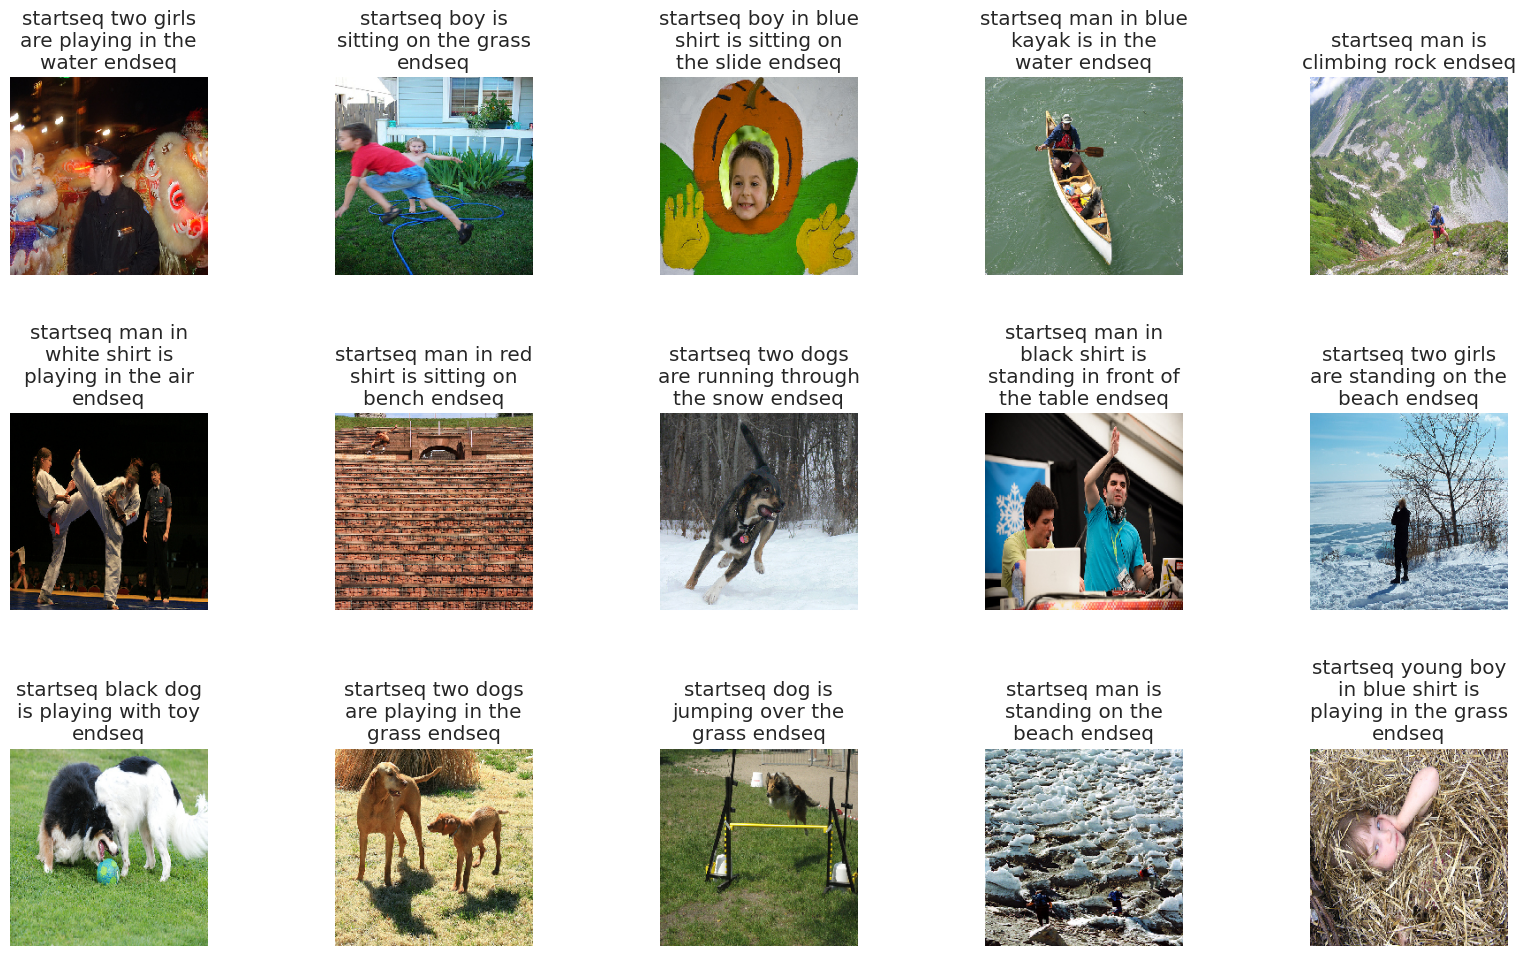

In [25]:
display_images(samples)

In [24]:
import pickle

# Load the tokenizer
with open("tokenizer_name.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)